In [8]:
from utils import *
import pymongo
import datetime

In [2]:
myclient = pymongo.MongoClient("mongodb://localhost:27017/")
mydb = myclient["db"]
birds = mydb["electric_scooters"]

#travels.insert_one(travel.__dict__)
travels = mydb["travels"]

In [83]:
def dis_hour(hour):
    hour = str(hour)
    if(hour in ["0","1","2"]):
        return "Q1"
    if(hour in ["3","4","5"]):
        return "Q2"
    if(hour in ["6","7","8"]):
        return "Q3"
    if(hour in ["9","10","11"]):
        return "Q4"
    if(hour in ["12","13","14"]):
        return "Q5"
    if(hour in ["15","16","17"]):
        return "Q6"
    if(hour in ["18","19","20"]):
        return "Q7"
    if(hour in ["21","22","23"]):
        return "Q8"

def duration_dis(d):
    if(d < 120):
        return "short"
    if(d >= 120 and d <= 600):
        return "mid"
    return "long"

def start_battery_level_dis(d):
    d = int(d)
    if(d < 33):
        return "low"
    if(d >= 33 and d < 66):
        return "mid"
    return "high"

def distance_dis(d):
    d = float(d)
    if(d < 0.01):
        return "short"
    if(d >= 0.01 and d <= 0.1):
        return "mid"
    return "long"



In [84]:
class Travel:
    def __init__(self, scooter_id, start_time, duration, start_location, end_location, distance, start_region, end_region, region_change, start_battlery_level, battery_used):
        self.scooter_id = scooter_id
        self.start_time = start_time
        self.duration = duration
        self.start_location = start_location
        self.end_location = end_location
        self.distance = distance
        self.start_region = start_region
        self.end_region = end_region
        self.region_change = region_change
        self.start_battery_level = start_battlery_level
        self.battery_used = battery_used
        
    def __init__(self, dic):
        self.scooter_id = dic.get("scooter_id")
        self.start_time = dic.get("start_time")
        self.duration = dic.get("duration")
        self.start_location = dic.get("start_location")
        self.end_location = dic.get("end_location")
        self.distance = dic.get("distance")
        self.start_region = dic.get("start_region")
        self.end_region = dic.get("end_region")
        self.region_change = dic.get("region_change")
        self.start_battery_level = dic.get("start_battery_level")
        self.battery_used = dic.get("battery_used")
        
    def dis(self):
        self.start_time_dis = dis_hour(datetime.datetime.strptime(self.start_time, "%Y-%m-%d %H:%M:%S").hour)
        self.duration_dis = duration_dis(self.duration)
        self.start_battery_level_dis = start_battery_level_dis(self.start_battery_level)
        self.distance_dis = distance_dis(self.distance)

In [85]:
travels = mydb["travels"]
all_travels = travels.find()

travels_dis = mydb["travels_dis2"]

for t in all_travels:
    t1 = Travel(t)
    t1.dis()
    travels_dis.insert_one(t1.__dict__)

In [4]:
def get_birds_ids(birds):
    return list(birds.distinct("id"))

In [5]:
birds_ids = get_birds_ids(birds)
print(len(birds_ids))

7642


In [22]:
def time_dif(timestring1, timestring2):
    time1 = datetime.datetime.strptime(timestring1, "%Y-%m-%d %H:%M:%S")
    time2 = datetime.datetime.strptime(timestring2, "%Y-%m-%d %H:%M:%S")
    return int((time2 - time1).total_seconds())

In [26]:
from geopy.distance import geodesic

class Location:
    def __init__(self, latitude, longitude, id):
        self.latitude = latitude
        self.longitude = longitude
        self.id = id

def calculate_distance(old_location, new_location):
    old_location = (old_location.get("latitude"), old_location.get("longitude"))
    new_location = (new_location.get("latitude"), new_location.get("longitude"))
    distance = geodesic(old_location, new_location).kilometers
    return distance

def get_region(location):
    cen = Location(50.061692, 19.937474, "cen")
    agh = Location(50.065969, 19.920421, "agh")
    zam = Location(50.055780, 19.932440, "zam")
    kaz = Location(50.051253, 19.943373, "kaz")
    grz = Location(50.056124, 19.952365, "grz")
    dwo = Location(50.064258, 19.945410, "dwo")
    kle = Location(50.070121, 19.936520, "kle")
    
    locations = [cen, agh, zam, kaz, grz, dwo, kle]
    
    min_dis = 100000000
    min_loc = cen
    
    for l in locations:
        dis = calculate_distance(location, l.__dict__)
        if(dis < min_dis):
            min_dis = dis
            min_loc = l
    
    return min_loc.id

def get_region_change(o,n):
    return o != n

def get_battery_used(o,n):
    return int(o) - int(n)

In [43]:
def get_distance_and_moves(bird_id, birds, time):
    if time == "any":
        bird_by_id = birds.find({"id": bird_id})
    else:
        bird_by_id = birds.find({"$and": [{"id": bird_id}, {"time":{"$regex": u"" + time +""}}]})
    bird_by_id = list(bird_by_id)
    
    print(len(bird_by_id))
    total_distance = 0
    used = 0
    print("----------------------------------------------------------")
    print("ID: " + bird_id)
    for i in range(len(bird_by_id) - 1):
        previous = bird_by_id[i]
        actual = bird_by_id[i + 1]
        actual_distance = calculate_distance(previous.get("location"), actual.get("location"))
        duration = time_dif(previous.get("time"), actual.get("time"))
        if(actual_distance > 0.001 and (int(previous.get("battery_level")) > int(actual.get("battery_level"))) and (duration < 5000) ):
            #print(previous.get("time") + " " + previous.get("battery_level") + " " + actual.get("battery_level") +" " + str(actual_distance))
            used += 1
            total_distance += actual_distance
            start_region = get_region(previous.get("location"))
            end_region = get_region(actual.get("location"))
            region_change = get_region_change(start_region, end_region)
            battery_used = get_battery_used(previous.get("battery_level"), actual.get("battery_level"))
            print(previous.get("time") + " " + actual.get("time"))
            travel = Travel(bird_id, previous.get("time"), duration,
                           previous.get("location"), actual.get("location"), actual_distance, start_region,
                           end_region, region_change, previous.get("battery_level"), battery_used)
            print(travel.__dict__)
            travels.insert_one(travel.__dict__)
    return {"distance":total_distance, "used": used}

In [14]:
all_time = "any"
days = ["2019-10-29", "2019-10-30", "2019-10-31", "2019-11-01", "2019-11-02", "2019-11-03", "2019-11-04"]

In [15]:
def get_total(bird_ids, birds, time):
    total_used = 0
    total_dist = 0
    interator = 0
    bird_ids_len = len(bird_ids)
    for bird_id in bird_ids:
        interator +=1
        dist_movs = get_distance_and_moves(bird_id, birds, time)
        print("ID number : " + str(interator) + " of " + str(bird_ids_len))
        total_used += dist_movs.get("used")
        total_dist += dist_movs.get("distance")
    return {"distance":total_dist, "used": total_used}

In [44]:
#Długi czsa wykonania
get_total(birds_ids, birds, all_time)

309
----------------------------------------------------------
ID: 856c8f94-4a3e-4d0a-a548-cc32a161669b
ID number : 1 of 7642
492
----------------------------------------------------------
ID: 6a278424-589f-4fc2-8fd7-fd32acd26ba9
2019-10-28 20:08:33 2019-10-28 20:36:14
{'scooter_id': '6a278424-589f-4fc2-8fd7-fd32acd26ba9', 'start_time': '2019-10-28 20:08:33', 'duration': 1661, 'start_location': {'latitude': '50.07362333333334', 'longitude': '19.940963333333332'}, 'end_location': {'latitude': '50.073589999999996', 'longitude': '19.94093333333333'}, 'distance': 0.004284745147146981, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 'start_battery_level': '35', 'battery_used': 2}
2019-10-28 20:00:54 2019-10-28 20:41:14
{'scooter_id': '6a278424-589f-4fc2-8fd7-fd32acd26ba9', 'start_time': '2019-10-28 20:00:54', 'duration': 2420, 'start_location': {'latitude': '50.07362666666666', 'longitude': '19.940971666666666'}, 'end_location': {'latitude': '50.073589999999996', 'longit

1351
----------------------------------------------------------
ID: 8ad46d72-edea-42f5-92da-70bd97a5a92f
2019-10-30 20:12:17 2019-10-30 20:13:35
{'scooter_id': '8ad46d72-edea-42f5-92da-70bd97a5a92f', 'start_time': '2019-10-30 20:12:17', 'duration': 78, 'start_location': {'latitude': '50.05920833333333', 'longitude': '19.94322833333333'}, 'end_location': {'latitude': '50.05922333333333', 'longitude': '19.943235'}, 'distance': 0.0017354052811824634, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '93', 'battery_used': 2}
2019-10-31 04:51:54 2019-10-31 04:53:11
{'scooter_id': '8ad46d72-edea-42f5-92da-70bd97a5a92f', 'start_time': '2019-10-31 04:51:54', 'duration': 77, 'start_location': {'latitude': '50.05924666666667', 'longitude': '19.94319833333333'}, 'end_location': {'latitude': '50.05922333333333', 'longitude': '19.943226666666664'}, 'distance': 0.0032942856629526156, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_b

197
----------------------------------------------------------
ID: 911354b4-7b85-4b65-a7a0-5f7b86e5f79b
ID number : 16 of 7642
197
----------------------------------------------------------
ID: 6d5a7ba3-525c-47fd-ae3b-849e04929ff3
ID number : 17 of 7642
268
----------------------------------------------------------
ID: 54f6a734-bbc5-432d-a3d8-b89e99b7bc25
ID number : 18 of 7642
42
----------------------------------------------------------
ID: 2c60199d-8519-419e-b2d8-6a208a303fa4
ID number : 19 of 7642
254
----------------------------------------------------------
ID: 3ca57ded-b5fa-4379-8e3b-131890a77a05
2019-10-28 20:03:26 2019-10-28 20:04:42
{'scooter_id': '3ca57ded-b5fa-4379-8e3b-131890a77a05', 'start_time': '2019-10-28 20:03:26', 'duration': 76, 'start_location': {'latitude': '50.048298333333335', 'longitude': '19.930870000000002'}, 'end_location': {'latitude': '50.04584166666667', 'longitude': '19.930075'}, 'distance': 0.2791249139685608, 'start_region': 'zam', 'end_region': 'zam',

187
----------------------------------------------------------
ID: 2be1d8c5-5b6e-4628-b851-e81182aea7c8
2019-10-28 20:15:10 2019-10-28 20:16:31
{'scooter_id': '2be1d8c5-5b6e-4628-b851-e81182aea7c8', 'start_time': '2019-10-28 20:15:10', 'duration': 81, 'start_location': {'latitude': '50.043578', 'longitude': '19.9351801'}, 'end_location': {'latitude': '50.04348333333334', 'longitude': '19.935263333333335'}, 'distance': 0.012100512794161989, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '21', 'battery_used': 8}
ID number : 25 of 7642
2287
----------------------------------------------------------
ID: 3f9965b1-f35e-4203-9444-1a7d717186ea
2019-10-30 10:29:55 2019-10-30 10:33:46
{'scooter_id': '3f9965b1-f35e-4203-9444-1a7d717186ea', 'start_time': '2019-10-30 10:29:55', 'duration': 231, 'start_location': {'latitude': '50.05547', 'longitude': '19.94395666666667'}, 'end_location': {'latitude': '50.05551833333334', 'longitude': '19.94395666666667'}, 

383
----------------------------------------------------------
ID: e8ca69ee-105b-4888-8eaf-faad76f60185
ID number : 33 of 7642
310
----------------------------------------------------------
ID: b82e1729-a0d5-4e55-8e01-f5ec2020c366
ID number : 34 of 7642
675
----------------------------------------------------------
ID: 081dcc6e-2551-4b4f-bf69-c181d0a499e0
2019-10-29 20:58:30 2019-10-29 20:59:47
{'scooter_id': '081dcc6e-2551-4b4f-bf69-c181d0a499e0', 'start_time': '2019-10-29 20:58:30', 'duration': 77, 'start_location': {'latitude': '50.051444999999994', 'longitude': '19.93534833333333'}, 'end_location': {'latitude': '50.051444999999994', 'longitude': '19.93536333333333'}, 'distance': 0.0010742882842162663, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '89', 'battery_used': 2}
ID number : 35 of 7642
383
----------------------------------------------------------
ID: 88677737-b968-478f-9ef3-6706af2c6156
ID number : 36 of 7642
426
---------------

1956
----------------------------------------------------------
ID: 76963af8-33dd-4dd6-bcfe-6ed531673c0a
2019-10-28 20:08:33 2019-10-28 20:09:47
{'scooter_id': '76963af8-33dd-4dd6-bcfe-6ed531673c0a', 'start_time': '2019-10-28 20:08:33', 'duration': 74, 'start_location': {'latitude': '50.05264666666667', 'longitude': '19.944201666666668'}, 'end_location': {'latitude': '50.05267333333333', 'longitude': '19.944151666666667'}, 'distance': 0.00464979496278293, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '16', 'battery_used': 5}
2019-10-28 20:06:00 2019-10-28 20:43:55
{'scooter_id': '76963af8-33dd-4dd6-bcfe-6ed531673c0a', 'start_time': '2019-10-28 20:06:00', 'duration': 2275, 'start_location': {'latitude': '50.052726666666665', 'longitude': '19.944278333333333'}, 'end_location': {'latitude': '50.05269166666667', 'longitude': '19.944145'}, 'distance': 0.010312072888859049, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start

419
----------------------------------------------------------
ID: 99dd4064-0f08-4d10-91f7-85e4410b612b
2019-10-28 23:03:40 2019-10-28 23:11:11
{'scooter_id': '99dd4064-0f08-4d10-91f7-85e4410b612b', 'start_time': '2019-10-28 23:03:40', 'duration': 451, 'start_location': {'latitude': '50.05556833333333', 'longitude': '19.942298333333333'}, 'end_location': {'latitude': '50.055641666666666', 'longitude': '19.94248'}, 'distance': 0.01535535510001743, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '98', 'battery_used': 2}
2019-10-28 23:06:15 2019-10-28 23:17:28
{'scooter_id': '99dd4064-0f08-4d10-91f7-85e4410b612b', 'start_time': '2019-10-28 23:06:15', 'duration': 673, 'start_location': {'latitude': '50.05556833333333', 'longitude': '19.942298333333333'}, 'end_location': {'latitude': '50.055609999999994', 'longitude': '19.942421666666668'}, 'distance': 0.009974393196449346, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_

379
----------------------------------------------------------
ID: db8cbddd-29e0-4136-b69b-df130c220594
2019-10-28 21:00:56 2019-10-28 21:02:24
{'scooter_id': 'db8cbddd-29e0-4136-b69b-df130c220594', 'start_time': '2019-10-28 21:00:56', 'duration': 88, 'start_location': {'latitude': '50.05692333333333', 'longitude': '19.94067'}, 'end_location': {'latitude': '50.05693833333333', 'longitude': '19.94067'}, 'distance': 0.001668452416005911, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '98', 'battery_used': 2}
ID number : 84 of 7642
383
----------------------------------------------------------
ID: 48167483-72c2-4c78-8e29-6bcf1a8d7135
ID number : 85 of 7642
383
----------------------------------------------------------
ID: f55f22f0-541c-4c5f-87a9-31931e632a81
2019-10-28 20:15:10 2019-10-28 20:16:31
{'scooter_id': 'f55f22f0-541c-4c5f-87a9-31931e632a81', 'start_time': '2019-10-28 20:15:10', 'duration': 81, 'start_location': {'latitude': '50.057', '

197
----------------------------------------------------------
ID: 5ba408a3-7032-4557-a1d4-f1f292f5ea96
ID number : 98 of 7642
415
----------------------------------------------------------
ID: 5c09d694-e702-45ec-8065-5884d5c7ca0a
2019-10-28 20:45:17 2019-10-28 21:00:56
{'scooter_id': '5c09d694-e702-45ec-8065-5884d5c7ca0a', 'start_time': '2019-10-28 20:45:17', 'duration': 939, 'start_location': {'latitude': '50.056736666666666', 'longitude': '19.942535000000003'}, 'end_location': {'latitude': '50.05674666666667', 'longitude': '19.94254833333333'}, 'distance': 0.0014659099038546901, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '100', 'battery_used': 2}
ID number : 99 of 7642
254
----------------------------------------------------------
ID: a978c636-60da-4d32-bd85-abcfd9b8e779
2019-10-28 20:09:47 2019-10-28 20:37:29
{'scooter_id': 'a978c636-60da-4d32-bd85-abcfd9b8e779', 'start_time': '2019-10-28 20:09:47', 'duration': 1662, 'start_location':

254
----------------------------------------------------------
ID: a956d7bf-2020-40d3-8aee-deb14219d217
ID number : 115 of 7642
107
----------------------------------------------------------
ID: 6224496f-971f-4684-b3b5-4b18007dad16
ID number : 116 of 7642
264
----------------------------------------------------------
ID: d99dfa73-86ab-46a2-ad73-50bde4949948
2019-10-28 20:00:54 2019-10-28 20:07:16
{'scooter_id': 'd99dfa73-86ab-46a2-ad73-50bde4949948', 'start_time': '2019-10-28 20:00:54', 'duration': 382, 'start_location': {'latitude': '50.05922', 'longitude': '19.943088333333332'}, 'end_location': {'latitude': '50.05922333333333', 'longitude': '19.943048333333333'}, 'distance': 0.0028882029075878945, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '100', 'battery_used': 2}
2019-10-28 20:02:09 2019-10-28 20:42:33
{'scooter_id': 'd99dfa73-86ab-46a2-ad73-50bde4949948', 'start_time': '2019-10-28 20:02:09', 'duration': 2424, 'start_location': {'lati

663
----------------------------------------------------------
ID: 8649deb0-9315-4a8e-82d8-0babf92241ea
2019-10-28 20:45:17 2019-10-28 21:00:56
{'scooter_id': '8649deb0-9315-4a8e-82d8-0babf92241ea', 'start_time': '2019-10-28 20:45:17', 'duration': 939, 'start_location': {'latitude': '50.05925833333334', 'longitude': '19.943263333333334'}, 'end_location': {'latitude': '50.05926833333333', 'longitude': '19.943258333333333'}, 'distance': 0.0011685063201516011, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '93', 'battery_used': 2}
2019-10-29 09:56:58 2019-10-29 10:12:43
{'scooter_id': '8649deb0-9315-4a8e-82d8-0babf92241ea', 'start_time': '2019-10-29 09:56:58', 'duration': 945, 'start_location': {'latitude': '50.05919666666667', 'longitude': '19.943268333333332'}, 'end_location': {'latitude': '50.05918833333333', 'longitude': '19.943260000000002'}, 'distance': 0.001102390690802527, 'start_region': 'cen', 'end_region': 'cen', 'region_change': Fals

860
----------------------------------------------------------
ID: bd0688f6-6a56-4c07-bac4-a76acb710760
2019-10-29 21:58:20 2019-10-29 21:59:37
{'scooter_id': 'bd0688f6-6a56-4c07-bac4-a76acb710760', 'start_time': '2019-10-29 21:58:20', 'duration': 77, 'start_location': {'latitude': '50.05913999999999', 'longitude': '19.943285'}, 'end_location': {'latitude': '50.059101666666656', 'longitude': '19.94324'}, 'distance': 0.00534450591052254, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '63', 'battery_used': 2}
ID number : 135 of 7642
653
----------------------------------------------------------
ID: f171bf5c-a222-40da-9d62-74ccba7d1227
2019-10-29 10:19:06 2019-10-29 10:20:43
{'scooter_id': 'f171bf5c-a222-40da-9d62-74ccba7d1227', 'start_time': '2019-10-29 10:19:06', 'duration': 97, 'start_location': {'latitude': '50.05913166666666', 'longitude': '19.94328'}, 'end_location': {'latitude': '50.059105', 'longitude': '19.94322833333333'}, 'distance': 

300
----------------------------------------------------------
ID: 3174c26e-7d8e-4035-aa82-ed562996644c
2019-10-28 22:13:39 2019-10-28 22:21:52
{'scooter_id': '3174c26e-7d8e-4035-aa82-ed562996644c', 'start_time': '2019-10-28 22:13:39', 'duration': 493, 'start_location': {'latitude': '50.058426666666676', 'longitude': '19.945498333333333'}, 'end_location': {'latitude': '50.05846', 'longitude': '19.945486666666667'}, 'distance': 0.0038006305374260804, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '100', 'battery_used': 2}
2019-10-28 22:14:55 2019-10-28 22:16:12
{'scooter_id': '3174c26e-7d8e-4035-aa82-ed562996644c', 'start_time': '2019-10-28 22:14:55', 'duration': 77, 'start_location': {'latitude': '50.058426666666676', 'longitude': '19.945498333333333'}, 'end_location': {'latitude': '50.058441666666674', 'longitude': '19.945491666666666'}, 'distance': 0.0017354071976875896, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 's

ID number : 165 of 7642
2051
----------------------------------------------------------
ID: 23358dee-50d7-4070-bc1b-bde68f35d3bc
2019-10-30 05:59:58 2019-10-30 06:07:33
{'scooter_id': '23358dee-50d7-4070-bc1b-bde68f35d3bc', 'start_time': '2019-10-30 05:59:58', 'duration': 455, 'start_location': {'latitude': '50.051983333333325', 'longitude': '19.95515'}, 'end_location': {'latitude': '50.05191833333333', 'longitude': '19.955173333333335'}, 'distance': 0.007420566364783981, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '82', 'battery_used': 2}
2019-10-30 11:06:56 2019-10-30 11:08:11
{'scooter_id': '23358dee-50d7-4070-bc1b-bde68f35d3bc', 'start_time': '2019-10-30 11:06:56', 'duration': 75, 'start_location': {'latitude': '50.051914999999994', 'longitude': '19.955193333333334'}, 'end_location': {'latitude': '50.051959999999994', 'longitude': '19.955208333333335'}, 'distance': 0.005119338777244498, 'start_region': 'grz', 'end_region': 'grz', 'regi

1074
----------------------------------------------------------
ID: a999eadf-bb83-4321-8281-433c4bf545d5
2019-10-29 07:28:28 2019-10-29 07:30:02
{'scooter_id': 'a999eadf-bb83-4321-8281-433c4bf545d5', 'start_time': '2019-10-29 07:28:28', 'duration': 94, 'start_location': {'latitude': '50.051944999999996', 'longitude': '19.95513833333333'}, 'end_location': {'latitude': '50.051959999999994', 'longitude': '19.955143333333336'}, 'distance': 0.0017064462391096187, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '96', 'battery_used': 3}
ID number : 175 of 7642
383
----------------------------------------------------------
ID: 0037e897-f056-489e-a042-860904a09d79
ID number : 176 of 7642
261
----------------------------------------------------------
ID: 1aa3b6e9-eaa7-4a7e-92a7-659c0a73a92b
ID number : 177 of 7642
377
----------------------------------------------------------
ID: 87120e0b-2bcd-4230-82f9-c5be70443787
ID number : 178 of 7642
345
---------

2019-11-01 00:30:56 2019-11-01 00:32:13
{'scooter_id': '882a8f5a-7b56-46cd-b567-0bd79bdb312b', 'start_time': '2019-11-01 00:30:56', 'duration': 77, 'start_location': {'latitude': '50.051415', 'longitude': '19.935760000000002'}, 'end_location': {'latitude': '50.051444999999994', 'longitude': '19.935751666666665'}, 'distance': 0.0033898547339302936, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '78', 'battery_used': 3}
2019-11-02 18:54:53 2019-11-02 18:58:46
{'scooter_id': '882a8f5a-7b56-46cd-b567-0bd79bdb312b', 'start_time': '2019-11-02 18:54:53', 'duration': 233, 'start_location': {'latitude': '50.06112666666666', 'longitude': '19.929186666666666'}, 'end_location': {'latitude': '50.06110833333334', 'longitude': '19.929191666666668'}, 'distance': 0.0020704115402755538, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '93', 'battery_used': 2}
2019-11-02 18:56:12 2019-11-02 19:00:04
{'scooter_id': '882a

383
----------------------------------------------------------
ID: f735c09e-1142-479b-89ff-50c9e288abb8
2019-10-29 07:09:07 2019-10-29 07:11:02
{'scooter_id': 'f735c09e-1142-479b-89ff-50c9e288abb8', 'start_time': '2019-10-29 07:09:07', 'duration': 115, 'start_location': {'latitude': '50.066401666666664', 'longitude': '19.95446666666667'}, 'end_location': {'latitude': '50.06638666666666', 'longitude': '19.954448333333335'}, 'distance': 0.00212289670999284, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '55', 'battery_used': 2}
2019-10-29 10:38:20 2019-10-29 10:41:32
{'scooter_id': 'f735c09e-1142-479b-89ff-50c9e288abb8', 'start_time': '2019-10-29 10:38:20', 'duration': 192, 'start_location': {'latitude': '50.06627333333333', 'longitude': '19.954425'}, 'end_location': {'latitude': '50.066365', 'longitude': '19.954453333333333'}, 'distance': 0.01039595629602048, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_le

549
----------------------------------------------------------
ID: e0a78130-10b5-4658-aab2-1186bb5ccbd5
ID number : 232 of 7642
2
----------------------------------------------------------
ID: 03266a0a-d1fb-4cb9-8f8f-d3d160963182
ID number : 233 of 7642
136
----------------------------------------------------------
ID: cbad5dca-101b-4a6d-ae3e-265e69fe26f3
ID number : 234 of 7642
355
----------------------------------------------------------
ID: 2b6521c3-1919-4f9d-a135-90df4940c028
2019-10-29 11:13:50 2019-10-29 11:23:23
{'scooter_id': '2b6521c3-1919-4f9d-a135-90df4940c028', 'start_time': '2019-10-29 11:13:50', 'duration': 573, 'start_location': {'latitude': '50.05717833333333', 'longitude': '19.95843166666667'}, 'end_location': {'latitude': '50.05717500000001', 'longitude': '19.958453333333335'}, 'distance': 0.001595249826977716, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '53', 'battery_used': 2}
ID number : 235 of 7642
354
--------------

165
----------------------------------------------------------
ID: c85ffde9-ee50-4634-82b0-c773ab3b98f8
2019-10-28 21:11:58 2019-10-28 21:14:00
{'scooter_id': 'c85ffde9-ee50-4634-82b0-c773ab3b98f8', 'start_time': '2019-10-28 21:11:58', 'duration': 122, 'start_location': {'latitude': '50.05915', 'longitude': '19.943128333333334'}, 'end_location': {'latitude': '50.05914333333333', 'longitude': '19.943216666666668'}, 'distance': 0.006368669329238087, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '74', 'battery_used': 2}
2019-10-28 21:10:32 2019-10-28 21:18:28
{'scooter_id': 'c85ffde9-ee50-4634-82b0-c773ab3b98f8', 'start_time': '2019-10-28 21:10:32', 'duration': 476, 'start_location': {'latitude': '50.05915', 'longitude': '19.943128333333334'}, 'end_location': {'latitude': '50.05914333333333', 'longitude': '19.943216666666668'}, 'distance': 0.006368669329238087, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_l

422
----------------------------------------------------------
ID: 69e4d03f-dfcc-4507-ba94-2aa16afed64e
2019-10-28 21:44:42 2019-10-28 21:45:57
{'scooter_id': '69e4d03f-dfcc-4507-ba94-2aa16afed64e', 'start_time': '2019-10-28 21:44:42', 'duration': 75, 'start_location': {'latitude': '50.05787999999999', 'longitude': '19.951851666666666'}, 'end_location': {'latitude': '50.05827333333333', 'longitude': '19.951235'}, 'distance': 0.062162171849708625, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '94', 'battery_used': 3}
2019-10-28 21:45:57 2019-10-28 21:47:12
{'scooter_id': '69e4d03f-dfcc-4507-ba94-2aa16afed64e', 'start_time': '2019-10-28 21:45:57', 'duration': 75, 'start_location': {'latitude': '50.05827333333333', 'longitude': '19.951235'}, 'end_location': {'latitude': '50.05827666666667', 'longitude': '19.951151666666664'}, 'distance': 0.005978928277316452, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_lev

122
----------------------------------------------------------
ID: e68b64ba-5ddc-4cf4-979d-eac62c28d34e
ID number : 277 of 7642
38
----------------------------------------------------------
ID: 74f045db-e49b-4a8d-925c-0bc763c50985
ID number : 278 of 7642
117
----------------------------------------------------------
ID: 3965fcd0-10d3-461c-8cc0-7de1c71ad825
2019-10-28 22:14:55 2019-10-28 22:21:52
{'scooter_id': '3965fcd0-10d3-461c-8cc0-7de1c71ad825', 'start_time': '2019-10-28 22:14:55', 'duration': 417, 'start_location': {'latitude': '50.059375', 'longitude': '19.94213166666667'}, 'end_location': {'latitude': '50.05940999999999', 'longitude': '19.942295'}, 'distance': 0.01232677401815832, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '91', 'battery_used': 4}
2019-10-28 22:16:12 2019-10-28 22:19:17
{'scooter_id': '3965fcd0-10d3-461c-8cc0-7de1c71ad825', 'start_time': '2019-10-28 22:16:12', 'duration': 185, 'start_location': {'latitude': '50.059

2
----------------------------------------------------------
ID: d8809b1c-b203-4bda-8ed6-ccd21d235ccd
2019-10-28 22:57:26 2019-10-28 22:58:41
{'scooter_id': 'd8809b1c-b203-4bda-8ed6-ccd21d235ccd', 'start_time': '2019-10-28 22:57:26', 'duration': 75, 'start_location': {'latitude': '50.053845', 'longitude': '19.948179999999997'}, 'end_location': {'latitude': '50.05384000000001', 'longitude': '19.9482'}, 'distance': 0.0015364973026337394, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '27', 'battery_used': 2}
ID number : 289 of 7642
2
----------------------------------------------------------
ID: 42070d63-1c86-48f8-8355-310ceeb6ece5
ID number : 290 of 7642
82
----------------------------------------------------------
ID: 923e36ae-7613-4fea-a04a-3c2b45d87d14
ID number : 291 of 7642
1644
----------------------------------------------------------
ID: 7a395ec9-8508-4f69-9469-c48ae86f1f71
2019-10-31 16:35:41 2019-10-31 16:37:13
{'scooter_id': '7a395e

226
----------------------------------------------------------
ID: ec7bf0c4-6952-4474-9e5c-9a0dc580a59f
2019-10-28 23:55:24 2019-10-28 23:56:39
{'scooter_id': 'ec7bf0c4-6952-4474-9e5c-9a0dc580a59f', 'start_time': '2019-10-28 23:55:24', 'duration': 75, 'start_location': {'latitude': '50.05410833333334', 'longitude': '19.943245'}, 'end_location': {'latitude': '50.05410833333334', 'longitude': '19.94336'}, 'distance': 0.008235754338267889, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '83', 'battery_used': 4}
ID number : 304 of 7642
89
----------------------------------------------------------
ID: e0ee684c-d278-40e4-b0d4-1aff855db296
2019-10-28 23:52:52 2019-10-28 23:54:07
{'scooter_id': 'e0ee684c-d278-40e4-b0d4-1aff855db296', 'start_time': '2019-10-28 23:52:52', 'duration': 75, 'start_location': {'latitude': '50.07685166666667', 'longitude': '19.92707'}, 'end_location': {'latitude': '50.0773216', 'longitude': '19.9260599'}, 'distance': 0.08921

2019-10-31 22:05:15 2019-10-31 22:06:35
{'scooter_id': '8d4b2eb2-c5b7-4a05-a027-b1eb398732e1', 'start_time': '2019-10-31 22:05:15', 'duration': 80, 'start_location': {'latitude': '50.059375', 'longitude': '19.93219333333333'}, 'end_location': {'latitude': '50.05937166666666', 'longitude': '19.932180000000002'}, 'distance': 0.0010242293462739218, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '98', 'battery_used': 2}
2019-11-01 05:45:36 2019-11-01 05:46:55
{'scooter_id': '8d4b2eb2-c5b7-4a05-a027-b1eb398732e1', 'start_time': '2019-11-01 05:45:36', 'duration': 79, 'start_location': {'latitude': '50.05936499999999', 'longitude': '19.932295'}, 'end_location': {'latitude': '50.0593', 'longitude': '19.932285'}, 'distance': 0.007265337911594074, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '93', 'battery_used': 2}
ID number : 315 of 7642
38
----------------------------------------------------------
ID: d1

ID number : 336 of 7642
16
----------------------------------------------------------
ID: a955536b-ad8c-44f2-b901-ab6b3cef0be6
ID number : 337 of 7642
152
----------------------------------------------------------
ID: b64c769a-9d25-4864-a823-780c934a94aa
ID number : 338 of 7642
295
----------------------------------------------------------
ID: 4ec4cf50-bcba-4219-95ac-a9f87ae2bbc7
2019-10-29 10:15:54 2019-10-29 10:17:30
{'scooter_id': '4ec4cf50-bcba-4219-95ac-a9f87ae2bbc7', 'start_time': '2019-10-29 10:15:54', 'duration': 96, 'start_location': {'latitude': '50.058528333333335', 'longitude': '19.950726666666664'}, 'end_location': {'latitude': '50.058524999999996', 'longitude': '19.950713333333333'}, 'distance': 0.0010242449906891823, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '98', 'battery_used': 2}
ID number : 339 of 7642
152
----------------------------------------------------------
ID: 67d4c3f0-adf8-437d-909e-de788c62a944
ID number : 34

1821
----------------------------------------------------------
ID: 2f7d0fc6-af9d-44b0-9629-9883c8723062
2019-10-29 08:02:56 2019-10-29 08:04:32
{'scooter_id': '2f7d0fc6-af9d-44b0-9629-9883c8723062', 'start_time': '2019-10-29 08:02:56', 'duration': 96, 'start_location': {'latitude': '50.048755', 'longitude': '19.942218333333336'}, 'end_location': {'latitude': '50.04872166666667', 'longitude': '19.942268333333335'}, 'distance': 0.005154756707087652, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '98', 'battery_used': 2}
2019-10-30 03:00:50 2019-10-30 03:07:09
{'scooter_id': '2f7d0fc6-af9d-44b0-9629-9883c8723062', 'start_time': '2019-10-30 03:00:50', 'duration': 379, 'start_location': {'latitude': '50.04868333333334', 'longitude': '19.942285000000002'}, 'end_location': {'latitude': '50.048671666666664', 'longitude': '19.942285000000002'}, 'distance': 0.0012976833581647281, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'sta

1852
----------------------------------------------------------
ID: 789e87ec-870c-42ef-b5c0-1e50ef63821d
2019-10-30 03:39:51 2019-10-30 03:41:07
{'scooter_id': '789e87ec-870c-42ef-b5c0-1e50ef63821d', 'start_time': '2019-10-30 03:39:51', 'duration': 76, 'start_location': {'latitude': '50.04873333333333', 'longitude': '19.94229'}, 'end_location': {'latitude': '50.048716666666664', 'longitude': '19.9423'}, 'distance': 0.0019873820587602087, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '84', 'battery_used': 2}
2019-10-30 10:58:02 2019-10-30 10:59:18
{'scooter_id': '789e87ec-870c-42ef-b5c0-1e50ef63821d', 'start_time': '2019-10-30 10:58:02', 'duration': 76, 'start_location': {'latitude': '50.048694999999995', 'longitude': '19.942291666666666'}, 'end_location': {'latitude': '50.04871', 'longitude': '19.942308333333337'}, 'distance': 0.0020515108979686243, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '8

897
----------------------------------------------------------
ID: 6f812218-68b2-492b-a8dc-aac346543bc9
2019-10-29 08:08:03 2019-10-29 08:19:09
{'scooter_id': '6f812218-68b2-492b-a8dc-aac346543bc9', 'start_time': '2019-10-29 08:08:03', 'duration': 666, 'start_location': {'latitude': '50.050021666666666', 'longitude': '19.94129333333333'}, 'end_location': {'latitude': '50.05001000000001', 'longitude': '19.941315'}, 'distance': 0.0020228823908803027, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '98', 'battery_used': 2}
2019-10-29 08:09:36 2019-10-29 08:14:23
{'scooter_id': '6f812218-68b2-492b-a8dc-aac346543bc9', 'start_time': '2019-10-29 08:09:36', 'duration': 287, 'start_location': {'latitude': '50.050021666666666', 'longitude': '19.94129333333333'}, 'end_location': {'latitude': '50.05001000000001', 'longitude': '19.941303333333334'}, 'distance': 0.0014822093629336815, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'star

2019-10-31 15:35:37 2019-10-31 15:38:37
{'scooter_id': '10cbc1bf-8246-46ab-ae36-6b93766c90e7', 'start_time': '2019-10-31 15:35:37', 'duration': 180, 'start_location': {'latitude': '50.05940166666666', 'longitude': '19.93233'}, 'end_location': {'latitude': '50.05936', 'longitude': '19.932380000000002'}, 'distance': 0.005856491710623128, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '84', 'battery_used': 2}
2019-10-31 15:37:08 2019-10-31 15:40:03
{'scooter_id': '10cbc1bf-8246-46ab-ae36-6b93766c90e7', 'start_time': '2019-10-31 15:37:08', 'duration': 175, 'start_location': {'latitude': '50.05940166666666', 'longitude': '19.93233'}, 'end_location': {'latitude': '50.05936', 'longitude': '19.932380000000002'}, 'distance': 0.005856491710623128, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '84', 'battery_used': 2}
ID number : 373 of 7642
173
----------------------------------------------------------
ID: 4

1785
----------------------------------------------------------
ID: 3263ffd9-1690-40f4-8702-9a434a8ec7d2
ID number : 391 of 7642
837
----------------------------------------------------------
ID: c6a6d815-160d-48f5-a156-d64669e61836
2019-10-30 00:58:21 2019-10-30 00:59:37
{'scooter_id': 'c6a6d815-160d-48f5-a156-d64669e61836', 'start_time': '2019-10-30 00:58:21', 'duration': 76, 'start_location': {'latitude': '50.05542333333333', 'longitude': '19.931336666666667'}, 'end_location': {'latitude': '50.055416666666666', 'longitude': '19.931348333333336'}, 'distance': 0.001117100748206269, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '87', 'battery_used': 3}
ID number : 392 of 7642
167
----------------------------------------------------------
ID: 948bc548-cf85-428f-9a1c-d9443813563f
2019-10-29 09:55:23 2019-10-29 10:09:34
{'scooter_id': '948bc548-cf85-428f-9a1c-d9443813563f', 'start_time': '2019-10-29 09:55:23', 'duration': 851, 'start_location':

1510
----------------------------------------------------------
ID: 4c3c9539-7f34-4f7e-98e9-f4d4e0d98268
2019-10-30 15:42:18 2019-10-30 15:43:37
{'scooter_id': '4c3c9539-7f34-4f7e-98e9-f4d4e0d98268', 'start_time': '2019-10-30 15:42:18', 'duration': 79, 'start_location': {'latitude': '50.055435', 'longitude': '19.931286666666665'}, 'end_location': {'latitude': '50.05542333333333', 'longitude': '19.931265'}, 'distance': 0.002022749265615489, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '89', 'battery_used': 2}
ID number : 407 of 7642
226
----------------------------------------------------------
ID: 2336cadd-5670-41dd-b8cf-c78fe24b782c
ID number : 408 of 7642
165
----------------------------------------------------------
ID: 75078e29-8361-487d-9546-2f88d86d120b
ID number : 409 of 7642
979
----------------------------------------------------------
ID: 9bdba3db-cae1-49c0-b48c-23622bc23f7d
ID number : 410 of 7642
165
----------------------------

160
----------------------------------------------------------
ID: 2596b3b4-13c8-4fee-b0d5-00776c76d866
ID number : 428 of 7642
160
----------------------------------------------------------
ID: dd8d98a2-4333-4f76-a536-2a52caf8b32e
ID number : 429 of 7642
160
----------------------------------------------------------
ID: 2cb182ad-8adc-4abf-8ad1-33bfaf1f8478
ID number : 430 of 7642
160
----------------------------------------------------------
ID: 952e6b75-3dc9-4bdc-b894-a0215a579166
ID number : 431 of 7642
160
----------------------------------------------------------
ID: 52b62881-d0de-4f77-9951-958eafca1cdd
ID number : 432 of 7642
128
----------------------------------------------------------
ID: 4ff74d3d-b3ae-4888-a4c7-50c99499798b
ID number : 433 of 7642
858
----------------------------------------------------------
ID: 140fc8d0-3334-45ad-b32d-e4e6c669be11
ID number : 434 of 7642
68
----------------------------------------------------------
ID: db3a6361-52eb-40bc-aaa0-550b2f3f5262
2

1204
----------------------------------------------------------
ID: 34ba83fb-b480-4234-902d-8499cd43315f
2019-10-29 21:15:05 2019-10-29 21:16:21
{'scooter_id': '34ba83fb-b480-4234-902d-8499cd43315f', 'start_time': '2019-10-29 21:15:05', 'duration': 76, 'start_location': {'latitude': '50.05695333333333', 'longitude': '19.93387166666667'}, 'end_location': {'latitude': '50.056945', 'longitude': '19.933878333333332'}, 'distance': 0.0010426381431155255, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '96', 'battery_used': 3}
2019-10-30 02:11:39 2019-10-30 02:21:46
{'scooter_id': '34ba83fb-b480-4234-902d-8499cd43315f', 'start_time': '2019-10-30 02:11:39', 'duration': 607, 'start_location': {'latitude': '50.05698', 'longitude': '19.933851666666666'}, 'end_location': {'latitude': '50.05695666666667', 'longitude': '19.93387166666667'}, 'distance': 0.0029643214683592236, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_

968
----------------------------------------------------------
ID: d8c3287a-cd70-4365-89fe-a83b40c58e5a
2019-10-30 02:16:44 2019-10-30 02:28:05
{'scooter_id': 'd8c3287a-cd70-4365-89fe-a83b40c58e5a', 'start_time': '2019-10-30 02:16:44', 'duration': 681, 'start_location': {'latitude': '50.056961666666666', 'longitude': '19.93388'}, 'end_location': {'latitude': '50.05695000000001', 'longitude': '19.933895'}, 'distance': 0.00168458241765569, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '93', 'battery_used': 2}
2019-10-30 05:57:28 2019-10-30 06:03:46
{'scooter_id': 'd8c3287a-cd70-4365-89fe-a83b40c58e5a', 'start_time': '2019-10-30 05:57:28', 'duration': 378, 'start_location': {'latitude': '50.05693833333333', 'longitude': '19.93393166666667'}, 'end_location': {'latitude': '50.05699500000001', 'longitude': '19.933936666666668'}, 'distance': 0.006313204267911592, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_lev

129
----------------------------------------------------------
ID: b5106bdf-1352-4c60-baa2-c6bf38a4033c
ID number : 465 of 7642
138
----------------------------------------------------------
ID: dee904b1-c1de-4c2d-ad21-fca0152703e0
ID number : 466 of 7642
146
----------------------------------------------------------
ID: de8ce6d3-c578-4e40-a067-26343769343d
ID number : 467 of 7642
1515
----------------------------------------------------------
ID: 131f5782-97bc-4e27-9ea1-a7b38306dfe8
2019-10-30 07:02:58 2019-10-30 07:04:14
{'scooter_id': '131f5782-97bc-4e27-9ea1-a7b38306dfe8', 'start_time': '2019-10-30 07:02:58', 'duration': 76, 'start_location': {'latitude': '50.05708666666666', 'longitude': '19.934169999999998'}, 'end_location': {'latitude': '50.05707166666666', 'longitude': '19.934076666666666'}, 'distance': 0.006888779456366178, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '91', 'battery_used': 2}
2019-10-30 09:52:54 2019-10-30 09:54:10

25
----------------------------------------------------------
ID: 24f2864a-9a98-4471-8c80-5726bdcea3cf
ID number : 474 of 7642
8
----------------------------------------------------------
ID: 759b84ef-c80e-4036-b197-e8c80ab06894
ID number : 475 of 7642
2
----------------------------------------------------------
ID: 6fad251d-68c7-4225-b08d-9fe0261c89d5
ID number : 476 of 7642
2320
----------------------------------------------------------
ID: 99514d68-6fa3-4b8d-8a5f-57204fc1651f
ID number : 477 of 7642
1370
----------------------------------------------------------
ID: fdb2204c-5653-416b-9efa-291b3895c161
2019-10-29 08:40:07 2019-10-29 08:41:42
{'scooter_id': 'fdb2204c-5653-416b-9efa-291b3895c161', 'start_time': '2019-10-29 08:40:07', 'duration': 95, 'start_location': {'latitude': '50.0695115', 'longitude': '19.9138672'}, 'end_location': {'latitude': '50.0681016', 'longitude': '19.9135199'}, 'distance': 0.1587826143741322, 'start_region': 'agh', 'end_region': 'agh', 'region_change': Fa

123
----------------------------------------------------------
ID: ace3ca82-d35e-4ef8-a836-bc93e411de7c
2019-10-29 08:49:37 2019-10-29 08:57:35
{'scooter_id': 'ace3ca82-d35e-4ef8-a836-bc93e411de7c', 'start_time': '2019-10-29 08:49:37', 'duration': 478, 'start_location': {'latitude': '50.06841333333333', 'longitude': '19.956453333333332'}, 'end_location': {'latitude': '50.06834833333334', 'longitude': '19.956316666666666'}, 'distance': 0.012165905872685012, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '82', 'battery_used': 7}
ID number : 487 of 7642
23
----------------------------------------------------------
ID: e4b67163-8a8d-4e18-8eac-fedaa9f2ac59
ID number : 488 of 7642
123
----------------------------------------------------------
ID: ba2f29ce-abd2-4fa6-b48f-87e851e372cf
2019-10-29 08:51:12 2019-10-29 08:57:35
{'scooter_id': 'ba2f29ce-abd2-4fa6-b48f-87e851e372cf', 'start_time': '2019-10-29 08:51:12', 'duration': 383, 'start_location': {

50
----------------------------------------------------------
ID: fd8b338e-1ad8-4891-9ef0-7a85db081a0e
2019-10-29 09:08:50 2019-10-29 09:10:27
{'scooter_id': 'fd8b338e-1ad8-4891-9ef0-7a85db081a0e', 'start_time': '2019-10-29 09:08:50', 'duration': 97, 'start_location': {'latitude': '50.064556666666675', 'longitude': '19.94652'}, 'end_location': {'latitude': '50.064609999999995', 'longitude': '19.946653333333334'}, 'distance': 0.011239660641685457, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '53', 'battery_used': 2}
ID number : 504 of 7642
109
----------------------------------------------------------
ID: 9c6211d1-bdd3-4f5f-a6bc-96e0fb296e6b
2019-10-29 09:12:04 2019-10-29 09:13:40
{'scooter_id': '9c6211d1-bdd3-4f5f-a6bc-96e0fb296e6b', 'start_time': '2019-10-29 09:12:04', 'duration': 96, 'start_location': {'latitude': '50.055416666666666', 'longitude': '19.94405'}, 'end_location': {'latitude': '50.05547333333334', 'longitude': '19.94415666666

102
----------------------------------------------------------
ID: 4b172bb9-390e-4427-9213-8792339c68b4
2019-10-29 09:23:19 2019-10-29 09:24:57
{'scooter_id': '4b172bb9-390e-4427-9213-8792339c68b4', 'start_time': '2019-10-29 09:23:19', 'duration': 98, 'start_location': {'latitude': '50.059486666666665', 'longitude': '19.95061666666667'}, 'end_location': {'latitude': '50.05938333333334', 'longitude': '19.950781666666668'}, 'distance': 0.016483516979584445, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '89', 'battery_used': 7}
ID number : 510 of 7642
183
----------------------------------------------------------
ID: acf7d7a8-3704-4d5c-a0e5-919ec70530f4
ID number : 511 of 7642
25
----------------------------------------------------------
ID: c8fe487b-11f5-40a3-bb9d-17e91018dce5
2019-10-29 09:28:10 2019-10-29 09:29:46
{'scooter_id': 'c8fe487b-11f5-40a3-bb9d-17e91018dce5', 'start_time': '2019-10-29 09:28:10', 'duration': 96, 'start_location': {'l

67
----------------------------------------------------------
ID: a748a1a9-85e7-48cf-a014-624e958bca73
ID number : 521 of 7642
79
----------------------------------------------------------
ID: 9bb948f6-9549-4871-a5d1-5518d851d3ba
2019-10-29 09:56:58 2019-10-29 10:11:08
{'scooter_id': '9bb948f6-9549-4871-a5d1-5518d851d3ba', 'start_time': '2019-10-29 09:56:58', 'duration': 850, 'start_location': {'latitude': '50.05214666666667', 'longitude': '19.949123333333333'}, 'end_location': {'latitude': '50.052524999999996', 'longitude': '19.948986666666666'}, 'distance': 0.04320531273343974, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '69', 'battery_used': 2}
2019-10-29 10:00:08 2019-10-29 10:01:41
{'scooter_id': '9bb948f6-9549-4871-a5d1-5518d851d3ba', 'start_time': '2019-10-29 10:00:08', 'duration': 93, 'start_location': {'latitude': '50.05214666666667', 'longitude': '19.949123333333333'}, 'end_location': {'latitude': '50.052536666666676', 'longitude

2019-10-30 18:44:01 2019-10-30 18:45:18
{'scooter_id': 'e15e3dec-bfa5-4395-929b-98c954b322cb', 'start_time': '2019-10-30 18:44:01', 'duration': 77, 'start_location': {'latitude': '50.05177666666667', 'longitude': '19.950738333333334'}, 'end_location': {'latitude': '50.05183', 'longitude': '19.950713333333333'}, 'distance': 0.0061965796837850935, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '72', 'battery_used': 2}
2019-10-31 06:46:18 2019-10-31 07:12:47
{'scooter_id': 'e15e3dec-bfa5-4395-929b-98c954b322cb', 'start_time': '2019-10-31 06:46:18', 'duration': 1589, 'start_location': {'latitude': '50.05192999999999', 'longitude': '19.950656666666664'}, 'end_location': {'latitude': '50.05191', 'longitude': '19.950666666666667'}, 'distance': 0.002337043436486194, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '65', 'battery_used': 2}
2019-10-31 06:38:07 2019-10-31 07:17:06
{'scooter_id': 'e15e3dec-bfa5-4

13
----------------------------------------------------------
ID: ebd6d4c7-79b8-4647-afa8-9d45451f7b96
ID number : 555 of 7642
1
----------------------------------------------------------
ID: e6ed4b57-1eb9-4f4e-94e4-7d517143a2c9
ID number : 556 of 7642
51
----------------------------------------------------------
ID: 158f7d5e-83eb-4c0c-86ee-6c950a2a9097
ID number : 557 of 7642
111
----------------------------------------------------------
ID: d98c7e6a-88c2-4fa2-9c47-23f11624d902
ID number : 558 of 7642
51
----------------------------------------------------------
ID: 5148fff8-8a47-4f2e-86e6-73820103a65f
ID number : 559 of 7642
350
----------------------------------------------------------
ID: e276d9c7-0e26-4f7e-916e-14b009c6fa8e
ID number : 560 of 7642
51
----------------------------------------------------------
ID: 44e8bb8c-78ed-4ab9-b816-2bcbeecf64da
ID number : 561 of 7642
51
----------------------------------------------------------
ID: 97407a9f-f11c-4c67-915a-b78ba09fe508
ID numb

51
----------------------------------------------------------
ID: bc3a0017-3334-4ce2-bf4d-3533d6430095
ID number : 576 of 7642
51
----------------------------------------------------------
ID: ce98750a-a6e9-4dee-9c32-168473854c7e
2019-10-29 10:44:44 2019-10-29 10:46:21
{'scooter_id': 'ce98750a-a6e9-4dee-9c32-168473854c7e', 'start_time': '2019-10-29 10:44:44', 'duration': 97, 'start_location': {'latitude': '50.049659999999996', 'longitude': '19.91999666666667'}, 'end_location': {'latitude': '50.049625', 'longitude': '19.919983333333334'}, 'distance': 0.004008464796485052, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '94', 'battery_used': 2}
ID number : 577 of 7642
51
----------------------------------------------------------
ID: e84cf2ea-69f5-4812-b990-1ab283c1325c
2019-10-29 10:43:08 2019-10-29 10:44:44
{'scooter_id': 'e84cf2ea-69f5-4812-b990-1ab283c1325c', 'start_time': '2019-10-29 10:43:08', 'duration': 96, 'start_location': {'latitude': 

1020
----------------------------------------------------------
ID: 97ee4d4d-8667-42f1-b578-945a95cbd421
2019-10-30 18:47:52 2019-10-30 18:49:09
{'scooter_id': '97ee4d4d-8667-42f1-b578-945a95cbd421', 'start_time': '2019-10-30 18:47:52', 'duration': 77, 'start_location': {'latitude': '50.06336666666666', 'longitude': '19.927739999999996'}, 'end_location': {'latitude': '50.063373333333324', 'longitude': '19.927723333333333'}, 'distance': 0.0014049830643553527, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '98', 'battery_used': 2}
2019-10-31 01:05:19 2019-10-31 01:06:35
{'scooter_id': '97ee4d4d-8667-42f1-b578-945a95cbd421', 'start_time': '2019-10-31 01:05:19', 'duration': 76, 'start_location': {'latitude': '50.06334666666667', 'longitude': '19.92775'}, 'end_location': {'latitude': '50.06335000000001', 'longitude': '19.927728333333334'}, 'distance': 0.001595056334999173, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_

25
----------------------------------------------------------
ID: 58f06732-4878-418f-8ff0-241db36ffda9
ID number : 628 of 7642
31
----------------------------------------------------------
ID: 3c524d93-e274-4922-82fb-47eae3ac512f
ID number : 629 of 7642
5
----------------------------------------------------------
ID: ab8942b2-97d2-42d5-b6c7-e133bc2db242
2019-10-29 11:17:02 2019-10-29 11:18:38
{'scooter_id': 'ab8942b2-97d2-42d5-b6c7-e133bc2db242', 'start_time': '2019-10-29 11:17:02', 'duration': 96, 'start_location': {'latitude': '50.05343166666667', 'longitude': '19.954951666666666'}, 'end_location': {'latitude': '50.05341', 'longitude': '19.954911666666664'}, 'distance': 0.0037435618785369882, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '94', 'battery_used': 4}
2019-10-29 11:12:16 2019-10-29 11:13:50
{'scooter_id': 'ab8942b2-97d2-42d5-b6c7-e133bc2db242', 'start_time': '2019-10-29 11:12:16', 'duration': 94, 'start_location': {'latitude': '

28
----------------------------------------------------------
ID: 4b0832fd-f986-44a3-b2fb-5d0978e68ecf
ID number : 641 of 7642
28
----------------------------------------------------------
ID: 2f76fbc7-98da-435a-a1e6-5d08bea0aac1
ID number : 642 of 7642
28
----------------------------------------------------------
ID: c626fbc7-a8c0-4308-b285-89911f20bd96
ID number : 643 of 7642
28
----------------------------------------------------------
ID: 01a3cf03-9dfa-4499-9d40-f637c2f6683e
ID number : 644 of 7642
23
----------------------------------------------------------
ID: b64625ff-5837-4a4b-af24-e9ff57f74fd4
ID number : 645 of 7642
28
----------------------------------------------------------
ID: f708d29a-ce15-464c-b114-edba02852a90
ID number : 646 of 7642
770
----------------------------------------------------------
ID: e8b20e50-7879-4eaf-bce5-7a81efb08605
2019-10-29 11:26:35 2019-10-29 11:28:12
{'scooter_id': 'e8b20e50-7879-4eaf-bce5-7a81efb08605', 'start_time': '2019-10-29 11:26:35', 'd

2019-10-31 00:01:39 2019-10-31 00:02:55
{'scooter_id': '38079017-65d9-4ed8-aec5-6b901265ad1f', 'start_time': '2019-10-31 00:01:39', 'duration': 76, 'start_location': {'latitude': '50.05543833333333', 'longitude': '19.932675'}, 'end_location': {'latitude': '50.055465000000005', 'longitude': '19.932666666666666'}, 'distance': 0.0030255761222942727, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '74', 'battery_used': 2}
2019-11-01 19:56:14 2019-11-01 19:57:30
{'scooter_id': '38079017-65d9-4ed8-aec5-6b901265ad1f', 'start_time': '2019-11-01 19:56:14', 'duration': 76, 'start_location': {'latitude': '50.059173333333334', 'longitude': '19.94327666666667'}, 'end_location': {'latitude': '50.05918833333333', 'longitude': '19.94329'}, 'distance': 0.0019223215777103614, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '94', 'battery_used': 2}
2019-11-02 02:30:38 2019-11-02 02:31:55
{'scooter_id': '38079017-65d9-4e

2019-10-30 16:38:46 2019-10-30 16:40:04
{'scooter_id': '3696d8bf-1d48-4eb5-9c14-7675a2646618', 'start_time': '2019-10-30 16:38:46', 'duration': 78, 'start_location': {'latitude': '50.071868333333335', 'longitude': '19.939233333333334'}, 'end_location': {'latitude': '50.07187333333333', 'longitude': '19.939221666666665'}, 'distance': 0.0010034286777922145, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 'start_battery_level': '84', 'battery_used': 2}
ID number : 671 of 7642
3
----------------------------------------------------------
ID: 5f404fd9-5e7c-4b73-b4e2-0ef966465794
ID number : 672 of 7642
602
----------------------------------------------------------
ID: d25efa13-458c-416a-bc8b-48802abe6bdd
ID number : 673 of 7642
20
----------------------------------------------------------
ID: b8e895fd-6dea-452b-9708-49134be50954
2019-10-29 11:34:37 2019-10-29 11:43:05
{'scooter_id': 'b8e895fd-6dea-452b-9708-49134be50954', 'start_time': '2019-10-29 11:34:37', 'duration': 5

2019-10-30 13:33:57 2019-10-30 13:35:16
{'scooter_id': '8ff2bd37-45e4-4b72-9c18-7b1433e0b87b', 'start_time': '2019-10-30 13:33:57', 'duration': 79, 'start_location': {'latitude': '50.07188333333333', 'longitude': '19.939218333333333'}, 'end_location': {'latitude': '50.071823333333334', 'longitude': '19.93929166666667'}, 'distance': 0.00849122332215908, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 'start_battery_level': '87', 'battery_used': 3}
2019-10-30 18:37:40 2019-10-30 18:38:56
{'scooter_id': '8ff2bd37-45e4-4b72-9c18-7b1433e0b87b', 'start_time': '2019-10-30 18:37:40', 'duration': 76, 'start_location': {'latitude': '50.071895', 'longitude': '19.939283333333332'}, 'end_location': {'latitude': '50.07188833333333', 'longitude': '19.939256666666665'}, 'distance': 0.002047996065484015, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 'start_battery_level': '82', 'battery_used': 2}
2019-10-31 01:33:14 2019-10-31 01:34:33
{'scooter_id': '8ff2bd37-

2019-10-31 00:44:59 2019-10-31 00:46:15
{'scooter_id': 'd31e31b7-3400-43e1-a413-575dee30fd5b', 'start_time': '2019-10-31 00:44:59', 'duration': 76, 'start_location': {'latitude': '50.05559166666667', 'longitude': '19.931656666666665'}, 'end_location': {'latitude': '50.05557333333333', 'longitude': '19.931656666666665'}, 'distance': 0.0020392191441678574, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '61', 'battery_used': 3}
ID number : 684 of 7642
13
----------------------------------------------------------
ID: 6fd49e43-2151-4239-a711-7739c5480e58
ID number : 685 of 7642
9
----------------------------------------------------------
ID: fb32cc52-f515-42a7-ad23-48ef2b9c451d
ID number : 686 of 7642
233
----------------------------------------------------------
ID: cdb7f689-d036-4571-8e94-427b4cb9178c
2019-10-29 11:55:52 2019-10-29 11:57:29
{'scooter_id': 'cdb7f689-d036-4571-8e94-427b4cb9178c', 'start_time': '2019-10-29 11:55:52', 'duration': 97

{'scooter_id': '29c9f42e-b840-463e-a178-9af69ef8cb80', 'start_time': '2019-10-30 19:20:43', 'duration': 77, 'start_location': {'latitude': '50.051734999999994', 'longitude': '19.930561666666666'}, 'end_location': {'latitude': '50.05171666666667', 'longitude': '19.930591666666665'}, 'distance': 0.0029622181797907144, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '44', 'battery_used': 2}
ID number : 708 of 7642
575
----------------------------------------------------------
ID: 4547babe-aad0-470a-b009-e4886038e9e4
2019-10-30 04:29:00 2019-10-30 04:35:17
{'scooter_id': '4547babe-aad0-470a-b009-e4886038e9e4', 'start_time': '2019-10-30 04:29:00', 'duration': 377, 'start_location': {'latitude': '50.051685', 'longitude': '19.930490000000002'}, 'end_location': {'latitude': '50.05169333333333', 'longitude': '19.930526666666665'}, 'distance': 0.002784812593394644, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level'

ID number : 721 of 7642
570
----------------------------------------------------------
ID: 6d723f21-5229-47d3-a1be-5d176370bd10
2019-10-29 22:16:11 2019-10-29 22:23:46
{'scooter_id': '6d723f21-5229-47d3-a1be-5d176370bd10', 'start_time': '2019-10-29 22:16:11', 'duration': 455, 'start_location': {'latitude': '50.055103333333335', 'longitude': '19.932686666666665'}, 'end_location': {'latitude': '50.055114999999994', 'longitude': '19.93269666666667'}, 'distance': 0.0014821737367806153, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '93', 'battery_used': 2}
2019-10-29 22:18:44 2019-10-29 22:25:04
{'scooter_id': '6d723f21-5229-47d3-a1be-5d176370bd10', 'start_time': '2019-10-29 22:18:44', 'duration': 380, 'start_location': {'latitude': '50.055103333333335', 'longitude': '19.932686666666665'}, 'end_location': {'latitude': '50.055114999999994', 'longitude': '19.93269666666667'}, 'distance': 0.0014821737367806153, 'start_region': 'zam', 'end_region': '

844
----------------------------------------------------------
ID: 16d446da-4861-4c78-a376-e2cc7809859e
2019-10-29 21:38:00 2019-10-29 21:39:17
{'scooter_id': '16d446da-4861-4c78-a376-e2cc7809859e', 'start_time': '2019-10-29 21:38:00', 'duration': 77, 'start_location': {'latitude': '50.048988333333334', 'longitude': '19.94185'}, 'end_location': {'latitude': '50.04899999999999', 'longitude': '19.941981666666667'}, 'distance': 0.009519210659849241, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '79', 'battery_used': 3}
2019-10-30 01:31:07 2019-10-30 01:32:22
{'scooter_id': '16d446da-4861-4c78-a376-e2cc7809859e', 'start_time': '2019-10-30 01:31:07', 'duration': 75, 'start_location': {'latitude': '50.049110000000006', 'longitude': '19.94203'}, 'end_location': {'latitude': '50.04909166666666', 'longitude': '19.942003333333332'}, 'distance': 0.0027939706272892056, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_le

2019-10-31 04:31:42 2019-10-31 04:32:58
{'scooter_id': 'c56d2283-99d5-4a22-a2c8-78932502d3d9', 'start_time': '2019-10-31 04:31:42', 'duration': 76, 'start_location': {'latitude': '50.05847166666668', 'longitude': '19.927031666666668'}, 'end_location': {'latitude': '50.058463333333336', 'longitude': '19.927038333333332'}, 'distance': 0.0010426314619441776, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '52', 'battery_used': 3}
ID number : 739 of 7642
946
----------------------------------------------------------
ID: 483c1a0c-f082-40c9-8fce-9766bec084d2
2019-10-30 03:00:50 2019-10-30 03:07:09
{'scooter_id': '483c1a0c-f082-40c9-8fce-9766bec084d2', 'start_time': '2019-10-30 03:00:50', 'duration': 379, 'start_location': {'latitude': '50.05860500000001', 'longitude': '19.927374999999998'}, 'end_location': {'latitude': '50.05861333333334', 'longitude': '19.927385'}, 'distance': 0.0011713052654596424, 'start_region': 'zam', 'end_region': 'zam', 'regi

805
----------------------------------------------------------
ID: eae3485d-19cf-4860-b257-a7b0919a97da
2019-10-30 11:03:05 2019-10-30 11:04:22
{'scooter_id': 'eae3485d-19cf-4860-b257-a7b0919a97da', 'start_time': '2019-10-30 11:03:05', 'duration': 77, 'start_location': {'latitude': '50.04808500000001', 'longitude': '19.94541333333333'}, 'end_location': {'latitude': '50.048118333333335', 'longitude': '19.945451666666667'}, 'distance': 0.00461357529113668, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '73', 'battery_used': 2}
ID number : 746 of 7642
656
----------------------------------------------------------
ID: ef7d9496-a5cc-43fa-806a-f8db961b092c
2019-10-30 00:30:31 2019-10-30 00:31:46
{'scooter_id': 'ef7d9496-a5cc-43fa-806a-f8db961b092c', 'start_time': '2019-10-30 00:30:31', 'duration': 75, 'start_location': {'latitude': '50.04813333333333', 'longitude': '19.945545'}, 'end_location': {'latitude': '50.048156666666664', 'longitude': '19.94

81
----------------------------------------------------------
ID: 49c04301-70b6-4efa-9be2-44552f86d591
ID number : 756 of 7642
74
----------------------------------------------------------
ID: 29e850e2-8b4f-48a4-84f9-7b315283579a
ID number : 757 of 7642
1792
----------------------------------------------------------
ID: 81091f1a-1b38-449b-9d07-12c2b16f892e
2019-10-30 03:02:04 2019-10-30 03:08:26
{'scooter_id': '81091f1a-1b38-449b-9d07-12c2b16f892e', 'start_time': '2019-10-30 03:02:04', 'duration': 382, 'start_location': {'latitude': '50.056976666666664', 'longitude': '19.933948333333333'}, 'end_location': {'latitude': '50.05695333333333', 'longitude': '19.933951666666665'}, 'distance': 0.002606324425343048, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '91', 'battery_used': 2}
2019-10-30 09:52:54 2019-10-30 09:54:10
{'scooter_id': '81091f1a-1b38-449b-9d07-12c2b16f892e', 'start_time': '2019-10-30 09:52:54', 'duration': 76, 'start_location': {

2639
----------------------------------------------------------
ID: 21a97005-3169-4668-8200-4ed4fa30115b
2019-10-31 12:15:10 2019-10-31 12:16:37
{'scooter_id': '21a97005-3169-4668-8200-4ed4fa30115b', 'start_time': '2019-10-31 12:15:10', 'duration': 87, 'start_location': {'latitude': '50.05542833333334', 'longitude': '19.931314999999998'}, 'end_location': {'latitude': '50.05539', 'longitude': '19.931305000000002'}, 'distance': 0.0043235428044588915, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '98', 'battery_used': 2}
2019-11-02 18:18:20 2019-11-02 18:19:38
{'scooter_id': '21a97005-3169-4668-8200-4ed4fa30115b', 'start_time': '2019-11-02 18:18:20', 'duration': 78, 'start_location': {'latitude': '50.057365', 'longitude': '19.933986666666666'}, 'end_location': {'latitude': '50.05736166666667', 'longitude': '19.934008333333335'}, 'distance': 0.0015952439753135399, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery

2019-11-02 03:37:30 2019-11-02 03:38:48
{'scooter_id': 'cd79d5d7-3008-42af-ac85-7518268fcb4b', 'start_time': '2019-11-02 03:37:30', 'duration': 78, 'start_location': {'latitude': '50.05187166666666', 'longitude': '19.955058333333334'}, 'end_location': {'latitude': '50.05188833333333', 'longitude': '19.955085'}, 'distance': 0.0026616061223339927, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '80', 'battery_used': 2}
ID number : 773 of 7642
672
----------------------------------------------------------
ID: f97cd273-63b6-4737-9458-250048d1b172
2019-10-29 19:36:40 2019-10-29 19:37:56
{'scooter_id': 'f97cd273-63b6-4737-9458-250048d1b172', 'start_time': '2019-10-29 19:36:40', 'duration': 76, 'start_location': {'latitude': '50.06110833333334', 'longitude': '19.931966666666664'}, 'end_location': {'latitude': '50.06121499999999', 'longitude': '19.931956666666668'}, 'distance': 0.01188614694800314, 'start_region': 'cen', 'end_region': 'cen', 'region_c

134
----------------------------------------------------------
ID: 90b12dbe-6983-44ae-ab3c-0c0497f86a97
ID number : 780 of 7642
805
----------------------------------------------------------
ID: 8d1c5cfd-f20d-445d-9bc7-c3759633c40e
2019-10-29 21:59:37 2019-10-29 22:00:52
{'scooter_id': '8d1c5cfd-f20d-445d-9bc7-c3759633c40e', 'start_time': '2019-10-29 21:59:37', 'duration': 75, 'start_location': {'latitude': '50.06285833333333', 'longitude': '19.927701666666668'}, 'end_location': {'latitude': '50.06285833333333', 'longitude': '19.927723333333333'}, 'distance': 0.0015513816810744825, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '81', 'battery_used': 2}
2019-10-30 01:32:22 2019-10-30 01:33:38
{'scooter_id': '8d1c5cfd-f20d-445d-9bc7-c3759633c40e', 'start_time': '2019-10-30 01:32:22', 'duration': 76, 'start_location': {'latitude': '50.062915000000004', 'longitude': '19.927698333333336'}, 'end_location': {'latitude': '50.062905', 'longitude': '19

57
----------------------------------------------------------
ID: 2de871df-c327-4672-a69f-750a17d69c08
ID number : 788 of 7642
1142
----------------------------------------------------------
ID: 0388c3e1-c42d-47f6-928d-e2fa99f9db9d
2019-10-30 08:38:04 2019-10-30 08:39:19
{'scooter_id': '0388c3e1-c42d-47f6-928d-e2fa99f9db9d', 'start_time': '2019-10-30 08:38:04', 'duration': 75, 'start_location': {'latitude': '50.048431666666666', 'longitude': '19.95404166666667'}, 'end_location': {'latitude': '50.04844666666666', 'longitude': '19.954045'}, 'distance': 0.0016854449714216373, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '45', 'battery_used': 2}
ID number : 789 of 7642
242
----------------------------------------------------------
ID: 41da2889-0740-465a-a753-b37fa09dffab
ID number : 790 of 7642
1
----------------------------------------------------------
ID: 77f4d6a7-ce1a-42c7-90b0-a014c6330cd9
ID number : 791 of 7642
35
-----------------------

883
----------------------------------------------------------
ID: 359b19d7-c323-4893-b2eb-be83de2ce9ce
2019-10-30 01:23:35 2019-10-30 01:24:50
{'scooter_id': '359b19d7-c323-4893-b2eb-be83de2ce9ce', 'start_time': '2019-10-30 01:23:35', 'duration': 75, 'start_location': {'latitude': '50.069073333333336', 'longitude': '19.92325333333333'}, 'end_location': {'latitude': '50.069065', 'longitude': '19.923205'}, 'distance': 0.003582324403209743, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '79', 'battery_used': 3}
2019-10-30 01:22:19 2019-10-30 01:26:06
{'scooter_id': '359b19d7-c323-4893-b2eb-be83de2ce9ce', 'start_time': '2019-10-30 01:22:19', 'duration': 227, 'start_location': {'latitude': '50.069073333333336', 'longitude': '19.92325333333333'}, 'end_location': {'latitude': '50.069065', 'longitude': '19.923205'}, 'distance': 0.003582324403209743, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '79', 'bat

718
----------------------------------------------------------
ID: f9803484-e4a5-4bef-a88c-0f5e8e061911
ID number : 839 of 7642
109
----------------------------------------------------------
ID: 3eabeb83-1382-4b71-8041-a9d7a3866fdd
ID number : 840 of 7642
116
----------------------------------------------------------
ID: a3050d2c-9944-47a9-a73c-1ec61eadae8e
ID number : 841 of 7642
713
----------------------------------------------------------
ID: 323af28f-1a83-404c-8eb0-b1d60d33872a
2019-10-30 03:47:24 2019-10-30 03:48:39
{'scooter_id': '323af28f-1a83-404c-8eb0-b1d60d33872a', 'start_time': '2019-10-30 03:47:24', 'duration': 75, 'start_location': {'latitude': '50.075878333333335', 'longitude': '19.92672333333333'}, 'end_location': {'latitude': '50.07586666666666', 'longitude': '19.926706666666668'}, 'distance': 0.0017627707184365406, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 'start_battery_level': '66', 'battery_used': 2}
2019-10-30 08:10:08 2019-10-30 08:11:24

107
----------------------------------------------------------
ID: 3d06d7bd-b42a-4e5d-a640-935553f54e73
ID number : 863 of 7642
1225
----------------------------------------------------------
ID: cf2f05d4-84f1-49f7-8606-307bbc6c72dd
2019-10-31 13:19:20 2019-10-31 13:38:15
{'scooter_id': 'cf2f05d4-84f1-49f7-8606-307bbc6c72dd', 'start_time': '2019-10-31 13:19:20', 'duration': 1135, 'start_location': {'latitude': '50.05189833333334', 'longitude': '19.955106666666666'}, 'end_location': {'latitude': '50.066075', 'longitude': '19.94619833333333'}, 'distance': 1.7010162906831339, 'start_region': 'grz', 'end_region': 'dwo', 'region_change': True, 'start_battery_level': '85', 'battery_used': 12}
2019-10-31 13:41:10 2019-10-31 13:45:43
{'scooter_id': 'cf2f05d4-84f1-49f7-8606-307bbc6c72dd', 'start_time': '2019-10-31 13:41:10', 'duration': 273, 'start_location': {'latitude': '50.066075', 'longitude': '19.94619833333333'}, 'end_location': {'latitude': '50.066005', 'longitude': '19.946225000000002'}

1112
----------------------------------------------------------
ID: 7612cf40-5a57-4186-9f38-ca2cfe3ae13b
2019-11-01 03:25:05 2019-11-01 03:26:22
{'scooter_id': '7612cf40-5a57-4186-9f38-ca2cfe3ae13b', 'start_time': '2019-11-01 03:25:05', 'duration': 77, 'start_location': {'latitude': '50.06284666666667', 'longitude': '19.944971666666667'}, 'end_location': {'latitude': '50.06284333333333', 'longitude': '19.945015'}, 'distance': 0.0031248383033631705, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '96', 'battery_used': 3}
2019-11-01 07:45:38 2019-11-01 07:46:55
{'scooter_id': '7612cf40-5a57-4186-9f38-ca2cfe3ae13b', 'start_time': '2019-11-01 07:45:38', 'duration': 77, 'start_location': {'latitude': '50.062825000000004', 'longitude': '19.944973333333333'}, 'end_location': {'latitude': '50.06286166666667', 'longitude': '19.945026666666667'}, 'distance': 0.005587202684606114, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start

2019-10-31 06:13:54 2019-10-31 06:38:07
{'scooter_id': '0b9f484d-eab9-4942-aec6-9c0a2b6b7873', 'start_time': '2019-10-31 06:13:54', 'duration': 1453, 'start_location': {'latitude': '50.051903333333335', 'longitude': '19.955088333333332'}, 'end_location': {'latitude': '50.051914999999994', 'longitude': '19.955091666666664'}, 'distance': 0.0013194602085871744, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '91', 'battery_used': 2}
ID number : 888 of 7642
76
----------------------------------------------------------
ID: b3a7ecfc-ddb3-491e-a132-90b9c2243158
2019-10-29 19:37:56 2019-10-29 19:39:14
{'scooter_id': 'b3a7ecfc-ddb3-491e-a132-90b9c2243158', 'start_time': '2019-10-29 19:37:56', 'duration': 78, 'start_location': {'latitude': '50.060623333333325', 'longitude': '19.932285'}, 'end_location': {'latitude': '50.06030333333333', 'longitude': '19.93087166666667'}, 'distance': 0.10727967292903044, 'start_region': 'cen', 'end_region': 'cen', 'regio

180
----------------------------------------------------------
ID: ed217420-552a-403d-8268-908f6e16ec52
2019-10-29 19:45:39 2019-10-29 19:46:55
{'scooter_id': 'ed217420-552a-403d-8268-908f6e16ec52', 'start_time': '2019-10-29 19:45:39', 'duration': 76, 'start_location': {'latitude': '50.0547593', 'longitude': '19.9449927'}, 'end_location': {'latitude': '50.05320333333334', 'longitude': '19.946033333333332'}, 'distance': 0.18843401674762028, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '84', 'battery_used': 1}
2019-10-29 19:49:30 2019-10-29 19:54:36
{'scooter_id': 'ed217420-552a-403d-8268-908f6e16ec52', 'start_time': '2019-10-29 19:49:30', 'duration': 306, 'start_location': {'latitude': '50.05320333333334', 'longitude': '19.946033333333332'}, 'end_location': {'latitude': '50.053223333333335', 'longitude': '19.946041666666666'}, 'distance': 0.002303264898039881, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery

3
----------------------------------------------------------
ID: 5f500b6b-7baa-45d6-82f9-8b7116446e1b
2019-10-29 20:16:25 2019-10-29 20:17:40
{'scooter_id': '5f500b6b-7baa-45d6-82f9-8b7116446e1b', 'start_time': '2019-10-29 20:16:25', 'duration': 75, 'start_location': {'latitude': '50.05334500000001', 'longitude': '19.950036666666666'}, 'end_location': {'latitude': '50.0533516', 'longitude': '19.950125'}, 'distance': 0.006368567343754452, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '60', 'battery_used': 3}
ID number : 905 of 7642
26
----------------------------------------------------------
ID: b3865fdb-2633-412e-a1e1-f2bda3163161
2019-10-29 20:18:57 2019-10-29 20:22:44
{'scooter_id': 'b3865fdb-2633-412e-a1e1-f2bda3163161', 'start_time': '2019-10-29 20:18:57', 'duration': 227, 'start_location': {'latitude': '50.058234999999996', 'longitude': '19.943698333333334'}, 'end_location': {'latitude': '50.058185', 'longitude': '19.94361'}, 'distance

4
----------------------------------------------------------
ID: 81b37115-3b60-4522-b94d-9711d7ad682b
ID number : 923 of 7642
29
----------------------------------------------------------
ID: d1e69f3b-b5d9-4431-8a12-a9b5beb5b072
ID number : 924 of 7642
495
----------------------------------------------------------
ID: c232fdae-117c-45a4-80d5-aade738f346e
2019-10-29 20:43:09 2019-10-29 20:45:46
{'scooter_id': 'c232fdae-117c-45a4-80d5-aade738f346e', 'start_time': '2019-10-29 20:43:09', 'duration': 157, 'start_location': {'latitude': '50.072265', 'longitude': '19.939166666666665'}, 'end_location': {'latitude': '50.06848166666667', 'longitude': '19.94503166666667'}, 'distance': 0.5944673281082122, 'start_region': 'kle', 'end_region': 'dwo', 'region_change': True, 'start_battery_level': '64', 'battery_used': 3}
2019-10-29 21:20:10 2019-10-29 21:21:26
{'scooter_id': 'c232fdae-117c-45a4-80d5-aade738f346e', 'start_time': '2019-10-29 21:20:10', 'duration': 76, 'start_location': {'latitude': '50

13
----------------------------------------------------------
ID: 3579e31a-0683-46d6-bbff-a0817225dee5
2019-10-29 21:06:11 2019-10-29 21:07:27
{'scooter_id': '3579e31a-0683-46d6-bbff-a0817225dee5', 'start_time': '2019-10-29 21:06:11', 'duration': 76, 'start_location': {'latitude': '50.066375', 'longitude': '19.939588333333333'}, 'end_location': {'latitude': '50.06639499999999', 'longitude': '19.939645'}, 'distance': 0.004627033783884034, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 'start_battery_level': '60', 'battery_used': 3}
ID number : 934 of 7642
8
----------------------------------------------------------
ID: 53d1c4f9-90e7-496d-897f-77feebb70307
2019-10-29 21:06:11 2019-10-29 21:07:27
{'scooter_id': '53d1c4f9-90e7-496d-897f-77feebb70307', 'start_time': '2019-10-29 21:06:11', 'duration': 76, 'start_location': {'latitude': '50.06643333333333', 'longitude': '19.939585'}, 'end_location': {'latitude': '50.066424999999995', 'longitude': '19.939576666666667'}, 'd

2019-11-01 08:41:30 2019-11-01 08:42:47
{'scooter_id': '69c42360-c776-4c7e-a13d-29b5c19a385b', 'start_time': '2019-11-01 08:41:30', 'duration': 77, 'start_location': {'latitude': '50.058189999999996', 'longitude': '19.95109'}, 'end_location': {'latitude': '50.058205', 'longitude': '19.951073333333333'}, 'distance': 0.0020513760928044366, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '33', 'battery_used': 3}
ID number : 939 of 7642
180
----------------------------------------------------------
ID: ac922c31-82a2-4f28-a882-c90232ee0439
ID number : 940 of 7642
1577
----------------------------------------------------------
ID: 5ac9fc9c-bb41-44d1-a010-5136595c02e0
2019-10-31 20:50:53 2019-10-31 20:52:25
{'scooter_id': '5ac9fc9c-bb41-44d1-a010-5136595c02e0', 'start_time': '2019-10-31 20:50:53', 'duration': 92, 'start_location': {'latitude': '50.058189999999996', 'longitude': '19.945083333333333'}, 'end_location': {'latitude': '50.058201666666676',

26
----------------------------------------------------------
ID: 2672ea48-2af4-410c-9316-f371110f31a6
2019-10-29 21:31:35 2019-10-29 21:32:53
{'scooter_id': '2672ea48-2af4-410c-9316-f371110f31a6', 'start_time': '2019-10-29 21:31:35', 'duration': 78, 'start_location': {'latitude': '50.0561746', 'longitude': '19.9446093'}, 'end_location': {'latitude': '50.05617833333334', 'longitude': '19.94478333333333'}, 'distance': 0.012469822092627078, 'start_region': 'kaz', 'end_region': 'grz', 'region_change': True, 'start_battery_level': '57', 'battery_used': 2}
ID number : 951 of 7642
237
----------------------------------------------------------
ID: e6be7b96-6a6a-4e34-a1e7-4170a692db64
2019-10-29 21:29:04 2019-10-29 21:30:20
{'scooter_id': 'e6be7b96-6a6a-4e34-a1e7-4170a692db64', 'start_time': '2019-10-29 21:29:04', 'duration': 76, 'start_location': {'latitude': '50.059375', 'longitude': '19.941411666666667'}, 'end_location': {'latitude': '50.05846833333333', 'longitude': '19.943076666666666'}, 

182
----------------------------------------------------------
ID: 589fc62e-0a5f-4740-8cab-291a195a1d0d
ID number : 962 of 7642
72
----------------------------------------------------------
ID: a1b22c54-a047-4cf7-824f-12e83c25a9b6
ID number : 963 of 7642
15
----------------------------------------------------------
ID: 62e634b3-7f93-4bd3-ba20-794804645e83
ID number : 964 of 7642
6
----------------------------------------------------------
ID: 0e239c62-6f61-4f7c-946c-664c148d06a9
2019-10-29 21:46:51 2019-10-29 21:48:07
{'scooter_id': '0e239c62-6f61-4f7c-946c-664c148d06a9', 'start_time': '2019-10-29 21:46:51', 'duration': 76, 'start_location': {'latitude': '50.06654333333333', 'longitude': '19.942040000000002'}, 'end_location': {'latitude': '50.06652833333332', 'longitude': '19.942055'}, 'distance': 0.0019842162815056196, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '63', 'battery_used': 2}
ID number : 965 of 7642
517
------------------------

629
----------------------------------------------------------
ID: 4a72998d-d9ee-4234-9cc9-519ffe4165aa
2019-10-30 06:20:07 2019-10-30 06:30:11
{'scooter_id': '4a72998d-d9ee-4234-9cc9-519ffe4165aa', 'start_time': '2019-10-30 06:20:07', 'duration': 604, 'start_location': {'latitude': '50.06330166666667', 'longitude': '19.941581666666664'}, 'end_location': {'latitude': '50.06327833333333', 'longitude': '19.941641666666666'}, 'distance': 0.005019202885111105, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '47', 'battery_used': 2}
2019-10-30 06:23:54 2019-10-30 06:31:27
{'scooter_id': '4a72998d-d9ee-4234-9cc9-519ffe4165aa', 'start_time': '2019-10-30 06:23:54', 'duration': 453, 'start_location': {'latitude': '50.06330166666667', 'longitude': '19.941581666666664'}, 'end_location': {'latitude': '50.06327833333333', 'longitude': '19.941641666666666'}, 'distance': 0.005019202885111105, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False

472
----------------------------------------------------------
ID: b76313f3-a30e-4911-9745-46824176bacd
ID number : 992 of 7642
1824
----------------------------------------------------------
ID: 1f8287b8-cd69-4a77-82d3-c850dcfcb4df
2019-10-29 22:47:57 2019-10-29 22:49:15
{'scooter_id': '1f8287b8-cd69-4a77-82d3-c850dcfcb4df', 'start_time': '2019-10-29 22:47:57', 'duration': 78, 'start_location': {'latitude': '50.05596166666666', 'longitude': '19.928531666666668'}, 'end_location': {'latitude': '50.056145', 'longitude': '19.92872'}, 'distance': 0.024448733309199437, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '28', 'battery_used': 3}
2019-10-30 16:14:30 2019-10-30 16:15:49
{'scooter_id': '1f8287b8-cd69-4a77-82d3-c850dcfcb4df', 'start_time': '2019-10-30 16:14:30', 'duration': 79, 'start_location': {'latitude': '50.05613333333334', 'longitude': '19.928726666666666'}, 'end_location': {'latitude': '50.05615666666666', 'longitude': '19.9287266666

561
----------------------------------------------------------
ID: 1f9167d4-e331-4704-8e82-56b36678e222
2019-10-29 23:46:13 2019-10-29 23:47:29
{'scooter_id': '1f9167d4-e331-4704-8e82-56b36678e222', 'start_time': '2019-10-29 23:46:13', 'duration': 76, 'start_location': {'latitude': '50.0561524', 'longitude': '19.9443885'}, 'end_location': {'latitude': '50.056175', 'longitude': '19.94447166666667'}, 'distance': 0.006464528358406986, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '49', 'battery_used': 2}
ID number : 1005 of 7642
163
----------------------------------------------------------
ID: 98c91b14-8962-4642-852a-fcae32e63d38
2019-10-29 23:47:29 2019-10-29 23:48:43
{'scooter_id': '98c91b14-8962-4642-852a-fcae32e63d38', 'start_time': '2019-10-29 23:47:29', 'duration': 74, 'start_location': {'latitude': '50.06364833333334', 'longitude': '19.95058'}, 'end_location': {'latitude': '50.06408666666666', 'longitude': '19.950336666666665'}, 'distan

277
----------------------------------------------------------
ID: 0dcc7fbb-7dbb-4cab-9ab9-48cebb70deb3
2019-10-30 00:02:38 2019-10-30 00:03:54
{'scooter_id': '0dcc7fbb-7dbb-4cab-9ab9-48cebb70deb3', 'start_time': '2019-10-30 00:02:38', 'duration': 76, 'start_location': {'latitude': '50.0611116', 'longitude': '19.9291844'}, 'end_location': {'latitude': '50.060984999999995', 'longitude': '19.929031666666667'}, 'distance': 0.01782980016534938, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '20', 'battery_used': 2}
2019-10-30 00:06:28 2019-10-30 00:07:43
{'scooter_id': '0dcc7fbb-7dbb-4cab-9ab9-48cebb70deb3', 'start_time': '2019-10-30 00:06:28', 'duration': 75, 'start_location': {'latitude': '50.060984999999995', 'longitude': '19.929031666666667'}, 'end_location': {'latitude': '50.061', 'longitude': '19.929028333333335'}, 'distance': 0.0016854397447188091, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '

337
----------------------------------------------------------
ID: bbf33203-784f-4dba-9f07-c60f8469c048
2019-10-30 01:26:06 2019-10-30 01:27:22
{'scooter_id': 'bbf33203-784f-4dba-9f07-c60f8469c048', 'start_time': '2019-10-30 01:26:06', 'duration': 76, 'start_location': {'latitude': '50.046615', 'longitude': '19.94733'}, 'end_location': {'latitude': '50.047535', 'longitude': '19.946523333333335'}, 'distance': 0.1175162021887209, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '53', 'battery_used': 2}
ID number : 1024 of 7642
337
----------------------------------------------------------
ID: a6841ddf-baaf-4096-8a46-d0ec72636a96
2019-10-30 05:31:01 2019-10-30 05:32:18
{'scooter_id': 'a6841ddf-baaf-4096-8a46-d0ec72636a96', 'start_time': '2019-10-30 05:31:01', 'duration': 77, 'start_location': {'latitude': '50.04734833333334', 'longitude': '19.946531666666665'}, 'end_location': {'latitude': '50.04736333333334', 'longitude': '19.946608333333334'}, '

205
----------------------------------------------------------
ID: 9123377a-e874-47c2-b920-7285f8513d64
2019-10-30 05:27:03 2019-10-30 05:28:18
{'scooter_id': '9123377a-e874-47c2-b920-7285f8513d64', 'start_time': '2019-10-30 05:27:03', 'duration': 75, 'start_location': {'latitude': '50.0621058', 'longitude': '19.9469345'}, 'end_location': {'latitude': '50.0634537', 'longitude': '19.9467077'}, 'distance': 0.15080420950124915, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '74', 'battery_used': 1}
2019-10-30 05:28:18 2019-10-30 05:29:39
{'scooter_id': '9123377a-e874-47c2-b920-7285f8513d64', 'start_time': '2019-10-30 05:28:18', 'duration': 81, 'start_location': {'latitude': '50.0634537', 'longitude': '19.9467077'}, 'end_location': {'latitude': '50.06355666666666', 'longitude': '19.946665'}, 'distance': 0.011854071863077109, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '73', 'battery_used': 4}
ID numb

191
----------------------------------------------------------
ID: 23e21b71-819a-4d70-a6d3-52f565269c73
ID number : 1055 of 7642
324
----------------------------------------------------------
ID: 1e922833-da4d-4795-93f6-ec7489286c1c
ID number : 1056 of 7642
282
----------------------------------------------------------
ID: 3cb3b32f-c1a1-456a-81f9-015b4ded3325
2019-10-30 09:27:32 2019-10-30 09:32:36
{'scooter_id': '3cb3b32f-c1a1-456a-81f9-015b4ded3325', 'start_time': '2019-10-30 09:27:32', 'duration': 304, 'start_location': {'latitude': '50.05243', 'longitude': '19.935015'}, 'end_location': {'latitude': '50.052401666666675', 'longitude': '19.935029999999998'}, 'distance': 0.0033295824485448083, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '98', 'battery_used': 2}
2019-10-30 09:31:20 2019-10-30 09:35:09
{'scooter_id': '3cb3b32f-c1a1-456a-81f9-015b4ded3325', 'start_time': '2019-10-30 09:31:20', 'duration': 229, 'start_location': {'latitude': '

456
----------------------------------------------------------
ID: dfcb4339-2215-4f91-bc43-39cf5416bdca
ID number : 1074 of 7642
1046
----------------------------------------------------------
ID: a2b8446c-e57c-42a6-81c4-38aee7854958
2019-10-31 16:58:06 2019-10-31 16:59:36
{'scooter_id': 'a2b8446c-e57c-42a6-81c4-38aee7854958', 'start_time': '2019-10-31 16:58:06', 'duration': 90, 'start_location': {'latitude': '50.057205', 'longitude': '19.93395'}, 'end_location': {'latitude': '50.05718166666667', 'longitude': '19.93399833333333'}, 'distance': 0.004326168001269028, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '100', 'battery_used': 2}
2019-11-01 10:59:37 2019-11-01 11:02:12
{'scooter_id': 'a2b8446c-e57c-42a6-81c4-38aee7854958', 'start_time': '2019-11-01 10:59:37', 'duration': 155, 'start_location': {'latitude': '50.057255000000005', 'longitude': '19.933893333333334'}, 'end_location': {'latitude': '50.05727', 'longitude': '19.93396166666667'}

2019-10-31 20:29:43 2019-10-31 20:31:08
{'scooter_id': '97568d45-3d20-4124-b215-581897fa61ae', 'start_time': '2019-10-31 20:29:43', 'duration': 85, 'start_location': {'latitude': '50.05562166666667', 'longitude': '19.930433333333333'}, 'end_location': {'latitude': '50.055595', 'longitude': '19.930425'}, 'distance': 0.0030255758169590893, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '73', 'battery_used': 2}
2019-11-01 00:41:20 2019-11-01 00:42:36
{'scooter_id': '97568d45-3d20-4124-b215-581897fa61ae', 'start_time': '2019-11-01 00:41:20', 'duration': 76, 'start_location': {'latitude': '50.055633333333326', 'longitude': '19.930488333333336'}, 'end_location': {'latitude': '50.05560666666667', 'longitude': '19.930513333333334'}, 'distance': 0.0034645681545743255, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '71', 'battery_used': 2}
ID number : 1084 of 7642
1898
----------------------------------------

537
----------------------------------------------------------
ID: 2f04c799-e28e-4668-b26c-6cac509a7b51
ID number : 1098 of 7642
234
----------------------------------------------------------
ID: 0b042f7f-a209-4427-9da2-efd008180381
ID number : 1099 of 7642
411
----------------------------------------------------------
ID: f419dff7-1862-4b5c-bf57-60a62a7c1e32
2019-10-30 14:48:33 2019-10-30 14:49:50
{'scooter_id': 'f419dff7-1862-4b5c-bf57-60a62a7c1e32', 'start_time': '2019-10-30 14:48:33', 'duration': 77, 'start_location': {'latitude': '50.05563', 'longitude': '19.930576666666663'}, 'end_location': {'latitude': '50.055641666666666', 'longitude': '19.93057'}, 'distance': 0.0013827204695767456, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '96', 'battery_used': 3}
ID number : 1100 of 7642
1656
----------------------------------------------------------
ID: 693c1340-5f34-44e0-b82d-0574f83f878b
2019-10-31 04:08:49 2019-10-31 04:10:06
{'scooter_id'

398
----------------------------------------------------------
ID: 5bf400f3-ad58-49cc-a1fd-16c9d3bca4fd
2019-10-30 06:56:38 2019-10-30 06:57:53
{'scooter_id': '5bf400f3-ad58-49cc-a1fd-16c9d3bca4fd', 'start_time': '2019-10-30 06:56:38', 'duration': 75, 'start_location': {'latitude': '50.07359666666666', 'longitude': '19.941331666666667'}, 'end_location': {'latitude': '50.07357833333334', 'longitude': '19.941311666666664'}, 'distance': 0.0024916415624888586, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 'start_battery_level': '46', 'battery_used': 2}
ID number : 1114 of 7642
219
----------------------------------------------------------
ID: 34d072a8-f75e-43f5-8c8c-fdf28a9b57a1
ID number : 1115 of 7642
405
----------------------------------------------------------
ID: 574ed241-4eb3-42a8-8201-f637b754c4c3
2019-10-30 06:57:53 2019-10-30 06:59:10
{'scooter_id': '574ed241-4eb3-42a8-8201-f637b754c4c3', 'start_time': '2019-10-30 06:57:53', 'duration': 77, 'start_location':

2019-10-31 04:08:49 2019-10-31 04:10:06
{'scooter_id': '91c6aac6-a364-4302-b9eb-2043564563ef', 'start_time': '2019-10-31 04:08:49', 'duration': 77, 'start_location': {'latitude': '50.057095', 'longitude': '19.934136666666667'}, 'end_location': {'latitude': '50.057075000000005', 'longitude': '19.934181666666667'}, 'distance': 0.003915773609567331, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '82', 'battery_used': 2}
2019-10-31 07:25:36 2019-10-31 07:29:47
{'scooter_id': '91c6aac6-a364-4302-b9eb-2043564563ef', 'start_time': '2019-10-31 07:25:36', 'duration': 251, 'start_location': {'latitude': '50.05704166666666', 'longitude': '19.934136666666667'}, 'end_location': {'latitude': '50.05703333333333', 'longitude': '19.93415666666667'}, 'distance': 0.0017059968265233597, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '80', 'battery_used': 2}
2019-10-31 15:04:21 2019-10-31 15:05:51
{'scooter_id': '91c6aa

ID number : 1122 of 7642
1726
----------------------------------------------------------
ID: 37da29e0-7f21-45d3-9f93-a770dd1eef08
2019-10-30 08:46:59 2019-10-30 08:48:14
{'scooter_id': '37da29e0-7f21-45d3-9f93-a770dd1eef08', 'start_time': '2019-10-30 08:46:59', 'duration': 75, 'start_location': {'latitude': '50.05703333333333', 'longitude': '19.934081666666668'}, 'end_location': {'latitude': '50.057063333333325', 'longitude': '19.934003333333333'}, 'distance': 0.006526992907207414, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '98', 'battery_used': 2}
2019-10-30 13:26:17 2019-10-30 13:27:32
{'scooter_id': '37da29e0-7f21-45d3-9f93-a770dd1eef08', 'start_time': '2019-10-30 13:26:17', 'duration': 75, 'start_location': {'latitude': '50.057098333333336', 'longitude': '19.934160000000002'}, 'end_location': {'latitude': '50.057030000000005', 'longitude': '19.934196666666665'}, 'distance': 0.008041487988690713, 'start_region': 'zam', 'end_region': 'z

2019-11-01 12:43:25 2019-11-01 12:44:43
{'scooter_id': '92ba132c-8a0d-41c0-b9a5-0c965f90932b', 'start_time': '2019-11-01 12:43:25', 'duration': 78, 'start_location': {'latitude': '50.05049166666666', 'longitude': '19.94114666666667'}, 'end_location': {'latitude': '50.05047666666666', 'longitude': '19.94111666666667'}, 'distance': 0.0027203479300530586, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '100', 'battery_used': 2}
2019-11-01 16:06:44 2019-11-01 16:08:14
{'scooter_id': '92ba132c-8a0d-41c0-b9a5-0c965f90932b', 'start_time': '2019-11-01 16:06:44', 'duration': 90, 'start_location': {'latitude': '50.050445', 'longitude': '19.940923333333334'}, 'end_location': {'latitude': '50.05046000000001', 'longitude': '19.940963333333332'}, 'distance': 0.003315262550448296, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '98', 'battery_used': 2}
2019-11-01 18:57:17 2019-11-01 18:58:39
{'scooter_id': '92ba132c

1236
----------------------------------------------------------
ID: 8655447c-4ee4-41a8-918b-cf6ebb6619ae
2019-10-30 15:56:29 2019-10-30 16:00:20
{'scooter_id': '8655447c-4ee4-41a8-918b-cf6ebb6619ae', 'start_time': '2019-10-30 15:56:29', 'duration': 231, 'start_location': {'latitude': '50.051914999999994', 'longitude': '19.955103333333334'}, 'end_location': {'latitude': '50.051925', 'longitude': '19.955091666666664'}, 'distance': 0.0013911705036139602, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '100', 'battery_used': 2}
2019-10-30 15:57:47 2019-10-30 16:01:39
{'scooter_id': '8655447c-4ee4-41a8-918b-cf6ebb6619ae', 'start_time': '2019-10-30 15:57:47', 'duration': 232, 'start_location': {'latitude': '50.051914999999994', 'longitude': '19.955103333333334'}, 'end_location': {'latitude': '50.051925', 'longitude': '19.955091666666664'}, 'distance': 0.0013911705036139602, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_b

2019-10-31 12:44:15 2019-10-31 12:45:42
{'scooter_id': 'da8d1c1a-578b-4c75-a861-ad8802d35d07', 'start_time': '2019-10-31 12:44:15', 'duration': 87, 'start_location': {'latitude': '50.05713333333333', 'longitude': '19.934171666666668'}, 'end_location': {'latitude': '50.057095', 'longitude': '19.93412'}, 'distance': 0.005645296726550024, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '80', 'battery_used': 2}
2019-10-31 16:37:13 2019-10-31 16:38:41
{'scooter_id': 'da8d1c1a-578b-4c75-a861-ad8802d35d07', 'start_time': '2019-10-31 16:37:13', 'duration': 88, 'start_location': {'latitude': '50.057063333333325', 'longitude': '19.934038333333334'}, 'end_location': {'latitude': '50.057075000000005', 'longitude': '19.934028333333334'}, 'distance': 0.0014821600291337774, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '78', 'battery_used': 3}
ID number : 1136 of 7642
1336
-----------------------------------------

511
----------------------------------------------------------
ID: c308a9e6-a6b3-4663-ba66-3b01b7b97715
ID number : 1143 of 7642
403
----------------------------------------------------------
ID: 6fa046f3-4c0f-4fc5-acc7-4091e45a50ad
2019-10-30 13:30:05 2019-10-30 13:31:21
{'scooter_id': '6fa046f3-4c0f-4fc5-acc7-4091e45a50ad', 'start_time': '2019-10-30 13:30:05', 'duration': 76, 'start_location': {'latitude': '50.057', 'longitude': '19.934079999999998'}, 'end_location': {'latitude': '50.057018333333325', 'longitude': '19.934083333333334'}, 'distance': 0.0020531429436215823, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '96', 'battery_used': 3}
ID number : 1144 of 7642
3615
----------------------------------------------------------
ID: 5b6e4c60-6afb-407b-bb26-16eb9730ca8d
2019-10-30 08:38:04 2019-10-30 08:39:19
{'scooter_id': '5b6e4c60-6afb-407b-bb26-16eb9730ca8d', 'start_time': '2019-10-30 08:38:04', 'duration': 75, 'start_location': {'latitu

2019-10-31 06:46:18 2019-10-31 07:12:47
{'scooter_id': 'fde041e8-48ef-4b45-bde8-f2c6ee810a8d', 'start_time': '2019-10-31 06:46:18', 'duration': 1589, 'start_location': {'latitude': '50.057021666666664', 'longitude': '19.934146666666667'}, 'end_location': {'latitude': '50.057006666666666', 'longitude': '19.933893333333334'}, 'distance': 0.0182179971736381, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '80', 'battery_used': 2}
2019-10-31 06:38:07 2019-10-31 07:17:06
{'scooter_id': 'fde041e8-48ef-4b45-bde8-f2c6ee810a8d', 'start_time': '2019-10-31 06:38:07', 'duration': 2339, 'start_location': {'latitude': '50.05707166666666', 'longitude': '19.934145'}, 'end_location': {'latitude': '50.057006666666666', 'longitude': '19.93391666666667'}, 'distance': 0.017878270727376563, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '80', 'battery_used': 2}
2019-11-02 03:34:57 2019-11-02 03:36:14
{'scooter_id': 'fde04

1746
----------------------------------------------------------
ID: 14427695-1d41-4e68-a9af-f671308d023d
2019-10-30 08:27:50 2019-10-30 08:29:06
{'scooter_id': '14427695-1d41-4e68-a9af-f671308d023d', 'start_time': '2019-10-30 08:27:50', 'duration': 76, 'start_location': {'latitude': '50.05699500000001', 'longitude': '19.93402166666667'}, 'end_location': {'latitude': '50.05699166666667', 'longitude': '19.934048333333333'}, 'distance': 0.001945286193923946, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '98', 'battery_used': 2}
2019-10-30 12:38:56 2019-10-30 12:40:12
{'scooter_id': '14427695-1d41-4e68-a9af-f671308d023d', 'start_time': '2019-10-30 12:38:56', 'duration': 76, 'start_location': {'latitude': '50.057053333333336', 'longitude': '19.934136666666667'}, 'end_location': {'latitude': '50.057', 'longitude': '19.934116666666668'}, 'distance': 0.006102715785833049, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_bat

2019-10-31 07:25:36 2019-10-31 07:29:47
{'scooter_id': '78ca2145-812d-459f-82b6-f47e0c71ec7c', 'start_time': '2019-10-31 07:25:36', 'duration': 251, 'start_location': {'latitude': '50.05704166666666', 'longitude': '19.934031666666666'}, 'end_location': {'latitude': '50.057015', 'longitude': '19.934103333333333'}, 'distance': 0.005927611549031448, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '82', 'battery_used': 2}
ID number : 1155 of 7642
399
----------------------------------------------------------
ID: bdd548f2-ed2c-4185-b790-698f031522b5
2019-10-30 07:08:05 2019-10-30 07:09:20
{'scooter_id': 'bdd548f2-ed2c-4185-b790-698f031522b5', 'start_time': '2019-10-30 07:08:05', 'duration': 75, 'start_location': {'latitude': '50.067481666666666', 'longitude': '19.933828333333334'}, 'end_location': {'latitude': '50.06743166666667', 'longitude': '19.933873333333334'}, 'distance': 0.006427319100092502, 'start_region': 'kle', 'end_region': 'kle', 'regi

26
----------------------------------------------------------
ID: f486b8f8-3098-46bd-8075-a502e6ca7bae
2019-10-30 07:21:59 2019-10-30 07:25:48
{'scooter_id': 'f486b8f8-3098-46bd-8075-a502e6ca7bae', 'start_time': '2019-10-30 07:21:59', 'duration': 229, 'start_location': {'latitude': '50.06718833333333', 'longitude': '19.9498'}, 'end_location': {'latitude': '50.067170000000004', 'longitude': '19.949785000000002'}, 'distance': 0.0023047282004478183, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '60', 'battery_used': 3}
ID number : 1165 of 7642
133
----------------------------------------------------------
ID: 60fb7fee-7540-46be-ab69-0f8a13477afb
2019-10-30 07:20:44 2019-10-30 07:21:59
{'scooter_id': '60fb7fee-7540-46be-ab69-0f8a13477afb', 'start_time': '2019-10-30 07:20:44', 'duration': 75, 'start_location': {'latitude': '50.06907666666666', 'longitude': '19.95491333333333'}, 'end_location': {'latitude': '50.06905666666667', 'longitude': '19.95

536
----------------------------------------------------------
ID: e3db4426-c33d-40ad-9b17-2f9b424c3364
2019-10-30 17:49:32 2019-10-30 17:50:48
{'scooter_id': 'e3db4426-c33d-40ad-9b17-2f9b424c3364', 'start_time': '2019-10-30 17:49:32', 'duration': 76, 'start_location': {'latitude': '50.05918499999999', 'longitude': '19.94318333333333'}, 'end_location': {'latitude': '50.05919666666667', 'longitude': '19.943196666666665'}, 'distance': 0.0016110780454970447, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '93', 'battery_used': 2}
ID number : 1176 of 7642
1134
----------------------------------------------------------
ID: a6c83b59-46ee-48fe-89ee-6112e5ab6026
2019-10-30 21:43:50 2019-10-30 21:45:07
{'scooter_id': 'a6c83b59-46ee-48fe-89ee-6112e5ab6026', 'start_time': '2019-10-30 21:43:50', 'duration': 77, 'start_location': {'latitude': '50.059135', 'longitude': '19.943165'}, 'end_location': {'latitude': '50.05913999999999', 'longitude': '19.94318166

209
----------------------------------------------------------
ID: 9efaba53-0648-4d73-86a7-9d1b2c9b25f9
ID number : 1181 of 7642
1752
----------------------------------------------------------
ID: 9ec23afb-98a9-4e92-9862-2af39eb52aba
2019-10-30 10:17:08 2019-10-30 10:18:24
{'scooter_id': '9ec23afb-98a9-4e92-9862-2af39eb52aba', 'start_time': '2019-10-30 10:17:08', 'duration': 76, 'start_location': {'latitude': '50.05915', 'longitude': '19.943248333333333'}, 'end_location': {'latitude': '50.05916666666667', 'longitude': '19.943253333333335'}, 'distance': 0.0018880948975084802, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '98', 'battery_used': 2}
2019-10-30 14:44:44 2019-10-30 14:46:02
{'scooter_id': '9ec23afb-98a9-4e92-9862-2af39eb52aba', 'start_time': '2019-10-30 14:44:44', 'duration': 78, 'start_location': {'latitude': '50.05922333333333', 'longitude': '19.943285'}, 'end_location': {'latitude': '50.05923500000001', 'longitude': '19.94328666

ID number : 1191 of 7642
1198
----------------------------------------------------------
ID: 08497bbd-292e-40b8-8f02-3ae6a60e8af6
2019-10-30 07:51:06 2019-10-30 07:54:56
{'scooter_id': '08497bbd-292e-40b8-8f02-3ae6a60e8af6', 'start_time': '2019-10-30 07:51:06', 'duration': 230, 'start_location': {'latitude': '50.05913999999999', 'longitude': '19.943255'}, 'end_location': {'latitude': '50.059155', 'longitude': '19.943260000000002'}, 'distance': 0.0017064370386046903, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '98', 'battery_used': 2}
2019-10-30 07:52:21 2019-10-30 07:56:12
{'scooter_id': '08497bbd-292e-40b8-8f02-3ae6a60e8af6', 'start_time': '2019-10-30 07:52:21', 'duration': 231, 'start_location': {'latitude': '50.05913999999999', 'longitude': '19.943255'}, 'end_location': {'latitude': '50.059155', 'longitude': '19.943260000000002'}, 'distance': 0.0017064370386046903, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'sta

52
----------------------------------------------------------
ID: c4df2848-680e-4fa8-bfd3-6647e794f8db
ID number : 1198 of 7642
58
----------------------------------------------------------
ID: 28f4e6b0-e787-4042-adf9-a26451269232
ID number : 1199 of 7642
998
----------------------------------------------------------
ID: 2f8ac273-a30f-4041-8733-86ac6282166e
2019-10-30 07:33:23 2019-10-30 07:34:39
{'scooter_id': '2f8ac273-a30f-4041-8733-86ac6282166e', 'start_time': '2019-10-30 07:33:23', 'duration': 76, 'start_location': {'latitude': '50.063778333333325', 'longitude': '19.92228833333333'}, 'end_location': {'latitude': '50.06222833333333', 'longitude': '19.92048833333333'}, 'distance': 0.21525598582137453, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '35', 'battery_used': 2}
2019-10-30 07:35:57 2019-10-30 07:39:43
{'scooter_id': '2f8ac273-a30f-4041-8733-86ac6282166e', 'start_time': '2019-10-30 07:35:57', 'duration': 226, 'start_location': {'l

2019-10-31 06:13:54 2019-10-31 06:38:07
{'scooter_id': '691a74a1-8979-4564-9acb-967b5b3d3c09', 'start_time': '2019-10-31 06:13:54', 'duration': 1453, 'start_location': {'latitude': '50.0555', 'longitude': '19.94394'}, 'end_location': {'latitude': '50.055476666666664', 'longitude': '19.943916666666667'}, 'distance': 0.003086762173174166, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '84', 'battery_used': 2}
2019-10-31 14:06:28 2019-10-31 14:07:57
{'scooter_id': '691a74a1-8979-4564-9acb-967b5b3d3c09', 'start_time': '2019-10-31 14:06:28', 'duration': 89, 'start_location': {'latitude': '50.055465000000005', 'longitude': '19.94396833333333'}, 'end_location': {'latitude': '50.05547', 'longitude': '19.94398'}, 'distance': 0.0010036649206805453, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '80', 'battery_used': 2}
2019-10-31 22:20:59 2019-10-31 22:29:27
{'scooter_id': '691a74a1-8979-4564-9acb-967b5b3d3c0

1075
----------------------------------------------------------
ID: 6edf25d7-de40-42af-8165-133e0458abb3
2019-10-30 11:44:00 2019-10-30 11:45:17
{'scooter_id': '6edf25d7-de40-42af-8165-133e0458abb3', 'start_time': '2019-10-30 11:44:00', 'duration': 77, 'start_location': {'latitude': '50.05539666666667', 'longitude': '19.943953333333333'}, 'end_location': {'latitude': '50.055416666666666', 'longitude': '19.94395666666667'}, 'distance': 0.00223737342707938, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '96', 'battery_used': 3}
2019-10-30 15:12:50 2019-10-30 15:14:07
{'scooter_id': '6edf25d7-de40-42af-8165-133e0458abb3', 'start_time': '2019-10-30 15:12:50', 'duration': 77, 'start_location': {'latitude': '50.05548833333334', 'longitude': '19.943928333333336'}, 'end_location': {'latitude': '50.05549666666668', 'longitude': '19.94394'}, 'distance': 0.0012478844315023116, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_ba

2019-10-31 06:13:54 2019-10-31 06:38:07
{'scooter_id': '265b85a4-9c92-421f-9cee-8b51939b8ee0', 'start_time': '2019-10-31 06:13:54', 'duration': 1453, 'start_location': {'latitude': '50.05677000000001', 'longitude': '19.942553333333333'}, 'end_location': {'latitude': '50.056781666666666', 'longitude': '19.942423333333334'}, 'distance': 0.009399476762346405, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '84', 'battery_used': 2}
ID number : 1219 of 7642
1305
----------------------------------------------------------
ID: ec537f0b-9afb-42e2-856c-0469b8120f8f
2019-10-30 13:53:09 2019-10-30 13:54:26
{'scooter_id': 'ec537f0b-9afb-42e2-856c-0469b8120f8f', 'start_time': '2019-10-30 13:53:09', 'duration': 77, 'start_location': {'latitude': '50.05673166666667', 'longitude': '19.942513333333334'}, 'end_location': {'latitude': '50.05662166666666', 'longitude': '19.942411666666665'}, 'distance': 0.014237577154076262, 'start_region': 'kaz', 'end_region': 'k

312
----------------------------------------------------------
ID: ce488af5-9fce-4f2c-a9e7-f49b8c61a809
2019-10-30 08:03:48 2019-10-30 08:06:20
{'scooter_id': 'ce488af5-9fce-4f2c-a9e7-f49b8c61a809', 'start_time': '2019-10-30 08:03:48', 'duration': 152, 'start_location': {'latitude': '50.05695333333333', 'longitude': '19.940626666666667'}, 'end_location': {'latitude': '50.056973333333325', 'longitude': '19.940631666666665'}, 'distance': 0.002253233887654295, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '98', 'battery_used': 2}
2019-10-30 08:05:05 2019-10-30 08:07:36
{'scooter_id': 'ce488af5-9fce-4f2c-a9e7-f49b8c61a809', 'start_time': '2019-10-30 08:05:05', 'duration': 151, 'start_location': {'latitude': '50.05695333333333', 'longitude': '19.940626666666667'}, 'end_location': {'latitude': '50.056973333333325', 'longitude': '19.940631666666665'}, 'distance': 0.002253233887654295, 'start_region': 'cen', 'end_region': 'cen', 'region_change': Fal

40
----------------------------------------------------------
ID: 6fbadd4d-94d2-447b-9b02-518258b1e94b
2019-10-30 08:16:26 2019-10-30 08:17:40
{'scooter_id': '6fbadd4d-94d2-447b-9b02-518258b1e94b', 'start_time': '2019-10-30 08:16:26', 'duration': 74, 'start_location': {'latitude': '50.04620666666666', 'longitude': '19.924495'}, 'end_location': {'latitude': '50.0445366', 'longitude': '19.9225829'}, 'distance': 0.23079309123835087, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '37', 'battery_used': 1}
2019-10-30 08:21:31 2019-10-30 08:22:46
{'scooter_id': '6fbadd4d-94d2-447b-9b02-518258b1e94b', 'start_time': '2019-10-30 08:21:31', 'duration': 75, 'start_location': {'latitude': '50.0445366', 'longitude': '19.9225829'}, 'end_location': {'latitude': '50.044581666666666', 'longitude': '19.92258'}, 'distance': 0.005017064003044184, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '36', 'battery_used': 7}
ID

2019-11-01 10:59:37 2019-11-01 11:02:12
{'scooter_id': '52d9dc48-d92b-4b25-9547-430e85617191', 'start_time': '2019-11-01 10:59:37', 'duration': 155, 'start_location': {'latitude': '50.057255000000005', 'longitude': '19.93418666666667'}, 'end_location': {'latitude': '50.05725166666666', 'longitude': '19.934273333333334'}, 'distance': 0.006217314894612573, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '89', 'battery_used': 2}
ID number : 1248 of 7642
97
----------------------------------------------------------
ID: 7b176de0-3d0f-4393-8979-1f0a13dc933a
2019-10-30 08:40:36 2019-10-30 08:41:52
{'scooter_id': '7b176de0-3d0f-4393-8979-1f0a13dc933a', 'start_time': '2019-10-30 08:40:36', 'duration': 76, 'start_location': {'latitude': '50.05885333333334', 'longitude': '19.949906666666667'}, 'end_location': {'latitude': '50.058865', 'longitude': '19.94989'}, 'distance': 0.0017630536118969228, 'start_region': 'grz', 'end_region': 'grz', 'region_change':

461
----------------------------------------------------------
ID: c481de6f-352b-43dd-b52f-7216857417d8
2019-10-30 14:15:15 2019-10-30 14:16:33
{'scooter_id': 'c481de6f-352b-43dd-b52f-7216857417d8', 'start_time': '2019-10-30 14:15:15', 'duration': 78, 'start_location': {'latitude': '50.06652833333332', 'longitude': '19.942416666666666'}, 'end_location': {'latitude': '50.066520000000004', 'longitude': '19.942425'}, 'distance': 0.0011023424528680454, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '97', 'battery_used': 1}
ID number : 1263 of 7642
228
----------------------------------------------------------
ID: 7e5a9af4-9964-4117-8e3b-01234ed7a554
ID number : 1264 of 7642
67
----------------------------------------------------------
ID: 431e1286-1816-401d-bab4-5a6a9450e547
2019-10-30 09:03:28 2019-10-30 09:04:44
{'scooter_id': '431e1286-1816-401d-bab4-5a6a9450e547', 'start_time': '2019-10-30 09:03:28', 'duration': 76, 'start_location': {'latitu

ID number : 1277 of 7642
1970
----------------------------------------------------------
ID: ef26f08e-5e71-415b-9a15-1e96c012be1d
2019-10-30 09:08:33 2019-10-30 09:09:51
{'scooter_id': 'ef26f08e-5e71-415b-9a15-1e96c012be1d', 'start_time': '2019-10-30 09:08:33', 'duration': 78, 'start_location': {'latitude': '50.05823166666667', 'longitude': '19.932121666666667'}, 'end_location': {'latitude': '50.0584634', 'longitude': '19.9324022'}, 'distance': 0.03267942176863129, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '45', 'battery_used': 1}
2019-10-31 07:29:47 2019-10-31 07:42:44
{'scooter_id': 'ef26f08e-5e71-415b-9a15-1e96c012be1d', 'start_time': '2019-10-31 07:29:47', 'duration': 777, 'start_location': {'latitude': '50.05846', 'longitude': '19.932533333333332'}, 'end_location': {'latitude': '50.058475', 'longitude': '19.93252'}, 'distance': 0.0019223284305701018, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_

ID number : 1285 of 7642
1064
----------------------------------------------------------
ID: c732c475-1631-4b98-a376-09c5b2f88077
2019-11-01 14:11:53 2019-11-01 14:13:10
{'scooter_id': 'c732c475-1631-4b98-a376-09c5b2f88077', 'start_time': '2019-11-01 14:11:53', 'duration': 77, 'start_location': {'latitude': '50.05901666666667', 'longitude': '19.93040166666667'}, 'end_location': {'latitude': '50.059025000000005', 'longitude': '19.930371666666666'}, 'distance': 0.0023396806249132733, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '87', 'battery_used': 3}
ID number : 1286 of 7642
82
----------------------------------------------------------
ID: c8af6a29-c52d-47a2-ade5-686bc206f403
ID number : 1287 of 7642
62
----------------------------------------------------------
ID: 195c5af7-c06b-4874-b1f8-493f8482b1e9
ID number : 1288 of 7642
90
----------------------------------------------------------
ID: d6001c97-cd75-49f0-b88b-ef147cb22552
2019-10-30 09

382
----------------------------------------------------------
ID: a93e545b-6b2e-4940-8e79-2a5f206304c2
ID number : 1294 of 7642
1157
----------------------------------------------------------
ID: 8b91880f-e1b8-41b7-871c-251b1b31560c
2019-10-30 22:13:13 2019-10-30 22:19:38
{'scooter_id': '8b91880f-e1b8-41b7-871c-251b1b31560c', 'start_time': '2019-10-30 22:13:13', 'duration': 385, 'start_location': {'latitude': '50.048064999999994', 'longitude': '19.93968'}, 'end_location': {'latitude': '50.048053333333336', 'longitude': '19.93968166666667'}, 'distance': 0.0013031622406687187, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '96', 'battery_used': 3}
ID number : 1295 of 7642
225
----------------------------------------------------------
ID: c296d797-0eb4-4655-99b2-b659edf99af3
ID number : 1296 of 7642
1786
----------------------------------------------------------
ID: 3194dc37-d167-4e63-9884-1ad120238e4c
2019-10-30 18:35:05 2019-10-30 18:36:23
{'

2109
----------------------------------------------------------
ID: 0b856ccb-e3fd-47e5-bb03-c3c34c7bc487
2019-10-31 01:14:11 2019-10-31 01:15:29
{'scooter_id': '0b856ccb-e3fd-47e5-bb03-c3c34c7bc487', 'start_time': '2019-10-31 01:14:11', 'duration': 78, 'start_location': {'latitude': '50.05766333333333', 'longitude': '19.93061833333333'}, 'end_location': {'latitude': '50.05779333333333', 'longitude': '19.930698333333332'}, 'distance': 0.015553404740944477, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '94', 'battery_used': 2}
2019-10-31 01:11:37 2019-10-31 01:16:45
{'scooter_id': '0b856ccb-e3fd-47e5-bb03-c3c34c7bc487', 'start_time': '2019-10-31 01:11:37', 'duration': 308, 'start_location': {'latitude': '50.05766333333333', 'longitude': '19.93061833333333'}, 'end_location': {'latitude': '50.05779333333333', 'longitude': '19.930698333333332'}, 'distance': 0.015553404740944477, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 

ID number : 1325 of 7642
2152
----------------------------------------------------------
ID: 79421055-84b8-4614-af7b-04abaa789d2c
2019-10-31 22:22:18 2019-10-31 22:30:45
{'scooter_id': '79421055-84b8-4614-af7b-04abaa789d2c', 'start_time': '2019-10-31 22:22:18', 'duration': 507, 'start_location': {'latitude': '50.05858666666666', 'longitude': '19.928306666666668'}, 'end_location': {'latitude': '50.05858166666667', 'longitude': '19.928279999999997'}, 'distance': 0.0019889024109295307, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '80', 'battery_used': 2}
2019-11-01 06:06:10 2019-11-01 06:07:26
{'scooter_id': '79421055-84b8-4614-af7b-04abaa789d2c', 'start_time': '2019-11-01 06:06:10', 'duration': 76, 'start_location': {'latitude': '50.05854333333333', 'longitude': '19.92827833333333'}, 'end_location': {'latitude': '50.05853333333333', 'longitude': '19.928303333333336'}, 'distance': 0.002107626823806383, 'start_region': 'zam', 'end_region': 'zam

1631
----------------------------------------------------------
ID: 665a067f-b847-4a4a-b127-7c84a22c7be3
2019-10-30 17:32:50 2019-10-30 17:34:07
{'scooter_id': '665a067f-b847-4a4a-b127-7c84a22c7be3', 'start_time': '2019-10-30 17:32:50', 'duration': 77, 'start_location': {'latitude': '50.058975', 'longitude': '19.930538333333335'}, 'end_location': {'latitude': '50.058995', 'longitude': '19.930523333333333'}, 'distance': 0.0024703434355558725, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '100', 'battery_used': 2}
2019-10-31 00:43:41 2019-10-31 00:44:59
{'scooter_id': '665a067f-b847-4a4a-b127-7c84a22c7be3', 'start_time': '2019-10-31 00:43:41', 'duration': 78, 'start_location': {'latitude': '50.05897166666667', 'longitude': '19.930531666666663'}, 'end_location': {'latitude': '50.05896333333333', 'longitude': '19.930538333333335'}, 'distance': 0.0010426292620961176, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_batte

2019-11-01 00:03:41 2019-11-01 00:06:16
{'scooter_id': '2b9932c2-a251-42e5-81e2-3f7f40d10587', 'start_time': '2019-11-01 00:03:41', 'duration': 155, 'start_location': {'latitude': '50.059285', 'longitude': '19.932433333333332'}, 'end_location': {'latitude': '50.05932666666666', 'longitude': '19.93242'}, 'distance': 0.004731915300064201, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '80', 'battery_used': 2}
2019-11-01 00:04:59 2019-11-01 00:07:33
{'scooter_id': '2b9932c2-a251-42e5-81e2-3f7f40d10587', 'start_time': '2019-11-01 00:04:59', 'duration': 154, 'start_location': {'latitude': '50.059285', 'longitude': '19.932433333333332'}, 'end_location': {'latitude': '50.05932666666666', 'longitude': '19.93242'}, 'distance': 0.004731915300064201, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '80', 'battery_used': 2}
ID number : 1339 of 7642
1594
----------------------------------------------------------
I

2019-10-31 04:43:06 2019-10-31 04:44:21
{'scooter_id': '0c606157-c795-492c-8991-81bcc9964b1a', 'start_time': '2019-10-31 04:43:06', 'duration': 75, 'start_location': {'latitude': '50.05882666666666', 'longitude': '19.93326'}, 'end_location': {'latitude': '50.05882666666666', 'longitude': '19.933286666666667'}, 'distance': 0.0019095528656914039, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '89', 'battery_used': 2}
ID number : 1350 of 7642
153
----------------------------------------------------------
ID: 0cbcfbc7-00d0-4fd5-b709-9f8c7a33b5d7
ID number : 1351 of 7642
130
----------------------------------------------------------
ID: 02dd18e0-d3a8-4620-87b7-2daa7d883667
ID number : 1352 of 7642
151
----------------------------------------------------------
ID: a6a65a80-f0f0-4c91-9632-6e82209302cc
ID number : 1353 of 7642
130
----------------------------------------------------------
ID: 867ac3d4-9ded-4f93-bd71-0816a7c919cd
ID number : 1354 of 7

ID number : 1362 of 7642
2938
----------------------------------------------------------
ID: f36dcc25-9750-49f8-8f1b-da40e4e068a1
2019-11-01 00:52:53 2019-11-01 00:54:09
{'scooter_id': 'f36dcc25-9750-49f8-8f1b-da40e4e068a1', 'start_time': '2019-11-01 00:52:53', 'duration': 76, 'start_location': {'latitude': '50.05549666666668', 'longitude': '19.932736666666663'}, 'end_location': {'latitude': '50.05549166666666', 'longitude': '19.932721666666666'}, 'distance': 0.0012096299715577464, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '67', 'battery_used': 2}
2019-11-03 09:47:10 2019-11-03 09:49:44
{'scooter_id': 'f36dcc25-9750-49f8-8f1b-da40e4e068a1', 'start_time': '2019-11-03 09:47:10', 'duration': 154, 'start_location': {'latitude': '50.055553333333336', 'longitude': '19.930966666666666'}, 'end_location': {'latitude': '50.055564999999994', 'longitude': '19.930983333333334'}, 'distance': 0.0017631084815565522, 'start_region': 'zam', 'end_region': 

73
----------------------------------------------------------
ID: e8e79a5e-a20b-4216-82b4-2e7f0581a620
2019-10-30 10:05:42 2019-10-30 10:09:29
{'scooter_id': 'e8e79a5e-a20b-4216-82b4-2e7f0581a620', 'start_time': '2019-10-30 10:05:42', 'duration': 227, 'start_location': {'latitude': '50.065445', 'longitude': '19.942846666666664'}, 'end_location': {'latitude': '50.06598999999999', 'longitude': '19.943260000000002'}, 'distance': 0.06745845704515717, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '35', 'battery_used': 1}
ID number : 1371 of 7642
34
----------------------------------------------------------
ID: 615771c7-9d64-44dc-a5ee-c5ede5705f33
2019-10-30 10:09:29 2019-10-30 10:10:46
{'scooter_id': '615771c7-9d64-44dc-a5ee-c5ede5705f33', 'start_time': '2019-10-30 10:09:29', 'duration': 77, 'start_location': {'latitude': '50.051474999999996', 'longitude': '19.95513'}, 'end_location': {'latitude': '50.05189833333334', 'longitude': '19.95511833333

ID number : 1378 of 7642
208
----------------------------------------------------------
ID: ebc55d7a-9fbb-4cf2-a81c-7906bbf0b73b
ID number : 1379 of 7642
180
----------------------------------------------------------
ID: 739cfe8b-2c17-47ef-ac7b-447eeec420ef
ID number : 1380 of 7642
1093
----------------------------------------------------------
ID: 6684097f-7e32-494a-9974-cd62fed7f64e
2019-10-30 22:18:22 2019-10-30 22:19:38
{'scooter_id': '6684097f-7e32-494a-9974-cd62fed7f64e', 'start_time': '2019-10-30 22:18:22', 'duration': 76, 'start_location': {'latitude': '50.06611666666666', 'longitude': '19.943203333333333'}, 'end_location': {'latitude': '50.06609666666667', 'longitude': '19.94318333333333'}, 'distance': 0.002645628483468424, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '29', 'battery_used': 2}
ID number : 1381 of 7642
68
----------------------------------------------------------
ID: 7a706c3f-3d35-4b30-a4eb-6f96f0017e87
ID number : 1

ID number : 1389 of 7642
146
----------------------------------------------------------
ID: a5923ebe-c3fb-4bf3-aa5b-0932c59461dc
ID number : 1390 of 7642
357
----------------------------------------------------------
ID: fc9ec188-d09f-4c94-9750-11cc313abe46
ID number : 1391 of 7642
58
----------------------------------------------------------
ID: a8b63ae8-8af1-4cca-a278-4002ef995360
ID number : 1392 of 7642
283
----------------------------------------------------------
ID: d44b81f8-450f-46b9-bb23-688ebb93695b
ID number : 1393 of 7642
395
----------------------------------------------------------
ID: ae34de7e-fd42-462c-810b-8c44543c1f97
ID number : 1394 of 7642
329
----------------------------------------------------------
ID: 1e0c3d09-0290-478d-8a5c-f40d38d51a40
ID number : 1395 of 7642
935
----------------------------------------------------------
ID: 9b1abb11-a191-4a89-bddb-7eea95086aa0
2019-10-30 17:23:55 2019-10-30 17:25:13
{'scooter_id': '9b1abb11-a191-4a89-bddb-7eea95086aa0', 'st

ID number : 1402 of 7642
142
----------------------------------------------------------
ID: 34c319d3-47d9-4299-a040-cdd7052bc667
ID number : 1403 of 7642
946
----------------------------------------------------------
ID: a3459a7b-2110-4a3f-96b3-3493e0e67549
2019-10-30 10:20:56 2019-10-30 10:22:12
{'scooter_id': 'a3459a7b-2110-4a3f-96b3-3493e0e67549', 'start_time': '2019-10-30 10:20:56', 'duration': 76, 'start_location': {'latitude': '50.0443967', 'longitude': '19.9392897'}, 'end_location': {'latitude': '50.0440585', 'longitude': '19.93776'}, 'distance': 0.1158499482443597, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '74', 'battery_used': 1}
2019-10-30 10:23:27 2019-10-30 10:24:45
{'scooter_id': 'a3459a7b-2110-4a3f-96b3-3493e0e67549', 'start_time': '2019-10-30 10:23:27', 'duration': 78, 'start_location': {'latitude': '50.0440585', 'longitude': '19.93776'}, 'end_location': {'latitude': '50.04427666666667', 'longitude': '19.93783833333333'}, 

73
----------------------------------------------------------
ID: 36f2ab4b-73c9-4a61-96ee-e6b0d5471db0
ID number : 1414 of 7642
55
----------------------------------------------------------
ID: dece0855-3db9-4394-89ca-ecbf9813fc0f
ID number : 1415 of 7642
3195
----------------------------------------------------------
ID: 3983848a-417a-48e7-b713-d84b1524a02b
2019-10-30 10:46:32 2019-10-30 10:47:50
{'scooter_id': '3983848a-417a-48e7-b713-d84b1524a02b', 'start_time': '2019-10-30 10:46:32', 'duration': 78, 'start_location': {'latitude': '50.04414', 'longitude': '19.941885'}, 'end_location': {'latitude': '50.04432666666666', 'longitude': '19.93859666666667'}, 'distance': 0.23645650179628525, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '62', 'battery_used': 1}
2019-10-30 10:50:23 2019-10-30 10:51:38
{'scooter_id': '3983848a-417a-48e7-b713-d84b1524a02b', 'start_time': '2019-10-30 10:50:23', 'duration': 75, 'start_location': {'latitude': '50.0443

270
----------------------------------------------------------
ID: 01ce6698-873f-4d2f-96fd-d2077f23b1b3
2019-10-30 11:03:05 2019-10-30 11:04:22
{'scooter_id': '01ce6698-873f-4d2f-96fd-d2077f23b1b3', 'start_time': '2019-10-30 11:03:05', 'duration': 77, 'start_location': {'latitude': '50.06427', 'longitude': '19.933801666666668'}, 'end_location': {'latitude': '50.064193333333336', 'longitude': '19.933963333333335'}, 'distance': 0.014377411697857452, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '53', 'battery_used': 6}
2019-10-30 15:11:33 2019-10-30 15:12:50
{'scooter_id': '01ce6698-873f-4d2f-96fd-d2077f23b1b3', 'start_time': '2019-10-30 15:11:33', 'duration': 77, 'start_location': {'latitude': '50.06420166666667', 'longitude': '19.93385333333333'}, 'end_location': {'latitude': '50.064204999999994', 'longitude': '19.933876666666666'}, 'distance': 0.0017113192744316094, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_

490
----------------------------------------------------------
ID: 1981c497-2313-401f-a21d-7b3d8afb4f08
2019-10-30 11:42:41 2019-10-30 11:44:00
{'scooter_id': '1981c497-2313-401f-a21d-7b3d8afb4f08', 'start_time': '2019-10-30 11:42:41', 'duration': 79, 'start_location': {'latitude': '50.061168333333335', 'longitude': '19.94446333333333'}, 'end_location': {'latitude': '50.061135', 'longitude': '19.944443333333332'}, 'distance': 0.0039746382678706406, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '90', 'battery_used': 6}
2019-10-30 19:36:09 2019-10-30 19:37:25
{'scooter_id': '1981c497-2313-401f-a21d-7b3d8afb4f08', 'start_time': '2019-10-30 19:36:09', 'duration': 76, 'start_location': {'latitude': '50.061145', 'longitude': '19.944491666666668'}, 'end_location': {'latitude': '50.061123333333335', 'longitude': '19.944461666666665'}, 'distance': 0.0032284001163796297, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_batter

ID number : 1470 of 7642
16
----------------------------------------------------------
ID: 1003d426-24ca-442b-bbd2-c198f06eb2cb
ID number : 1471 of 7642
27
----------------------------------------------------------
ID: fdea6cc9-72b3-46d7-9d83-c40d6c94fead
ID number : 1472 of 7642
69
----------------------------------------------------------
ID: f0533edc-bdf2-4d7f-93be-f785f3eaeb90
ID number : 1473 of 7642
54
----------------------------------------------------------
ID: b3e68398-e1ea-4e39-b009-6347c861927f
ID number : 1474 of 7642
13
----------------------------------------------------------
ID: 05bb9013-641a-492a-976e-5162298f4406
ID number : 1475 of 7642
4
----------------------------------------------------------
ID: ab2c4f66-358b-416b-8352-5b4a33797f40
ID number : 1476 of 7642
175
----------------------------------------------------------
ID: 5c2f0ae2-737a-4d15-8317-3f67cc124a01
ID number : 1477 of 7642
868
----------------------------------------------------------
ID: 7a408cdc-e0b

2019-11-01 03:10:52 2019-11-01 03:12:08
{'scooter_id': '5b8709be-1bc5-46e2-a5bb-b294cc58c4cd', 'start_time': '2019-11-01 03:10:52', 'duration': 76, 'start_location': {'latitude': '50.05191833333333', 'longitude': '19.955091666666664'}, 'end_location': {'latitude': '50.05194166666667', 'longitude': '19.955118333333335'}, 'distance': 0.0032223242521225077, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '65', 'battery_used': 2}
ID number : 1487 of 7642
414
----------------------------------------------------------
ID: 147f164f-1352-4060-bb87-e63139d9e5ac
2019-10-30 12:23:31 2019-10-30 12:24:47
{'scooter_id': '147f164f-1352-4060-bb87-e63139d9e5ac', 'start_time': '2019-10-30 12:23:31', 'duration': 76, 'start_location': {'latitude': '50.06734166666667', 'longitude': '19.944928333333333'}, 'end_location': {'latitude': '50.06732999999999', 'longitude': '19.944936666666667'}, 'distance': 0.001428271685237271, 'start_region': 'dwo', 'end_region': 'dwo'

3
----------------------------------------------------------
ID: eaa3dba4-721e-42bb-9ba6-965fb4e2d6c6
ID number : 1504 of 7642
26
----------------------------------------------------------
ID: bfddb59c-02f5-4d98-95eb-6509d29d1c8f
ID number : 1505 of 7642
529
----------------------------------------------------------
ID: 9b5e6d3d-2f9e-4ac6-8c89-50e69851605b
ID number : 1506 of 7642
196
----------------------------------------------------------
ID: 9e3eb935-00c5-48a2-915b-aeb45f8d8e88
ID number : 1507 of 7642
1023
----------------------------------------------------------
ID: a1df4c19-306c-4d20-88d8-476d2c7101bf
ID number : 1508 of 7642
122
----------------------------------------------------------
ID: d663bea2-6c7c-4792-b712-ef0378d25a68
ID number : 1509 of 7642
1077
----------------------------------------------------------
ID: 67dc44a9-7444-491a-9b21-59d00e4870bd
2019-10-30 12:33:47 2019-10-30 12:35:05
{'scooter_id': '67dc44a9-7444-491a-9b21-59d00e4870bd', 'start_time': '2019-10-30 12

2019-10-31 23:46:40 2019-10-31 23:48:01
{'scooter_id': '2589d15a-3ab3-4aed-baaa-1fd0de144d80', 'start_time': '2019-10-31 23:46:40', 'duration': 81, 'start_location': {'latitude': '50.05616333333334', 'longitude': '19.929011666666668'}, 'end_location': {'latitude': '50.05616', 'longitude': '19.928985'}, 'distance': 0.0019453185885415767, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '36', 'battery_used': 2}
2019-11-01 04:04:56 2019-11-01 04:10:06
{'scooter_id': '2589d15a-3ab3-4aed-baaa-1fd0de144d80', 'start_time': '2019-11-01 04:04:56', 'duration': 310, 'start_location': {'latitude': '50.056225', 'longitude': '19.929385'}, 'end_location': {'latitude': '50.05621333333333', 'longitude': '19.92933'}, 'distance': 0.0041469360077942795, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '34', 'battery_used': 3}
2019-11-01 09:03:32 2019-11-01 09:04:51
{'scooter_id': '2589d15a-3ab3-4aed-baaa-1fd0de144d80', 'st

830
----------------------------------------------------------
ID: cda61861-06b1-4b0a-9554-b2c8157158f9
ID number : 1531 of 7642
2
----------------------------------------------------------
ID: 4c2ded48-6109-4a43-a5cc-6e3855776115
ID number : 1532 of 7642
381
----------------------------------------------------------
ID: bb78274f-18bb-44ce-9c6f-ddea384bd66c
2019-10-30 12:50:24 2019-10-30 12:51:43
{'scooter_id': 'bb78274f-18bb-44ce-9c6f-ddea384bd66c', 'start_time': '2019-10-30 12:50:24', 'duration': 79, 'start_location': {'latitude': '50.055103333333335', 'longitude': '19.929081666666665'}, 'end_location': {'latitude': '50.05557666666667', 'longitude': '19.931631666666664'}, 'distance': 0.19005226968707672, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '38', 'battery_used': 2}
ID number : 1533 of 7642
1661
----------------------------------------------------------
ID: b42dc792-c11a-4ee0-997f-246a887576bf
2019-10-30 22:45:27 2019-10-30 22:46:4

1824
----------------------------------------------------------
ID: 663f0bf5-bec0-4e05-9281-a5bf4fe1893b
ID number : 1543 of 7642
9
----------------------------------------------------------
ID: 64f04fe0-4982-4223-a0ca-dddc8c379f40
ID number : 1544 of 7642
9
----------------------------------------------------------
ID: d6b795ac-6e0c-4e50-bc24-09b91f99709a
ID number : 1545 of 7642
241
----------------------------------------------------------
ID: 2b84eb6f-9a35-4712-990c-0a05cffe857d
2019-10-30 15:02:33 2019-10-30 15:03:50
{'scooter_id': '2b84eb6f-9a35-4712-990c-0a05cffe857d', 'start_time': '2019-10-30 15:02:33', 'duration': 77, 'start_location': {'latitude': '50.05139166666666', 'longitude': '19.935718333333334'}, 'end_location': {'latitude': '50.05141833333334', 'longitude': '19.935718333333334'}, 'distance': 0.0029661347906918332, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '100', 'battery_used': 2}
ID number : 1546 of 7642
808
---------

814
----------------------------------------------------------
ID: 543c6475-3db5-4b79-a2b0-7ac1275b8f8c
2019-10-31 07:29:47 2019-10-31 07:42:44
{'scooter_id': '543c6475-3db5-4b79-a2b0-7ac1275b8f8c', 'start_time': '2019-10-31 07:29:47', 'duration': 777, 'start_location': {'latitude': '50.05196333333333', 'longitude': '19.955148333333334'}, 'end_location': {'latitude': '50.05197499999999', 'longitude': '19.95515333333333'}, 'distance': 0.0013461849922127157, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '93', 'battery_used': 2}
ID number : 1564 of 7642
119
----------------------------------------------------------
ID: 4970201e-6bc3-4c44-80e4-40c587cf081a
ID number : 1565 of 7642
540
----------------------------------------------------------
ID: 9da13df1-a359-414c-a081-27df656447fa
ID number : 1566 of 7642
327
----------------------------------------------------------
ID: 1cc6ecd9-f51c-4f95-ade1-e30ab23e348c
ID number : 1567 of 7642
356
-------

ID number : 1580 of 7642
979
----------------------------------------------------------
ID: 4c948829-1a58-44c1-914d-c0766ea7fe96
2019-10-30 13:14:46 2019-10-30 13:16:02
{'scooter_id': '4c948829-1a58-44c1-914d-c0766ea7fe96', 'start_time': '2019-10-30 13:14:46', 'duration': 76, 'start_location': {'latitude': '50.057288333333325', 'longitude': '19.940738333333336'}, 'end_location': {'latitude': '50.05562666666666', 'longitude': '19.942333333333334'}, 'distance': 0.2172730124349925, 'start_region': 'cen', 'end_region': 'kaz', 'region_change': True, 'start_battery_level': '81', 'battery_used': 1}
2019-10-30 22:48:01 2019-10-30 22:49:17
{'scooter_id': '4c948829-1a58-44c1-914d-c0766ea7fe96', 'start_time': '2019-10-30 22:48:01', 'duration': 76, 'start_location': {'latitude': '50.05567166666666', 'longitude': '19.942520000000002'}, 'end_location': {'latitude': '50.055656666666664', 'longitude': '19.942496666666667'}, 'distance': 0.002361327649436472, 'start_region': 'kaz', 'end_region': 'kaz', 

1092
----------------------------------------------------------
ID: cb247622-c023-4618-9862-6378f2e92fb6
2019-10-30 13:23:42 2019-10-30 13:25:00
{'scooter_id': 'cb247622-c023-4618-9862-6378f2e92fb6', 'start_time': '2019-10-30 13:23:42', 'duration': 78, 'start_location': {'latitude': '50.047783333333335', 'longitude': '19.946173333333334'}, 'end_location': {'latitude': '50.047794999999994', 'longitude': '19.946160000000003'}, 'distance': 0.0016112100758903468, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '81', 'battery_used': 3}
ID number : 1591 of 7642
805
----------------------------------------------------------
ID: ef973745-bd40-4a0b-b247-33e3ee93f3ea
2019-10-30 13:25:00 2019-10-30 13:26:17
{'scooter_id': 'ef973745-bd40-4a0b-b247-33e3ee93f3ea', 'start_time': '2019-10-30 13:25:00', 'duration': 77, 'start_location': {'latitude': '50.051906666666675', 'longitude': '19.951505'}, 'end_location': {'latitude': '50.05191', 'longitude': '19.95165

2019-10-31 17:06:49 2019-10-31 17:08:19
{'scooter_id': '5ace2982-1e55-489b-8c59-72ec2054f0a7', 'start_time': '2019-10-31 17:06:49', 'duration': 90, 'start_location': {'latitude': '50.05557333333333', 'longitude': '19.932808333333334'}, 'end_location': {'latitude': '50.05560333333333', 'longitude': '19.932830000000003'}, 'distance': 0.0036800056125822164, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '74', 'battery_used': 2}
2019-10-31 20:59:48 2019-10-31 21:01:14
{'scooter_id': '5ace2982-1e55-489b-8c59-72ec2054f0a7', 'start_time': '2019-10-31 20:59:48', 'duration': 86, 'start_location': {'latitude': '50.05555', 'longitude': '19.932816666666668'}, 'end_location': {'latitude': '50.05556166666667', 'longitude': '19.932785000000003'}, 'distance': 0.0026127893066670007, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '72', 'battery_used': 2}
2019-11-01 01:42:10 2019-11-01 01:44:44
{'scooter_id': '5ace298

ID number : 1604 of 7642
3421
----------------------------------------------------------
ID: cd9c3e66-9460-4f1c-b84e-065f9c3c2746
2019-10-30 22:45:27 2019-10-30 22:46:45
{'scooter_id': 'cd9c3e66-9460-4f1c-b84e-065f9c3c2746', 'start_time': '2019-10-30 22:45:27', 'duration': 78, 'start_location': {'latitude': '50.058483333333335', 'longitude': '19.945488333333333'}, 'end_location': {'latitude': '50.05849499999999', 'longitude': '19.94547833333333'}, 'distance': 0.0014821500959159267, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '96', 'battery_used': 3}
2019-10-31 15:29:41 2019-10-31 15:31:12
{'scooter_id': 'cd9c3e66-9460-4f1c-b84e-065f9c3c2746', 'start_time': '2019-10-31 15:29:41', 'duration': 91, 'start_location': {'latitude': '50.05850999999999', 'longitude': '19.945506666666667'}, 'end_location': {'latitude': '50.05854333333333', 'longitude': '19.945505'}, 'distance': 0.003709593430238237, 'start_region': 'grz', 'end_region': 'grz', 'regio

799
----------------------------------------------------------
ID: 65fd2921-8c1b-4a2a-b841-352bc66bf36b
2019-10-30 15:11:33 2019-10-30 15:12:50
{'scooter_id': '65fd2921-8c1b-4a2a-b841-352bc66bf36b', 'start_time': '2019-10-30 15:11:33', 'duration': 77, 'start_location': {'latitude': '50.05853666666667', 'longitude': '19.94547833333333'}, 'end_location': {'latitude': '50.058415', 'longitude': '19.94553'}, 'distance': 0.014029635783284554, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '100', 'battery_used': 2}
2019-10-30 21:32:18 2019-10-30 21:33:36
{'scooter_id': '65fd2921-8c1b-4a2a-b841-352bc66bf36b', 'start_time': '2019-10-30 21:32:18', 'duration': 78, 'start_location': {'latitude': '50.05856333333333', 'longitude': '19.94541333333333'}, 'end_location': {'latitude': '50.05850999999999', 'longitude': '19.94541333333333'}, 'distance': 0.00593227690622153, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level'

113
----------------------------------------------------------
ID: 4c9158b8-79c4-4a35-8768-97d6bde09d88
ID number : 1629 of 7642
52
----------------------------------------------------------
ID: 3bb51038-c27c-452b-802a-76242bcc0aef
ID number : 1630 of 7642
109
----------------------------------------------------------
ID: b0b85fa9-adbc-4ae9-8d10-81698cfdf2b0
ID number : 1631 of 7642
57
----------------------------------------------------------
ID: 0b5f30b8-e38d-45c9-a339-ee52e3bf5879
ID number : 1632 of 7642
56
----------------------------------------------------------
ID: 2b91d31d-bbda-4782-90df-01a8fcf695d9
ID number : 1633 of 7642
109
----------------------------------------------------------
ID: 030b939d-5919-4be2-87de-c425b17fae50
2019-10-30 15:33:21 2019-10-30 15:38:30
{'scooter_id': '030b939d-5919-4be2-87de-c425b17fae50', 'start_time': '2019-10-30 15:33:21', 'duration': 309, 'start_location': {'latitude': '50.05927666666666', 'longitude': '19.943281666666667'}, 'end_location': {

345
----------------------------------------------------------
ID: 36d30966-6382-4bf5-9446-921454e31d6b
2019-10-30 16:32:18 2019-10-30 16:33:36
{'scooter_id': '36d30966-6382-4bf5-9446-921454e31d6b', 'start_time': '2019-10-30 16:32:18', 'duration': 78, 'start_location': {'latitude': '50.05287166666667', 'longitude': '19.940216666666668'}, 'end_location': {'latitude': '50.05291333333333', 'longitude': '19.940261666666668'}, 'distance': 0.005644964819175969, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '100', 'battery_used': 2}
2019-10-30 20:39:25 2019-10-30 20:40:41
{'scooter_id': '36d30966-6382-4bf5-9446-921454e31d6b', 'start_time': '2019-10-30 20:39:25', 'duration': 76, 'start_location': {'latitude': '50.052859999999995', 'longitude': '19.94033166666667'}, 'end_location': {'latitude': '50.052859999999995', 'longitude': '19.940348333333336'}, 'distance': 0.0011936185504456745, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': Fals

2019-11-02 10:05:23 2019-11-02 10:09:12
{'scooter_id': '85cfe831-176f-456e-94ea-42abacf11fbf', 'start_time': '2019-11-02 10:05:23', 'duration': 229, 'start_location': {'latitude': '50.06110833333334', 'longitude': '19.92920666666667'}, 'end_location': {'latitude': '50.061118333333326', 'longitude': '19.929201666666664'}, 'distance': 0.00116850243975703, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '99', 'battery_used': 2}
ID number : 1653 of 7642
1543
----------------------------------------------------------
ID: 2a018387-880c-4749-aed7-0e3a5d0d0f4e
2019-11-01 04:24:19 2019-11-01 04:32:04
{'scooter_id': '2a018387-880c-4749-aed7-0e3a5d0d0f4e', 'start_time': '2019-11-01 04:24:19', 'duration': 465, 'start_location': {'latitude': '50.051353333333324', 'longitude': '19.935766666666666'}, 'end_location': {'latitude': '50.051361666666665', 'longitude': '19.935775'}, 'distance': 0.00110244223854744, 'start_region': 'kaz', 'end_region': 'kaz', 'regi

71
----------------------------------------------------------
ID: 40e1c769-e2c2-4349-98cf-11116e4e0928
ID number : 1669 of 7642
5
----------------------------------------------------------
ID: b96a802f-565a-4a6e-87c1-06138d71c9c1
2019-10-30 14:12:34 2019-10-30 14:13:54
{'scooter_id': 'b96a802f-565a-4a6e-87c1-06138d71c9c1', 'start_time': '2019-10-30 14:12:34', 'duration': 80, 'start_location': {'latitude': '50.06515833333333', 'longitude': '19.931121666666666'}, 'end_location': {'latitude': '50.06863833333333', 'longitude': '19.927126666666666'}, 'distance': 0.48129364082666926, 'start_region': 'cen', 'end_region': 'agh', 'region_change': True, 'start_battery_level': '53', 'battery_used': 2}
2019-10-30 14:16:33 2019-10-30 14:17:49
{'scooter_id': 'b96a802f-565a-4a6e-87c1-06138d71c9c1', 'start_time': '2019-10-30 14:16:33', 'duration': 76, 'start_location': {'latitude': '50.06863833333333', 'longitude': '19.927126666666666'}, 'end_location': {'latitude': '50.06865333333334', 'longitude': '

896
----------------------------------------------------------
ID: 46d82ad8-f4fa-434e-a02d-5183ccb5e28f
2019-10-30 14:31:57 2019-10-30 14:33:14
{'scooter_id': '46d82ad8-f4fa-434e-a02d-5183ccb5e28f', 'start_time': '2019-10-30 14:31:57', 'duration': 77, 'start_location': {'latitude': '50.04777166666666', 'longitude': '19.946376666666666'}, 'end_location': {'latitude': '50.04776333333333', 'longitude': '19.946313333333332'}, 'distance': 0.004629963422415036, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '64', 'battery_used': 1}
2019-10-31 04:46:53 2019-10-31 04:49:23
{'scooter_id': '46d82ad8-f4fa-434e-a02d-5183ccb5e28f', 'start_time': '2019-10-31 04:46:53', 'duration': 150, 'start_location': {'latitude': '50.047775', 'longitude': '19.946244999999998'}, 'end_location': {'latitude': '50.047783333333335', 'longitude': '19.94639'}, 'distance': 0.010426859577480446, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_l

1528
----------------------------------------------------------
ID: b284d7d1-7c4e-4942-b6ac-c7c4fce37aa7
2019-10-31 15:31:12 2019-10-31 15:32:40
{'scooter_id': 'b284d7d1-7c4e-4942-b6ac-c7c4fce37aa7', 'start_time': '2019-10-31 15:31:12', 'duration': 88, 'start_location': {'latitude': '50.049213333333334', 'longitude': '19.93691833333333'}, 'end_location': {'latitude': '50.049236666666665', 'longitude': '19.93692666666667'}, 'distance': 0.0026631118604538893, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '80', 'battery_used': 2}
2019-11-01 07:49:29 2019-11-01 07:50:46
{'scooter_id': 'b284d7d1-7c4e-4942-b6ac-c7c4fce37aa7', 'start_time': '2019-11-01 07:49:29', 'duration': 77, 'start_location': {'latitude': '50.04926666666667', 'longitude': '19.936973333333334'}, 'end_location': {'latitude': '50.04921666666667', 'longitude': '19.936891666666668'}, 'distance': 0.008071126747727048, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False

4
----------------------------------------------------------
ID: 630317ed-0023-45ee-ab7e-f01880cf1c25
ID number : 1720 of 7642
49
----------------------------------------------------------
ID: 929a75aa-33f7-4bed-9fa6-b45315399357
ID number : 1721 of 7642
105
----------------------------------------------------------
ID: b8deba31-1c61-4638-9937-bafe5d824635
ID number : 1722 of 7642
44
----------------------------------------------------------
ID: 187d377c-838f-45d7-b3c8-880f9a1ecd5e
ID number : 1723 of 7642
102
----------------------------------------------------------
ID: 97a4970d-cbfa-44e8-a967-1eecb02c8a2e
ID number : 1724 of 7642
168
----------------------------------------------------------
ID: 77a4ea25-24ca-4b06-a7ba-9142b522649a
ID number : 1725 of 7642
425
----------------------------------------------------------
ID: 342c4a59-a85c-4fe1-90b2-1cb9bd761d54
ID number : 1726 of 7642
129
----------------------------------------------------------
ID: 54f5fd9e-3c9c-4d51-9713-e705286dd4

{'scooter_id': '62b8540e-b4d9-4fba-9831-965deabbea8d', 'start_time': '2019-10-31 16:34:07', 'duration': 94, 'start_location': {'latitude': '50.058391666666665', 'longitude': '19.932423333333336'}, 'end_location': {'latitude': '50.05838333333333', 'longitude': '19.932438333333334'}, 'distance': 0.0014187810816008578, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '48', 'battery_used': 2}
ID number : 1738 of 7642
14
----------------------------------------------------------
ID: 5c592bd2-c5d6-410e-9074-99c72818e854
2019-10-30 15:01:19 2019-10-30 15:02:33
{'scooter_id': '5c592bd2-c5d6-410e-9074-99c72818e854', 'start_time': '2019-10-30 15:01:19', 'duration': 74, 'start_location': {'latitude': '50.05563666666667', 'longitude': '19.94625166666667'}, 'end_location': {'latitude': '50.05556166666667', 'longitude': '19.946396666666665'}, 'distance': 0.013319852903150698, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_

60
----------------------------------------------------------
ID: 3a8e7dbf-5aba-4056-9027-df567b9e9de7
ID number : 1757 of 7642
210
----------------------------------------------------------
ID: b304d22b-0cd1-4222-bdae-f0054bb1bb24
ID number : 1758 of 7642
720
----------------------------------------------------------
ID: edc60f95-cf4a-4a9f-ab9a-1fa723110147
2019-10-30 22:27:20 2019-10-30 22:28:37
{'scooter_id': 'edc60f95-cf4a-4a9f-ab9a-1fa723110147', 'start_time': '2019-10-30 22:27:20', 'duration': 77, 'start_location': {'latitude': '50.06576499999999', 'longitude': '19.94178'}, 'end_location': {'latitude': '50.06577333333333', 'longitude': '19.941768333333336'}, 'distance': 0.0012477661828009454, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '42', 'battery_used': 3}
2019-10-31 01:52:39 2019-10-31 01:55:11
{'scooter_id': 'edc60f95-cf4a-4a9f-ab9a-1fa723110147', 'start_time': '2019-10-31 01:52:39', 'duration': 152, 'start_location': {'latitud

2018
----------------------------------------------------------
ID: 80f87c62-f076-4f0d-a3b5-6086d77c7472
2019-10-30 15:19:13 2019-10-30 15:20:31
{'scooter_id': '80f87c62-f076-4f0d-a3b5-6086d77c7472', 'start_time': '2019-10-30 15:19:13', 'duration': 78, 'start_location': {'latitude': '50.07562333333333', 'longitude': '19.919323333333335'}, 'end_location': {'latitude': '50.07562666666666', 'longitude': '19.919353333333333'}, 'distance': 0.0021792686062654717, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '34', 'battery_used': 5}
ID number : 1771 of 7642
130
----------------------------------------------------------
ID: c391713a-97d9-42fc-bb21-0a051f759d03
ID number : 1772 of 7642
175
----------------------------------------------------------
ID: ce1ef7a3-5e0f-433e-a3c1-e26e8740d905
ID number : 1773 of 7642
298
----------------------------------------------------------
ID: b6fd6dd0-7892-4ea8-86a1-accf979de73f
2019-10-30 15:21:48 2019-10-30 15:2

391
----------------------------------------------------------
ID: e5183685-f411-4479-9e97-2cfedcaf09d9
ID number : 1787 of 7642
42
----------------------------------------------------------
ID: 9d1c21df-1328-4bda-8700-4df4201850ba
2019-10-30 15:33:21 2019-10-30 15:37:13
{'scooter_id': '9d1c21df-1328-4bda-8700-4df4201850ba', 'start_time': '2019-10-30 15:33:21', 'duration': 232, 'start_location': {'latitude': '50.06877833333333', 'longitude': '19.953153333333333'}, 'end_location': {'latitude': '50.06878666666667', 'longitude': '19.953178333333334'}, 'distance': 0.0020156118188668706, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '16', 'battery_used': 3}
2019-10-30 15:34:38 2019-10-30 15:35:56
{'scooter_id': '9d1c21df-1328-4bda-8700-4df4201850ba', 'start_time': '2019-10-30 15:34:38', 'duration': 78, 'start_location': {'latitude': '50.06877833333333', 'longitude': '19.953153333333333'}, 'end_location': {'latitude': '50.06878666666667', 'longitu

56
----------------------------------------------------------
ID: 076bc9e3-f614-4b5a-9c2b-27f6d375a3bc
ID number : 1797 of 7642
76
----------------------------------------------------------
ID: 7daf4a68-bdc2-4035-91d6-2e42f5ecf70c
ID number : 1798 of 7642
56
----------------------------------------------------------
ID: 5e8b0dc0-72b3-4ab8-83c9-87b317e63024
ID number : 1799 of 7642
20
----------------------------------------------------------
ID: 3d15ac70-f1a4-43f5-b1cc-d88e63a27ae8
ID number : 1800 of 7642
1615
----------------------------------------------------------
ID: f629ac0a-863a-4d2e-af47-27d217742bb0
2019-10-30 18:31:13 2019-10-30 18:32:29
{'scooter_id': 'f629ac0a-863a-4d2e-af47-27d217742bb0', 'start_time': '2019-10-30 18:31:13', 'duration': 76, 'start_location': {'latitude': '50.051685', 'longitude': '19.954748333333335'}, 'end_location': {'latitude': '50.051678333333335', 'longitude': '19.954735000000003'}, 'distance': 0.0012090248510314774, 'start_region': 'grz', 'end_regio

24
----------------------------------------------------------
ID: 13082a30-83e1-498f-9941-cf76f20c300c
2019-10-30 15:59:03 2019-10-30 16:02:56
{'scooter_id': '13082a30-83e1-498f-9941-cf76f20c300c', 'start_time': '2019-10-30 15:59:03', 'duration': 233, 'start_location': {'latitude': '50.053105', 'longitude': '19.958354999999997'}, 'end_location': {'latitude': '50.053215', 'longitude': '19.958395'}, 'distance': 0.012566189522617097, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '96', 'battery_used': 5}
ID number : 1811 of 7642
81
----------------------------------------------------------
ID: a7c0ad19-b886-4ba7-89d5-7dabb3c5ebfd
ID number : 1812 of 7642
164
----------------------------------------------------------
ID: e17e5c09-820b-4d4e-b2f9-964af18c9a3c
ID number : 1813 of 7642
679
----------------------------------------------------------
ID: 747d3b96-77fe-4cfe-9a64-400c37e7b104
2019-10-30 16:05:35 2019-10-30 16:06:53
{'scooter_id': '747d3b9

ID number : 1827 of 7642
11
----------------------------------------------------------
ID: fb2be7c5-b1aa-420d-9445-9c7d51df68d1
ID number : 1828 of 7642
49
----------------------------------------------------------
ID: fccfc16a-677b-497e-9896-0827dab5f9c7
2019-10-30 16:17:05 2019-10-30 16:18:21
{'scooter_id': 'fccfc16a-677b-497e-9896-0827dab5f9c7', 'start_time': '2019-10-30 16:17:05', 'duration': 76, 'start_location': {'latitude': '50.05253166666667', 'longitude': '19.942663333333332'}, 'end_location': {'latitude': '50.05179166666667', 'longitude': '19.94284'}, 'distance': 0.08327703299535395, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '21', 'battery_used': 6}
ID number : 1829 of 7642
237
----------------------------------------------------------
ID: 54089d4b-4f35-4a86-83aa-cf78a50a1d59
2019-10-30 16:11:57 2019-10-30 16:13:14
{'scooter_id': '54089d4b-4f35-4a86-83aa-cf78a50a1d59', 'start_time': '2019-10-30 16:11:57', 'duration': 77, 'start

ID number : 1845 of 7642
751
----------------------------------------------------------
ID: 4f05373f-7625-4536-a25d-7818bea003c2
2019-10-30 21:47:39 2019-10-30 21:48:56
{'scooter_id': '4f05373f-7625-4536-a25d-7818bea003c2', 'start_time': '2019-10-30 21:47:39', 'duration': 77, 'start_location': {'latitude': '50.04736333333334', 'longitude': '19.946465'}, 'end_location': {'latitude': '50.04736666666666', 'longitude': '19.946438333333333'}, 'distance': 0.0019456611971794243, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '81', 'battery_used': 2}
ID number : 1846 of 7642
149
----------------------------------------------------------
ID: 21279e5f-c281-45ed-9c03-c8b56061029e
2019-10-30 16:38:46 2019-10-30 16:40:04
{'scooter_id': '21279e5f-c281-45ed-9c03-c8b56061029e', 'start_time': '2019-10-30 16:38:46', 'duration': 78, 'start_location': {'latitude': '50.064705000000004', 'longitude': '19.931833333333334'}, 'end_location': {'latitude': '50.06464833

2019-11-01 00:37:27 2019-11-01 00:40:01
{'scooter_id': 'cefd9c81-c229-41d3-9d71-406ec3d98099', 'start_time': '2019-11-01 00:37:27', 'duration': 154, 'start_location': {'latitude': '50.05653833333334', 'longitude': '19.942333333333334'}, 'end_location': {'latitude': '50.05654500000001', 'longitude': '19.942346666666666'}, 'distance': 0.0012089490606202004, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '55', 'battery_used': 2}
ID number : 1855 of 7642
1290
----------------------------------------------------------
ID: f6973590-6bcd-46c0-ac13-d2d7ab23f1d2
2019-10-30 16:45:12 2019-10-30 16:46:31
{'scooter_id': 'f6973590-6bcd-46c0-ac13-d2d7ab23f1d2', 'start_time': '2019-10-30 16:45:12', 'duration': 79, 'start_location': {'latitude': '50.05304666666666', 'longitude': '19.940015000000002'}, 'end_location': {'latitude': '50.05313833333333', 'longitude': '19.940198333333335'}, 'distance': 0.01662378918198918, 'start_region': 'kaz', 'end_region': 'kaz

1781
----------------------------------------------------------
ID: ceb62ab4-4a0a-41d2-a2c0-0c671364e6d2
2019-11-01 06:02:18 2019-11-01 06:03:35
{'scooter_id': 'ceb62ab4-4a0a-41d2-a2c0-0c671364e6d2', 'start_time': '2019-11-01 06:02:18', 'duration': 77, 'start_location': {'latitude': '50.051914999999994', 'longitude': '19.955118333333335'}, 'end_location': {'latitude': '50.05188', 'longitude': '19.955118333333335'}, 'distance': 0.0038930522422807178, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '94', 'battery_used': 2}
ID number : 1864 of 7642
130
----------------------------------------------------------
ID: dc35181a-3109-498f-96e6-6215edfda50d
2019-10-30 16:54:13 2019-10-30 16:55:32
{'scooter_id': 'dc35181a-3109-498f-96e6-6215edfda50d', 'start_time': '2019-10-30 16:54:13', 'duration': 79, 'start_location': {'latitude': '50.0494194', 'longitude': '19.9325047'}, 'end_location': {'latitude': '50.049438333333335', 'longitude': '19.932511666666

54
----------------------------------------------------------
ID: 076a635f-da4e-4a4d-a308-31ace5d86b70
ID number : 1881 of 7642
99
----------------------------------------------------------
ID: 1cb31a01-ee32-45da-9295-ceba50ce7fd2
2019-10-30 17:04:34 2019-10-30 17:05:53
{'scooter_id': '1cb31a01-ee32-45da-9295-ceba50ce7fd2', 'start_time': '2019-10-30 17:04:34', 'duration': 79, 'start_location': {'latitude': '50.05049166666666', 'longitude': '19.949585000000003'}, 'end_location': {'latitude': '50.05092166666667', 'longitude': '19.951165'}, 'distance': 0.12285281465641036, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '67', 'battery_used': 1}
2019-10-30 17:08:29 2019-10-30 17:09:44
{'scooter_id': '1cb31a01-ee32-45da-9295-ceba50ce7fd2', 'start_time': '2019-10-30 17:08:29', 'duration': 75, 'start_location': {'latitude': '50.05092166666667', 'longitude': '19.951165'}, 'end_location': {'latitude': '50.05103999999999', 'longitude': '19.9513716666666

23
----------------------------------------------------------
ID: c3123bca-914d-4352-8b71-940b57b69936
ID number : 1899 of 7642
3
----------------------------------------------------------
ID: 38af766b-6839-463f-9845-47bb8908eff0
ID number : 1900 of 7642
211
----------------------------------------------------------
ID: 0eb77b64-68f9-4c83-b896-327a1b4e79be
ID number : 1901 of 7642
1810
----------------------------------------------------------
ID: a59a22cc-d37a-4fd3-afdd-26632d3e1647
2019-10-31 02:05:25 2019-10-31 02:06:40
{'scooter_id': 'a59a22cc-d37a-4fd3-afdd-26632d3e1647', 'start_time': '2019-10-31 02:05:25', 'duration': 75, 'start_location': {'latitude': '50.05688833333333', 'longitude': '19.934326666666667'}, 'end_location': {'latitude': '50.056873333333336', 'longitude': '19.934368333333335'}, 'distance': 0.0034185930022096827, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '38', 'battery_used': 2}
2019-10-31 15:01:25 2019-10-31 15:02:

ID number : 1910 of 7642
145
----------------------------------------------------------
ID: 24c671b4-480f-4d74-9a55-04b1f8200101
2019-10-30 17:22:38 2019-10-30 17:23:55
{'scooter_id': '24c671b4-480f-4d74-9a55-04b1f8200101', 'start_time': '2019-10-30 17:22:38', 'duration': 77, 'start_location': {'latitude': '50.0548822', 'longitude': '19.9445962'}, 'end_location': {'latitude': '50.0529657', 'longitude': '19.9454212'}, 'distance': 0.2212087029744035, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '62', 'battery_used': 1}
2019-10-30 17:26:29 2019-10-30 17:27:45
{'scooter_id': '24c671b4-480f-4d74-9a55-04b1f8200101', 'start_time': '2019-10-30 17:26:29', 'duration': 76, 'start_location': {'latitude': '50.0529657', 'longitude': '19.9454212'}, 'end_location': {'latitude': '50.05289500000001', 'longitude': '19.945253333333334'}, 'distance': 0.01436569065133581, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': 

299
----------------------------------------------------------
ID: 9a584592-e188-4c13-a198-855bb8a172b0
2019-10-30 17:48:15 2019-10-30 17:49:32
{'scooter_id': '9a584592-e188-4c13-a198-855bb8a172b0', 'start_time': '2019-10-30 17:48:15', 'duration': 77, 'start_location': {'latitude': '50.06874833333333', 'longitude': '19.926373333333334'}, 'end_location': {'latitude': '50.06873666666667', 'longitude': '19.926241666666666'}, 'distance': 0.009515377201809321, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '48', 'battery_used': 4}
ID number : 1926 of 7642
169
----------------------------------------------------------
ID: bdcdfd31-6c94-4157-a303-d91b0571f7a9
2019-10-30 17:44:21 2019-10-30 17:45:40
{'scooter_id': 'bdcdfd31-6c94-4157-a303-d91b0571f7a9', 'start_time': '2019-10-30 17:44:21', 'duration': 79, 'start_location': {'latitude': '50.04944999999999', 'longitude': '19.921879999999998'}, 'end_location': {'latitude': '50.04876666666667', 'longitud

24
----------------------------------------------------------
ID: 6bebddee-50dc-4b82-a8ca-36b46468a88d
2019-10-30 18:03:47 2019-10-30 18:01:11
{'scooter_id': '6bebddee-50dc-4b82-a8ca-36b46468a88d', 'start_time': '2019-10-30 18:03:47', 'duration': -156, 'start_location': {'latitude': '50.0667799', 'longitude': '19.9518772'}, 'end_location': {'latitude': '50.06688333333333', 'longitude': '19.95208166666667'}, 'distance': 0.018618952958737535, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '89', 'battery_used': 10}
ID number : 1941 of 7642
580
----------------------------------------------------------
ID: ea5ad4aa-9f50-4495-bc45-1ed8a677191f
2019-10-31 06:10:48 2019-10-31 06:42:06
{'scooter_id': 'ea5ad4aa-9f50-4495-bc45-1ed8a677191f', 'start_time': '2019-10-31 06:10:48', 'duration': 1878, 'start_location': {'latitude': '50.06642166666667', 'longitude': '19.941914999999998'}, 'end_location': {'latitude': '50.066471666666665', 'longitude': '19.941

11
----------------------------------------------------------
ID: 2fd767f3-2780-4c3e-900e-654fc74135a9
ID number : 1957 of 7642
104
----------------------------------------------------------
ID: 68bde195-6a79-405b-a41f-7504cb8d21d8
2019-10-30 18:37:40 2019-10-30 18:38:56
{'scooter_id': '68bde195-6a79-405b-a41f-7504cb8d21d8', 'start_time': '2019-10-30 18:37:40', 'duration': 76, 'start_location': {'latitude': '50.063606666666665', 'longitude': '19.933018333333333'}, 'end_location': {'latitude': '50.063625', 'longitude': '19.932996666666668'}, 'distance': 0.0025622520568248366, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '24', 'battery_used': 3}
ID number : 1958 of 7642
559
----------------------------------------------------------
ID: cee458c5-0bc1-4c1a-a323-7bade8cc83a2
2019-10-30 18:36:23 2019-10-30 18:37:40
{'scooter_id': 'cee458c5-0bc1-4c1a-a323-7bade8cc83a2', 'start_time': '2019-10-30 18:36:23', 'duration': 77, 'start_location': {'latit

211
----------------------------------------------------------
ID: 47ac9ccf-ffff-4a87-b1f9-dbd0e4e8103e
2019-10-30 18:57:03 2019-10-30 18:58:22
{'scooter_id': '47ac9ccf-ffff-4a87-b1f9-dbd0e4e8103e', 'start_time': '2019-10-30 18:57:03', 'duration': 79, 'start_location': {'latitude': '50.072345', 'longitude': '19.93565166666667'}, 'end_location': {'latitude': '50.072341666666674', 'longitude': '19.93566666666667'}, 'distance': 0.0011360290700455215, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 'start_battery_level': '72', 'battery_used': 2}
ID number : 1976 of 7642
947
----------------------------------------------------------
ID: de832e58-d620-4d75-8ded-c113e8442c31
2019-10-30 18:55:44 2019-10-30 18:57:03
{'scooter_id': 'de832e58-d620-4d75-8ded-c113e8442c31', 'start_time': '2019-10-30 18:55:44', 'duration': 79, 'start_location': {'latitude': '50.06915333333333', 'longitude': '19.9314'}, 'end_location': {'latitude': '50.06905666666667', 'longitude': '19.93088333333

6
----------------------------------------------------------
ID: 756daa69-bde3-47dc-a2eb-2e906043cb84
ID number : 1984 of 7642
532
----------------------------------------------------------
ID: ce001aee-75cd-409a-87b5-e018544990bf
ID number : 1985 of 7642
12
----------------------------------------------------------
ID: ff97c3ec-f038-486d-9730-333c5a80af5b
2019-10-30 19:16:49 2019-10-30 19:18:07
{'scooter_id': 'ff97c3ec-f038-486d-9730-333c5a80af5b', 'start_time': '2019-10-30 19:16:49', 'duration': 78, 'start_location': {'latitude': '50.05609166666667', 'longitude': '19.945686666666667'}, 'end_location': {'latitude': '50.05612166666666', 'longitude': '19.945715'}, 'distance': 0.003905359269851901, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '93', 'battery_used': 4}
ID number : 1986 of 7642
259
----------------------------------------------------------
ID: 419d03e5-a8d9-4ee7-96ef-2f7d126d02a4
ID number : 1987 of 7642
116
--------------------

40
----------------------------------------------------------
ID: 272e9c52-8888-423a-80fe-e95646d8a694
ID number : 2001 of 7642
47
----------------------------------------------------------
ID: 53c2cd60-16c5-4849-a9bc-36b83beeab47
ID number : 2002 of 7642
1400
----------------------------------------------------------
ID: 3208d5e7-2119-40b7-8b11-7b3e03ba8c68
2019-11-01 20:39:07 2019-11-01 20:40:24
{'scooter_id': '3208d5e7-2119-40b7-8b11-7b3e03ba8c68', 'start_time': '2019-11-01 20:39:07', 'duration': 77, 'start_location': {'latitude': '50.059295000000006', 'longitude': '19.94322'}, 'end_location': {'latitude': '50.05922333333333', 'longitude': '19.943256666666667'}, 'distance': 0.008392771772488325, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '93', 'battery_used': 2}
ID number : 2003 of 7642
65
----------------------------------------------------------
ID: a04081e0-8342-4098-87a4-b14af9eb7e64
2019-10-30 19:20:43 2019-10-30 19:22:00
{'scoote

ID number : 2014 of 7642
2787
----------------------------------------------------------
ID: af26070d-b823-4ade-a1e4-e4072d301afc
2019-10-30 19:37:25 2019-10-30 19:38:42
{'scooter_id': 'af26070d-b823-4ade-a1e4-e4072d301afc', 'start_time': '2019-10-30 19:37:25', 'duration': 77, 'start_location': {'latitude': '50.073519999999995', 'longitude': '19.916088333333335'}, 'end_location': {'latitude': '50.0750113', 'longitude': '19.9167328'}, 'distance': 0.17217403277267682, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '49', 'battery_used': 1}
2019-10-31 04:57:01 2019-10-31 04:58:18
{'scooter_id': 'af26070d-b823-4ade-a1e4-e4072d301afc', 'start_time': '2019-10-31 04:57:01', 'duration': 77, 'start_location': {'latitude': '50.07503499999999', 'longitude': '19.916813333333334'}, 'end_location': {'latitude': '50.07503499999999', 'longitude': '19.916828333333335'}, 'distance': 0.0010737615696312284, 'start_region': 'agh', 'end_region': 'agh', 'region_chan

ID number : 2020 of 7642
7
----------------------------------------------------------
ID: bff34045-11cb-4793-b728-173a258807c2
2019-10-30 19:49:02 2019-10-30 19:51:37
{'scooter_id': 'bff34045-11cb-4793-b728-173a258807c2', 'start_time': '2019-10-30 19:49:02', 'duration': 155, 'start_location': {'latitude': '50.0554459', 'longitude': '19.9541053'}, 'end_location': {'latitude': '50.0547312', 'longitude': '19.9556513'}, 'distance': 0.13629907063717636, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '78', 'battery_used': 2}
2019-10-30 19:54:11 2019-10-30 19:55:30
{'scooter_id': 'bff34045-11cb-4793-b728-173a258807c2', 'start_time': '2019-10-30 19:54:11', 'duration': 79, 'start_location': {'latitude': '50.0547312', 'longitude': '19.9556513'}, 'end_location': {'latitude': '50.05465666666667', 'longitude': '19.955161666666665'}, 'distance': 0.03603150535658406, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': 

2946
----------------------------------------------------------
ID: c2bd26da-b6b7-4906-8da7-b3f040aca5c4
2019-10-30 20:14:54 2019-10-30 20:16:10
{'scooter_id': 'c2bd26da-b6b7-4906-8da7-b3f040aca5c4', 'start_time': '2019-10-30 20:14:54', 'duration': 76, 'start_location': {'latitude': '50.04763833333333', 'longitude': '19.930465'}, 'end_location': {'latitude': '50.045700000000004', 'longitude': '19.93017166666667'}, 'distance': 0.21662206248066218, 'start_region': 'zam', 'end_region': 'kaz', 'region_change': True, 'start_battery_level': '56', 'battery_used': 1}
2019-10-31 06:46:18 2019-10-31 07:12:47
{'scooter_id': 'c2bd26da-b6b7-4906-8da7-b3f040aca5c4', 'start_time': '2019-10-31 06:46:18', 'duration': 1589, 'start_location': {'latitude': '50.045795', 'longitude': '19.930121666666665'}, 'end_location': {'latitude': '50.04575333333334', 'longitude': '19.930231666666668'}, 'distance': 0.009141042126608429, 'start_region': 'zam', 'end_region': 'kaz', 'region_change': True, 'start_battery_le

218
----------------------------------------------------------
ID: d7928517-5332-4f69-ac57-e0761139205e
2019-10-30 20:18:46 2019-10-30 20:20:03
{'scooter_id': 'd7928517-5332-4f69-ac57-e0761139205e', 'start_time': '2019-10-30 20:18:46', 'duration': 77, 'start_location': {'latitude': '50.064885000000004', 'longitude': '19.949413333333332'}, 'end_location': {'latitude': '50.064885000000004', 'longitude': '19.949476666666666'}, 'distance': 0.004534616928882466, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '40', 'battery_used': 2}
ID number : 2038 of 7642
64
----------------------------------------------------------
ID: 1940e1e6-b09f-4cfd-ba3e-3c48a3c98061
2019-10-30 20:21:19 2019-10-30 20:22:36
{'scooter_id': '1940e1e6-b09f-4cfd-ba3e-3c48a3c98061', 'start_time': '2019-10-30 20:21:19', 'duration': 77, 'start_location': {'latitude': '50.060748', 'longitude': '19.9429073'}, 'end_location': {'latitude': '50.0610605', 'longitude': '19.9444482'}, 'di

1634
----------------------------------------------------------
ID: b1fa3994-8516-4e61-8e6f-af9750595b5e
2019-10-30 20:56:15 2019-10-30 20:57:32
{'scooter_id': 'b1fa3994-8516-4e61-8e6f-af9750595b5e', 'start_time': '2019-10-30 20:56:15', 'duration': 77, 'start_location': {'latitude': '50.05594666666666', 'longitude': '19.942268333333335'}, 'end_location': {'latitude': '50.05602666666667', 'longitude': '19.942421666666668'}, 'distance': 0.014133463834436191, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '45', 'battery_used': 2}
2019-10-31 07:29:47 2019-10-31 07:42:44
{'scooter_id': 'b1fa3994-8516-4e61-8e6f-af9750595b5e', 'start_time': '2019-10-31 07:29:47', 'duration': 777, 'start_location': {'latitude': '50.05601166666667', 'longitude': '19.942523333333334'}, 'end_location': {'latitude': '50.05600666666666', 'longitude': '19.942535000000003'}, 'distance': 0.0010036571209152485, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': Fals

ID number : 2065 of 7642
439
----------------------------------------------------------
ID: 18e4678d-72fe-40d3-a149-381648d527ca
2019-10-30 21:14:17 2019-10-30 21:16:53
{'scooter_id': '18e4678d-72fe-40d3-a149-381648d527ca', 'start_time': '2019-10-30 21:14:17', 'duration': 156, 'start_location': {'latitude': '50.06187499999999', 'longitude': '19.931606666666667'}, 'end_location': {'latitude': '50.06188166666667', 'longitude': '19.931586666666664'}, 'distance': 0.0016126715715649362, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '58', 'battery_used': 2}
2019-10-30 21:15:36 2019-10-30 21:18:11
{'scooter_id': '18e4678d-72fe-40d3-a149-381648d527ca', 'start_time': '2019-10-30 21:15:36', 'duration': 155, 'start_location': {'latitude': '50.06187499999999', 'longitude': '19.931606666666667'}, 'end_location': {'latitude': '50.06188166666667', 'longitude': '19.931586666666664'}, 'distance': 0.0016126715715649362, 'start_region': 'cen', 'end_region': 'c

662
----------------------------------------------------------
ID: 06dd9920-a8b0-4094-8e71-af85351b6d43
2019-10-30 21:32:18 2019-10-30 21:33:36
{'scooter_id': '06dd9920-a8b0-4094-8e71-af85351b6d43', 'start_time': '2019-10-30 21:32:18', 'duration': 78, 'start_location': {'latitude': '50.056225', 'longitude': '19.944475'}, 'end_location': {'latitude': '50.056115', 'longitude': '19.944354999999998'}, 'distance': 0.014951607142052879, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '61', 'battery_used': 5}
2019-10-31 14:00:26 2019-10-31 14:04:51
{'scooter_id': '06dd9920-a8b0-4094-8e71-af85351b6d43', 'start_time': '2019-10-31 14:00:26', 'duration': 265, 'start_location': {'latitude': '50.05618333333334', 'longitude': '19.94457'}, 'end_location': {'latitude': '50.05613333333334', 'longitude': '19.944441666666666'}, 'distance': 0.010742008347951906, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '54', 'batt

397
----------------------------------------------------------
ID: cc8727fd-925f-44f4-a4a4-643aa1249a8c
ID number : 2083 of 7642
409
----------------------------------------------------------
ID: 9e5b7d13-60b5-4375-b531-965e49bbe01d
2019-10-30 21:54:00 2019-10-30 21:55:19
{'scooter_id': '9e5b7d13-60b5-4375-b531-965e49bbe01d', 'start_time': '2019-10-30 21:54:00', 'duration': 79, 'start_location': {'latitude': '50.052025', 'longitude': '19.950246666666665'}, 'end_location': {'latitude': '50.05204833333334', 'longitude': '19.950210000000002'}, 'distance': 0.0036921324958346974, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '61', 'battery_used': 3}
ID number : 2084 of 7642
581
----------------------------------------------------------
ID: fc2a8ac7-16ad-43dc-9817-a07afbb12c20
2019-10-30 21:55:19 2019-10-30 21:56:37
{'scooter_id': 'fc2a8ac7-16ad-43dc-9817-a07afbb12c20', 'start_time': '2019-10-30 21:55:19', 'duration': 78, 'start_location': {'latit

385
----------------------------------------------------------
ID: 0129a462-488a-4796-8eaf-16ede84cbfb0
2019-10-30 22:22:14 2019-10-30 22:23:30
{'scooter_id': '0129a462-488a-4796-8eaf-16ede84cbfb0', 'start_time': '2019-10-30 22:22:14', 'duration': 76, 'start_location': {'latitude': '50.04894666666667', 'longitude': '19.950033333333334'}, 'end_location': {'latitude': '50.04948833333333', 'longitude': '19.949096666666666'}, 'distance': 0.09016985948357294, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '45', 'battery_used': 1}
ID number : 2096 of 7642
1
----------------------------------------------------------
ID: a7942c29-76c9-466a-8fd4-b79c58afbbd3
ID number : 2097 of 7642
284
----------------------------------------------------------
ID: c61f5d6d-23e8-4886-85a8-0f1a76d90cf3
2019-10-30 22:33:44 2019-10-30 22:35:03
{'scooter_id': 'c61f5d6d-23e8-4886-85a8-0f1a76d90cf3', 'start_time': '2019-10-30 22:33:44', 'duration': 79, 'start_location': {'l

364
----------------------------------------------------------
ID: 7a578f5c-16b3-4a97-8e00-c5f91b637c4b
2019-10-30 23:21:06 2019-10-30 23:22:22
{'scooter_id': '7a578f5c-16b3-4a97-8e00-c5f91b637c4b', 'start_time': '2019-10-30 23:21:06', 'duration': 76, 'start_location': {'latitude': '50.050850000000004', 'longitude': '19.938595000000003'}, 'end_location': {'latitude': '50.05084166666667', 'longitude': '19.938623333333332'}, 'distance': 0.0022309136755709717, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '79', 'battery_used': 3}
2019-10-31 05:02:05 2019-10-31 05:05:54
{'scooter_id': '7a578f5c-16b3-4a97-8e00-c5f91b637c4b', 'start_time': '2019-10-31 05:02:05', 'duration': 229, 'start_location': {'latitude': '50.05079666666667', 'longitude': '19.938611666666667'}, 'end_location': {'latitude': '50.05083833333333', 'longitude': '19.938595000000003'}, 'distance': 0.004785835932097821, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': Fals

2019-11-01 12:43:25 2019-11-01 12:44:43
{'scooter_id': '725e5241-c6e9-4929-aa1d-6053cdad7735', 'start_time': '2019-11-01 12:43:25', 'duration': 78, 'start_location': {'latitude': '50.045089999999995', 'longitude': '19.930131666666668'}, 'end_location': {'latitude': '50.04503666666666', 'longitude': '19.930094999999998'}, 'distance': 0.006487653642952587, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '60', 'battery_used': 3}
2019-11-01 16:31:18 2019-11-01 16:32:47
{'scooter_id': '725e5241-c6e9-4929-aa1d-6053cdad7735', 'start_time': '2019-11-01 16:31:18', 'duration': 89, 'start_location': {'latitude': '50.045048333333334', 'longitude': '19.93002166666667'}, 'end_location': {'latitude': '50.045025', 'longitude': '19.930016666666667'}, 'distance': 0.0026199593224289167, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '57', 'battery_used': 2}
2019-11-03 14:45:19 2019-11-03 14:46:38
{'scooter_id': '725e52

2019-11-01 07:21:09 2019-11-01 07:22:27
{'scooter_id': '02a80273-1978-41a8-83c4-d6032cb692cb', 'start_time': '2019-11-01 07:21:09', 'duration': 78, 'start_location': {'latitude': '50.06605166666667', 'longitude': '19.94475'}, 'end_location': {'latitude': '50.066105', 'longitude': '19.944743333333335'}, 'distance': 0.0059514562965724905, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '61', 'battery_used': 3}
2019-11-01 11:32:01 2019-11-01 11:33:18
{'scooter_id': '02a80273-1978-41a8-83c4-d6032cb692cb', 'start_time': '2019-11-01 11:32:01', 'duration': 77, 'start_location': {'latitude': '50.066291666666665', 'longitude': '19.944736666666664'}, 'end_location': {'latitude': '50.066285', 'longitude': '19.944748333333333'}, 'distance': 0.001116960525108819, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '58', 'battery_used': 2}
2019-11-01 14:57:40 2019-11-01 14:58:57
{'scooter_id': '02a80273-1978-41a8-83c4-

ID number : 2133 of 7642
95
----------------------------------------------------------
ID: 71c99df5-200a-4e9c-9573-209bd3bcbaf0
2019-10-31 05:16:09 2019-10-31 05:19:57
{'scooter_id': '71c99df5-200a-4e9c-9573-209bd3bcbaf0', 'start_time': '2019-10-31 05:16:09', 'duration': 228, 'start_location': {'latitude': '50.05341', 'longitude': '19.93989'}, 'end_location': {'latitude': '50.05283333333333', 'longitude': '19.940301666666667'}, 'distance': 0.07059380331921823, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '73', 'battery_used': 7}
2019-10-31 05:17:24 2019-10-31 05:21:13
{'scooter_id': '71c99df5-200a-4e9c-9573-209bd3bcbaf0', 'start_time': '2019-10-31 05:17:24', 'duration': 229, 'start_location': {'latitude': '50.05285333333333', 'longitude': '19.940315'}, 'end_location': {'latitude': '50.05283333333333', 'longitude': '19.940301666666667'}, 'distance': 0.0024208835737422963, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 's

13
----------------------------------------------------------
ID: d77da1d5-9b9d-4172-9007-3d5b6e01f5b3
ID number : 2140 of 7642
3
----------------------------------------------------------
ID: d279778b-ffd5-43f0-9488-e81916fd94f0
ID number : 2141 of 7642
1553
----------------------------------------------------------
ID: 45aad4ec-7055-4e3b-a1f1-7355b3770f5d
2019-10-31 07:12:47 2019-10-31 07:17:06
{'scooter_id': '45aad4ec-7055-4e3b-a1f1-7355b3770f5d', 'start_time': '2019-10-31 07:12:47', 'duration': 259, 'start_location': {'latitude': '50.05539666666667', 'longitude': '19.930035'}, 'end_location': {'latitude': '50.05634', 'longitude': '19.929223333333333'}, 'distance': 0.11995115793442847, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '89', 'battery_used': 8}
2019-10-31 14:15:27 2019-10-31 14:16:55
{'scooter_id': '45aad4ec-7055-4e3b-a1f1-7355b3770f5d', 'start_time': '2019-10-31 14:15:27', 'duration': 88, 'start_location': {'latitude': '50.056

ID number : 2146 of 7642
246
----------------------------------------------------------
ID: e4d4b752-00f5-46e5-b794-cbee82998d8c
2019-10-31 13:01:51 2019-10-31 13:03:21
{'scooter_id': 'e4d4b752-00f5-46e5-b794-cbee82998d8c', 'start_time': '2019-10-31 13:01:51', 'duration': 90, 'start_location': {'latitude': '50.048716666666664', 'longitude': '19.942265000000003'}, 'end_location': {'latitude': '50.048725', 'longitude': '19.942238333333332'}, 'distance': 0.0021229928508415515, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '96', 'battery_used': 3}
ID number : 2147 of 7642
956
----------------------------------------------------------
ID: aa59b87b-a1c6-4bef-ace5-0ba8965bcc33
2019-10-31 13:30:54 2019-10-31 13:32:19
{'scooter_id': 'aa59b87b-a1c6-4bef-ace5-0ba8965bcc33', 'start_time': '2019-10-31 13:30:54', 'duration': 85, 'start_location': {'latitude': '50.05011666666666', 'longitude': '19.94131666666667'}, 'end_location': {'latitude': '50.05011333

802
----------------------------------------------------------
ID: f3c9f85b-7c6f-4806-aab2-a01a3435cbb9
2019-10-31 17:02:28 2019-10-31 17:03:54
{'scooter_id': 'f3c9f85b-7c6f-4806-aab2-a01a3435cbb9', 'start_time': '2019-10-31 17:02:28', 'duration': 86, 'start_location': {'latitude': '50.05974500000001', 'longitude': '19.950771666666665'}, 'end_location': {'latitude': '50.059715000000004', 'longitude': '19.951016666666664'}, 'distance': 0.01785821707408576, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '71', 'battery_used': 2}
2019-11-01 04:17:52 2019-11-01 04:19:09
{'scooter_id': 'f3c9f85b-7c6f-4806-aab2-a01a3435cbb9', 'start_time': '2019-11-01 04:17:52', 'duration': 77, 'start_location': {'latitude': '50.05959666666666', 'longitude': '19.950960000000002'}, 'end_location': {'latitude': '50.05959333333333', 'longitude': '19.950981666666667'}, 'distance': 0.0015951740103631708, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False,

ID number : 2177 of 7642
1556
----------------------------------------------------------
ID: a1567215-534b-4902-a186-69f5e60143b9
2019-11-01 15:33:11 2019-11-01 15:34:42
{'scooter_id': 'a1567215-534b-4902-a186-69f5e60143b9', 'start_time': '2019-11-01 15:33:11', 'duration': 91, 'start_location': {'latitude': '50.05541166666667', 'longitude': '19.931306666666668'}, 'end_location': {'latitude': '50.055408333333325', 'longitude': '19.931273333333333'}, 'distance': 0.0024157328560127024, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '80', 'battery_used': 2}
ID number : 2178 of 7642
910
----------------------------------------------------------
ID: f37c5f1f-b419-4f7d-9013-585f2631afca
ID number : 2179 of 7642
50
----------------------------------------------------------
ID: 7b48c75b-d698-46f9-802c-d5d487aa2ad5
ID number : 2180 of 7642
975
----------------------------------------------------------
ID: f3daa405-01c5-4602-bb0b-1caf2ef23de3
2019-10-31

ID number : 2186 of 7642
970
----------------------------------------------------------
ID: 460cc81c-b14c-4622-a36b-0306323f8fa0
2019-10-31 15:37:08 2019-10-31 15:40:03
{'scooter_id': '460cc81c-b14c-4622-a36b-0306323f8fa0', 'start_time': '2019-10-31 15:37:08', 'duration': 175, 'start_location': {'latitude': '50.055431666666664', 'longitude': '19.931326666666667'}, 'end_location': {'latitude': '50.05541166666667', 'longitude': '19.931316666666664'}, 'distance': 0.0023370287491142213, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '96', 'battery_used': 3}
ID number : 2187 of 7642
120
----------------------------------------------------------
ID: 6aa25a53-fa4b-4685-a836-38969b6fe190
ID number : 2188 of 7642
89
----------------------------------------------------------
ID: c71bacc2-9e8f-4f4d-88f4-2c8ce736d882
ID number : 2189 of 7642
5
----------------------------------------------------------
ID: f8328eb7-2e08-47ac-a1ef-d68720505486
2019-10-31 0

771
----------------------------------------------------------
ID: 6e3a6efa-7e13-4e78-b211-b70f8a2914dc
2019-10-31 21:03:59 2019-10-31 21:05:25
{'scooter_id': '6e3a6efa-7e13-4e78-b211-b70f8a2914dc', 'start_time': '2019-10-31 21:03:59', 'duration': 86, 'start_location': {'latitude': '50.056355', 'longitude': '19.929056666666668'}, 'end_location': {'latitude': '50.05638833333334', 'longitude': '19.928980000000003'}, 'distance': 0.006624923800745438, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '88', 'battery_used': 1}
2019-10-31 21:43:42 2019-10-31 21:45:07
{'scooter_id': '6e3a6efa-7e13-4e78-b211-b70f8a2914dc', 'start_time': '2019-10-31 21:43:42', 'duration': 85, 'start_location': {'latitude': '50.05639666666666', 'longitude': '19.929233333333332'}, 'end_location': {'latitude': '50.05637', 'longitude': '19.929163333333335'}, 'distance': 0.005824641084775462, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_le

52
----------------------------------------------------------
ID: b808b4f7-3f46-4dc4-a86d-4bdd696c07cc
ID number : 2225 of 7642
287
----------------------------------------------------------
ID: 4ea45f26-7e37-4180-883e-17d16a23a883
2019-10-31 20:40:16 2019-10-31 20:41:34
{'scooter_id': '4ea45f26-7e37-4180-883e-17d16a23a883', 'start_time': '2019-10-31 20:40:16', 'duration': 78, 'start_location': {'latitude': '50.04893833333334', 'longitude': '19.94449'}, 'end_location': {'latitude': '50.048935', 'longitude': '19.944505'}, 'distance': 0.0011365225781393576, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '53', 'battery_used': 2}
ID number : 2226 of 7642
30
----------------------------------------------------------
ID: d415f8b6-61f7-4385-b328-9e376f08b7fa
ID number : 2227 of 7642
1026
----------------------------------------------------------
ID: f6713593-cd13-44ff-907d-9b2bc0f555b0
2019-11-01 07:54:39 2019-11-01 07:55:58
{'scooter_id': 'f6713593

218
----------------------------------------------------------
ID: a86b044a-6836-4aa2-9f46-5e35fc937c0e
2019-10-31 11:41:39 2019-10-31 11:43:06
{'scooter_id': 'a86b044a-6836-4aa2-9f46-5e35fc937c0e', 'start_time': '2019-10-31 11:41:39', 'duration': 87, 'start_location': {'latitude': '50.0625', 'longitude': '19.930343333333333'}, 'end_location': {'latitude': '50.06245833333334', 'longitude': '19.930398333333336'}, 'distance': 0.006081818912640953, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '21', 'battery_used': 2}
2019-10-31 11:40:12 2019-10-31 11:46:01
{'scooter_id': 'a86b044a-6836-4aa2-9f46-5e35fc937c0e', 'start_time': '2019-10-31 11:40:12', 'duration': 349, 'start_location': {'latitude': '50.0625', 'longitude': '19.930343333333333'}, 'end_location': {'latitude': '50.06245833333334', 'longitude': '19.930398333333336'}, 'distance': 0.006081818912640953, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_leve

2317
----------------------------------------------------------
ID: 1d198415-3711-41a0-acd8-916c312db41d
2019-11-02 22:59:25 2019-11-02 23:00:44
{'scooter_id': '1d198415-3711-41a0-acd8-916c312db41d', 'start_time': '2019-11-02 22:59:25', 'duration': 79, 'start_location': {'latitude': '50.06969000000001', 'longitude': '19.95414'}, 'end_location': {'latitude': '50.06968333333332', 'longitude': '19.954151666666668'}, 'distance': 0.001116916679885178, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '12', 'battery_used': 2}
ID number : 2282 of 7642
15
----------------------------------------------------------
ID: affda5ae-693f-43fa-b71b-03acbf7ea42b
2019-10-31 11:40:12 2019-10-31 11:41:39
{'scooter_id': 'affda5ae-693f-43fa-b71b-03acbf7ea42b', 'start_time': '2019-10-31 11:40:12', 'duration': 87, 'start_location': {'latitude': '50.05125833333333', 'longitude': '19.935361666666665'}, 'end_location': {'latitude': '50.05233', 'longitude': '19.93436833333

2019-11-01 09:43:26 2019-11-01 09:44:44
{'scooter_id': '2e2cd48f-ecb0-4c18-a053-28b0920e93b2', 'start_time': '2019-11-01 09:43:26', 'duration': 78, 'start_location': {'latitude': '50.054874999999996', 'longitude': '19.950288333333333'}, 'end_location': {'latitude': '50.05488666666667', 'longitude': '19.950286666666667'}, 'distance': 0.0013031622197290785, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '83', 'battery_used': 1}
2019-11-01 13:10:52 2019-11-01 13:12:09
{'scooter_id': '2e2cd48f-ecb0-4c18-a053-28b0920e93b2', 'start_time': '2019-11-01 13:10:52', 'duration': 77, 'start_location': {'latitude': '50.054878333333335', 'longitude': '19.95027'}, 'end_location': {'latitude': '50.05487', 'longitude': '19.950245'}, 'distance': 0.0020160703920195856, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '81', 'battery_used': 1}
ID number : 2294 of 7642
1234
--------------------------------------------------

16
----------------------------------------------------------
ID: 78105895-e42d-4b5b-bf9d-16e56b9b9151
ID number : 2298 of 7642
535
----------------------------------------------------------
ID: 2252fb0b-4018-4615-a7e8-3f3d97938ca7
2019-11-01 16:06:44 2019-11-01 16:08:14
{'scooter_id': '2252fb0b-4018-4615-a7e8-3f3d97938ca7', 'start_time': '2019-11-01 16:06:44', 'duration': 90, 'start_location': {'latitude': '50.055305', 'longitude': '19.944228333333335'}, 'end_location': {'latitude': '50.05533666666667', 'longitude': '19.94426'}, 'distance': 0.004189181421780497, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '100', 'battery_used': 2}
ID number : 2299 of 7642
232
----------------------------------------------------------
ID: 6b072f35-173c-4f9b-9017-80b8de1f788b
ID number : 2300 of 7642
14
----------------------------------------------------------
ID: dec02fa0-ed37-42aa-add3-bcf7249edc28
ID number : 2301 of 7642
1007
--------------------------

925
----------------------------------------------------------
ID: bc1b6f65-0c28-4387-b075-8eca5e348284
2019-10-31 22:28:10 2019-10-31 22:32:03
{'scooter_id': 'bc1b6f65-0c28-4387-b075-8eca5e348284', 'start_time': '2019-10-31 22:28:10', 'duration': 233, 'start_location': {'latitude': '50.05723166666667', 'longitude': '19.933925'}, 'end_location': {'latitude': '50.05722833333333', 'longitude': '19.933958333333333'}, 'distance': 0.0024156436485874995, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '98', 'battery_used': 2}
2019-11-01 02:50:19 2019-11-01 02:51:35
{'scooter_id': 'bc1b6f65-0c28-4387-b075-8eca5e348284', 'start_time': '2019-11-01 02:50:19', 'duration': 76, 'start_location': {'latitude': '50.05726666666666', 'longitude': '19.934016666666665'}, 'end_location': {'latitude': '50.057285', 'longitude': '19.934031666666666'}, 'distance': 0.0023048281502193175, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery

33
----------------------------------------------------------
ID: 8f0eb3d3-2012-4b7f-b45b-bed1d9f7b9ad
ID number : 2312 of 7642
32
----------------------------------------------------------
ID: 0960596e-8402-4012-af17-a30ccc32d014
ID number : 2313 of 7642
9
----------------------------------------------------------
ID: 5d820397-0b67-430e-96ec-a099d6eef213
ID number : 2314 of 7642
9
----------------------------------------------------------
ID: 4fae094e-e9a9-42e4-992c-e995d5d5d0f9
2019-10-31 11:50:24 2019-10-31 11:51:55
{'scooter_id': '4fae094e-e9a9-42e4-992c-e995d5d5d0f9', 'start_time': '2019-10-31 11:50:24', 'duration': 91, 'start_location': {'latitude': '50.058395000000004', 'longitude': '19.948386666666668'}, 'end_location': {'latitude': '50.05841', 'longitude': '19.948393333333335'}, 'distance': 0.0017354072754823006, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '21', 'battery_used': 5}
ID number : 2315 of 7642
50
----------------------

1847
----------------------------------------------------------
ID: 3b1eb079-2cc3-4129-b5a2-d2a9eec6964c
2019-11-01 16:36:56 2019-11-01 16:38:28
{'scooter_id': '3b1eb079-2cc3-4129-b5a2-d2a9eec6964c', 'start_time': '2019-11-01 16:36:56', 'duration': 92, 'start_location': {'latitude': '50.05897166666667', 'longitude': '19.930496666666667'}, 'end_location': {'latitude': '50.058975', 'longitude': '19.93044666666667'}, 'distance': 0.003599546867281651, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '91', 'battery_used': 2}
2019-11-01 18:15:15 2019-11-01 18:17:53
{'scooter_id': '3b1eb079-2cc3-4129-b5a2-d2a9eec6964c', 'start_time': '2019-11-01 18:15:15', 'duration': 158, 'start_location': {'latitude': '50.05898333333333', 'longitude': '19.930451666666666'}, 'end_location': {'latitude': '50.058995', 'longitude': '19.930425'}, 'distance': 0.0023087562951570723, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': 

925
----------------------------------------------------------
ID: ca6e30ff-3dcb-4400-8dd5-3128e4c1c4b9
2019-10-31 16:07:02 2019-10-31 16:08:35
{'scooter_id': 'ca6e30ff-3dcb-4400-8dd5-3128e4c1c4b9', 'start_time': '2019-10-31 16:07:02', 'duration': 93, 'start_location': {'latitude': '50.05362', 'longitude': '19.95670833333333'}, 'end_location': {'latitude': '50.05360333333333', 'longitude': '19.95669666666667'}, 'distance': 0.002033420171073449, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '93', 'battery_used': 2}
2019-11-01 00:25:45 2019-11-01 00:27:02
{'scooter_id': 'ca6e30ff-3dcb-4400-8dd5-3128e4c1c4b9', 'start_time': '2019-11-01 00:25:45', 'duration': 77, 'start_location': {'latitude': '50.05362333333334', 'longitude': '19.956733333333332'}, 'end_location': {'latitude': '50.05361500000001', 'longitude': '19.95674166666667'}, 'distance': 0.0011024273591036195, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_batt

233
----------------------------------------------------------
ID: e17e5b7a-7380-4822-8f4d-5ad492bf1f03
2019-10-31 12:10:49 2019-10-31 12:12:15
{'scooter_id': 'e17e5b7a-7380-4822-8f4d-5ad492bf1f03', 'start_time': '2019-10-31 12:10:49', 'duration': 86, 'start_location': {'latitude': '50.045584999999996', 'longitude': '19.929381666666664'}, 'end_location': {'latitude': '50.045516666666664', 'longitude': '19.92944'}, 'distance': 0.008673466418620449, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '90', 'battery_used': 2}
ID number : 2349 of 7642
90
----------------------------------------------------------
ID: 3ca77d04-ad96-4a07-a45c-ed7f20aaf7d4
2019-10-31 12:09:22 2019-10-31 12:10:49
{'scooter_id': '3ca77d04-ad96-4a07-a45c-ed7f20aaf7d4', 'start_time': '2019-10-31 12:09:22', 'duration': 87, 'start_location': {'latitude': '50.05831499999999', 'longitude': '19.951368333333335'}, 'end_location': {'latitude': '50.05826999999999', 'longitude': '19.9

11
----------------------------------------------------------
ID: 4951cec9-9bce-463a-81f3-ddcab8b5604a
ID number : 2366 of 7642
10
----------------------------------------------------------
ID: 9149b2eb-25a1-4b36-bd41-96f844c7eae8
2019-10-31 12:20:59 2019-10-31 12:22:25
{'scooter_id': '9149b2eb-25a1-4b36-bd41-96f844c7eae8', 'start_time': '2019-10-31 12:20:59', 'duration': 86, 'start_location': {'latitude': '50.056961666666666', 'longitude': '19.940461666666668'}, 'end_location': {'latitude': '50.05696833333333', 'longitude': '19.940688333333334'}, 'distance': 0.016248756724790224, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '92', 'battery_used': 1}
ID number : 2367 of 7642
10
----------------------------------------------------------
ID: d14c64ce-7802-419c-8422-1f005bf03697
ID number : 2368 of 7642
1302
----------------------------------------------------------
ID: a5ff1d88-640f-422a-81ec-037c8d715e88
2019-10-31 22:43:48 2019-10-31 22:45:0

1046
----------------------------------------------------------
ID: c254e600-1edc-42c4-b2cc-736e5d215aea
2019-11-01 23:21:49 2019-11-01 23:23:07
{'scooter_id': 'c254e600-1edc-42c4-b2cc-736e5d215aea', 'start_time': '2019-11-01 23:21:49', 'duration': 78, 'start_location': {'latitude': '50.05913166666666', 'longitude': '19.943261666666668'}, 'end_location': {'latitude': '50.05925833333334', 'longitude': '19.943261666666668'}, 'distance': 0.01408915926152432, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '93', 'battery_used': 2}
ID number : 2384 of 7642
173
----------------------------------------------------------
ID: 6d7526bf-8f48-4ae4-9e9b-9aacbc502689
ID number : 2385 of 7642
68
----------------------------------------------------------
ID: 87ae8513-f651-4f94-af49-6e61cddff403
ID number : 2386 of 7642
119
----------------------------------------------------------
ID: 528560a1-fa3e-4358-93a5-1f090f193a43
ID number : 2387 of 7642
3968
--------

116
----------------------------------------------------------
ID: 32b2df5c-c485-4371-863e-49a0c0b06fa6
ID number : 2396 of 7642
30
----------------------------------------------------------
ID: d4401edc-1c16-4099-a42f-04a2a82e1f6a
2019-10-31 12:44:15 2019-10-31 12:45:42
{'scooter_id': 'd4401edc-1c16-4099-a42f-04a2a82e1f6a', 'start_time': '2019-10-31 12:44:15', 'duration': 87, 'start_location': {'latitude': '50.05210833333334', 'longitude': '19.945196666666668'}, 'end_location': {'latitude': '50.05210166666667', 'longitude': '19.945136666666667'}, 'distance': 0.004360606715748589, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '80', 'battery_used': 2}
ID number : 2397 of 7642
31
----------------------------------------------------------
ID: b03c76a8-3e9e-44ac-b381-bf58bbd837f1
2019-10-31 12:47:10 2019-10-31 12:48:36
{'scooter_id': 'b03c76a8-3e9e-44ac-b381-bf58bbd837f1', 'start_time': '2019-10-31 12:47:10', 'duration': 86, 'start_location': {'

2019-11-01 15:01:34 2019-11-01 15:02:51
{'scooter_id': '931d63d9-65c7-416b-a745-3425f7624854', 'start_time': '2019-11-01 15:01:34', 'duration': 77, 'start_location': {'latitude': '50.060570000000006', 'longitude': '19.944431666666667'}, 'end_location': {'latitude': '50.060523333333336', 'longitude': '19.94437333333333'}, 'distance': 0.006662667098463948, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '39', 'battery_used': 2}
2019-11-01 18:36:10 2019-11-01 18:37:27
{'scooter_id': '931d63d9-65c7-416b-a745-3425f7624854', 'start_time': '2019-11-01 18:36:10', 'duration': 77, 'start_location': {'latitude': '50.060489999999994', 'longitude': '19.944441666666666'}, 'end_location': {'latitude': '50.06047', 'longitude': '19.944421666666663'}, 'distance': 0.0026457173278422743, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '37', 'battery_used': 2}
2019-11-01 22:09:15 2019-11-01 22:10:33
{'scooter_id': '931d63

33
----------------------------------------------------------
ID: 90c5e9c2-e317-433a-892c-8db77cde6efc
2019-10-31 13:04:50 2019-10-31 13:06:17
{'scooter_id': '90c5e9c2-e317-433a-892c-8db77cde6efc', 'start_time': '2019-10-31 13:04:50', 'duration': 87, 'start_location': {'latitude': '50.05219999999999', 'longitude': '19.943208333333335'}, 'end_location': {'latitude': '50.052173333333336', 'longitude': '19.943156666666667'}, 'distance': 0.004742357084140437, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '75', 'battery_used': 9}
ID number : 2427 of 7642
414
----------------------------------------------------------
ID: 0d999f68-852a-40c3-bcf4-c3ceb17cec6f
2019-11-01 00:52:53 2019-11-01 00:54:09
{'scooter_id': '0d999f68-852a-40c3-bcf4-c3ceb17cec6f', 'start_time': '2019-11-01 00:52:53', 'duration': 76, 'start_location': {'latitude': '50.05929166666667', 'longitude': '19.942681666666665'}, 'end_location': {'latitude': '50.0593', 'longitude': '19.94

116
----------------------------------------------------------
ID: 76b90936-4311-4493-ae75-a53d75f24aa0
2019-10-31 13:19:20 2019-10-31 13:20:46
{'scooter_id': '76b90936-4311-4493-ae75-a53d75f24aa0', 'start_time': '2019-10-31 13:19:20', 'duration': 86, 'start_location': {'latitude': '50.067303333333335', 'longitude': '19.93788'}, 'end_location': {'latitude': '50.067833333333326', 'longitude': '19.93749'}, 'distance': 0.06523032314885592, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 'start_battery_level': '74', 'battery_used': 2}
ID number : 2451 of 7642
9
----------------------------------------------------------
ID: fe334df9-0108-4ef8-b6d8-27c8c6b0206d
ID number : 2452 of 7642
169
----------------------------------------------------------
ID: 75f339d3-977f-4969-8298-5e52efb4102d
ID number : 2453 of 7642
3
----------------------------------------------------------
ID: 63cdf37a-c09a-4543-9129-7d04f3ef2d0f
ID number : 2454 of 7642
167
-------------------------------

2019-11-02 20:01:19 2019-11-02 20:02:38
{'scooter_id': 'fa374a5e-7d52-4d8d-b595-42ffa14b18e4', 'start_time': '2019-11-02 20:01:19', 'duration': 79, 'start_location': {'latitude': '50.05191', 'longitude': '19.955098333333336'}, 'end_location': {'latitude': '50.051906666666675', 'longitude': '19.955083333333334'}, 'distance': 0.0011364599298251345, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '96', 'battery_used': 3}
ID number : 2466 of 7642
3
----------------------------------------------------------
ID: d1dbb14f-feb0-44e5-9f54-4559f6b54433
ID number : 2467 of 7642
1885
----------------------------------------------------------
ID: 9b158928-264b-42aa-9009-d86c5dadebe8
2019-10-31 21:55:06 2019-10-31 21:56:34
{'scooter_id': '9b158928-264b-42aa-9009-d86c5dadebe8', 'start_time': '2019-10-31 21:55:06', 'duration': 88, 'start_location': {'latitude': '50.063595', 'longitude': '19.946741666666664'}, 'end_location': {'latitude': '50.063553333333324',

38
----------------------------------------------------------
ID: 83ec1550-5212-41f9-9fb8-a4ee6308d7bc
2019-10-31 13:36:46 2019-10-31 13:38:15
{'scooter_id': '83ec1550-5212-41f9-9fb8-a4ee6308d7bc', 'start_time': '2019-10-31 13:36:46', 'duration': 89, 'start_location': {'latitude': '50.0506608', 'longitude': '19.9528696'}, 'end_location': {'latitude': '50.05063666666667', 'longitude': '19.95293'}, 'distance': 0.0050910623366540045, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '58', 'battery_used': 2}
ID number : 2473 of 7642
122
----------------------------------------------------------
ID: a7a67e87-7650-401f-9530-c8356d2676b2
ID number : 2474 of 7642
3206
----------------------------------------------------------
ID: 4d39777f-0950-44b3-b71c-4ccc0eacf990
2019-10-31 13:41:10 2019-10-31 13:45:43
{'scooter_id': '4d39777f-0950-44b3-b71c-4ccc0eacf990', 'start_time': '2019-10-31 13:41:10', 'duration': 273, 'start_location': {'latitude': '50.068763

93
----------------------------------------------------------
ID: 91934587-d23b-484e-9762-2f42c7443092
2019-10-31 13:53:09 2019-10-31 13:54:41
{'scooter_id': '91934587-d23b-484e-9762-2f42c7443092', 'start_time': '2019-10-31 13:53:09', 'duration': 92, 'start_location': {'latitude': '50.070953333333335', 'longitude': '19.936416666666666'}, 'end_location': {'latitude': '50.07320833333333', 'longitude': '19.93465666666667'}, 'distance': 0.2806919102375549, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 'start_battery_level': '47', 'battery_used': 3}
ID number : 2490 of 7642
58
----------------------------------------------------------
ID: c15cc55d-e3f4-4585-b136-125f6945773d
ID number : 2491 of 7642
143
----------------------------------------------------------
ID: 8c1a0136-3809-4add-bd91-b6f7a73e501c
2019-10-31 13:58:58 2019-10-31 14:03:21
{'scooter_id': '8c1a0136-3809-4add-bd91-b6f7a73e501c', 'start_time': '2019-10-31 13:58:58', 'duration': 263, 'start_location': {'l

14
----------------------------------------------------------
ID: 98f9de4a-0dba-4c7b-a720-021a39f2213a
ID number : 2510 of 7642
14
----------------------------------------------------------
ID: 32c76ecd-ab32-4026-87b8-5d3b167a656d
ID number : 2511 of 7642
12
----------------------------------------------------------
ID: c2c77f25-79ad-4ef4-a7bf-4fdca2f81cd3
2019-10-31 14:13:57 2019-10-31 14:15:27
{'scooter_id': 'c2c77f25-79ad-4ef4-a7bf-4fdca2f81cd3', 'start_time': '2019-10-31 14:13:57', 'duration': 90, 'start_location': {'latitude': '50.063743333333335', 'longitude': '19.932793333333333'}, 'end_location': {'latitude': '50.06371000000001', 'longitude': '19.932705'}, 'distance': 0.007331392897748065, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '69', 'battery_used': 5}
ID number : 2512 of 7642
32
----------------------------------------------------------
ID: f361fab2-c8af-400c-b945-f84fe63b0b29
ID number : 2513 of 7642
128
--------------------

439
----------------------------------------------------------
ID: fc6c3311-4a6d-4345-961b-7b29dc646621
2019-10-31 14:22:55 2019-10-31 14:24:23
{'scooter_id': 'fc6c3311-4a6d-4345-961b-7b29dc646621', 'start_time': '2019-10-31 14:22:55', 'duration': 88, 'start_location': {'latitude': '50.06172166666667', 'longitude': '19.940498333333334'}, 'end_location': {'latitude': '50.05938666666666', 'longitude': '19.942295'}, 'distance': 0.2898396675545788, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '45', 'battery_used': 5}
2019-10-31 22:07:55 2019-10-31 22:14:26
{'scooter_id': 'fc6c3311-4a6d-4345-961b-7b29dc646621', 'start_time': '2019-10-31 22:07:55', 'duration': 391, 'start_location': {'latitude': '50.05937166666666', 'longitude': '19.942325'}, 'end_location': {'latitude': '50.059375', 'longitude': '19.942398333333333'}, 'distance': 0.005264283651789832, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '40'

3
----------------------------------------------------------
ID: 3a945b8f-79d2-4867-812c-cddd27024788
ID number : 2537 of 7642
31
----------------------------------------------------------
ID: a55e176d-43ba-48a8-944b-abbe1804904f
2019-10-31 14:30:17 2019-10-31 14:31:43
{'scooter_id': 'a55e176d-43ba-48a8-944b-abbe1804904f', 'start_time': '2019-10-31 14:30:17', 'duration': 86, 'start_location': {'latitude': '50.051925', 'longitude': '19.955068333333333'}, 'end_location': {'latitude': '50.05248333333334', 'longitude': '19.955505000000002'}, 'distance': 0.06953311635350197, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '78', 'battery_used': 2}
2019-10-31 14:34:37 2019-10-31 14:36:07
{'scooter_id': 'a55e176d-43ba-48a8-944b-abbe1804904f', 'start_time': '2019-10-31 14:34:37', 'duration': 90, 'start_location': {'latitude': '50.05248333333334', 'longitude': '19.955505000000002'}, 'end_location': {'latitude': '50.05251333333334', 'longitude': '19.9555

77
----------------------------------------------------------
ID: 53cd2eac-70fa-4e3a-a234-197a62d5e9c8
2019-10-31 14:39:08 2019-10-31 14:42:05
{'scooter_id': '53cd2eac-70fa-4e3a-a234-197a62d5e9c8', 'start_time': '2019-10-31 14:39:08', 'duration': 177, 'start_location': {'latitude': '50.04689833333334', 'longitude': '19.94653333333333'}, 'end_location': {'latitude': '50.04722166666667', 'longitude': '19.946630000000003'}, 'distance': 0.036624777176957515, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '29', 'battery_used': 1}
2019-10-31 14:43:31 2019-10-31 14:45:01
{'scooter_id': '53cd2eac-70fa-4e3a-a234-197a62d5e9c8', 'start_time': '2019-10-31 14:43:31', 'duration': 90, 'start_location': {'latitude': '50.04722166666667', 'longitude': '19.946630000000003'}, 'end_location': {'latitude': '50.04721500000001', 'longitude': '19.94664'}, 'distance': 0.001030966915566777, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_batt

2019-11-02 03:34:57 2019-11-02 03:36:14
{'scooter_id': '4debeeaf-8236-41a4-b00b-04d7eb82da7a', 'start_time': '2019-11-02 03:34:57', 'duration': 77, 'start_location': {'latitude': '50.06353000000001', 'longitude': '19.953860000000002'}, 'end_location': {'latitude': '50.063518333333334', 'longitude': '19.95385333333333'}, 'distance': 0.0013826951082733195, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '66', 'battery_used': 2}
ID number : 2567 of 7642
988
----------------------------------------------------------
ID: 0af8e902-1910-49df-8276-7edbdb6248d8
2019-10-31 21:01:14 2019-10-31 21:02:36
{'scooter_id': '0af8e902-1910-49df-8276-7edbdb6248d8', 'start_time': '2019-10-31 21:01:14', 'duration': 82, 'start_location': {'latitude': '50.05569833333334', 'longitude': '19.930496666666667'}, 'end_location': {'latitude': '50.05569833333334', 'longitude': '19.930525'}, 'distance': 0.002029031845159729, 'start_region': 'zam', 'end_region': 'zam', 'region

73
----------------------------------------------------------
ID: e7f94e06-8379-4a52-b7d1-b84827e0ff72
2019-10-31 15:08:48 2019-10-31 15:10:16
{'scooter_id': 'e7f94e06-8379-4a52-b7d1-b84827e0ff72', 'start_time': '2019-10-31 15:08:48', 'duration': 88, 'start_location': {'latitude': '50.056932', 'longitude': '19.940936'}, 'end_location': {'latitude': '50.05699166666667', 'longitude': '19.940745'}, 'distance': 0.01520282117084692, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '57', 'battery_used': 2}
ID number : 2579 of 7642
2
----------------------------------------------------------
ID: f2582d3b-8541-430f-8aba-ca70f97f5ad5
ID number : 2580 of 7642
35
----------------------------------------------------------
ID: 3f7a496f-6870-4e8d-8c2d-701216969a88
2019-10-31 15:11:43 2019-10-31 15:13:11
{'scooter_id': '3f7a496f-6870-4e8d-8c2d-701216969a88', 'start_time': '2019-10-31 15:11:43', 'duration': 88, 'start_location': {'latitude': '50.04771000000001

ID number : 2593 of 7642
17
----------------------------------------------------------
ID: 2bb80dad-dae1-4f17-87d5-e85800995387
2019-10-31 15:20:40 2019-10-31 15:22:18
{'scooter_id': '2bb80dad-dae1-4f17-87d5-e85800995387', 'start_time': '2019-10-31 15:20:40', 'duration': 98, 'start_location': {'latitude': '50.05182666666666', 'longitude': '19.949111666666667'}, 'end_location': {'latitude': '50.05181833333333', 'longitude': '19.94912'}, 'distance': 0.0011024391790336885, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '27', 'battery_used': 7}
ID number : 2594 of 7642
2473
----------------------------------------------------------
ID: 8a0bd7a2-31d7-425b-9276-96a3c72a2570
2019-10-31 15:20:40 2019-10-31 15:22:18
{'scooter_id': '8a0bd7a2-31d7-425b-9276-96a3c72a2570', 'start_time': '2019-10-31 15:20:40', 'duration': 98, 'start_location': {'latitude': '50.04530333333334', 'longitude': '19.925813333333334'}, 'end_location': {'latitude': '50.0426716666

84
----------------------------------------------------------
ID: ad24d993-5e79-4ddb-a9cc-001acae5d984
2019-10-31 15:22:18 2019-10-31 15:23:45
{'scooter_id': 'ad24d993-5e79-4ddb-a9cc-001acae5d984', 'start_time': '2019-10-31 15:22:18', 'duration': 87, 'start_location': {'latitude': '50.05024333333334', 'longitude': '19.93516'}, 'end_location': {'latitude': '50.05012833333333', 'longitude': '19.935389999999998'}, 'distance': 0.02085608105025467, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '76', 'battery_used': 2}
ID number : 2599 of 7642
1310
----------------------------------------------------------
ID: 07b71673-dc2d-412d-a511-31c20156b8a2
2019-10-31 15:26:43 2019-10-31 15:28:11
{'scooter_id': '07b71673-dc2d-412d-a511-31c20156b8a2', 'start_time': '2019-10-31 15:26:43', 'duration': 88, 'start_location': {'latitude': '50.06836333333334', 'longitude': '19.939906666666666'}, 'end_location': {'latitude': '50.06834333333333', 'longitude': '19.939

21
----------------------------------------------------------
ID: 252813a5-0f63-41b1-9137-057a416e791c
2019-10-31 15:34:06 2019-10-31 15:35:37
{'scooter_id': '252813a5-0f63-41b1-9137-057a416e791c', 'start_time': '2019-10-31 15:34:06', 'duration': 91, 'start_location': {'latitude': '50.054043333333325', 'longitude': '19.939493333333335'}, 'end_location': {'latitude': '50.05394666666666', 'longitude': '19.939385'}, 'distance': 0.013259055050569837, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '20', 'battery_used': 4}
ID number : 2608 of 7642
78
----------------------------------------------------------
ID: 9d67cb7e-996c-4895-ae35-ff1dba6a64a7
ID number : 2609 of 7642
655
----------------------------------------------------------
ID: 29afe8a4-9753-493a-bcaf-0603c0937453
ID number : 2610 of 7642
59
----------------------------------------------------------
ID: d07b8892-57e1-468f-9a82-67f5c8417a46
2019-10-31 15:35:37 2019-10-31 15:38:37
{'scoote

50
----------------------------------------------------------
ID: 5c77fea8-4c3f-4d0b-a5bb-9098fcf1474c
2019-10-31 15:49:09 2019-10-31 15:50:36
{'scooter_id': '5c77fea8-4c3f-4d0b-a5bb-9098fcf1474c', 'start_time': '2019-10-31 15:49:09', 'duration': 87, 'start_location': {'latitude': '50.04606666666667', 'longitude': '19.934568333333335'}, 'end_location': {'latitude': '50.046058333333335', 'longitude': '19.93457833333333'}, 'distance': 0.0011714178389976313, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '85', 'battery_used': 6}
2019-10-31 15:46:09 2019-10-31 15:52:06
{'scooter_id': '5c77fea8-4c3f-4d0b-a5bb-9098fcf1474c', 'start_time': '2019-10-31 15:46:09', 'duration': 357, 'start_location': {'latitude': '50.04606666666667', 'longitude': '19.934568333333335'}, 'end_location': {'latitude': '50.046058333333335', 'longitude': '19.93457833333333'}, 'distance': 0.0011714178389976313, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False

51
----------------------------------------------------------
ID: 77afc169-4702-4f08-b327-66e5478f6935
2019-10-31 15:59:39 2019-10-31 16:01:06
{'scooter_id': '77afc169-4702-4f08-b327-66e5478f6935', 'start_time': '2019-10-31 15:59:39', 'duration': 87, 'start_location': {'latitude': '50.05640333333334', 'longitude': '19.943988333333333'}, 'end_location': {'latitude': '50.05639333333333', 'longitude': '19.943851666666667'}, 'distance': 0.009849956946100554, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '36', 'battery_used': 5}
ID number : 2636 of 7642
36
----------------------------------------------------------
ID: bba581e3-c876-4926-8ad3-b18a72dd8646
ID number : 2637 of 7642
18
----------------------------------------------------------
ID: 4444abc1-cf3d-4adc-b132-fa08bda053fa
2019-10-31 16:01:06 2019-10-31 16:02:34
{'scooter_id': '4444abc1-cf3d-4adc-b132-fa08bda053fa', 'start_time': '2019-10-31 16:01:06', 'duration': 88, 'start_location': {'l

2480
----------------------------------------------------------
ID: 5e76900d-9917-4f6b-b7d1-6dc8b9862277
2019-10-31 15:59:39 2019-10-31 16:01:06
{'scooter_id': '5e76900d-9917-4f6b-b7d1-6dc8b9862277', 'start_time': '2019-10-31 15:59:39', 'duration': 87, 'start_location': {'latitude': '50.059735', 'longitude': '19.947046666666665'}, 'end_location': {'latitude': '50.05983', 'longitude': '19.945938333333334'}, 'distance': 0.08006458168783488, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '27', 'battery_used': 3}
2019-10-31 16:04:04 2019-10-31 16:05:30
{'scooter_id': '5e76900d-9917-4f6b-b7d1-6dc8b9862277', 'start_time': '2019-10-31 16:04:04', 'duration': 86, 'start_location': {'latitude': '50.05983', 'longitude': '19.945938333333334'}, 'end_location': {'latitude': '50.05987166666667', 'longitude': '19.94594'}, 'distance': 0.0046361287432270006, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '24', 'batte

15
----------------------------------------------------------
ID: 8e3ce45e-8a7d-453f-88b2-0472988f5569
ID number : 2661 of 7642
54
----------------------------------------------------------
ID: 0903dfce-20c5-4fbe-ad04-dacaf1f9e9a7
ID number : 2662 of 7642
7
----------------------------------------------------------
ID: 27dbac35-3c53-4c5b-ad04-893524b93c6e
ID number : 2663 of 7642
14
----------------------------------------------------------
ID: c90b6a12-add7-46a0-8909-cd7010f947fd
ID number : 2664 of 7642
703
----------------------------------------------------------
ID: c5fb27be-eee1-4117-88cf-eb019f401fae
2019-10-31 16:13:05 2019-10-31 16:19:13
{'scooter_id': 'c5fb27be-eee1-4117-88cf-eb019f401fae', 'start_time': '2019-10-31 16:13:05', 'duration': 368, 'start_location': {'latitude': '50.06979', 'longitude': '19.950961666666668'}, 'end_location': {'latitude': '50.06978666666667', 'longitude': '19.950946666666667'}, 'distance': 0.0011360829473417375, 'start_region': 'dwo', 'end_region':

21
----------------------------------------------------------
ID: 8fe36cdb-6755-4d5c-9809-edd6312fec68
ID number : 2671 of 7642
46
----------------------------------------------------------
ID: b6e87278-3e7b-4cca-ab5a-03a5c30f0cb2
2019-10-31 16:23:39 2019-10-31 16:25:08
{'scooter_id': 'b6e87278-3e7b-4cca-ab5a-03a5c30f0cb2', 'start_time': '2019-10-31 16:23:39', 'duration': 89, 'start_location': {'latitude': '50.06781333333333', 'longitude': '19.945416666666667'}, 'end_location': {'latitude': '50.06777999999999', 'longitude': '19.945401666666665'}, 'distance': 0.0038600770359410175, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '94', 'battery_used': 2}
ID number : 2672 of 7642
176
----------------------------------------------------------
ID: 81dffdd0-e96a-4cd0-9e27-0aeca82fe3ea
2019-10-31 16:25:08 2019-10-31 16:28:16
{'scooter_id': '81dffdd0-e96a-4cd0-9e27-0aeca82fe3ea', 'start_time': '2019-10-31 16:25:08', 'duration': 188, 'start_location': 

77
----------------------------------------------------------
ID: 39bbdf6d-3dc4-436c-b362-34b3d81fba0e
2019-10-31 16:35:41 2019-10-31 16:37:13
{'scooter_id': '39bbdf6d-3dc4-436c-b362-34b3d81fba0e', 'start_time': '2019-10-31 16:35:41', 'duration': 92, 'start_location': {'latitude': '50.0737253', 'longitude': '19.9356098'}, 'end_location': {'latitude': '50.07393999999999', 'longitude': '19.93597'}, 'distance': 0.03514526403282945, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 'start_battery_level': '99', 'battery_used': 15}
ID number : 2682 of 7642
767
----------------------------------------------------------
ID: 32ad242c-fcc8-4d3f-bc5a-19f880b36255
2019-10-31 16:31:14 2019-10-31 16:34:07
{'scooter_id': '32ad242c-fcc8-4d3f-bc5a-19f880b36255', 'start_time': '2019-10-31 16:31:14', 'duration': 173, 'start_location': {'latitude': '50.04596', 'longitude': '19.936308333333333'}, 'end_location': {'latitude': '50.04699666666667', 'longitude': '19.93438666666667'}, 'distanc

33
----------------------------------------------------------
ID: fb8d946b-f766-4eb9-a84c-f1e67bc40b18
2019-10-31 16:41:42 2019-10-31 16:43:11
{'scooter_id': 'fb8d946b-f766-4eb9-a84c-f1e67bc40b18', 'start_time': '2019-10-31 16:41:42', 'duration': 89, 'start_location': {'latitude': '50.048186666666666', 'longitude': '19.940625'}, 'end_location': {'latitude': '50.048244999999994', 'longitude': '19.940655'}, 'distance': 0.0068349503620116145, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '78', 'battery_used': 3}
ID number : 2695 of 7642
51
----------------------------------------------------------
ID: 12f4585f-3ff7-4ba6-88c8-09677f67767e
2019-10-31 16:41:42 2019-10-31 16:43:11
{'scooter_id': '12f4585f-3ff7-4ba6-88c8-09677f67767e', 'start_time': '2019-10-31 16:41:42', 'duration': 89, 'start_location': {'latitude': '50.052925', 'longitude': '19.948811666666664'}, 'end_location': {'latitude': '50.05287166666667', 'longitude': '19.948925'}, 'distan

27
----------------------------------------------------------
ID: 7ca510fd-69af-489e-ae38-1f26db565a39
ID number : 2706 of 7642
7
----------------------------------------------------------
ID: 8c1794df-4417-4634-8523-45da9a3c5432
2019-10-31 16:50:41 2019-10-31 16:52:07
{'scooter_id': '8c1794df-4417-4634-8523-45da9a3c5432', 'start_time': '2019-10-31 16:50:41', 'duration': 86, 'start_location': {'latitude': '50.05931166666666', 'longitude': '19.942255'}, 'end_location': {'latitude': '50.05925833333334', 'longitude': '19.942416666666666'}, 'distance': 0.013008017526778824, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '16', 'battery_used': 1}
ID number : 2707 of 7642
27
----------------------------------------------------------
ID: 7e5e9040-5a5d-4c4d-9b82-91c29a8fc8b0
2019-10-31 16:50:41 2019-10-31 16:52:07
{'scooter_id': '7e5e9040-5a5d-4c4d-9b82-91c29a8fc8b0', 'start_time': '2019-10-31 16:50:41', 'duration': 86, 'start_location': {'latitude': 

16
----------------------------------------------------------
ID: 802db790-c54a-47cf-ae70-b9d71b25a205
ID number : 2724 of 7642
635
----------------------------------------------------------
ID: 9b6a3251-0ff9-48f7-b19d-6b8f82d16788
2019-10-31 17:03:54 2019-10-31 17:05:21
{'scooter_id': '9b6a3251-0ff9-48f7-b19d-6b8f82d16788', 'start_time': '2019-10-31 17:03:54', 'duration': 87, 'start_location': {'latitude': '50.0679764', 'longitude': '19.9278135'}, 'end_location': {'latitude': '50.0696059', 'longitude': '19.9281779'}, 'distance': 0.18311785902822203, 'start_region': 'agh', 'end_region': 'kle', 'region_change': True, 'start_battery_level': '46', 'battery_used': 1}
2019-10-31 17:08:19 2019-10-31 17:09:45
{'scooter_id': '9b6a3251-0ff9-48f7-b19d-6b8f82d16788', 'start_time': '2019-10-31 17:08:19', 'duration': 86, 'start_location': {'latitude': '50.0696059', 'longitude': '19.9281779'}, 'end_location': {'latitude': '50.06970666666666', 'longitude': '19.928186666666665'}, 'distance': 0.0112258

13
----------------------------------------------------------
ID: 5151aec7-8a3b-48b3-b3da-5c85705d33d1
2019-10-31 17:12:39 2019-10-31 17:14:08
{'scooter_id': '5151aec7-8a3b-48b3-b3da-5c85705d33d1', 'start_time': '2019-10-31 17:12:39', 'duration': 89, 'start_location': {'latitude': '50.0751147', 'longitude': '19.9236445'}, 'end_location': {'latitude': '50.07515', 'longitude': '19.923614999999998'}, 'distance': 0.004458284215518108, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '40', 'battery_used': 2}
ID number : 2735 of 7642
13
----------------------------------------------------------
ID: ec8a0cd1-77f7-4543-aa0f-2665b982124f
2019-10-31 17:11:13 2019-10-31 17:12:39
{'scooter_id': 'ec8a0cd1-77f7-4543-aa0f-2665b982124f', 'start_time': '2019-10-31 17:11:13', 'duration': 86, 'start_location': {'latitude': '50.06734166666667', 'longitude': '19.943891666666666'}, 'end_location': {'latitude': '50.06732166666667', 'longitude': '19.94388'}, 'distance

50
----------------------------------------------------------
ID: 73a3fdd3-7e55-4103-8813-7741d7c9ac1f
ID number : 2749 of 7642
3
----------------------------------------------------------
ID: bdb78086-5ec6-42b6-9030-2487f9bec47a
ID number : 2750 of 7642
3
----------------------------------------------------------
ID: 47e069f1-c72a-448c-b440-32a85ff1d612
2019-10-31 17:24:35 2019-10-31 17:26:04
{'scooter_id': '47e069f1-c72a-448c-b440-32a85ff1d612', 'start_time': '2019-10-31 17:24:35', 'duration': 89, 'start_location': {'latitude': '50.05408166666666', 'longitude': '19.93924333333333'}, 'end_location': {'latitude': '50.053990000000006', 'longitude': '19.93883333333333'}, 'distance': 0.031082228124301687, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '87', 'battery_used': 3}
ID number : 2751 of 7642
4808
----------------------------------------------------------
ID: 74a5014a-8e71-4e62-bba0-4f2cf1075574
2019-11-02 19:16:59 2019-11-02 19:18:18
{'

2309
----------------------------------------------------------
ID: 5e38b06c-cf28-44ff-88b3-432ad564fc64
2019-11-01 06:48:42 2019-11-01 06:50:01
{'scooter_id': '5e38b06c-cf28-44ff-88b3-432ad564fc64', 'start_time': '2019-11-01 06:48:42', 'duration': 79, 'start_location': {'latitude': '50.050758333333334', 'longitude': '19.942245'}, 'end_location': {'latitude': '50.05076666666667', 'longitude': '19.942231666666665'}, 'distance': 0.0013308188490331126, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '30', 'battery_used': 1}
2019-11-01 06:47:25 2019-11-01 06:51:17
{'scooter_id': '5e38b06c-cf28-44ff-88b3-432ad564fc64', 'start_time': '2019-11-01 06:47:25', 'duration': 232, 'start_location': {'latitude': '50.050758333333334', 'longitude': '19.942245'}, 'end_location': {'latitude': '50.05076666666667', 'longitude': '19.942231666666665'}, 'distance': 0.0013308188490331126, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_batte

110
----------------------------------------------------------
ID: 38610dba-02b6-4717-a254-965fe0349319
ID number : 2790 of 7642
16
----------------------------------------------------------
ID: 793fbed1-ec9a-4df8-8bfe-ec8540479e22
ID number : 2791 of 7642
28
----------------------------------------------------------
ID: f6929972-5f8d-4f83-9505-c2b811f400e7
ID number : 2792 of 7642
571
----------------------------------------------------------
ID: 49f1cdc1-5e31-4014-a0e3-1c4e48d8da27
2019-10-31 20:12:41 2019-10-31 20:14:02
{'scooter_id': '49f1cdc1-5e31-4014-a0e3-1c4e48d8da27', 'start_time': '2019-10-31 20:12:41', 'duration': 81, 'start_location': {'latitude': '50.05478333333334', 'longitude': '19.947028333333332'}, 'end_location': {'latitude': '50.054733333333324', 'longitude': '19.947103333333335'}, 'distance': 0.007731672422782155, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '62', 'battery_used': 4}
2019-11-01 08:36:19 2019-11-01 08:38:5

2019-11-01 20:02:38 2019-11-01 20:03:57
{'scooter_id': '3a7e8bda-7808-47d8-b57a-2679455b957d', 'start_time': '2019-11-01 20:02:38', 'duration': 79, 'start_location': {'latitude': '50.064433333333334', 'longitude': '19.927538333333334'}, 'end_location': {'latitude': '50.064433333333334', 'longitude': '19.92748'}, 'distance': 0.004176660075013398, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '43', 'battery_used': 3}
ID number : 2807 of 7642
34
----------------------------------------------------------
ID: 56365cc8-d2e5-46f0-baa7-7cd6fa619da9
ID number : 2808 of 7642
47
----------------------------------------------------------
ID: ab82aea7-154c-41dc-a9fc-bd3bdd3bb6c4
ID number : 2809 of 7642
218
----------------------------------------------------------
ID: 04248579-93d6-4243-90ab-2b6895754f6c
ID number : 2810 of 7642
559
----------------------------------------------------------
ID: b89bf8aa-2bc8-4d32-89c8-192b0f996e02
2019-11-01 05:19:49 20

ID number : 2836 of 7642
80
----------------------------------------------------------
ID: 51dd745b-d6ed-4032-bfe5-6c6b6126fbb7
ID number : 2837 of 7642
27
----------------------------------------------------------
ID: 24a371b4-549a-4c7c-9402-e27c3f057f4a
ID number : 2838 of 7642
752
----------------------------------------------------------
ID: ecf02348-858d-46ef-8b02-e4321eca0cbc
2019-11-01 05:08:16 2019-11-01 05:09:33
{'scooter_id': 'ecf02348-858d-46ef-8b02-e4321eca0cbc', 'start_time': '2019-11-01 05:08:16', 'duration': 77, 'start_location': {'latitude': '50.06343833333334', 'longitude': '19.945208333333333'}, 'end_location': {'latitude': '50.063430000000004', 'longitude': '19.945195000000002'}, 'distance': 0.001330639831614287, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '39', 'battery_used': 2}
ID number : 2839 of 7642
88
----------------------------------------------------------
ID: 34cbb152-fcb2-48bd-9a8a-77aeaf1fa3ca
ID number : 28

ID number : 2864 of 7642
90
----------------------------------------------------------
ID: ce6ff499-a8ad-4bd1-9fdb-f1851bd7ec34
ID number : 2865 of 7642
711
----------------------------------------------------------
ID: fae00feb-f155-456f-b6f9-5c764d34e509
2019-11-01 01:24:01 2019-11-01 01:25:20
{'scooter_id': 'fae00feb-f155-456f-b6f9-5c764d34e509', 'start_time': '2019-11-01 01:24:01', 'duration': 79, 'start_location': {'latitude': '50.07096833333333', 'longitude': '19.944650000000003'}, 'end_location': {'latitude': '50.07100666666667', 'longitude': '19.9448'}, 'distance': 0.01155405019076659, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 'start_battery_level': '52', 'battery_used': 3}
2019-11-01 03:53:14 2019-11-01 03:57:09
{'scooter_id': 'fae00feb-f155-456f-b6f9-5c764d34e509', 'start_time': '2019-11-01 03:53:14', 'duration': 235, 'start_location': {'latitude': '50.07088166666667', 'longitude': '19.944875000000003'}, 'end_location': {'latitude': '50.0708816666666

86
----------------------------------------------------------
ID: ba054548-a7d7-447c-bef0-928600e95708
ID number : 2879 of 7642
23
----------------------------------------------------------
ID: f5c614ac-6350-48dc-862c-02be79953299
ID number : 2880 of 7642
61
----------------------------------------------------------
ID: fa691257-7e31-4af2-ba5d-be01c0f65711
ID number : 2881 of 7642
552
----------------------------------------------------------
ID: 73fd8834-d2e6-4e7e-80fc-a52c19773f43
2019-10-31 20:33:44 2019-10-31 20:35:02
{'scooter_id': '73fd8834-d2e6-4e7e-80fc-a52c19773f43', 'start_time': '2019-10-31 20:33:44', 'duration': 78, 'start_location': {'latitude': '50.06269', 'longitude': '19.931911666666668'}, 'end_location': {'latitude': '50.06269833333334', 'longitude': '19.93189'}, 'distance': 0.001807202329399185, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '58', 'battery_used': 4}
ID number : 2882 of 7642
289
------------------------------

910
----------------------------------------------------------
ID: 2aa8bf90-695b-457a-bf8c-05dd79c7a261
2019-11-01 08:33:43 2019-11-01 08:35:01
{'scooter_id': '2aa8bf90-695b-457a-bf8c-05dd79c7a261', 'start_time': '2019-11-01 08:33:43', 'duration': 78, 'start_location': {'latitude': '50.05982166666666', 'longitude': '19.946473333333333'}, 'end_location': {'latitude': '50.059844999999996', 'longitude': '19.946438333333333'}, 'distance': 0.0036079317862097314, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '71', 'battery_used': 2}
ID number : 2893 of 7642
1703
----------------------------------------------------------
ID: 0fbd2618-612b-4715-8e0f-c563a7a65627
2019-10-31 23:15:13 2019-10-31 23:16:34
{'scooter_id': '0fbd2618-612b-4715-8e0f-c563a7a65627', 'start_time': '2019-10-31 23:15:13', 'duration': 81, 'start_location': {'latitude': '50.052910000000004', 'longitude': '19.949095'}, 'end_location': {'latitude': '50.052906666666665', 'longitude': 

120
----------------------------------------------------------
ID: 7d8be412-24f0-44dd-b8bf-21047d922731
ID number : 2899 of 7642
2
----------------------------------------------------------
ID: ac58812c-0bde-48b3-8f33-fe37a5a41459
2019-10-31 20:55:30 2019-10-31 20:57:03
{'scooter_id': 'ac58812c-0bde-48b3-8f33-fe37a5a41459', 'start_time': '2019-10-31 20:55:30', 'duration': 93, 'start_location': {'latitude': '50.05853333333333', 'longitude': '19.945749999999997'}, 'end_location': {'latitude': '50.05917666666666', 'longitude': '19.94567'}, 'distance': 0.07178703452501985, 'start_region': 'grz', 'end_region': 'dwo', 'region_change': True, 'start_battery_level': '34', 'battery_used': 3}
ID number : 2900 of 7642
603
----------------------------------------------------------
ID: b4c355e8-667f-4211-9da8-8ed478d9766a
2019-10-31 21:01:14 2019-10-31 21:02:36
{'scooter_id': 'b4c355e8-667f-4211-9da8-8ed478d9766a', 'start_time': '2019-10-31 21:01:14', 'duration': 82, 'start_location': {'latitude': '

1762
----------------------------------------------------------
ID: ad2df805-800f-411c-980a-7b90138bd0bf
2019-10-31 21:22:25 2019-10-31 21:23:48
{'scooter_id': 'ad2df805-800f-411c-980a-7b90138bd0bf', 'start_time': '2019-10-31 21:22:25', 'duration': 83, 'start_location': {'latitude': '50.04891166666666', 'longitude': '19.942083333333336'}, 'end_location': {'latitude': '50.04886166666667', 'longitude': '19.942045'}, 'distance': 0.006202283999495136, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '89', 'battery_used': 2}
ID number : 2916 of 7642
326
----------------------------------------------------------
ID: 3be2c9cd-91de-4ab4-9517-9c7c4b8587b2
2019-10-31 21:21:01 2019-10-31 21:22:25
{'scooter_id': '3be2c9cd-91de-4ab4-9517-9c7c4b8587b2', 'start_time': '2019-10-31 21:21:01', 'duration': 84, 'start_location': {'latitude': '50.064785', 'longitude': '19.931485000000002'}, 'end_location': {'latitude': '50.06476166666666', 'longitude': '19.931515'}

744
----------------------------------------------------------
ID: 71ce32b8-1dd4-4329-b838-99b2dca1c456
ID number : 2928 of 7642
606
----------------------------------------------------------
ID: e254a325-805d-480a-8aac-2f12c3f6d2e0
ID number : 2929 of 7642
672
----------------------------------------------------------
ID: da4cbbac-1e5c-475c-a381-0d852acdb20e
2019-10-31 21:39:28 2019-10-31 21:40:56
{'scooter_id': 'da4cbbac-1e5c-475c-a381-0d852acdb20e', 'start_time': '2019-10-31 21:39:28', 'duration': 88, 'start_location': {'latitude': '50.06838166666667', 'longitude': '19.94957'}, 'end_location': {'latitude': '50.06836666666666', 'longitude': '19.949571666666667'}, 'distance': 0.0016727171208310713, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '58', 'battery_used': 2}
ID number : 2930 of 7642
531
----------------------------------------------------------
ID: bb583790-2634-4632-9a4e-50b9f98cde5a
2019-10-31 21:43:42 2019-10-31 21:45:07
{'scoo

1617
----------------------------------------------------------
ID: 8a7d8e55-357a-47a1-a550-870d77a240d2
2019-10-31 22:02:19 2019-10-31 22:03:46
{'scooter_id': '8a7d8e55-357a-47a1-a550-870d77a240d2', 'start_time': '2019-10-31 22:02:19', 'duration': 87, 'start_location': {'latitude': '50.0701651', 'longitude': '19.9197765'}, 'end_location': {'latitude': '50.0698208', 'longitude': '19.9184818'}, 'distance': 0.10028960447731518, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '54', 'battery_used': 1}
2019-11-02 07:32:50 2019-11-02 07:35:25
{'scooter_id': '8a7d8e55-357a-47a1-a550-870d77a240d2', 'start_time': '2019-11-02 07:32:50', 'duration': 155, 'start_location': {'latitude': '50.069828333333334', 'longitude': '19.918525'}, 'end_location': {'latitude': '50.069816666666675', 'longitude': '19.918533333333336'}, 'distance': 0.0014282593064773173, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '42', 'batte

1
----------------------------------------------------------
ID: bd720086-a5f6-4f95-8be4-701364e206a2
ID number : 2962 of 7642
46
----------------------------------------------------------
ID: d22c8d77-d9d8-4a56-9f58-fa49bc93f79e
2019-10-31 22:45:08 2019-10-31 22:46:26
{'scooter_id': 'd22c8d77-d9d8-4a56-9f58-fa49bc93f79e', 'start_time': '2019-10-31 22:45:08', 'duration': 78, 'start_location': {'latitude': '50.051406666666665', 'longitude': '19.941641666666666'}, 'end_location': {'latitude': '50.050498333333344', 'longitude': '19.939205'}, 'distance': 0.20165063673503306, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '69', 'battery_used': 2}
2019-10-31 22:49:04 2019-10-31 22:51:38
{'scooter_id': 'd22c8d77-d9d8-4a56-9f58-fa49bc93f79e', 'start_time': '2019-10-31 22:49:04', 'duration': 154, 'start_location': {'latitude': '50.050498333333344', 'longitude': '19.939205'}, 'end_location': {'latitude': '50.05059833333333', 'longitude': '19.9391466666

1
----------------------------------------------------------
ID: f6dd7639-5d2d-4004-a8d2-170ab9b3e972
ID number : 2976 of 7642
29
----------------------------------------------------------
ID: 0e1a99a3-0e41-4c0a-adf2-2ddb54760d87
2019-10-31 23:04:43 2019-10-31 23:06:05
{'scooter_id': '0e1a99a3-0e41-4c0a-adf2-2ddb54760d87', 'start_time': '2019-10-31 23:04:43', 'duration': 82, 'start_location': {'latitude': '50.07027500000001', 'longitude': '19.91939166666667'}, 'end_location': {'latitude': '50.0702255', 'longitude': '19.9192524'}, 'distance': 0.011389526521116505, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '47', 'battery_used': 1}
ID number : 2977 of 7642
158
----------------------------------------------------------
ID: 544e312a-42f9-4795-82d7-fb7ecdad7312
2019-10-31 23:09:58 2019-10-31 23:11:16
{'scooter_id': '544e312a-42f9-4795-82d7-fb7ecdad7312', 'start_time': '2019-10-31 23:09:58', 'duration': 78, 'start_location': {'latitude': '50.05

1062
----------------------------------------------------------
ID: 6aae34c0-7e79-4f12-b994-21fc5e2054d5
ID number : 2987 of 7642
716
----------------------------------------------------------
ID: d3e5713d-be48-45cf-96df-918f3392dae2
ID number : 2988 of 7642
2095
----------------------------------------------------------
ID: 5e78ea5d-5e42-479d-83b4-8519d7f3f7c7
ID number : 2989 of 7642
1
----------------------------------------------------------
ID: 146ef110-56f2-4a46-a544-db888e1d6247
ID number : 2990 of 7642
508
----------------------------------------------------------
ID: b6288d7c-2047-4f85-8370-1ac0dbf9b62f
2019-10-31 23:42:42 2019-10-31 23:44:00
{'scooter_id': 'b6288d7c-2047-4f85-8370-1ac0dbf9b62f', 'start_time': '2019-10-31 23:42:42', 'duration': 78, 'start_location': {'latitude': '50.051811666666666', 'longitude': '19.950176666666668'}, 'end_location': {'latitude': '50.05096833333334', 'longitude': '19.95125833333333'}, 'distance': 0.12165737285118688, 'start_region': 'kaz', 'e

3578
----------------------------------------------------------
ID: fd2a4910-67f7-491b-ae73-5b74ea799424
2019-11-01 00:25:45 2019-11-01 00:27:02
{'scooter_id': 'fd2a4910-67f7-491b-ae73-5b74ea799424', 'start_time': '2019-11-01 00:25:45', 'duration': 77, 'start_location': {'latitude': '50.05604166666667', 'longitude': '19.928535'}, 'end_location': {'latitude': '50.05602666666667', 'longitude': '19.92854833333333'}, 'distance': 0.0019223518052770053, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '70', 'battery_used': 3}
2019-11-01 00:23:09 2019-11-01 00:28:20
{'scooter_id': 'fd2a4910-67f7-491b-ae73-5b74ea799424', 'start_time': '2019-11-01 00:23:09', 'duration': 311, 'start_location': {'latitude': '50.05604166666667', 'longitude': '19.928535'}, 'end_location': {'latitude': '50.05602666666667', 'longitude': '19.92854833333333'}, 'distance': 0.0019223518052770053, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_l

467
----------------------------------------------------------
ID: 0904d5fa-cfc0-4a75-aadb-41b37c3277b1
ID number : 3008 of 7642
1724
----------------------------------------------------------
ID: c79b29a0-696b-4d76-8bd7-eb2b4ad78f10
2019-11-01 20:33:55 2019-11-01 20:35:14
{'scooter_id': 'c79b29a0-696b-4d76-8bd7-eb2b4ad78f10', 'start_time': '2019-11-01 20:33:55', 'duration': 79, 'start_location': {'latitude': '50.05736166666667', 'longitude': '19.932005'}, 'end_location': {'latitude': '50.05734333333333', 'longitude': '19.931986666666667'}, 'distance': 0.0024252861541985454, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '29', 'battery_used': 2}
2019-11-02 08:04:57 2019-11-02 08:06:16
{'scooter_id': 'c79b29a0-696b-4d76-8bd7-eb2b4ad78f10', 'start_time': '2019-11-02 08:04:57', 'duration': 79, 'start_location': {'latitude': '50.05734333333333', 'longitude': '19.931988333333333'}, 'end_location': {'latitude': '50.057346666666675', 'longitude': '1

590
----------------------------------------------------------
ID: 74d6e305-f68e-4569-9cde-3f3991270456
2019-11-01 01:13:41 2019-11-01 01:15:01
{'scooter_id': '74d6e305-f68e-4569-9cde-3f3991270456', 'start_time': '2019-11-01 01:13:41', 'duration': 80, 'start_location': {'latitude': '50.05650000000001', 'longitude': '19.927979999999998'}, 'end_location': {'latitude': '50.056511666666665', 'longitude': '19.928028333333334'}, 'distance': 0.0036964997437817235, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '28', 'battery_used': 4}
ID number : 3017 of 7642
2442
----------------------------------------------------------
ID: 4ccc4a37-1712-42a7-94c0-e01e54eda660
2019-11-01 01:16:20 2019-11-01 01:17:37
{'scooter_id': '4ccc4a37-1712-42a7-94c0-e01e54eda660', 'start_time': '2019-11-01 01:16:20', 'duration': 77, 'start_location': {'latitude': '50.07510833333334', 'longitude': '19.931003333333333'}, 'end_location': {'latitude': '50.07509666666667', 'longi

1046
----------------------------------------------------------
ID: fb51430b-4b5b-438d-b553-b072295fae1c
2019-11-01 01:43:27 2019-11-01 01:44:44
{'scooter_id': 'fb51430b-4b5b-438d-b553-b072295fae1c', 'start_time': '2019-11-01 01:43:27', 'duration': 77, 'start_location': {'latitude': '50.06988166666667', 'longitude': '19.937428333333333'}, 'end_location': {'latitude': '50.0721843', 'longitude': '19.9357812'}, 'distance': 0.2819639781235167, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 'start_battery_level': '28', 'battery_used': 3}
2019-11-01 01:47:15 2019-11-01 01:48:31
{'scooter_id': 'fb51430b-4b5b-438d-b553-b072295fae1c', 'start_time': '2019-11-01 01:47:15', 'duration': 76, 'start_location': {'latitude': '50.0721843', 'longitude': '19.9357812'}, 'end_location': {'latitude': '50.072136666666665', 'longitude': '19.93574'}, 'distance': 0.006063905277055793, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 'start_battery_level': '25', 'battery_us

2019-11-02 12:50:47 2019-11-02 12:53:24
{'scooter_id': '237257aa-cb0c-4f02-bc7a-36208c53a64d', 'start_time': '2019-11-02 12:50:47', 'duration': 157, 'start_location': {'latitude': '50.05096833333334', 'longitude': '19.94265'}, 'end_location': {'latitude': '50.05095333333334', 'longitude': '19.94265'}, 'distance': 0.0016684506903718408, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '27', 'battery_used': 2}
ID number : 3030 of 7642
438
----------------------------------------------------------
ID: 580e162b-75e3-4c9e-ba24-882484f92e13
2019-11-01 02:00:09 2019-11-01 02:01:27
{'scooter_id': '580e162b-75e3-4c9e-ba24-882484f92e13', 'start_time': '2019-11-01 02:00:09', 'duration': 78, 'start_location': {'latitude': '50.05133833333333', 'longitude': '19.951028333333333'}, 'end_location': {'latitude': '50.05013999999999', 'longitude': '19.952403333333333'}, 'distance': 0.16572354326881727, 'start_region': 'grz', 'end_region': 'kaz', 'region_change': T

775
----------------------------------------------------------
ID: e8c184ec-7b05-4771-ac4a-f73188e2bf8d
2019-11-01 12:53:52 2019-11-01 12:55:12
{'scooter_id': 'e8c184ec-7b05-4771-ac4a-f73188e2bf8d', 'start_time': '2019-11-01 12:53:52', 'duration': 80, 'start_location': {'latitude': '50.05082000000001', 'longitude': '19.942490000000003'}, 'end_location': {'latitude': '50.05078166666667', 'longitude': '19.942475'}, 'distance': 0.004397075485066365, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '12', 'battery_used': 2}
ID number : 3040 of 7642
359
----------------------------------------------------------
ID: 109b45ea-8183-4f26-bdb4-60b0b4f58da9
2019-11-01 02:36:08 2019-11-01 02:37:23
{'scooter_id': '109b45ea-8183-4f26-bdb4-60b0b4f58da9', 'start_time': '2019-11-01 02:36:08', 'duration': 75, 'start_location': {'latitude': '50.063373333333324', 'longitude': '19.945235'}, 'end_location': {'latitude': '50.063403333333326', 'longitude': '19.945215'}

1
----------------------------------------------------------
ID: 70581cca-de75-40e1-87f5-27a56dabf60b
ID number : 3052 of 7642
2714
----------------------------------------------------------
ID: ddc194a9-9242-49a5-837a-febd0709125f
2019-11-01 03:59:43 2019-11-01 04:01:00
{'scooter_id': 'ddc194a9-9242-49a5-837a-febd0709125f', 'start_time': '2019-11-01 03:59:43', 'duration': 77, 'start_location': {'latitude': '50.07211666666667', 'longitude': '19.924225'}, 'end_location': {'latitude': '50.072361666666666', 'longitude': '19.923993333333332'}, 'distance': 0.03190127938157781, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '54', 'battery_used': 1}
2019-11-02 04:32:46 2019-11-02 04:34:03
{'scooter_id': 'ddc194a9-9242-49a5-837a-febd0709125f', 'start_time': '2019-11-02 04:32:46', 'duration': 77, 'start_location': {'latitude': '50.072361666666666', 'longitude': '19.923979999999997'}, 'end_location': {'latitude': '50.072329999999994', 'longitude': '19.

495
----------------------------------------------------------
ID: fbf2a245-b1bb-4dfa-ab2d-a7ddb70b5d4c
2019-11-01 06:10:02 2019-11-01 06:11:19
{'scooter_id': 'fbf2a245-b1bb-4dfa-ab2d-a7ddb70b5d4c', 'start_time': '2019-11-01 06:10:02', 'duration': 77, 'start_location': {'latitude': '50.05212333333334', 'longitude': '19.93835'}, 'end_location': {'latitude': '50.05200166666667', 'longitude': '19.938181666666665'}, 'distance': 0.018124097187946137, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '29', 'battery_used': 1}
2019-11-01 06:13:52 2019-11-01 06:16:26
{'scooter_id': 'fbf2a245-b1bb-4dfa-ab2d-a7ddb70b5d4c', 'start_time': '2019-11-01 06:13:52', 'duration': 154, 'start_location': {'latitude': '50.05200166666667', 'longitude': '19.938181666666665'}, 'end_location': {'latitude': '50.051995000000005', 'longitude': '19.938195'}, 'distance': 0.0012090199122400495, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_l

ID number : 3069 of 7642
1295
----------------------------------------------------------
ID: da03b18f-7e0a-498a-9427-e7411779dcb5
2019-11-02 06:54:17 2019-11-02 06:55:33
{'scooter_id': 'da03b18f-7e0a-498a-9427-e7411779dcb5', 'start_time': '2019-11-02 06:54:17', 'duration': 76, 'start_location': {'latitude': '50.059155', 'longitude': '19.943181666666664'}, 'end_location': {'latitude': '50.05910833333334', 'longitude': '19.94318333333333'}, 'distance': 0.005192114657666259, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '89', 'battery_used': 2}
ID number : 3070 of 7642
830
----------------------------------------------------------
ID: bf67abb9-1cb7-47cb-88b2-df38b16ec91e
2019-11-01 12:21:21 2019-11-01 12:22:39
{'scooter_id': 'bf67abb9-1cb7-47cb-88b2-df38b16ec91e', 'start_time': '2019-11-01 12:21:21', 'duration': 78, 'start_location': {'latitude': '50.06125999999999', 'longitude': '19.944755'}, 'end_location': {'latitude': '50.06127166666667', '

149
----------------------------------------------------------
ID: 5dbb3014-94ef-4a36-8de9-28af51d01fc8
ID number : 3083 of 7642
134
----------------------------------------------------------
ID: 77679e4a-9db1-4a74-bf6b-eebca26f5d33
ID number : 3084 of 7642
143
----------------------------------------------------------
ID: 187a3bca-2769-4853-9508-e5bc4e91a56d
ID number : 3085 of 7642
147
----------------------------------------------------------
ID: 77f0f15e-7b17-4967-95b0-f0475c8f62a5
ID number : 3086 of 7642
94
----------------------------------------------------------
ID: b3006375-a649-42fe-9bdc-d26e63f67eee
2019-11-01 07:50:46 2019-11-01 07:52:03
{'scooter_id': 'b3006375-a649-42fe-9bdc-d26e63f67eee', 'start_time': '2019-11-01 07:50:46', 'duration': 77, 'start_location': {'latitude': '50.054641666666676', 'longitude': '19.939136666666666'}, 'end_location': {'latitude': '50.0539701', 'longitude': '19.9393137'}, 'distance': 0.07576670621647694, 'start_region': 'kaz', 'end_region': 'ka

165
----------------------------------------------------------
ID: c9869386-08e0-43f8-b069-522cb725402d
ID number : 3105 of 7642
1263
----------------------------------------------------------
ID: 5d7444b5-e01b-4120-ba0f-e725623d91ba
2019-11-01 08:35:01 2019-11-01 08:37:37
{'scooter_id': '5d7444b5-e01b-4120-ba0f-e725623d91ba', 'start_time': '2019-11-01 08:35:01', 'duration': 156, 'start_location': {'latitude': '50.062911666666665', 'longitude': '19.923881666666666'}, 'end_location': {'latitude': '50.06288833333333', 'longitude': '19.92394'}, 'distance': 0.004917475280979269, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '38', 'battery_used': 4}
2019-11-01 18:47:51 2019-11-01 18:50:33
{'scooter_id': '5d7444b5-e01b-4120-ba0f-e725623d91ba', 'start_time': '2019-11-01 18:47:51', 'duration': 162, 'start_location': {'latitude': '50.06285833333333', 'longitude': '19.923655'}, 'end_location': {'latitude': '50.062855000000006', 'longitude': '19.923635

179
----------------------------------------------------------
ID: b9688942-c8c2-489a-92a1-cdef2a273f67
2019-11-01 08:42:47 2019-11-01 08:44:05
{'scooter_id': 'b9688942-c8c2-489a-92a1-cdef2a273f67', 'start_time': '2019-11-01 08:42:47', 'duration': 78, 'start_location': {'latitude': '50.063328333333324', 'longitude': '19.945339999999998'}, 'end_location': {'latitude': '50.06342333333334', 'longitude': '19.94536833333333'}, 'distance': 0.010759858179823504, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '84', 'battery_used': 4}
ID number : 3115 of 7642
1868
----------------------------------------------------------
ID: 78f92d19-223d-400c-b765-b7e3986ea9ed
2019-11-01 08:45:26 2019-11-01 08:46:43
{'scooter_id': '78f92d19-223d-400c-b765-b7e3986ea9ed', 'start_time': '2019-11-01 08:45:26', 'duration': 77, 'start_location': {'latitude': '50.05043333333333', 'longitude': '19.941478333333336'}, 'end_location': {'latitude': '50.050441666666664', 'longit

40
----------------------------------------------------------
ID: 9ca5120f-4ad6-49b9-ab4f-ce42ba9cd397
ID number : 3121 of 7642
41
----------------------------------------------------------
ID: 05f52de6-8881-4a77-94b9-5ea74227a93a
ID number : 3122 of 7642
51
----------------------------------------------------------
ID: 63cd1b95-acb5-4481-9739-1c40c2db1d78
ID number : 3123 of 7642
76
----------------------------------------------------------
ID: 440ee193-ef3b-4a46-ba40-3b0025f4b8fe
2019-11-01 09:31:52 2019-11-01 09:33:10
{'scooter_id': '440ee193-ef3b-4a46-ba40-3b0025f4b8fe', 'start_time': '2019-11-01 09:31:52', 'duration': 78, 'start_location': {'latitude': '50.065918333333336', 'longitude': '19.94194333333333'}, 'end_location': {'latitude': '50.06592166666666', 'longitude': '19.94189833333333'}, 'distance': 0.003243158685990921, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '100', 'battery_used': 2}
ID number : 3124 of 7642
1128
-----------

30
----------------------------------------------------------
ID: 1e7bec71-5c20-489a-a7f1-8e6fb655610c
2019-11-01 09:31:52 2019-11-01 09:29:20
{'scooter_id': '1e7bec71-5c20-489a-a7f1-8e6fb655610c', 'start_time': '2019-11-01 09:31:52', 'duration': -152, 'start_location': {'latitude': '50.0539159', 'longitude': '19.9394916'}, 'end_location': {'latitude': '50.054325', 'longitude': '19.939235'}, 'distance': 0.04907474100361188, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '53', 'battery_used': 6}
2019-11-01 09:33:10 2019-11-01 09:34:25
{'scooter_id': '1e7bec71-5c20-489a-a7f1-8e6fb655610c', 'start_time': '2019-11-01 09:33:10', 'duration': 75, 'start_location': {'latitude': '50.0539159', 'longitude': '19.9394916'}, 'end_location': {'latitude': '50.05393666666667', 'longitude': '19.93929166666667'}, 'distance': 0.014503452580376427, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '53', 'battery_used': 8}


13
----------------------------------------------------------
ID: bef8e728-1e74-4f13-a439-170ffdf31198
ID number : 3154 of 7642
145
----------------------------------------------------------
ID: 633f8853-9dba-468f-b1bf-85de108c4b48
2019-11-01 09:49:51 2019-11-01 09:51:07
{'scooter_id': '633f8853-9dba-468f-b1bf-85de108c4b48', 'start_time': '2019-11-01 09:49:51', 'duration': 76, 'start_location': {'latitude': '50.0611646', 'longitude': '19.944327'}, 'end_location': {'latitude': '50.06112666666666', 'longitude': '19.944444999999998'}, 'distance': 0.009444285703696613, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '71', 'battery_used': 4}
ID number : 3155 of 7642
168
----------------------------------------------------------
ID: 7ff60146-00e4-4d00-8b23-0aa4d96f55fc
2019-11-01 09:51:07 2019-11-01 09:53:40
{'scooter_id': '7ff60146-00e4-4d00-8b23-0aa4d96f55fc', 'start_time': '2019-11-01 09:51:07', 'duration': 153, 'start_location': {'latitude': '50

ID number : 3172 of 7642
1420
----------------------------------------------------------
ID: f69ca4b1-3902-4c8a-ac21-ae9d7671dce6
2019-11-02 00:33:42 2019-11-02 00:38:50
{'scooter_id': 'f69ca4b1-3902-4c8a-ac21-ae9d7671dce6', 'start_time': '2019-11-02 00:33:42', 'duration': 308, 'start_location': {'latitude': '50.05191', 'longitude': '19.955136666666665'}, 'end_location': {'latitude': '50.051925', 'longitude': '19.95513'}, 'distance': 0.0017354231754301305, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '98', 'battery_used': 2}
2019-11-02 13:32:19 2019-11-02 13:33:38
{'scooter_id': 'f69ca4b1-3902-4c8a-ac21-ae9d7671dce6', 'start_time': '2019-11-02 13:32:19', 'duration': 79, 'start_location': {'latitude': '50.05194166666667', 'longitude': '19.955145'}, 'end_location': {'latitude': '50.051925', 'longitude': '19.955143333333336'}, 'distance': 0.0018576732316414458, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_

16
----------------------------------------------------------
ID: e8446ae5-921b-48d4-afeb-8d11a1e13a34
ID number : 3184 of 7642
3
----------------------------------------------------------
ID: 74daf277-6f16-4c0f-8e7b-ce8aac54c745
2019-11-01 10:28:32 2019-11-01 10:29:48
{'scooter_id': '74daf277-6f16-4c0f-8e7b-ce8aac54c745', 'start_time': '2019-11-01 10:28:32', 'duration': 76, 'start_location': {'latitude': '50.0535003', 'longitude': '19.9473403'}, 'end_location': {'latitude': '50.0523716', 'longitude': '19.9435958'}, 'distance': 0.2961025469624347, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '84', 'battery_used': 1}
ID number : 3185 of 7642
9
----------------------------------------------------------
ID: 05930867-cbaf-44a7-be17-609f9ff655ae
ID number : 3186 of 7642
59
----------------------------------------------------------
ID: 02ab550c-2b34-4313-807d-eb2449761cb1
ID number : 3187 of 7642
2
------------------------------------------------

2
----------------------------------------------------------
ID: edfbbc5e-7dc0-4c1b-a38d-2db6aad1635c
ID number : 3209 of 7642
66
----------------------------------------------------------
ID: 29160b58-d977-45b8-96d4-205e12ef2b78
ID number : 3210 of 7642
67
----------------------------------------------------------
ID: 05c4d4b8-9f00-4975-a40e-934cdc17c667
2019-11-01 10:51:49 2019-11-01 10:53:06
{'scooter_id': '05c4d4b8-9f00-4975-a40e-934cdc17c667', 'start_time': '2019-11-01 10:51:49', 'duration': 77, 'start_location': {'latitude': '50.0692073', 'longitude': '19.9330188'}, 'end_location': {'latitude': '50.06919166666667', 'longitude': '19.932925'}, 'distance': 0.006936889019659542, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 'start_battery_level': '29', 'battery_used': 2}
ID number : 3211 of 7642
122
----------------------------------------------------------
ID: b3641e41-516b-4250-bce9-72b742d9dc1c
ID number : 3212 of 7642
16
-------------------------------------

113
----------------------------------------------------------
ID: eb571627-8f7b-4906-9a4f-77a5b833b6ba
2019-11-01 11:09:54 2019-11-01 11:11:11
{'scooter_id': 'eb571627-8f7b-4906-9a4f-77a5b833b6ba', 'start_time': '2019-11-01 11:09:54', 'duration': 77, 'start_location': {'latitude': '50.05127666666667', 'longitude': '19.947023333333334'}, 'end_location': {'latitude': '50.051255000000005', 'longitude': '19.947038333333335'}, 'distance': 0.0026385846579854836, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '94', 'battery_used': 3}
ID number : 3230 of 7642
114
----------------------------------------------------------
ID: 013821d5-cd03-4544-8809-9cc24f48bb6f
2019-11-01 11:00:54 2019-11-01 11:02:12
{'scooter_id': '013821d5-cd03-4544-8809-9cc24f48bb6f', 'start_time': '2019-11-01 11:00:54', 'duration': 78, 'start_location': {'latitude': '50.05127000000001', 'longitude': '19.946975000000002'}, 'end_location': {'latitude': '50.05128833333333', 'longit

2019-11-03 03:58:42 2019-11-03 03:59:58
{'scooter_id': 'e33ca95b-0427-45b1-8b47-b08e88feccd5', 'start_time': '2019-11-03 03:58:42', 'duration': 76, 'start_location': {'latitude': '50.066154999999995', 'longitude': '19.942205'}, 'end_location': {'latitude': '50.066154999999995', 'longitude': '19.942151666666668'}, 'distance': 0.003818523956081545, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '40', 'battery_used': 2}
2019-11-03 08:12:50 2019-11-03 08:14:05
{'scooter_id': 'e33ca95b-0427-45b1-8b47-b08e88feccd5', 'start_time': '2019-11-03 08:12:50', 'duration': 75, 'start_location': {'latitude': '50.066105', 'longitude': '19.942151666666668'}, 'end_location': {'latitude': '50.06610166666666', 'longitude': '19.942065'}, 'distance': 0.006216175288553504, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '38', 'battery_used': 2}
2019-11-03 13:29:19 2019-11-03 13:30:34
{'scooter_id': 'e33ca95b-0427-45b1-8b47-

20
----------------------------------------------------------
ID: e70aab38-9986-48df-91ee-515de2b8b5d5
2019-11-01 11:26:51 2019-11-01 11:28:09
{'scooter_id': 'e70aab38-9986-48df-91ee-515de2b8b5d5', 'start_time': '2019-11-01 11:26:51', 'duration': 78, 'start_location': {'latitude': '50.06270166666666', 'longitude': '19.93187'}, 'end_location': {'latitude': '50.06266333333333', 'longitude': '19.931859999999997'}, 'distance': 0.004323530169839576, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '88', 'battery_used': 3}
ID number : 3249 of 7642
96
----------------------------------------------------------
ID: f14b9875-003f-424f-8c74-ad64fc04e0c0
ID number : 3250 of 7642
72
----------------------------------------------------------
ID: 294d9f4f-ddbd-4081-a54c-7992c0918038
ID number : 3251 of 7642
1
----------------------------------------------------------
ID: 3794b3f1-768b-449c-95fd-690e4ba50825
ID number : 3252 of 7642
102
-----------------------

20
----------------------------------------------------------
ID: 07982a92-ad38-485f-827e-5ba3812bbb84
2019-11-01 11:29:26 2019-11-01 11:30:43
{'scooter_id': '07982a92-ad38-485f-827e-5ba3812bbb84', 'start_time': '2019-11-01 11:29:26', 'duration': 77, 'start_location': {'latitude': '50.0573266', 'longitude': '19.9319351'}, 'end_location': {'latitude': '50.0573189', 'longitude': '19.9320265'}, 'distance': 0.006600996069344931, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '12', 'battery_used': 2}
ID number : 3268 of 7642
2490
----------------------------------------------------------
ID: f52cd579-35c7-4d41-b90f-62dfefe3d373
2019-11-01 11:33:18 2019-11-01 11:34:36
{'scooter_id': 'f52cd579-35c7-4d41-b90f-62dfefe3d373', 'start_time': '2019-11-01 11:33:18', 'duration': 78, 'start_location': {'latitude': '50.0573479', 'longitude': '19.9318772'}, 'end_location': {'latitude': '50.057323333333336', 'longitude': '19.931994999999997'}, 'distance': 0.008

107
----------------------------------------------------------
ID: 98de0868-1b00-4b78-991e-b93a67005987
ID number : 3282 of 7642
107
----------------------------------------------------------
ID: 6b3ae662-33fe-4232-845d-36f08f22b990
ID number : 3283 of 7642
80
----------------------------------------------------------
ID: 4569b2a6-beef-43cb-b8ed-54ec3c82878d
ID number : 3284 of 7642
121
----------------------------------------------------------
ID: ed097252-c055-40c1-a288-637bb111eb54
2019-11-01 11:41:06 2019-11-01 11:43:41
{'scooter_id': 'ed097252-c055-40c1-a288-637bb111eb54', 'start_time': '2019-11-01 11:41:06', 'duration': 155, 'start_location': {'latitude': '50.05315333333333', 'longitude': '19.947881666666667'}, 'end_location': {'latitude': '50.05314333333334', 'longitude': '19.94790833333333'}, 'distance': 0.0022100828415517657, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '82', 'battery_used': 4}
ID number : 3285 of 7642
81
---------

114
----------------------------------------------------------
ID: 218413ab-1d22-4b46-9532-0b4d45fd3125
ID number : 3305 of 7642
56
----------------------------------------------------------
ID: 19593547-e078-4d41-84af-fe80a5973e6d
ID number : 3306 of 7642
16
----------------------------------------------------------
ID: e91716d3-9d25-4641-8cf6-daeabedf41b1
ID number : 3307 of 7642
521
----------------------------------------------------------
ID: 99daf891-8920-428e-913a-2f5fa99a428b
2019-11-01 11:50:07 2019-11-01 11:51:23
{'scooter_id': '99daf891-8920-428e-913a-2f5fa99a428b', 'start_time': '2019-11-01 11:50:07', 'duration': 76, 'start_location': {'latitude': '50.048', 'longitude': '19.945731666666667'}, 'end_location': {'latitude': '50.0477224', 'longitude': '19.9461551'}, 'distance': 0.043280684723562654, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '80', 'battery_used': 1}
ID number : 3308 of 7642
1199
-----------------------------------

15
----------------------------------------------------------
ID: 4878b507-d0cf-4efb-be1d-51bd4308022d
ID number : 3329 of 7642
91
----------------------------------------------------------
ID: 8e2160fb-e36c-4775-9681-69fde4ccbfb0
2019-11-01 12:05:44 2019-11-01 12:07:03
{'scooter_id': '8e2160fb-e36c-4775-9681-69fde4ccbfb0', 'start_time': '2019-11-01 12:05:44', 'duration': 79, 'start_location': {'latitude': '50.061141666666664', 'longitude': '19.944448333333334'}, 'end_location': {'latitude': '50.06111166666666', 'longitude': '19.944443333333332'}, 'distance': 0.0033560588882383465, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '20', 'battery_used': 2}
ID number : 3330 of 7642
19
----------------------------------------------------------
ID: c80f589f-2b66-46ad-9b2c-f7f134496535
2019-11-01 12:05:44 2019-11-01 12:07:03
{'scooter_id': 'c80f589f-2b66-46ad-9b2c-f7f134496535', 'start_time': '2019-11-01 12:05:44', 'duration': 79, 'start_location': {

37
----------------------------------------------------------
ID: 339e0088-d912-4ddf-82cd-09e26fe784ac
ID number : 3350 of 7642
1
----------------------------------------------------------
ID: eb1df322-1fe3-4fbd-a720-555c9b4a72f4
ID number : 3351 of 7642
61
----------------------------------------------------------
ID: 5b6447d9-239f-45ba-ab12-739c30e0430a
ID number : 3352 of 7642
158
----------------------------------------------------------
ID: d1a87aba-3b29-4f80-990d-4a7c372d63f5
2019-11-01 12:14:52 2019-11-01 12:17:30
{'scooter_id': 'd1a87aba-3b29-4f80-990d-4a7c372d63f5', 'start_time': '2019-11-01 12:14:52', 'duration': 158, 'start_location': {'latitude': '50.06487666666667', 'longitude': '19.93838'}, 'end_location': {'latitude': '50.06774166666667', 'longitude': '19.939694999999997'}, 'distance': 0.3322919901552597, 'start_region': 'cen', 'end_region': 'kle', 'region_change': True, 'start_battery_level': '21', 'battery_used': 2}
2019-11-01 12:20:04 2019-11-01 12:21:21
{'scooter_id'

2019-11-04 14:43:42 2019-11-04 14:44:59
{'scooter_id': '1503e0e6-c38f-44d5-8389-66bed223c5b1', 'start_time': '2019-11-04 14:43:42', 'duration': 77, 'start_location': {'latitude': '50.055553333333336', 'longitude': '19.930535000000003'}, 'end_location': {'latitude': '50.05556833333333', 'longitude': '19.93053666666667'}, 'distance': 0.0016727156938350488, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '100', 'battery_used': 2}
2019-11-05 11:30:55 2019-11-05 11:32:16
{'scooter_id': '1503e0e6-c38f-44d5-8389-66bed223c5b1', 'start_time': '2019-11-05 11:30:55', 'duration': 81, 'start_location': {'latitude': '50.05560333333333', 'longitude': '19.930535000000003'}, 'end_location': {'latitude': '50.05560666666667', 'longitude': '19.930548333333334'}, 'distance': 0.0010242989723394092, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '91', 'battery_used': 2}
2019-11-05 11:29:34 2019-11-05 11:35:04
{'scooter_id'

35
----------------------------------------------------------
ID: 002e4819-714f-4d17-b6d0-a07d4afbd7f9
2019-11-01 12:30:27 2019-11-01 12:31:43
{'scooter_id': '002e4819-714f-4d17-b6d0-a07d4afbd7f9', 'start_time': '2019-11-01 12:30:27', 'duration': 76, 'start_location': {'latitude': '50.057205', 'longitude': '19.94461'}, 'end_location': {'latitude': '50.057235000000006', 'longitude': '19.944653333333335'}, 'distance': 0.004556789697938917, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '55', 'battery_used': 1}
ID number : 3370 of 7642
114
----------------------------------------------------------
ID: a35b8616-e7ea-4448-8f25-82889da8baa0
ID number : 3371 of 7642
111
----------------------------------------------------------
ID: a350be2c-1cda-4607-ab9a-f28a1ee82324
ID number : 3372 of 7642
16
----------------------------------------------------------
ID: 1b02b50b-ed72-4fd9-90fd-2bedcbecc8ea
2019-11-01 12:25:17 2019-11-01 12:26:34
{'scooter_id': '

ID number : 3390 of 7642
416
----------------------------------------------------------
ID: 4fcd0792-fba1-46f2-b06c-3331c8f7a38d
2019-11-01 12:31:43 2019-11-01 12:32:59
{'scooter_id': '4fcd0792-fba1-46f2-b06c-3331c8f7a38d', 'start_time': '2019-11-01 12:31:43', 'duration': 76, 'start_location': {'latitude': '50.0517753', 'longitude': '19.9481828'}, 'end_location': {'latitude': '50.05173833333333', 'longitude': '19.948251666666668'}, 'distance': 0.006421291971252444, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '21', 'battery_used': 4}
ID number : 3391 of 7642
113
----------------------------------------------------------
ID: 5d53f81d-572e-4a9e-bbda-850bf5334a9a
2019-11-01 12:30:27 2019-11-01 12:31:43
{'scooter_id': '5d53f81d-572e-4a9e-bbda-850bf5334a9a', 'start_time': '2019-11-01 12:30:27', 'duration': 76, 'start_location': {'latitude': '50.06472', 'longitude': '19.94725'}, 'end_location': {'latitude': '50.06471333333334', 'longitude': '19.9

123
----------------------------------------------------------
ID: 4c9723da-0f13-4ccb-a2d9-bd52ab4a6cde
2019-11-01 12:42:07 2019-11-01 12:43:25
{'scooter_id': '4c9723da-0f13-4ccb-a2d9-bd52ab4a6cde', 'start_time': '2019-11-01 12:42:07', 'duration': 78, 'start_location': {'latitude': '50.06833333333334', 'longitude': '19.938493333333334'}, 'end_location': {'latitude': '50.06986666666667', 'longitude': '19.93842833333333'}, 'distance': 0.17061674716811218, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 'start_battery_level': '63', 'battery_used': 1}
2019-11-01 12:47:17 2019-11-01 12:48:33
{'scooter_id': '4c9723da-0f13-4ccb-a2d9-bd52ab4a6cde', 'start_time': '2019-11-01 12:47:17', 'duration': 76, 'start_location': {'latitude': '50.06986666666667', 'longitude': '19.93842833333333'}, 'end_location': {'latitude': '50.069938333333326', 'longitude': '19.93832666666667'}, 'distance': 0.0107945121649283, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 'star

2019-11-03 17:30:08 2019-11-03 17:31:25
{'scooter_id': 'ec207f01-7689-4498-a028-4257b6c153e3', 'start_time': '2019-11-03 17:30:08', 'duration': 77, 'start_location': {'latitude': '50.07438333333333', 'longitude': '19.931256666666666'}, 'end_location': {'latitude': '50.07437166666667', 'longitude': '19.931243333333335'}, 'distance': 0.001610902179095575, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 'start_battery_level': '12', 'battery_used': 2}
ID number : 3416 of 7642
138
----------------------------------------------------------
ID: e51f837d-f42a-40d4-8d53-b5d5be107abb
ID number : 3417 of 7642
213
----------------------------------------------------------
ID: 5a638f06-bd1f-4107-a88c-ddcece1f3067
ID number : 3418 of 7642
9
----------------------------------------------------------
ID: d22b4189-9300-4b0d-af53-f11ec03f8826
ID number : 3419 of 7642
22
----------------------------------------------------------
ID: 53d5b06e-ddf0-4c27-a214-225c1eb7cad5
ID number : 342

2019-11-05 11:43:15 2019-11-05 11:51:26
{'scooter_id': '1e0bec70-19ad-4f84-aefc-7d8d66465ab9', 'start_time': '2019-11-05 11:43:15', 'duration': 491, 'start_location': {'latitude': '50.05722833333333', 'longitude': '19.933938333333334'}, 'end_location': {'latitude': '50.05721666666667', 'longitude': '19.933986666666666'}, 'distance': 0.0036964515248902974, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '91', 'battery_used': 2}
2019-11-05 11:36:26 2019-11-05 11:52:48
{'scooter_id': '1e0bec70-19ad-4f84-aefc-7d8d66465ab9', 'start_time': '2019-11-05 11:36:26', 'duration': 982, 'start_location': {'latitude': '50.057346666666675', 'longitude': '19.933851666666666'}, 'end_location': {'latitude': '50.05721666666667', 'longitude': '19.933986666666666'}, 'distance': 0.017393918011256393, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '91', 'battery_used': 2}
2019-11-05 13:33:47 2019-11-05 13:35:06
{'scooter_id

17
----------------------------------------------------------
ID: 0f064d3c-3e80-4886-a117-eab352663b4e
ID number : 3428 of 7642
25
----------------------------------------------------------
ID: 4c1daf2c-34d0-41db-8569-2d0e01690ade
ID number : 3429 of 7642
26
----------------------------------------------------------
ID: 62a4af7a-1968-4108-8b69-9d5afccaeabf
ID number : 3430 of 7642
447
----------------------------------------------------------
ID: 0acf1861-cb37-4618-8593-c8f96e87598a
2019-11-01 21:17:15 2019-11-01 21:18:34
{'scooter_id': '0acf1861-cb37-4618-8593-c8f96e87598a', 'start_time': '2019-11-01 21:17:15', 'duration': 79, 'start_location': {'latitude': '50.06122666666667', 'longitude': '19.944658333333333'}, 'end_location': {'latitude': '50.06121499999999', 'longitude': '19.944668333333333'}, 'distance': 0.0014821309923926322, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '20', 'battery_used': 2}
ID number : 3431 of 7642
42
-----------

1396
----------------------------------------------------------
ID: f5533552-f1df-4460-91b6-d96104ac090b
2019-11-01 13:16:04 2019-11-01 13:17:23
{'scooter_id': 'f5533552-f1df-4460-91b6-d96104ac090b', 'start_time': '2019-11-01 13:16:04', 'duration': 79, 'start_location': {'latitude': '50.06802', 'longitude': '19.924188333333333'}, 'end_location': {'latitude': '50.06759333333333', 'longitude': '19.92143666666667'}, 'distance': 0.20264091435967022, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '66', 'battery_used': 1}
2019-11-01 13:19:59 2019-11-01 13:21:16
{'scooter_id': 'f5533552-f1df-4460-91b6-d96104ac090b', 'start_time': '2019-11-01 13:19:59', 'duration': 77, 'start_location': {'latitude': '50.06759333333333', 'longitude': '19.92143666666667'}, 'end_location': {'latitude': '50.06755', 'longitude': '19.921376666666667'}, 'distance': 0.006456421692255421, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level

6
----------------------------------------------------------
ID: 263c9fec-caf3-4228-930d-07713849712d
ID number : 3471 of 7642
6
----------------------------------------------------------
ID: a5c7776c-97a0-4bd8-bdb5-a2026b818aba
ID number : 3472 of 7642
729
----------------------------------------------------------
ID: 25123bd9-0026-447c-9bd2-11a52c71a592
2019-11-01 15:43:51 2019-11-01 15:45:14
{'scooter_id': '25123bd9-0026-447c-9bd2-11a52c71a592', 'start_time': '2019-11-01 15:43:51', 'duration': 83, 'start_location': {'latitude': '50.05357000000001', 'longitude': '19.95683166666667'}, 'end_location': {'latitude': '50.05355833333333', 'longitude': '19.956808333333335'}, 'distance': 0.002115742116725525, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '78', 'battery_used': 3}
2019-11-02 04:16:09 2019-11-02 04:17:25
{'scooter_id': '25123bd9-0026-447c-9bd2-11a52c71a592', 'start_time': '2019-11-02 04:16:09', 'duration': 76, 'start_location': {'lat

21
----------------------------------------------------------
ID: d5074805-3a78-4c1f-90e3-36551c285f6b
ID number : 3493 of 7642
23
----------------------------------------------------------
ID: 11059367-3213-47f5-acb3-5410a1c06f92
ID number : 3494 of 7642
35
----------------------------------------------------------
ID: 52fb595a-a413-4649-95db-6e97a6ea13d4
2019-11-01 13:44:35 2019-11-01 13:45:52
{'scooter_id': '52fb595a-a413-4649-95db-6e97a6ea13d4', 'start_time': '2019-11-01 13:44:35', 'duration': 77, 'start_location': {'latitude': '50.051983333333325', 'longitude': '19.944781666666664'}, 'end_location': {'latitude': '50.05196333333333', 'longitude': '19.944766666666666'}, 'distance': 0.002470409067236594, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '25', 'battery_used': 6}
ID number : 3495 of 7642
57
----------------------------------------------------------
ID: 37ab3e79-fe17-4689-ae2a-3dc2909db1bd
2019-11-01 13:42:00 2019-11-01 13:43:17


197
----------------------------------------------------------
ID: 6a14aa8e-3f34-4ce9-92c6-6404287afaee
2019-11-01 13:47:13 2019-11-01 13:49:49
{'scooter_id': '6a14aa8e-3f34-4ce9-92c6-6404287afaee', 'start_time': '2019-11-01 13:47:13', 'duration': 156, 'start_location': {'latitude': '50.0596', 'longitude': '19.942463333333333'}, 'end_location': {'latitude': '50.05954', 'longitude': '19.94241'}, 'distance': 0.007689271357310374, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '82', 'battery_used': 2}
2019-11-01 13:48:31 2019-11-01 13:51:06
{'scooter_id': '6a14aa8e-3f34-4ce9-92c6-6404287afaee', 'start_time': '2019-11-01 13:48:31', 'duration': 155, 'start_location': {'latitude': '50.0596', 'longitude': '19.942463333333333'}, 'end_location': {'latitude': '50.05954', 'longitude': '19.94241'}, 'distance': 0.007689271357310374, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '82', 'battery_used': 2}
ID numbe

1
----------------------------------------------------------
ID: 893bbae5-012a-418c-adee-7835158b7215
ID number : 3528 of 7642
93
----------------------------------------------------------
ID: 4563606a-c3aa-435a-900d-cf6309499ed6
2019-11-01 13:58:55 2019-11-01 14:01:32
{'scooter_id': '4563606a-c3aa-435a-900d-cf6309499ed6', 'start_time': '2019-11-01 13:58:55', 'duration': 157, 'start_location': {'latitude': '50.065929999999994', 'longitude': '19.943101666666667'}, 'end_location': {'latitude': '50.065925', 'longitude': '19.943156666666667'}, 'distance': 0.003976950625910919, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '60', 'battery_used': 5}
ID number : 3529 of 7642
5
----------------------------------------------------------
ID: ed7edca9-2428-4f35-8bc0-918d0297b4bb
ID number : 3530 of 7642
5
----------------------------------------------------------
ID: fd0a98f8-dd08-47f7-b610-d03c51aa08a0
2019-11-01 14:02:49 2019-11-01 14:04:07
{'scooter_

85
----------------------------------------------------------
ID: f39874a6-d158-449b-8f20-bbeb990a5439
ID number : 3553 of 7642
6
----------------------------------------------------------
ID: ea54e242-9bcb-4fc5-9c36-cd1ac09a1057
ID number : 3554 of 7642
85
----------------------------------------------------------
ID: f8878b96-6ebb-44aa-a265-8f111a19b1e0
ID number : 3555 of 7642
67
----------------------------------------------------------
ID: 429898a6-e1fc-4685-8d5a-52644c21b1f4
2019-11-01 14:13:10 2019-11-01 14:14:30
{'scooter_id': '429898a6-e1fc-4685-8d5a-52644c21b1f4', 'start_time': '2019-11-01 14:13:10', 'duration': 80, 'start_location': {'latitude': '50.0622777', 'longitude': '19.9418048'}, 'end_location': {'latitude': '50.0612551', 'longitude': '19.9444801'}, 'distance': 0.22278607045783938, 'start_region': 'cen', 'end_region': 'dwo', 'region_change': True, 'start_battery_level': '38', 'battery_used': 1}
ID number : 3556 of 7642
20
----------------------------------------------

23
----------------------------------------------------------
ID: 148627cb-9b7f-4316-8155-d584462fdbb7
ID number : 3574 of 7642
56
----------------------------------------------------------
ID: 86bcbdc4-71c5-411b-a4e7-9e4afa287cb7
ID number : 3575 of 7642
41
----------------------------------------------------------
ID: 15faf2c5-359f-4cf1-98ba-bd60f8ef0b8e
2019-11-01 14:34:09 2019-11-01 14:36:44
{'scooter_id': '15faf2c5-359f-4cf1-98ba-bd60f8ef0b8e', 'start_time': '2019-11-01 14:34:09', 'duration': 155, 'start_location': {'latitude': '50.056716666666674', 'longitude': '19.945108333333334'}, 'end_location': {'latitude': '50.05670166666667', 'longitude': '19.94512166666667'}, 'distance': 0.0019223453215316526, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '76', 'battery_used': 4}
ID number : 3576 of 7642
40
----------------------------------------------------------
ID: 1f270f87-d8de-49a4-9e2c-f48789719bdb
2019-11-01 14:34:09 2019-11-01 14:36:44

63
----------------------------------------------------------
ID: 39a53087-9475-459d-a32e-ee8de90e3766
ID number : 3594 of 7642
4
----------------------------------------------------------
ID: 3ec23031-d5dd-491a-bacd-dee39910d75b
2019-11-01 14:39:18 2019-11-01 14:40:37
{'scooter_id': '3ec23031-d5dd-491a-bacd-dee39910d75b', 'start_time': '2019-11-01 14:39:18', 'duration': 79, 'start_location': {'latitude': '50.05983', 'longitude': '19.94664'}, 'end_location': {'latitude': '50.060534999999994', 'longitude': '19.944525'}, 'distance': 0.1705447489537443, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '84', 'battery_used': 3}
ID number : 3595 of 7642
78
----------------------------------------------------------
ID: 14c20fb8-fff8-467a-b697-d1917b9a5243
2019-11-01 14:44:29 2019-11-01 14:45:48
{'scooter_id': '14c20fb8-fff8-467a-b697-d1917b9a5243', 'start_time': '2019-11-01 14:44:29', 'duration': 79, 'start_location': {'latitude': '50.05542333333333',

3009
----------------------------------------------------------
ID: b9035059-32f3-41ea-9def-4f34cf1454a5
2019-11-01 15:02:51 2019-11-01 15:06:48
{'scooter_id': 'b9035059-32f3-41ea-9def-4f34cf1454a5', 'start_time': '2019-11-01 15:02:51', 'duration': 237, 'start_location': {'latitude': '50.069135', 'longitude': '19.9050548'}, 'end_location': {'latitude': '50.069206666666666', 'longitude': '19.905205000000002'}, 'distance': 0.013385710730064754, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '71', 'battery_used': 5}
2019-11-02 12:36:36 2019-11-02 12:39:10
{'scooter_id': 'b9035059-32f3-41ea-9def-4f34cf1454a5', 'start_time': '2019-11-02 12:36:36', 'duration': 154, 'start_location': {'latitude': '50.06919833333333', 'longitude': '19.905275'}, 'end_location': {'latitude': '50.069206666666666', 'longitude': '19.905244999999997'}, 'distance': 0.0023392638073636528, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_leve

3007
----------------------------------------------------------
ID: 4a4221a4-bbae-46f9-bd8f-aed91d68edac
2019-11-01 15:01:34 2019-11-01 15:02:51
{'scooter_id': '4a4221a4-bbae-46f9-bd8f-aed91d68edac', 'start_time': '2019-11-01 15:01:34', 'duration': 77, 'start_location': {'latitude': '50.069115', 'longitude': '19.905258333333332'}, 'end_location': {'latitude': '50.069174999999994', 'longitude': '19.905181666666667'}, 'distance': 0.008640989874628427, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '74', 'battery_used': 4}
2019-11-02 13:33:38 2019-11-02 13:34:57
{'scooter_id': '4a4221a4-bbae-46f9-bd8f-aed91d68edac', 'start_time': '2019-11-02 13:33:38', 'duration': 79, 'start_location': {'latitude': '50.06919833333333', 'longitude': '19.905179999999998'}, 'end_location': {'latitude': '50.069221666666664', 'longitude': '19.905111666666667'}, 'distance': 0.0055379900239671456, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'sta

21
----------------------------------------------------------
ID: d4936f21-8b2f-4726-bf84-43119eb3ba9f
ID number : 3627 of 7642
36
----------------------------------------------------------
ID: b2050777-be7f-430d-a07b-a643408f36fd
ID number : 3628 of 7642
20
----------------------------------------------------------
ID: 715559fb-5ca8-495f-b13e-a0cc7483cef9
ID number : 3629 of 7642
36
----------------------------------------------------------
ID: 30edb9f8-34c9-4633-8975-67fb8d906e5f
ID number : 3630 of 7642
24
----------------------------------------------------------
ID: a99a3b92-6c0b-4372-95dc-3c1ef43f67d5
ID number : 3631 of 7642
1413
----------------------------------------------------------
ID: a3c5d853-6e78-4265-b90f-90a386d6bff5
2019-11-02 21:52:58 2019-11-02 21:54:16
{'scooter_id': 'a3c5d853-6e78-4265-b90f-90a386d6bff5', 'start_time': '2019-11-02 21:52:58', 'duration': 78, 'start_location': {'latitude': '50.05735833333333', 'longitude': '19.933918333333335'}, 'end_location': {'l

89
----------------------------------------------------------
ID: b33465ce-797c-49a8-bbb9-0dfb824bf4a2
2019-11-01 15:22:34 2019-11-01 15:23:50
{'scooter_id': 'b33465ce-797c-49a8-bbb9-0dfb824bf4a2', 'start_time': '2019-11-01 15:22:34', 'duration': 76, 'start_location': {'latitude': '50.0539174', 'longitude': '19.9391436'}, 'end_location': {'latitude': '50.053931666666664', 'longitude': '19.939225'}, 'distance': 0.006041631758497262, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '24', 'battery_used': 3}
ID number : 3646 of 7642
14
----------------------------------------------------------
ID: ba7a37ac-b9ca-4c17-9e02-39a0e4ce557e
ID number : 3647 of 7642
51
----------------------------------------------------------
ID: 5fd0734c-4030-4ca2-bd71-67843ac9ef8b
2019-11-01 15:23:50 2019-11-01 15:25:08
{'scooter_id': '5fd0734c-4030-4ca2-bd71-67843ac9ef8b', 'start_time': '2019-11-01 15:23:50', 'duration': 78, 'start_location': {'latitude': '50.061085000

39
----------------------------------------------------------
ID: ef4cb070-461e-4f68-81ab-c67c53e7779f
ID number : 3661 of 7642
28
----------------------------------------------------------
ID: 2a90a818-2d1e-4f32-a807-80253461cf94
2019-11-01 15:33:11 2019-11-01 15:34:42
{'scooter_id': '2a90a818-2d1e-4f32-a807-80253461cf94', 'start_time': '2019-11-01 15:33:11', 'duration': 91, 'start_location': {'latitude': '50.05889833333334', 'longitude': '19.942758333333334'}, 'end_location': {'latitude': '50.05894166666667', 'longitude': '19.94281833333333'}, 'distance': 0.006456930428992539, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '85', 'battery_used': 2}
ID number : 3662 of 7642
223
----------------------------------------------------------
ID: 0646590f-d4d4-48a9-9036-44f10832a0c7
ID number : 3663 of 7642
266
----------------------------------------------------------
ID: 73765d8b-c656-4ba5-9339-e43e63be802d
ID number : 3664 of 7642
266
-----------

ID number : 3678 of 7642
3354
----------------------------------------------------------
ID: 2630822f-2ba7-42ed-861b-eda3cb271b10
2019-11-02 12:17:16 2019-11-02 12:18:33
{'scooter_id': '2630822f-2ba7-42ed-861b-eda3cb271b10', 'start_time': '2019-11-02 12:17:16', 'duration': 77, 'start_location': {'latitude': '50.074025', 'longitude': '19.944865'}, 'end_location': {'latitude': '50.074035', 'longitude': '19.944866666666666'}, 'distance': 0.001118685354094104, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 'start_battery_level': '43', 'battery_used': 1}
2019-11-02 16:13:11 2019-11-02 16:14:30
{'scooter_id': '2630822f-2ba7-42ed-861b-eda3cb271b10', 'start_time': '2019-11-02 16:13:11', 'duration': 79, 'start_location': {'latitude': '50.074066666666674', 'longitude': '19.944821666666666'}, 'end_location': {'latitude': '50.074051666666676', 'longitude': '19.944826666666664'}, 'distance': 0.0017064179668845711, 'start_region': 'kle', 'end_region': 'kle', 'region_change': Fal

52
----------------------------------------------------------
ID: 40058837-9870-4958-a139-13cb4760fa33
ID number : 3680 of 7642
797
----------------------------------------------------------
ID: 30309b3d-2d25-4776-9c11-e1a31a85c3dc
2019-11-01 15:41:01 2019-11-01 15:43:51
{'scooter_id': '30309b3d-2d25-4776-9c11-e1a31a85c3dc', 'start_time': '2019-11-01 15:41:01', 'duration': 170, 'start_location': {'latitude': '50.051785', 'longitude': '19.95064'}, 'end_location': {'latitude': '50.05173833333333', 'longitude': '19.95069833333333'}, 'distance': 0.006663139145759368, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '60', 'battery_used': 3}
ID number : 3681 of 7642
672
----------------------------------------------------------
ID: b3bfc9e3-f87e-42b3-8ac7-b52504f6b5f7
2019-11-01 15:39:27 2019-11-01 15:42:29
{'scooter_id': 'b3bfc9e3-f87e-42b3-8ac7-b52504f6b5f7', 'start_time': '2019-11-01 15:39:27', 'duration': 182, 'start_location': {'latitude': '50.0

1207
----------------------------------------------------------
ID: 046717ea-c06e-4609-b6cc-83308e5d4f86
2019-11-01 15:51:04 2019-11-01 15:54:04
{'scooter_id': '046717ea-c06e-4609-b6cc-83308e5d4f86', 'start_time': '2019-11-01 15:51:04', 'duration': 180, 'start_location': {'latitude': '50.05840666666666', 'longitude': '19.948978333333333'}, 'end_location': {'latitude': '50.058391666666665', 'longitude': '19.94898166666667'}, 'distance': 0.0016854408228244222, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '20', 'battery_used': 2}
ID number : 3697 of 7642
40
----------------------------------------------------------
ID: 3a369045-5850-4b8d-a208-902bd57e2190
2019-11-01 15:54:04 2019-11-01 15:52:31
{'scooter_id': '3a369045-5850-4b8d-a208-902bd57e2190', 'start_time': '2019-11-01 15:54:04', 'duration': -93, 'start_location': {'latitude': '50.05838833333334', 'longitude': '19.948968333333333'}, 'end_location': {'latitude': '50.0584271', 'longitude': 

305
----------------------------------------------------------
ID: 9750849b-35b4-4166-8ac0-1fe2e1eda542
2019-11-01 15:56:50 2019-11-01 15:58:13
{'scooter_id': '9750849b-35b4-4166-8ac0-1fe2e1eda542', 'start_time': '2019-11-01 15:56:50', 'duration': 83, 'start_location': {'latitude': '50.058265', 'longitude': '19.932121666666667'}, 'end_location': {'latitude': '50.05796', 'longitude': '19.931263333333334'}, 'distance': 0.07020557116695729, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '20', 'battery_used': 1}
2019-11-01 15:58:13 2019-11-01 16:01:01
{'scooter_id': '9750849b-35b4-4166-8ac0-1fe2e1eda542', 'start_time': '2019-11-01 15:58:13', 'duration': 168, 'start_location': {'latitude': '50.05796', 'longitude': '19.931263333333334'}, 'end_location': {'latitude': '50.057945000000004', 'longitude': '19.931213333333336'}, 'distance': 0.003950132618195928, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '1

25
----------------------------------------------------------
ID: 7c8a1f44-aa31-4fee-b0b4-33f111986749
2019-11-01 16:16:58 2019-11-01 16:18:24
{'scooter_id': '7c8a1f44-aa31-4fee-b0b4-33f111986749', 'start_time': '2019-11-01 16:16:58', 'duration': 86, 'start_location': {'latitude': '50.05910833333334', 'longitude': '19.933845'}, 'end_location': {'latitude': '50.05799833333334', 'longitude': '19.931318333333333'}, 'distance': 0.21904296011720642, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '78', 'battery_used': 2}
2019-11-01 16:19:55 2019-11-01 16:21:35
{'scooter_id': '7c8a1f44-aa31-4fee-b0b4-33f111986749', 'start_time': '2019-11-01 16:19:55', 'duration': 100, 'start_location': {'latitude': '50.05799833333334', 'longitude': '19.931318333333333'}, 'end_location': {'latitude': '50.05804499999999', 'longitude': '19.931416666666667'}, 'distance': 0.008748019603469517, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_bat

1902
----------------------------------------------------------
ID: 4b108969-fc70-4fc6-a6d9-28f9013a19c5
2019-11-01 16:32:47 2019-11-01 16:34:11
{'scooter_id': '4b108969-fc70-4fc6-a6d9-28f9013a19c5', 'start_time': '2019-11-01 16:32:47', 'duration': 84, 'start_location': {'latitude': '50.056135', 'longitude': '19.9288652'}, 'end_location': {'latitude': '50.05616333333334', 'longitude': '19.928716666666666'}, 'distance': 0.011093855385126998, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '48', 'battery_used': 2}
2019-11-02 20:48:33 2019-11-02 20:49:49
{'scooter_id': '4b108969-fc70-4fc6-a6d9-28f9013a19c5', 'start_time': '2019-11-02 20:48:33', 'duration': 76, 'start_location': {'latitude': '50.05614833333334', 'longitude': '19.928751666666667'}, 'end_location': {'latitude': '50.05616333333334', 'longitude': '19.928718333333332'}, 'distance': 0.0029123621062338654, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery

352
----------------------------------------------------------
ID: 38eab415-e36b-4831-a3dd-5036131fb721
ID number : 3752 of 7642
1432
----------------------------------------------------------
ID: db09e28b-d937-4392-89ad-e28e2167c6c9
2019-11-01 16:47:28 2019-11-01 16:48:55
{'scooter_id': 'db09e28b-d937-4392-89ad-e28e2167c6c9', 'start_time': '2019-11-01 16:47:28', 'duration': 87, 'start_location': {'latitude': '50.05565333333334', 'longitude': '19.931041666666665'}, 'end_location': {'latitude': '50.05562166666667', 'longitude': '19.93102'}, 'distance': 0.003848898279171363, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '24', 'battery_used': 5}
2019-11-03 01:17:19 2019-11-03 01:18:36
{'scooter_id': 'db09e28b-d937-4392-89ad-e28e2167c6c9', 'start_time': '2019-11-03 01:17:19', 'duration': 77, 'start_location': {'latitude': '50.05849499999999', 'longitude': '19.945468333333334'}, 'end_location': {'latitude': '50.058486666666674', 'longitude': '19.

55
----------------------------------------------------------
ID: de614f8c-9603-4aa7-a01b-f6897b64145b
ID number : 3770 of 7642
23
----------------------------------------------------------
ID: 43b14652-b3a9-4b20-97c1-934f50f09781
ID number : 3771 of 7642
471
----------------------------------------------------------
ID: 2296bec9-c47a-4334-9afe-700fc5aef192
2019-11-01 17:14:32 2019-11-01 17:16:10
{'scooter_id': '2296bec9-c47a-4334-9afe-700fc5aef192', 'start_time': '2019-11-01 17:14:32', 'duration': 98, 'start_location': {'latitude': '50.061008333333334', 'longitude': '19.944668333333333'}, 'end_location': {'latitude': '50.0605601', 'longitude': '19.9444678'}, 'distance': 0.05188370156738049, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '90', 'battery_used': 2}
2019-11-01 17:17:42 2019-11-01 17:19:09
{'scooter_id': '2296bec9-c47a-4334-9afe-700fc5aef192', 'start_time': '2019-11-01 17:17:42', 'duration': 87, 'start_location': {'latitude': '50.

5
----------------------------------------------------------
ID: 7f02bba7-9449-4119-a8e3-8bb772b57540
ID number : 3794 of 7642
107
----------------------------------------------------------
ID: 690df7b5-f166-487c-8ac8-78577b011cf8
2019-11-01 17:37:05 2019-11-01 17:38:23
{'scooter_id': '690df7b5-f166-487c-8ac8-78577b011cf8', 'start_time': '2019-11-01 17:37:05', 'duration': 78, 'start_location': {'latitude': '50.0709', 'longitude': '19.923065'}, 'end_location': {'latitude': '50.07075833333333', 'longitude': '19.923408333333334'}, 'distance': 0.029196716183031216, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '18', 'battery_used': 1}
ID number : 3795 of 7642
1446
----------------------------------------------------------
ID: 93687911-5489-4cda-8116-6b5e41aa097b
2019-11-01 17:37:05 2019-11-01 17:38:23
{'scooter_id': '93687911-5489-4cda-8116-6b5e41aa097b', 'start_time': '2019-11-01 17:37:05', 'duration': 78, 'start_location': {'latitude': '50.059

87
----------------------------------------------------------
ID: 0b713e5b-becc-4930-b899-757ca35b4631
ID number : 3809 of 7642
268
----------------------------------------------------------
ID: 7168248f-da23-4822-b3e6-158299f7e7c0
2019-11-01 17:48:46 2019-11-01 17:50:05
{'scooter_id': '7168248f-da23-4822-b3e6-158299f7e7c0', 'start_time': '2019-11-01 17:48:46', 'duration': 79, 'start_location': {'latitude': '50.059075', 'longitude': '19.94348666666667'}, 'end_location': {'latitude': '50.05909666666666', 'longitude': '19.943466666666666'}, 'distance': 0.00280341119091446, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '20', 'battery_used': 4}
ID number : 3810 of 7642
296
----------------------------------------------------------
ID: 5e96f013-7a47-4734-9808-eb63ab4a44e7
2019-11-01 17:46:09 2019-11-01 17:47:28
{'scooter_id': '5e96f013-7a47-4734-9808-eb63ab4a44e7', 'start_time': '2019-11-01 17:46:09', 'duration': 79, 'start_location': {'latitude'

785
----------------------------------------------------------
ID: 309fc1fb-ffbb-4b1f-bca2-6aa7b8f738d2
2019-11-02 06:38:52 2019-11-02 06:40:09
{'scooter_id': '309fc1fb-ffbb-4b1f-bca2-6aa7b8f738d2', 'start_time': '2019-11-02 06:38:52', 'duration': 77, 'start_location': {'latitude': '50.07066666666666', 'longitude': '19.923278333333332'}, 'end_location': {'latitude': '50.07065166666666', 'longitude': '19.92326166666667'}, 'distance': 0.0020511991654370127, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '70', 'battery_used': 3}
ID number : 3825 of 7642
89
----------------------------------------------------------
ID: 9416ed1d-f165-4793-bd42-e318e38dc590
2019-11-01 18:03:16 2019-11-01 18:06:02
{'scooter_id': '9416ed1d-f165-4793-bd42-e318e38dc590', 'start_time': '2019-11-01 18:03:16', 'duration': 166, 'start_location': {'latitude': '50.07071666666668', 'longitude': '19.923418333333334'}, 'end_location': {'latitude': '50.070705', 'longitude': '19.

2019-11-02 17:40:29 2019-11-02 17:41:46
{'scooter_id': '89eeb72b-2c3e-4ff7-8ae8-c1676a3a1747', 'start_time': '2019-11-02 17:40:29', 'duration': 77, 'start_location': {'latitude': '50.061321666666664', 'longitude': '19.921476666666667'}, 'end_location': {'latitude': '50.06135166666666', 'longitude': '19.92150333333333'}, 'distance': 0.0038446017376908624, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '21', 'battery_used': 1}
ID number : 3834 of 7642
175
----------------------------------------------------------
ID: eacfd5bb-5102-440e-8a29-ff42b5be4018
ID number : 3835 of 7642
141
----------------------------------------------------------
ID: 225aa3fb-ec2a-44aa-8c83-35510bb8ca61
ID number : 3836 of 7642
1134
----------------------------------------------------------
ID: f52a1a3f-bbe3-4b1a-9028-96e5f302e602
2019-11-01 18:12:38 2019-11-01 18:13:55
{'scooter_id': 'f52a1a3f-bbe3-4b1a-9028-96e5f302e602', 'start_time': '2019-11-01 18:12:38', 'durati

90
----------------------------------------------------------
ID: f73730fc-7c64-45d1-840b-296a0605b11b
2019-11-01 18:17:53 2019-11-01 18:19:12
{'scooter_id': 'f73730fc-7c64-45d1-840b-296a0605b11b', 'start_time': '2019-11-01 18:17:53', 'duration': 79, 'start_location': {'latitude': '50.05507333333333', 'longitude': '19.94795'}, 'end_location': {'latitude': '50.05508833333333', 'longitude': '19.947921666666666'}, 'distance': 0.002626938822480419, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '38', 'battery_used': 4}
2019-11-01 18:16:34 2019-11-01 18:20:30
{'scooter_id': 'f73730fc-7c64-45d1-840b-296a0605b11b', 'start_time': '2019-11-01 18:16:34', 'duration': 236, 'start_location': {'latitude': '50.05507333333333', 'longitude': '19.94795'}, 'end_location': {'latitude': '50.05508833333333', 'longitude': '19.947921666666666'}, 'distance': 0.002626938822480419, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level

31
----------------------------------------------------------
ID: ecaa3639-567d-46b4-a9a9-46c45327e464
2019-11-01 18:27:03 2019-11-01 18:30:55
{'scooter_id': 'ecaa3639-567d-46b4-a9a9-46c45327e464', 'start_time': '2019-11-01 18:27:03', 'duration': 232, 'start_location': {'latitude': '50.07354', 'longitude': '19.944626666666668'}, 'end_location': {'latitude': '50.07363166666667', 'longitude': '19.944648333333337'}, 'distance': 0.010313424643485862, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 'start_battery_level': '20', 'battery_used': 9}
ID number : 3858 of 7642
67
----------------------------------------------------------
ID: 967220f3-c97c-42a7-84a4-ffeaff7ec150
2019-11-01 18:34:51 2019-11-01 18:36:10
{'scooter_id': '967220f3-c97c-42a7-84a4-ffeaff7ec150', 'start_time': '2019-11-01 18:34:51', 'duration': 79, 'start_location': {'latitude': '50.06591333333334', 'longitude': '19.941545'}, 'end_location': {'latitude': '50.06593666666666', 'longitude': '19.94158166666

187
----------------------------------------------------------
ID: 0b1006e0-5123-4b12-8e6c-642c514e4b35
ID number : 3880 of 7642
65
----------------------------------------------------------
ID: 27b19e27-c592-4991-b1db-a65ebe2e2068
ID number : 3881 of 7642
2098
----------------------------------------------------------
ID: 589cdd77-c5c7-47ea-9b77-e7b8a685c062
2019-11-02 03:42:38 2019-11-02 03:43:57
{'scooter_id': '589cdd77-c5c7-47ea-9b77-e7b8a685c062', 'start_time': '2019-11-02 03:42:38', 'duration': 79, 'start_location': {'latitude': '50.07222', 'longitude': '19.944855'}, 'end_location': {'latitude': '50.07221166666667', 'longitude': '19.944846666666667'}, 'distance': 0.001102305007802321, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 'start_battery_level': '65', 'battery_used': 2}
2019-11-02 08:46:19 2019-11-02 08:47:36
{'scooter_id': '589cdd77-c5c7-47ea-9b77-e7b8a685c062', 'start_time': '2019-11-02 08:46:19', 'duration': 77, 'start_location': {'latitude': '50.0

2332
----------------------------------------------------------
ID: 277dedd5-b760-43ff-8526-4a180e3439f2
2019-11-01 19:13:03 2019-11-01 19:14:21
{'scooter_id': '277dedd5-b760-43ff-8526-4a180e3439f2', 'start_time': '2019-11-01 19:13:03', 'duration': 78, 'start_location': {'latitude': '50.0703701', 'longitude': '19.919242'}, 'end_location': {'latitude': '50.07034', 'longitude': '19.919286666666668'}, 'distance': 0.0046297784827163775, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '40', 'battery_used': 2}
2019-11-01 19:11:46 2019-11-01 19:15:39
{'scooter_id': '277dedd5-b760-43ff-8526-4a180e3439f2', 'start_time': '2019-11-01 19:11:46', 'duration': 233, 'start_location': {'latitude': '50.0703701', 'longitude': '19.919242'}, 'end_location': {'latitude': '50.07034', 'longitude': '19.919286666666668'}, 'distance': 0.0046297784827163775, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '40', 'battery_used': 2

60
----------------------------------------------------------
ID: 5f13675f-74c2-4307-9516-a4189f3bfa36
2019-11-01 19:27:30 2019-11-01 19:30:11
{'scooter_id': '5f13675f-74c2-4307-9516-a4189f3bfa36', 'start_time': '2019-11-01 19:27:30', 'duration': 161, 'start_location': {'latitude': '50.06101666666667', 'longitude': '19.944284999999997'}, 'end_location': {'latitude': '50.06101666666667', 'longitude': '19.94432'}, 'distance': 0.0025061740466432976, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '39', 'battery_used': 2}
ID number : 3895 of 7642
1
----------------------------------------------------------
ID: 12a620f0-b49d-4a83-a962-6960718aaf54
ID number : 3896 of 7642
62
----------------------------------------------------------
ID: e0106cdb-e92d-4a81-9d3c-48295e26b244
2019-11-01 19:28:49 2019-11-01 19:31:30
{'scooter_id': 'e0106cdb-e92d-4a81-9d3c-48295e26b244', 'start_time': '2019-11-01 19:28:49', 'duration': 161, 'start_location': {'latitude'

577
----------------------------------------------------------
ID: 8ced1fb7-9a14-4db9-9260-e73f819b812e
2019-11-01 20:03:57 2019-11-01 20:05:16
{'scooter_id': '8ced1fb7-9a14-4db9-9260-e73f819b812e', 'start_time': '2019-11-01 20:03:57', 'duration': 79, 'start_location': {'latitude': '50.053581666666666', 'longitude': '19.947681666666664'}, 'end_location': {'latitude': '50.05288', 'longitude': '19.949815'}, 'distance': 0.17156219397055583, 'start_region': 'kaz', 'end_region': 'grz', 'region_change': True, 'start_battery_level': '78', 'battery_used': 2}
2019-11-01 20:07:51 2019-11-01 20:09:11
{'scooter_id': '8ced1fb7-9a14-4db9-9260-e73f819b812e', 'start_time': '2019-11-01 20:07:51', 'duration': 80, 'start_location': {'latitude': '50.05288', 'longitude': '19.949815'}, 'end_location': {'latitude': '50.05285666666667', 'longitude': '19.949858333333335'}, 'distance': 0.004045624484542066, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '76', 'battery

ID number : 3922 of 7642
167
----------------------------------------------------------
ID: ec430f32-663d-4bf3-92d3-16dc784ec8bc
ID number : 3923 of 7642
772
----------------------------------------------------------
ID: 8a38bbf9-556d-4b19-a0ef-e262cf8d5133
2019-11-01 20:23:31 2019-11-01 20:24:51
{'scooter_id': '8a38bbf9-556d-4b19-a0ef-e262cf8d5133', 'start_time': '2019-11-01 20:23:31', 'duration': 80, 'start_location': {'latitude': '50.057109999999994', 'longitude': '19.930266666666668'}, 'end_location': {'latitude': '50.057098333333336', 'longitude': '19.93025'}, 'distance': 0.0017630827937985389, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '22', 'battery_used': 6}
ID number : 3924 of 7642
28
----------------------------------------------------------
ID: 724ba257-6496-40b9-aa5e-23c9b99a9fc4
2019-11-01 20:24:51 2019-11-01 20:26:10
{'scooter_id': '724ba257-6496-40b9-aa5e-23c9b99a9fc4', 'start_time': '2019-11-01 20:24:51', 'duration': 79, '

40
----------------------------------------------------------
ID: 6ea716e5-01f9-4a3b-b3c3-5d7067b5e8a3
ID number : 3937 of 7642
542
----------------------------------------------------------
ID: 3f3ed89f-c858-4a38-88ca-5a5db0b898c3
ID number : 3938 of 7642
516
----------------------------------------------------------
ID: e25430c0-e531-4da2-bc44-6edd54d65084
2019-11-01 20:33:55 2019-11-01 20:35:14
{'scooter_id': 'e25430c0-e531-4da2-bc44-6edd54d65084', 'start_time': '2019-11-01 20:33:55', 'duration': 79, 'start_location': {'latitude': '50.05800166666666', 'longitude': '19.931328333333333'}, 'end_location': {'latitude': '50.057964999999996', 'longitude': '19.93139'}, 'distance': 0.0060111569664300125, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '49', 'battery_used': 2}
ID number : 3939 of 7642
115
----------------------------------------------------------
ID: d3ed2c02-1c7a-4118-a0a0-7fdf58763a5a
2019-11-01 20:37:48 2019-11-01 20:39:07
{'scoo

547
----------------------------------------------------------
ID: d1c3a198-2539-40de-b09e-5282793212ed
ID number : 3955 of 7642
73
----------------------------------------------------------
ID: 57abfcbd-7037-42ac-9216-3b279bb59180
2019-11-01 20:58:36 2019-11-01 20:59:55
{'scooter_id': '57abfcbd-7037-42ac-9216-3b279bb59180', 'start_time': '2019-11-01 20:58:36', 'duration': 79, 'start_location': {'latitude': '50.05730833333334', 'longitude': '19.927475'}, 'end_location': {'latitude': '50.05725833333333', 'longitude': '19.92755'}, 'distance': 0.007731478371480918, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '65', 'battery_used': 2}
ID number : 3956 of 7642
76
----------------------------------------------------------
ID: 0ea63e7f-060c-48fe-8303-e69e27715c75
ID number : 3957 of 7642
521
----------------------------------------------------------
ID: 463e566a-02bb-4ec9-9a66-2708f616af64
2019-11-01 21:01:16 2019-11-01 21:02:34
{'scooter_id': '46

723
----------------------------------------------------------
ID: 9a62f3bd-0e05-4d4c-8b13-4a0d24ae7252
2019-11-02 00:24:45 2019-11-02 00:27:19
{'scooter_id': '9a62f3bd-0e05-4d4c-8b13-4a0d24ae7252', 'start_time': '2019-11-02 00:24:45', 'duration': 154, 'start_location': {'latitude': '50.052814999999995', 'longitude': '19.940335'}, 'end_location': {'latitude': '50.05282666666667', 'longitude': '19.940318333333334'}, 'distance': 0.0017631540148032694, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '36', 'battery_used': 2}
2019-11-02 04:22:33 2019-11-02 04:23:48
{'scooter_id': '9a62f3bd-0e05-4d4c-8b13-4a0d24ae7252', 'start_time': '2019-11-02 04:22:33', 'duration': 75, 'start_location': {'latitude': '50.052845', 'longitude': '19.94028666666667'}, 'end_location': {'latitude': '50.052814999999995', 'longitude': '19.940318333333334'}, 'distance': 0.004034622979086179, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery

1732
----------------------------------------------------------
ID: 17ca5b3f-042a-46ec-b3cd-fa6f8fcc5ede
2019-11-02 22:36:10 2019-11-02 22:37:27
{'scooter_id': '17ca5b3f-042a-46ec-b3cd-fa6f8fcc5ede', 'start_time': '2019-11-02 22:36:10', 'duration': 77, 'start_location': {'latitude': '50.06929', 'longitude': '19.93053666666667'}, 'end_location': {'latitude': '50.069325', 'longitude': '19.930516666666666'}, 'distance': 0.004148029545491302, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 'start_battery_level': '28', 'battery_used': 2}
ID number : 3974 of 7642
1
----------------------------------------------------------
ID: 06a5f259-1b71-4c72-8129-10dcf5104547
ID number : 3975 of 7642
61
----------------------------------------------------------
ID: f92e6a1c-e3bc-4354-b0d0-82e85110bf25
2019-11-01 21:40:06 2019-11-01 21:41:27
{'scooter_id': 'f92e6a1c-e3bc-4354-b0d0-82e85110bf25', 'start_time': '2019-11-01 21:40:06', 'duration': 81, 'start_location': {'latitude': '50.063

576
----------------------------------------------------------
ID: 0c970910-88bd-4f3e-bb1e-b96786d4f408
2019-11-01 21:52:08 2019-11-01 21:53:28
{'scooter_id': '0c970910-88bd-4f3e-bb1e-b96786d4f408', 'start_time': '2019-11-01 21:52:08', 'duration': 80, 'start_location': {'latitude': '50.055138333333325', 'longitude': '19.954196666666668'}, 'end_location': {'latitude': '50.055126666666666', 'longitude': '19.954238333333333'}, 'distance': 0.003253871170339127, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '57', 'battery_used': 2}
2019-11-02 20:47:14 2019-11-02 20:48:33
{'scooter_id': '0c970910-88bd-4f3e-bb1e-b96786d4f408', 'start_time': '2019-11-02 20:47:14', 'duration': 79, 'start_location': {'latitude': '50.057166666666674', 'longitude': '19.945498333333333'}, 'end_location': {'latitude': '50.057154999999995', 'longitude': '19.945501666666665'}, 'distance': 0.0013194566579288788, 'start_region': 'grz', 'end_region': 'grz', 'region_change': Fa

108
----------------------------------------------------------
ID: 95be2e1d-bbcc-480a-9e46-cb2dc9db6c64
2019-11-01 22:24:46 2019-11-01 22:28:39
{'scooter_id': '95be2e1d-bbcc-480a-9e46-cb2dc9db6c64', 'start_time': '2019-11-01 22:24:46', 'duration': 233, 'start_location': {'latitude': '50.05584666666667', 'longitude': '19.928836666666665'}, 'end_location': {'latitude': '50.056415', 'longitude': '19.92935'}, 'distance': 0.07312731993012513, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '45', 'battery_used': 1}
ID number : 3998 of 7642
1107
----------------------------------------------------------
ID: f937605a-8031-4400-bb45-d9eb27571e5d
2019-11-02 22:01:59 2019-11-02 22:03:15
{'scooter_id': 'f937605a-8031-4400-bb45-d9eb27571e5d', 'start_time': '2019-11-02 22:01:59', 'duration': 76, 'start_location': {'latitude': '50.05832999999999', 'longitude': '19.945438333333335'}, 'end_location': {'latitude': '50.058371666666666', 'longitude': '19.94540166

2019-11-03 08:15:23 2019-11-03 08:16:39
{'scooter_id': 'c25bb2d9-0d7e-4324-995e-f156792246bf', 'start_time': '2019-11-03 08:15:23', 'duration': 76, 'start_location': {'latitude': '50.05735333333334', 'longitude': '19.934173333333334'}, 'end_location': {'latitude': '50.05736166666667', 'longitude': '19.934163333333334'}, 'distance': 0.0011713164970749788, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '92', 'battery_used': 2}
ID number : 4004 of 7642
750
----------------------------------------------------------
ID: b362dbb4-e9ad-4f85-ab45-171460d319a7
2019-11-01 22:36:29 2019-11-01 22:40:21
{'scooter_id': 'b362dbb4-e9ad-4f85-ab45-171460d319a7', 'start_time': '2019-11-01 22:36:29', 'duration': 232, 'start_location': {'latitude': '50.06025666666666', 'longitude': '19.944746666666667'}, 'end_location': {'latitude': '50.05976166666666', 'longitude': '19.94564'}, 'distance': 0.08440054146099578, 'start_region': 'dwo', 'end_region': 'dwo', 'region_

ID number : 4013 of 7642
21
----------------------------------------------------------
ID: c4ab995e-fa83-46cc-b58c-e5d95ea494fb
ID number : 4014 of 7642
1625
----------------------------------------------------------
ID: 75bfe6b8-c90b-4b32-a811-ff2ebe885c57
2019-11-01 22:49:28 2019-11-01 22:53:21
{'scooter_id': '75bfe6b8-c90b-4b32-a811-ff2ebe885c57', 'start_time': '2019-11-01 22:49:28', 'duration': 233, 'start_location': {'latitude': '50.074366', 'longitude': '19.9228823'}, 'end_location': {'latitude': '50.07440166666667', 'longitude': '19.922735'}, 'distance': 0.011266096540704604, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '62', 'battery_used': 7}
2019-11-01 22:50:44 2019-11-01 22:54:39
{'scooter_id': '75bfe6b8-c90b-4b32-a811-ff2ebe885c57', 'start_time': '2019-11-01 22:50:44', 'duration': 235, 'start_location': {'latitude': '50.074366', 'longitude': '19.9228823'}, 'end_location': {'latitude': '50.07440166666667', 'longitude': '19.922735

441
----------------------------------------------------------
ID: 6cb7a212-0013-41f2-a22b-7a9e58db002d
ID number : 4026 of 7642
898
----------------------------------------------------------
ID: 3827e5fa-445c-46cc-a5ec-eca36ff1f01c
2019-11-01 23:11:30 2019-11-01 23:15:24
{'scooter_id': '3827e5fa-445c-46cc-a5ec-eca36ff1f01c', 'start_time': '2019-11-01 23:11:30', 'duration': 234, 'start_location': {'latitude': '50.05620166666666', 'longitude': '19.945918333333335'}, 'end_location': {'latitude': '50.056290000000004', 'longitude': '19.945865'}, 'distance': 0.01054154816567074, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '53', 'battery_used': 5}
2019-11-01 23:14:05 2019-11-01 23:19:15
{'scooter_id': '3827e5fa-445c-46cc-a5ec-eca36ff1f01c', 'start_time': '2019-11-01 23:14:05', 'duration': 310, 'start_location': {'latitude': '50.05620166666666', 'longitude': '19.945918333333335'}, 'end_location': {'latitude': '50.056290000000004', 'longitude': '1

575
----------------------------------------------------------
ID: faa039cb-efda-4541-8a73-3098ef5d8d0e
2019-11-03 15:46:39 2019-11-03 15:48:00
{'scooter_id': 'faa039cb-efda-4541-8a73-3098ef5d8d0e', 'start_time': '2019-11-03 15:46:39', 'duration': 81, 'start_location': {'latitude': '50.050068333333336', 'longitude': '19.94115833333333'}, 'end_location': {'latitude': '50.05007166666666', 'longitude': '19.941171666666666'}, 'distance': 0.0010244012320406843, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '99', 'battery_used': 2}
ID number : 4044 of 7642
105
----------------------------------------------------------
ID: 69fb9d5a-6c67-4a7d-b211-1886e56a2873
ID number : 4045 of 7642
558
----------------------------------------------------------
ID: 37e32c0b-96e3-4bf5-8e57-8174f6f43c52
2019-11-01 23:43:40 2019-11-01 23:47:34
{'scooter_id': '37e32c0b-96e3-4bf5-8e57-8174f6f43c52', 'start_time': '2019-11-01 23:43:40', 'duration': 234, 'start_location'

2019-11-04 15:37:17 2019-11-04 15:43:37
{'scooter_id': '85c6581c-9930-462d-84a0-39ac154c8863', 'start_time': '2019-11-04 15:37:17', 'duration': 380, 'start_location': {'latitude': '50.057235000000006', 'longitude': '19.933960000000003'}, 'end_location': {'latitude': '50.05723166666667', 'longitude': '19.933995'}, 'distance': 0.0025336465065554674, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '100', 'battery_used': 2}
2019-11-04 15:38:34 2019-11-04 15:44:55
{'scooter_id': '85c6581c-9930-462d-84a0-39ac154c8863', 'start_time': '2019-11-04 15:38:34', 'duration': 381, 'start_location': {'latitude': '50.057235000000006', 'longitude': '19.933960000000003'}, 'end_location': {'latitude': '50.05723166666667', 'longitude': '19.933995'}, 'distance': 0.0025336465065554674, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '100', 'battery_used': 2}
2019-11-04 15:39:50 2019-11-04 15:46:12
{'scooter_id': '85c6581c-9

353
----------------------------------------------------------
ID: 90ed9a5e-b023-4c3e-b88e-962b73d10339
ID number : 4061 of 7642
1120
----------------------------------------------------------
ID: 712bd984-b20d-448e-a0be-a3913d234839
2019-11-02 00:14:30 2019-11-02 00:15:48
{'scooter_id': '712bd984-b20d-448e-a0be-a3913d234839', 'start_time': '2019-11-02 00:14:30', 'duration': 78, 'start_location': {'latitude': '50.0691018', 'longitude': '19.9097037'}, 'end_location': {'latitude': '50.0683066', 'longitude': '19.9096411'}, 'distance': 0.08856387623528673, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '25', 'battery_used': 1}
2019-11-02 00:18:21 2019-11-02 00:19:38
{'scooter_id': '712bd984-b20d-448e-a0be-a3913d234839', 'start_time': '2019-11-02 00:18:21', 'duration': 77, 'start_location': {'latitude': '50.0683066', 'longitude': '19.9096411'}, 'end_location': {'latitude': '50.06831666666667', 'longitude': '19.909678333333332'}, 'distance': 0.0028

2019-11-04 17:09:25 2019-11-04 17:10:41
{'scooter_id': 'de2ba62e-0bcf-4f6c-9853-47c52c976fd3', 'start_time': '2019-11-04 17:09:25', 'duration': 76, 'start_location': {'latitude': '50.05009833333334', 'longitude': '19.940598333333334'}, 'end_location': {'latitude': '50.050113333333336', 'longitude': '19.94056833333333'}, 'distance': 0.002720361205044721, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '13', 'battery_used': 2}
ID number : 4069 of 7642
355
----------------------------------------------------------
ID: ed70e5cc-ea57-43dc-b8cb-235630aa556e
2019-11-02 00:38:50 2019-11-02 00:40:05
{'scooter_id': 'ed70e5cc-ea57-43dc-b8cb-235630aa556e', 'start_time': '2019-11-02 00:38:50', 'duration': 75, 'start_location': {'latitude': '50.07067166666668', 'longitude': '19.945356666666665'}, 'end_location': {'latitude': '50.07046833333334', 'longitude': '19.94544833333333'}, 'distance': 0.023549697443961598, 'start_region': 'kle', 'end_region': 'kle', 

304
----------------------------------------------------------
ID: faf9f28e-ab78-4588-ac49-d9d275e9e256
2019-11-02 02:08:38 2019-11-02 02:20:16
{'scooter_id': 'faf9f28e-ab78-4588-ac49-d9d275e9e256', 'start_time': '2019-11-02 02:08:38', 'duration': 698, 'start_location': {'latitude': '50.06543', 'longitude': '19.962058333333335'}, 'end_location': {'latitude': '50.065421666666666', 'longitude': '19.962078333333334'}, 'distance': 0.0017057879195763492, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '44', 'battery_used': 2}
ID number : 4081 of 7642
170
----------------------------------------------------------
ID: 8ed846a2-1ba0-4a53-ab06-253712150d83
ID number : 4082 of 7642
429
----------------------------------------------------------
ID: 725049e7-0bb7-4529-a273-41d1abe40965
ID number : 4083 of 7642
176
----------------------------------------------------------
ID: 88e14a7a-527c-407c-8c1e-63bd93b03e41
ID number : 4084 of 7642
71
---------------

158
----------------------------------------------------------
ID: a140eee0-6a01-4b09-84c8-ce4d4c782a2f
2019-11-02 03:02:41 2019-11-02 03:03:58
{'scooter_id': 'a140eee0-6a01-4b09-84c8-ce4d4c782a2f', 'start_time': '2019-11-02 03:02:41', 'duration': 77, 'start_location': {'latitude': '50.04824', 'longitude': '19.945318333333333'}, 'end_location': {'latitude': '50.048244999999994', 'longitude': '19.94530166666667'}, 'distance': 0.0013169287980050299, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '27', 'battery_used': 6}
ID number : 4097 of 7642
355
----------------------------------------------------------
ID: 2b858dc9-dcb7-47e0-838a-ba2c91fe35e3
ID number : 4098 of 7642
224
----------------------------------------------------------
ID: 7a4a290a-dff9-4c5a-95d5-65f6b3fedad7
2019-11-02 03:23:13 2019-11-02 03:24:32
{'scooter_id': '7a4a290a-dff9-4c5a-95d5-65f6b3fedad7', 'start_time': '2019-11-02 03:23:13', 'duration': 79, 'start_location': {'latitu

434
----------------------------------------------------------
ID: 0e963de7-26ad-4888-a58b-1830b6f227df
ID number : 4114 of 7642
369
----------------------------------------------------------
ID: 42493809-fde7-40ef-ab8c-d04d8acc11af
2019-11-02 05:53:50 2019-11-02 05:55:08
{'scooter_id': '42493809-fde7-40ef-ab8c-d04d8acc11af', 'start_time': '2019-11-02 05:53:50', 'duration': 78, 'start_location': {'latitude': '50.05343166666667', 'longitude': '19.958383333333334'}, 'end_location': {'latitude': '50.05337833333333', 'longitude': '19.958295'}, 'distance': 0.008672454802310275, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '55', 'battery_used': 2}
ID number : 4115 of 7642
4
----------------------------------------------------------
ID: 26775307-73ac-4dda-a91a-48b4c9b42d7b
2019-11-02 06:28:37 2019-11-02 06:29:54
{'scooter_id': '26775307-73ac-4dda-a91a-48b4c9b42d7b', 'start_time': '2019-11-02 06:28:37', 'duration': 77, 'start_location': {'latitude'

128
----------------------------------------------------------
ID: 2d0c4288-0a91-4d1e-be0e-880e0a73015b
2019-11-02 07:59:51 2019-11-02 08:02:23
{'scooter_id': '2d0c4288-0a91-4d1e-be0e-880e0a73015b', 'start_time': '2019-11-02 07:59:51', 'duration': 152, 'start_location': {'latitude': '50.05891', 'longitude': '19.950665'}, 'end_location': {'latitude': '50.059375', 'longitude': '19.951328333333333'}, 'distance': 0.0702239446356414, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '31', 'battery_used': 1}
2019-11-02 08:01:08 2019-11-02 08:03:40
{'scooter_id': '2d0c4288-0a91-4d1e-be0e-880e0a73015b', 'start_time': '2019-11-02 08:01:08', 'duration': 152, 'start_location': {'latitude': '50.059375', 'longitude': '19.951328333333333'}, 'end_location': {'latitude': '50.05943666666667', 'longitude': '19.95149'}, 'distance': 0.013456020993625917, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '30', 'battery_used':

166
----------------------------------------------------------
ID: b0d7bc10-fe14-4412-9d1c-7502a25995c7
ID number : 4158 of 7642
88
----------------------------------------------------------
ID: b7de7076-491d-4912-8029-87c583e73b62
ID number : 4159 of 7642
90
----------------------------------------------------------
ID: b1e53022-aaf8-4648-b328-a4d86bc1dc6e
ID number : 4160 of 7642
198
----------------------------------------------------------
ID: 94244c6e-1eda-4108-8d6f-b1bb4bca85cb
ID number : 4161 of 7642
73
----------------------------------------------------------
ID: babce275-f94d-45ff-9778-b93d21af363c
ID number : 4162 of 7642
145
----------------------------------------------------------
ID: 80f604aa-7e8b-4d70-9c98-9263f72b1e26
ID number : 4163 of 7642
91
----------------------------------------------------------
ID: f861b10b-c8a7-486a-b0d1-61144149ec51
ID number : 4164 of 7642
165
----------------------------------------------------------
ID: 9682e29d-732e-48dd-a653-8efd02174d

72
----------------------------------------------------------
ID: 20e6ad8d-bf67-4d12-ac01-c523e3fea505
ID number : 4193 of 7642
73
----------------------------------------------------------
ID: df56039c-006d-4b9f-bb10-a0d8ba03d09d
ID number : 4194 of 7642
56
----------------------------------------------------------
ID: c3b8d9fb-1e04-45d8-bd49-4b05b5c079ab
ID number : 4195 of 7642
67
----------------------------------------------------------
ID: ec9c1a4e-d7ce-49f2-af34-96555e909786
2019-11-02 09:16:03 2019-11-02 09:17:22
{'scooter_id': 'ec9c1a4e-d7ce-49f2-af34-96555e909786', 'start_time': '2019-11-02 09:16:03', 'duration': 79, 'start_location': {'latitude': '50.053088333333335', 'longitude': '19.94914'}, 'end_location': {'latitude': '50.056873333333336', 'longitude': '19.945285000000002'}, 'distance': 0.5034498054828438, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '28', 'battery_used': 1}
2019-11-02 09:18:41 2019-11-02 09:19:58
{'scooter_i

2019-11-04 19:05:35 2019-11-04 19:08:08
{'scooter_id': '409369ac-7d43-4e7d-a45d-1f6de1578fc1', 'start_time': '2019-11-04 19:05:35', 'duration': 153, 'start_location': {'latitude': '50.051474999999996', 'longitude': '19.94082'}, 'end_location': {'latitude': '50.05148666666667', 'longitude': '19.940818333333333'}, 'distance': 0.001303162230485526, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '96', 'battery_used': 3}
ID number : 4206 of 7642
24
----------------------------------------------------------
ID: 0ac42d11-1a1c-4201-ba90-55236a628fce
ID number : 4207 of 7642
47
----------------------------------------------------------
ID: 5e7a3cd4-2e22-4e7b-adb8-b123df73fdae
2019-11-02 09:27:47 2019-11-02 09:30:23
{'scooter_id': '5e7a3cd4-2e22-4e7b-adb8-b123df73fdae', 'start_time': '2019-11-02 09:27:47', 'duration': 156, 'start_location': {'latitude': '50.0519552', 'longitude': '19.9551763'}, 'end_location': {'latitude': '50.051925', 'longitude': '19

9
----------------------------------------------------------
ID: e69a0926-e539-484f-bf55-200dfc47696c
ID number : 4224 of 7642
4
----------------------------------------------------------
ID: 423a1835-82de-46f0-97d1-14a3fae4f1ca
ID number : 4225 of 7642
154
----------------------------------------------------------
ID: 183d88d9-a624-448b-a2cc-e336435d0d7d
2019-11-02 09:45:57 2019-11-02 09:47:15
{'scooter_id': '183d88d9-a624-448b-a2cc-e336435d0d7d', 'start_time': '2019-11-02 09:45:57', 'duration': 78, 'start_location': {'latitude': '50.057964999999996', 'longitude': '19.931245'}, 'end_location': {'latitude': '50.05793833333334', 'longitude': '19.931305000000002'}, 'distance': 0.005220968037461671, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '37', 'battery_used': 10}
ID number : 4226 of 7642
4
----------------------------------------------------------
ID: 185bd29f-2efa-4422-8a39-37a184c9b1c9
2019-11-02 09:42:02 2019-11-02 09:43:18
{'scooter_

24
----------------------------------------------------------
ID: 7d04ad72-d1c3-40e8-bad6-3c58fdfa9b8f
2019-11-02 10:02:45 2019-11-02 10:06:40
{'scooter_id': '7d04ad72-d1c3-40e8-bad6-3c58fdfa9b8f', 'start_time': '2019-11-02 10:02:45', 'duration': 235, 'start_location': {'latitude': '50.05160166666666', 'longitude': '19.935298333333332'}, 'end_location': {'latitude': '50.051590000000004', 'longitude': '19.935296666666666'}, 'distance': 0.0013031622292401983, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '65', 'battery_used': 1}
ID number : 4244 of 7642
46
----------------------------------------------------------
ID: b65fd01e-6ef5-4920-80b6-4e4729da8a13
ID number : 4245 of 7642
77
----------------------------------------------------------
ID: 146623ba-bf68-4400-b431-4c96ec68025a
ID number : 4246 of 7642
13
----------------------------------------------------------
ID: c0944bd7-f9d5-49ea-aa11-3b14ea9229c2
2019-11-02 10:05:23 2019-11-02 10:09:1

79
----------------------------------------------------------
ID: 6db4498c-dc3e-4a76-97b1-0f7e106ffd62
ID number : 4261 of 7642
79
----------------------------------------------------------
ID: 085cddd8-81e2-44be-973b-3d4232822bfd
ID number : 4262 of 7642
65
----------------------------------------------------------
ID: 78497810-f0d5-49d5-8c3e-e43fdc0a359f
ID number : 4263 of 7642
66
----------------------------------------------------------
ID: 78dcaf16-bebb-4b4c-a09d-b604e91f81d6
ID number : 4264 of 7642
66
----------------------------------------------------------
ID: b475931d-047d-4dc0-befe-680abd690ce7
ID number : 4265 of 7642
46
----------------------------------------------------------
ID: e0221cab-2f1f-4436-b139-168d9bfa9a64
ID number : 4266 of 7642
113
----------------------------------------------------------
ID: 2901aa19-7564-4b63-9169-51e415d93f1d
ID number : 4267 of 7642
124
----------------------------------------------------------
ID: 05c1d5dd-921d-41e4-8a40-53822a8adfc3

6
----------------------------------------------------------
ID: 7e3be1b1-e72f-4d3c-a514-c7526b8e7683
ID number : 4274 of 7642
1089
----------------------------------------------------------
ID: dee341eb-d9a2-4c58-8373-38e064578ef6
2019-11-02 16:31:22 2019-11-02 16:32:40
{'scooter_id': 'dee341eb-d9a2-4c58-8373-38e064578ef6', 'start_time': '2019-11-02 16:31:22', 'duration': 78, 'start_location': {'latitude': '50.05738833333333', 'longitude': '19.933828333333334'}, 'end_location': {'latitude': '50.057338333333334', 'longitude': '19.933938333333334'}, 'distance': 0.009642602981178685, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '98', 'battery_used': 2}
2019-11-02 18:47:06 2019-11-02 18:48:24
{'scooter_id': 'dee341eb-d9a2-4c58-8373-38e064578ef6', 'start_time': '2019-11-02 18:47:06', 'duration': 78, 'start_location': {'latitude': '50.05727333333333', 'longitude': '19.93404'}, 'end_location': {'latitude': '50.05735333333334', 'longitude': '19.93

69
----------------------------------------------------------
ID: a8b1119d-7a76-40e1-a10c-d285b3b32dc3
ID number : 4291 of 7642
44
----------------------------------------------------------
ID: d425f3b5-cdf5-42ac-993d-1fd961fb2008
2019-11-02 10:37:41 2019-11-02 10:38:58
{'scooter_id': 'd425f3b5-cdf5-42ac-993d-1fd961fb2008', 'start_time': '2019-11-02 10:37:41', 'duration': 77, 'start_location': {'latitude': '50.05212333333334', 'longitude': '19.955355'}, 'end_location': {'latitude': '50.05193333333333', 'longitude': '19.955148333333334'}, 'distance': 0.025801301059651692, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '40', 'battery_used': 1}
ID number : 4292 of 7642
219
----------------------------------------------------------
ID: 1cad5005-0f02-4ed0-832c-6e8df09dd8bd
ID number : 4293 of 7642
122
----------------------------------------------------------
ID: c9d5f20a-5564-443a-a2b1-6b92e2bb80bc
ID number : 4294 of 7642
377
-------------------

303
----------------------------------------------------------
ID: e2379ea7-3503-4bd8-a92c-aae6f745034a
2019-11-02 10:46:44 2019-11-02 10:48:03
{'scooter_id': 'e2379ea7-3503-4bd8-a92c-aae6f745034a', 'start_time': '2019-11-02 10:46:44', 'duration': 79, 'start_location': {'latitude': '50.051860000000005', 'longitude': '19.955050000000004'}, 'end_location': {'latitude': '50.05187166666666', 'longitude': '19.955050000000004'}, 'distance': 0.0012976840722588418, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '63', 'battery_used': 2}
ID number : 4319 of 7642
2
----------------------------------------------------------
ID: 2b5a35fb-7365-4498-8178-7e0201bd2b31
ID number : 4320 of 7642
24
----------------------------------------------------------
ID: 8a11f85e-a3b4-4100-b9e2-a41e79487499
2019-11-02 10:48:03 2019-11-02 10:49:21
{'scooter_id': '8a11f85e-a3b4-4100-b9e2-a41e79487499', 'start_time': '2019-11-02 10:48:03', 'duration': 78, 'start_location': {

9
----------------------------------------------------------
ID: ec12f3b9-aa92-4eed-866e-f5d9db4cead9
ID number : 4338 of 7642
1
----------------------------------------------------------
ID: ecb6b942-9f43-4a5c-9685-4ae8facbe78b
ID number : 4339 of 7642
34
----------------------------------------------------------
ID: 1d52eeb2-552e-4a22-9172-1012776be020
ID number : 4340 of 7642
34
----------------------------------------------------------
ID: bb778d41-1048-4ed8-8ec4-a22be14cfb84
ID number : 4341 of 7642
1109
----------------------------------------------------------
ID: ca2e7051-9154-4594-b09d-1d964d780bfc
2019-11-02 11:07:31 2019-11-02 11:08:50
{'scooter_id': 'ca2e7051-9154-4594-b09d-1d964d780bfc', 'start_time': '2019-11-02 11:07:31', 'duration': 79, 'start_location': {'latitude': '50.04615333333333', 'longitude': '19.926573333333334'}, 'end_location': {'latitude': '50.04611666666666', 'longitude': '19.926550000000002'}, 'distance': 0.00440758963911722, 'start_region': 'zam', 'end_re

148
----------------------------------------------------------
ID: d064536c-786a-4dfb-bde6-d4c1c3fe8a73
ID number : 4359 of 7642
175
----------------------------------------------------------
ID: 376e8bf1-e474-4d09-8f8b-352f92654201
2019-11-02 11:21:42 2019-11-02 11:23:00
{'scooter_id': '376e8bf1-e474-4d09-8f8b-352f92654201', 'start_time': '2019-11-02 11:21:42', 'duration': 78, 'start_location': {'latitude': '50.064556666666675', 'longitude': '19.931943333333333'}, 'end_location': {'latitude': '50.06450666666667', 'longitude': '19.931921666666664'}, 'distance': 0.005773826368501564, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '62', 'battery_used': 4}
ID number : 4360 of 7642
20
----------------------------------------------------------
ID: 354f4ee3-36fb-4647-92ea-a9956f1df738
2019-11-02 11:19:07 2019-11-02 11:20:24
{'scooter_id': '354f4ee3-36fb-4647-92ea-a9956f1df738', 'start_time': '2019-11-02 11:19:07', 'duration': 77, 'start_location': 

ID number : 4376 of 7642
44
----------------------------------------------------------
ID: 0ae0104d-6edc-4e33-9b3f-a378e4210fae
2019-11-02 11:29:27 2019-11-02 11:33:23
{'scooter_id': '0ae0104d-6edc-4e33-9b3f-a378e4210fae', 'start_time': '2019-11-02 11:29:27', 'duration': 236, 'start_location': {'latitude': '50.06356000000001', 'longitude': '19.93271'}, 'end_location': {'latitude': '50.063565000000004', 'longitude': '19.932736666666663'}, 'distance': 0.0019887128245036968, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '19', 'battery_used': 4}
2019-11-02 11:30:46 2019-11-02 11:34:41
{'scooter_id': '0ae0104d-6edc-4e33-9b3f-a378e4210fae', 'start_time': '2019-11-02 11:30:46', 'duration': 235, 'start_location': {'latitude': '50.06356000000001', 'longitude': '19.93271'}, 'end_location': {'latitude': '50.063565000000004', 'longitude': '19.932736666666663'}, 'distance': 0.0019887128245036968, 'start_region': 'cen', 'end_region': 'cen', 'region_change

13
----------------------------------------------------------
ID: 90235c25-2ddc-41ca-960f-1a1aad043ae9
ID number : 4402 of 7642
15
----------------------------------------------------------
ID: e0eb403e-5037-43b2-9dbc-d65e60d17680
ID number : 4403 of 7642
71
----------------------------------------------------------
ID: b97d4cf4-d308-4996-b8c3-601a0a7ec549
ID number : 4404 of 7642
541
----------------------------------------------------------
ID: 0790d6e2-f08e-4dc9-81a7-b07ca2bfbc85
2019-11-02 22:20:25 2019-11-02 22:21:44
{'scooter_id': '0790d6e2-f08e-4dc9-81a7-b07ca2bfbc85', 'start_time': '2019-11-02 22:20:25', 'duration': 79, 'start_location': {'latitude': '50.052353333333336', 'longitude': '19.948181666666667'}, 'end_location': {'latitude': '50.052344999999995', 'longitude': '19.948159999999998'}, 'distance': 0.0018074878752928098, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '33', 'battery_used': 3}
ID number : 4405 of 7642
157
--------

172
----------------------------------------------------------
ID: ea5eb98d-b025-47e5-ba72-d29bb0778373
2019-11-02 11:52:45 2019-11-02 11:56:38
{'scooter_id': 'ea5eb98d-b025-47e5-ba72-d29bb0778373', 'start_time': '2019-11-02 11:52:45', 'duration': 233, 'start_location': {'latitude': '50.051125', 'longitude': '19.951235'}, 'end_location': {'latitude': '50.051071666666665', 'longitude': '19.95133'}, 'distance': 0.009026878257373487, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '99', 'battery_used': 1}
ID number : 4423 of 7642
40
----------------------------------------------------------
ID: df93027d-164d-4d7a-81e9-2baf240d55b3
ID number : 4424 of 7642
40
----------------------------------------------------------
ID: 83b7192c-b480-4321-b396-7f89abf0a0db
ID number : 4425 of 7642
149
----------------------------------------------------------
ID: e8b450c4-f3e5-4787-975c-2df8933acf08
ID number : 4426 of 7642
3
-------------------------------------

24
----------------------------------------------------------
ID: d2b0bbf1-497e-4794-bbe9-4ec811337a57
2019-11-02 11:54:02 2019-11-02 11:57:55
{'scooter_id': 'd2b0bbf1-497e-4794-bbe9-4ec811337a57', 'start_time': '2019-11-02 11:54:02', 'duration': 233, 'start_location': {'latitude': '50.06480333333334', 'longitude': '19.946068333333336'}, 'end_location': {'latitude': '50.06484166666667', 'longitude': '19.944618333333334'}, 'distance': 0.10390651663776543, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '33', 'battery_used': 2}
ID number : 4444 of 7642
72
----------------------------------------------------------
ID: 641cc8a2-4e99-4779-b4ed-e0f9914cde0f
ID number : 4445 of 7642
48
----------------------------------------------------------
ID: 4b790759-c1de-43d8-9e58-cd57625af03e
2019-11-02 12:01:43 2019-11-02 12:03:01
{'scooter_id': '4b790759-c1de-43d8-9e58-cd57625af03e', 'start_time': '2019-11-02 12:01:43', 'duration': 78, 'start_location': {'l

517
----------------------------------------------------------
ID: 4d087716-77c3-496c-a2a2-b2276fee36f6
2019-11-02 14:20:15 2019-11-02 14:21:31
{'scooter_id': '4d087716-77c3-496c-a2a2-b2276fee36f6', 'start_time': '2019-11-02 14:20:15', 'duration': 76, 'start_location': {'latitude': '50.057143333333336', 'longitude': '19.945595'}, 'end_location': {'latitude': '50.05721333333333', 'longitude': '19.945551666666667'}, 'distance': 0.008381703169074741, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '100', 'battery_used': 2}
2019-11-02 16:20:59 2019-11-02 16:24:53
{'scooter_id': '4d087716-77c3-496c-a2a2-b2276fee36f6', 'start_time': '2019-11-02 16:20:59', 'duration': 234, 'start_location': {'latitude': '50.057205', 'longitude': '19.945545'}, 'end_location': {'latitude': '50.05722000000001', 'longitude': '19.945553333333333'}, 'distance': 0.0017719623627569865, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level':

4
----------------------------------------------------------
ID: fbe61a01-5958-4f6d-85a0-0b0db0f664d8
2019-11-02 12:05:38 2019-11-02 12:09:32
{'scooter_id': 'fbe61a01-5958-4f6d-85a0-0b0db0f664d8', 'start_time': '2019-11-02 12:05:38', 'duration': 234, 'start_location': {'latitude': '50.06549499999999', 'longitude': '19.941286666666667'}, 'end_location': {'latitude': '50.06743211131998', 'longitude': '19.94286341163052'}, 'distance': 0.24324793669201056, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '67', 'battery_used': 1}
ID number : 4480 of 7642
85
----------------------------------------------------------
ID: 9e0da62d-ce4f-445c-9cb0-22a9f4349b9c
2019-11-02 12:13:24 2019-11-02 12:14:41
{'scooter_id': '9e0da62d-ce4f-445c-9cb0-22a9f4349b9c', 'start_time': '2019-11-02 12:13:24', 'duration': 77, 'start_location': {'latitude': '50.0515619', 'longitude': '19.9354964'}, 'end_location': {'latitude': '50.051456666666674', 'longitude': '19.935325'}, 

76
----------------------------------------------------------
ID: 16e48775-cf36-4c32-8013-27f2a4892bf3
ID number : 4509 of 7642
104
----------------------------------------------------------
ID: bd1620b9-1847-42e2-940e-528020f27795
ID number : 4510 of 7642
194
----------------------------------------------------------
ID: 53cf8fd9-091f-46ef-bca5-f569ec72b9aa
2019-11-02 12:22:23 2019-11-02 12:23:42
{'scooter_id': '53cf8fd9-091f-46ef-bca5-f569ec72b9aa', 'start_time': '2019-11-02 12:22:23', 'duration': 79, 'start_location': {'latitude': '50.050705', 'longitude': '19.944775'}, 'end_location': {'latitude': '50.05069333333333', 'longitude': '19.944765'}, 'distance': 0.001482204582853241, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '60', 'battery_used': 5}
ID number : 4511 of 7642
60
----------------------------------------------------------
ID: 2b6700a1-8769-4f07-a228-68409629cf63
ID number : 4512 of 7642
60
-------------------------------------

ID number : 4531 of 7642
11
----------------------------------------------------------
ID: 4382768e-e3bb-4bf9-a540-ca35e77197fa
ID number : 4532 of 7642
206
----------------------------------------------------------
ID: 5d958198-1b89-4eac-8558-7233e331337c
2019-11-02 12:34:00 2019-11-02 12:35:18
{'scooter_id': '5d958198-1b89-4eac-8558-7233e331337c', 'start_time': '2019-11-02 12:34:00', 'duration': 78, 'start_location': {'latitude': '50.05909', 'longitude': '19.943221666666666'}, 'end_location': {'latitude': '50.059105', 'longitude': '19.943236666666667'}, 'distance': 0.0019843043687825866, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '64', 'battery_used': 1}
ID number : 4533 of 7642
203
----------------------------------------------------------
ID: cfbd149a-c9b4-4c44-8653-cc9f64709f12
ID number : 4534 of 7642
463
----------------------------------------------------------
ID: ca444765-503b-4ed4-9406-d60d97b38bb8
ID number : 4535 of 7642
120


53
----------------------------------------------------------
ID: 9821d63d-b674-49b6-a5b6-7c12500edbd9
ID number : 4556 of 7642
305
----------------------------------------------------------
ID: b3d0b11e-3d11-4158-84b5-09606b18f868
2019-11-02 18:01:22 2019-11-02 18:02:40
{'scooter_id': 'b3d0b11e-3d11-4158-84b5-09606b18f868', 'start_time': '2019-11-02 18:01:22', 'duration': 78, 'start_location': {'latitude': '50.065974999999995', 'longitude': '19.941755'}, 'end_location': {'latitude': '50.06596833333333', 'longitude': '19.94185666666667'}, 'distance': 0.007316762412643304, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '99', 'battery_used': 2}
ID number : 4557 of 7642
241
----------------------------------------------------------
ID: 6d21b3e2-6436-4f90-9447-f07c3421d7f3
ID number : 4558 of 7642
46
----------------------------------------------------------
ID: 9afda545-c69c-480f-9e64-42377aad956b
2019-11-02 12:40:28 2019-11-02 12:41:46
{'scoote

2019-11-04 13:12:15 2019-11-04 13:13:32
{'scooter_id': 'c378d73e-06ab-482f-9324-f2afea713e48', 'start_time': '2019-11-04 13:12:15', 'duration': 77, 'start_location': {'latitude': '50.0528835', 'longitude': '19.929454'}, 'end_location': {'latitude': '50.05289833333333', 'longitude': '19.929456666666667'}, 'distance': 0.001660929107576667, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '66', 'battery_used': 2}
ID number : 4567 of 7642
2
----------------------------------------------------------
ID: 3c722ec0-0d26-4da5-ad74-0f73019ecf8a
ID number : 4568 of 7642
1017
----------------------------------------------------------
ID: b488653b-48b7-41c9-8063-83343a2bc248
2019-11-02 12:43:03 2019-11-02 12:44:20
{'scooter_id': 'b488653b-48b7-41c9-8063-83343a2bc248', 'start_time': '2019-11-02 12:43:03', 'duration': 77, 'start_location': {'latitude': '50.05698', 'longitude': '19.933456666666665'}, 'end_location': {'latitude': '50.056355', 'longitude': '19.9

39
----------------------------------------------------------
ID: fe629136-61bc-42a5-b136-58fd448cee77
ID number : 4593 of 7642
1675
----------------------------------------------------------
ID: 39ea1e94-3f90-4afc-9c74-6cdd7813de16
2019-11-04 17:54:03 2019-11-04 17:55:21
{'scooter_id': '39ea1e94-3f90-4afc-9c74-6cdd7813de16', 'start_time': '2019-11-04 17:54:03', 'duration': 78, 'start_location': {'latitude': '50.05243', 'longitude': '19.935003333333334'}, 'end_location': {'latitude': '50.05244', 'longitude': '19.934943333333333'}, 'distance': 0.004438691052701971, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '99', 'battery_used': 2}
2019-11-05 11:40:36 2019-11-05 11:48:45
{'scooter_id': '39ea1e94-3f90-4afc-9c74-6cdd7813de16', 'start_time': '2019-11-05 11:40:36', 'duration': 489, 'start_location': {'latitude': '50.05243', 'longitude': '19.935'}, 'end_location': {'latitude': '50.052401666666675', 'longitude': '19.934953333333333'}, 'distance'

69
----------------------------------------------------------
ID: d4051319-49f5-46eb-87ef-b0ac32e0844f
ID number : 4607 of 7642
10
----------------------------------------------------------
ID: 465adea0-0929-4585-97cd-d6f082a5a894
ID number : 4608 of 7642
10
----------------------------------------------------------
ID: 9e23aecf-0e48-4126-a683-08bbd736100c
ID number : 4609 of 7642
27
----------------------------------------------------------
ID: 938474a0-f54b-48ab-babc-554da4de805a
2019-11-02 13:20:40 2019-11-02 13:21:56
{'scooter_id': '938474a0-f54b-48ab-babc-554da4de805a', 'start_time': '2019-11-02 13:20:40', 'duration': 76, 'start_location': {'latitude': '50.06103499999999', 'longitude': '19.944356666666668'}, 'end_location': {'latitude': '50.06102333333333', 'longitude': '19.944391666666668'}, 'distance': 0.0028222144477966266, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '51', 'battery_used': 2}
ID number : 4610 of 7642
61
------------

9
----------------------------------------------------------
ID: 966ae868-9348-4a38-840f-d38b7d9c3312
ID number : 4635 of 7642
119
----------------------------------------------------------
ID: 035aa829-d61e-466a-8235-b43ed8cdda25
2019-11-02 13:40:10 2019-11-02 13:41:26
{'scooter_id': '035aa829-d61e-466a-8235-b43ed8cdda25', 'start_time': '2019-11-02 13:40:10', 'duration': 76, 'start_location': {'latitude': '50.0494222', 'longitude': '19.9425862'}, 'end_location': {'latitude': '50.04949499999999', 'longitude': '19.94253666666667'}, 'distance': 0.008840605655240306, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '46', 'battery_used': 2}
ID number : 4636 of 7642
1421
----------------------------------------------------------
ID: ef4f4826-f25e-43d4-996e-5ad1f8396eca
ID number : 4637 of 7642
207
----------------------------------------------------------
ID: d1eb9d48-7397-499e-9685-fd874107ac23
ID number : 4638 of 7642
236
-------------------------

88
----------------------------------------------------------
ID: 6d7df416-5784-4bdc-aab2-b9703aaecad2
ID number : 4652 of 7642
2
----------------------------------------------------------
ID: e071eb91-3fdf-4957-941b-6aac2f25a1eb
ID number : 4653 of 7642
6
----------------------------------------------------------
ID: d8ee104f-674b-47c5-bc43-f47935fb82e7
ID number : 4654 of 7642
22
----------------------------------------------------------
ID: b680955f-f11a-4f48-ab0a-c4644aa9fa6a
ID number : 4655 of 7642
3
----------------------------------------------------------
ID: 9e3e523b-ed1d-4a01-a45c-4664ac25cbde
ID number : 4656 of 7642
7
----------------------------------------------------------
ID: 6e9958a5-6a91-4cc2-b76d-35136fe4d37a
ID number : 4657 of 7642
288
----------------------------------------------------------
ID: bf0b27b3-dc3b-4e01-a7b9-5849c823ae29
2019-11-02 13:51:44 2019-11-02 13:53:00
{'scooter_id': 'bf0b27b3-dc3b-4e01-a7b9-5849c823ae29', 'start_time': '2019-11-02 13:51:44', 

14
----------------------------------------------------------
ID: cc15d653-f619-41a3-acb5-7c4e42f5db7b
ID number : 4681 of 7642
26
----------------------------------------------------------
ID: d2f27b08-d6ec-4169-aff5-1458a21a595b
2019-11-02 14:03:18 2019-11-02 14:04:37
{'scooter_id': 'd2f27b08-d6ec-4169-aff5-1458a21a595b', 'start_time': '2019-11-02 14:03:18', 'duration': 79, 'start_location': {'latitude': '50.0585563', 'longitude': '19.9283498'}, 'end_location': {'latitude': '50.0594095', 'longitude': '19.9325308'}, 'distance': 0.31407405495966856, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '91', 'battery_used': 1}
ID number : 4682 of 7642
1
----------------------------------------------------------
ID: 35cfc2f0-c893-4d80-880a-58ffa335719e
ID number : 4683 of 7642
7
----------------------------------------------------------
ID: 078b8e2a-298b-46ee-9237-e626ce597b9e
2019-11-02 14:04:37 2019-11-02 14:05:57
{'scooter_id': '078b8e2a-298b-46ee

242
----------------------------------------------------------
ID: c9aac890-346b-4d3e-8bff-40b64d1e9cff
2019-11-02 14:20:15 2019-11-02 14:21:31
{'scooter_id': 'c9aac890-346b-4d3e-8bff-40b64d1e9cff', 'start_time': '2019-11-02 14:20:15', 'duration': 76, 'start_location': {'latitude': '50.05554166666668', 'longitude': '19.953511666666667'}, 'end_location': {'latitude': '50.055515', 'longitude': '19.953523333333333'}, 'distance': 0.0030815590383848827, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '82', 'battery_used': 4}
ID number : 4703 of 7642
194
----------------------------------------------------------
ID: c838853c-7fe1-48a2-8e38-61f9408c9d13
ID number : 4704 of 7642
112
----------------------------------------------------------
ID: 4b27a5bc-c7e8-4485-ae12-4c4f91e343c1
ID number : 4705 of 7642
112
----------------------------------------------------------
ID: 8faa3fe9-63cd-4f11-85d1-288e1a13424c
2019-11-02 14:21:31 2019-11-02 14:22:49
{'sc

31
----------------------------------------------------------
ID: 3bb9b737-7aac-4ee8-aaff-fcf4da346cc2
ID number : 4717 of 7642
32
----------------------------------------------------------
ID: 77795a28-a919-400f-8fb7-b6fc0f69e9d2
ID number : 4718 of 7642
82
----------------------------------------------------------
ID: 51d40683-896b-4c1e-b17b-531af7ab3c97
2019-11-02 14:24:05 2019-11-02 14:25:24
{'scooter_id': '51d40683-896b-4c1e-b17b-531af7ab3c97', 'start_time': '2019-11-02 14:24:05', 'duration': 79, 'start_location': {'latitude': '50.051815000000005', 'longitude': '19.948658333333334'}, 'end_location': {'latitude': '50.051803333333325', 'longitude': '19.94859166666667'}, 'distance': 0.004947785711093617, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '66', 'battery_used': 2}
ID number : 4719 of 7642
481
----------------------------------------------------------
ID: f85e826d-80bc-4124-8e08-8ab86adb93e1
2019-11-02 14:24:05 2019-11-02 14:26:41

9
----------------------------------------------------------
ID: 46cef451-58c3-4416-99cc-d627017d31e0
2019-11-02 14:29:14 2019-11-02 14:30:33
{'scooter_id': '46cef451-58c3-4416-99cc-d627017d31e0', 'start_time': '2019-11-02 14:29:14', 'duration': 79, 'start_location': {'latitude': '50.0557793', 'longitude': '19.9304911'}, 'end_location': {'latitude': '50.055363333333325', 'longitude': '19.932611666666666'}, 'distance': 0.1587522687387596, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '73', 'battery_used': 3}
ID number : 4738 of 7642
21
----------------------------------------------------------
ID: 0a0b9cd4-7d2c-44db-9365-d2e32f85d2a2
ID number : 4739 of 7642
9
----------------------------------------------------------
ID: 4468104d-8fd4-4449-b4e0-37e0841fca41
2019-11-02 14:34:24 2019-11-02 14:35:42
{'scooter_id': '4468104d-8fd4-4449-b4e0-37e0841fca41', 'start_time': '2019-11-02 14:34:24', 'duration': 78, 'start_location': {'latitude': '50.0659

355
----------------------------------------------------------
ID: dd542ed6-0c8a-494f-8f75-c9006d9c9e20
ID number : 4767 of 7642
361
----------------------------------------------------------
ID: 03653738-a3ee-4b71-b403-c6580a1d0671
2019-11-02 14:40:51 2019-11-02 14:46:06
{'scooter_id': '03653738-a3ee-4b71-b403-c6580a1d0671', 'start_time': '2019-11-02 14:40:51', 'duration': 315, 'start_location': {'latitude': '50.05943666666667', 'longitude': '19.942400000000003'}, 'end_location': {'latitude': '50.059398333333334', 'longitude': '19.942488333333333'}, 'distance': 0.007628225595233789, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '26', 'battery_used': 2}
ID number : 4768 of 7642
357
----------------------------------------------------------
ID: 4c48969c-fbeb-40b2-b438-49c1d108a015
ID number : 4769 of 7642
333
----------------------------------------------------------
ID: 21eea5b0-6623-4059-a8ea-e793afe6b690
ID number : 4770 of 7642
353
------

3
----------------------------------------------------------
ID: a973bd62-bdbd-4e8f-b253-99e7aa715429
ID number : 4802 of 7642
2
----------------------------------------------------------
ID: 22ce5b33-2fc2-4895-a85b-74ea030982b3
ID number : 4803 of 7642
29
----------------------------------------------------------
ID: 19a3a394-7369-4a2c-9ee6-5d332d8ba72d
ID number : 4804 of 7642
9
----------------------------------------------------------
ID: ba9be341-e4b0-49d6-8bc2-28e25e3b6032
2019-11-02 15:04:18 2019-11-02 15:05:37
{'scooter_id': 'ba9be341-e4b0-49d6-8bc2-28e25e3b6032', 'start_time': '2019-11-02 15:04:18', 'duration': 79, 'start_location': {'latitude': '50.069893333333326', 'longitude': '19.918385'}, 'end_location': {'latitude': '50.06977', 'longitude': '19.918466666666667'}, 'distance': 0.014912360469563528, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '69', 'battery_used': 5}
ID number : 4805 of 7642
66
---------------------------------

17
----------------------------------------------------------
ID: 3a5724a3-fb66-4f1d-8afe-af014d58023c
ID number : 4814 of 7642
46
----------------------------------------------------------
ID: 7fd4751c-2c7e-4ba6-95f7-7546a76a0db6
ID number : 4815 of 7642
38
----------------------------------------------------------
ID: 7d377678-f14f-4c73-89e1-53f5c120f83a
2019-11-02 15:08:11 2019-11-02 15:09:29
{'scooter_id': '7d377678-f14f-4c73-89e1-53f5c120f83a', 'start_time': '2019-11-02 15:08:11', 'duration': 78, 'start_location': {'latitude': '50.06891333333333', 'longitude': '19.943195'}, 'end_location': {'latitude': '50.06887', 'longitude': '19.943233333333335'}, 'distance': 0.005546531987110571, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 'start_battery_level': '81', 'battery_used': 2}
ID number : 4816 of 7642
195
----------------------------------------------------------
ID: 9b51cf45-04c2-4e1e-80fb-5c1abb0e5f18
2019-11-02 15:10:46 2019-11-02 15:12:05
{'scooter_id': '9b

82
----------------------------------------------------------
ID: b009e684-7f4c-41f6-999c-b2877b54ecdb
ID number : 4842 of 7642
1
----------------------------------------------------------
ID: ebec1536-ec7f-4b6e-b4f4-f02e9c1c2905
ID number : 4843 of 7642
1
----------------------------------------------------------
ID: 81afcd02-6f88-4813-89a1-2db0131ea76d
ID number : 4844 of 7642
982
----------------------------------------------------------
ID: c0684e9a-3c9a-4a14-859b-cfa1fcbaddc9
2019-11-03 13:58:37 2019-11-03 14:03:38
{'scooter_id': 'c0684e9a-3c9a-4a14-859b-cfa1fcbaddc9', 'start_time': '2019-11-03 13:58:37', 'duration': 301, 'start_location': {'latitude': '50.05566833333334', 'longitude': '19.931733333333334'}, 'end_location': {'latitude': '50.055701666666664', 'longitude': '19.931685'}, 'distance': 0.005072214352589097, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '75', 'battery_used': 2}
ID number : 4845 of 7642
952
--------------------

2019-11-05 17:43:03 2019-11-05 17:44:19
{'scooter_id': '1c3ec6c4-f4ca-4d4c-b349-67c2a4158a8c', 'start_time': '2019-11-05 17:43:03', 'duration': 76, 'start_location': {'latitude': '50.05246666666667', 'longitude': '19.934935'}, 'end_location': {'latitude': '50.05239166666667', 'longitude': '19.93499166666667'}, 'distance': 0.009277033297360288, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '84', 'battery_used': 2}
ID number : 4856 of 7642
1
----------------------------------------------------------
ID: 6d5267ef-3877-4064-8377-8e1ac095ad15
ID number : 4857 of 7642
25
----------------------------------------------------------
ID: 1a598634-b423-45b0-8417-12f193ee592d
2019-11-02 15:22:30 2019-11-02 15:23:48
{'scooter_id': '1a598634-b423-45b0-8417-12f193ee592d', 'start_time': '2019-11-02 15:22:30', 'duration': 78, 'start_location': {'latitude': '50.050236', 'longitude': '19.9518274'}, 'end_location': {'latitude': '50.04990333333333', 'longitude': 

64
----------------------------------------------------------
ID: db0fe646-9e76-4483-ae6b-c1d3fd13dbe8
ID number : 4867 of 7642
65
----------------------------------------------------------
ID: 619fcd64-5e56-42e2-987c-5cc7cf52dc08
ID number : 4868 of 7642
104
----------------------------------------------------------
ID: a5cf722f-20b3-444e-aac9-c2c80d4943dc
ID number : 4869 of 7642
378
----------------------------------------------------------
ID: 0ff6e4c6-18a2-49db-938e-612fb002d205
ID number : 4870 of 7642
1
----------------------------------------------------------
ID: ddddc583-2ece-4369-a0f4-3beb70702fac
ID number : 4871 of 7642
1
----------------------------------------------------------
ID: 8fe9dd82-a673-4257-8622-c4ae9b8df33e
ID number : 4872 of 7642
20
----------------------------------------------------------
ID: 3caa3ceb-aedd-41d6-8e23-0b379751cf3f
ID number : 4873 of 7642
30
----------------------------------------------------------
ID: 1b7e1e7c-1c27-497b-93fb-fed451afe930
I

112
----------------------------------------------------------
ID: e3a3b7b7-6110-4f3d-b550-02b30dfd8726
ID number : 4888 of 7642
75
----------------------------------------------------------
ID: 9207ed5d-3112-4b5f-a889-170d7e0942d3
ID number : 4889 of 7642
10
----------------------------------------------------------
ID: 33a309d3-a7bd-4cb7-965b-c79cf9807561
ID number : 4890 of 7642
251
----------------------------------------------------------
ID: 6b1fd93b-c1b4-427b-a409-dc24cfff779a
2019-11-02 15:30:18 2019-11-02 15:31:36
{'scooter_id': '6b1fd93b-c1b4-427b-a409-dc24cfff779a', 'start_time': '2019-11-02 15:30:18', 'duration': 78, 'start_location': {'latitude': '50.0514435', 'longitude': '19.9451973'}, 'end_location': {'latitude': '50.051163333333335', 'longitude': '19.945711666666668'}, 'distance': 0.0482515862888915, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '22', 'battery_used': 4}
ID number : 4891 of 7642
2582
-------------------------

56
----------------------------------------------------------
ID: f9dd777f-6b3f-4139-8ed7-a0932054224c
2019-11-02 15:44:37 2019-11-02 15:45:54
{'scooter_id': 'f9dd777f-6b3f-4139-8ed7-a0932054224c', 'start_time': '2019-11-02 15:44:37', 'duration': 77, 'start_location': {'latitude': '50.0596', 'longitude': '19.942053333333334'}, 'end_location': {'latitude': '50.0593', 'longitude': '19.942363333333333'}, 'distance': 0.040078139949241066, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '91', 'battery_used': 2}
ID number : 4909 of 7642
78
----------------------------------------------------------
ID: 0db9f36c-5251-4294-9604-0b54bd98c0ea
2019-11-02 15:44:37 2019-11-02 15:45:54
{'scooter_id': '0db9f36c-5251-4294-9604-0b54bd98c0ea', 'start_time': '2019-11-02 15:44:37', 'duration': 77, 'start_location': {'latitude': '50.05929166666667', 'longitude': '19.942306666666664'}, 'end_location': {'latitude': '50.059306666666664', 'longitude': '19.9423583333333

6
----------------------------------------------------------
ID: 94c5e145-c32e-4892-ad6c-e82d385afc8b
2019-11-02 15:47:12 2019-11-02 15:48:30
{'scooter_id': '94c5e145-c32e-4892-ad6c-e82d385afc8b', 'start_time': '2019-11-02 15:47:12', 'duration': 78, 'start_location': {'latitude': '50.05638833333334', 'longitude': '19.932338333333334'}, 'end_location': {'latitude': '50.05535499999999', 'longitude': '19.932575'}, 'distance': 0.11618066219046946, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '80', 'battery_used': 1}
ID number : 4926 of 7642
8
----------------------------------------------------------
ID: 0216bc84-db15-45f9-a560-de7a752f0f00
ID number : 4927 of 7642
51
----------------------------------------------------------
ID: 6f85da4b-7989-4a68-ade0-ca45a0ca828f
2019-11-02 15:51:07 2019-11-02 15:52:24
{'scooter_id': '6f85da4b-7989-4a68-ade0-ca45a0ca828f', 'start_time': '2019-11-02 15:51:07', 'duration': 77, 'start_location': {'latitude': '5

42
----------------------------------------------------------
ID: af055e29-894a-4900-a551-73b3a9fa61ca
ID number : 4946 of 7642
140
----------------------------------------------------------
ID: 5a33bf32-95f3-4616-aa34-3956cab9367d
2019-11-02 16:01:28 2019-11-02 16:02:46
{'scooter_id': '5a33bf32-95f3-4616-aa34-3956cab9367d', 'start_time': '2019-11-02 16:01:28', 'duration': 78, 'start_location': {'latitude': '50.05304666666666', 'longitude': '19.945856666666668'}, 'end_location': {'latitude': '50.05296666666666', 'longitude': '19.945831666666667'}, 'distance': 0.009076742613443203, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '81', 'battery_used': 2}
ID number : 4947 of 7642
354
----------------------------------------------------------
ID: a9f90d9e-d8c0-4783-a501-dd1b2231c674
2019-11-02 15:57:35 2019-11-02 15:58:53
{'scooter_id': 'a9f90d9e-d8c0-4783-a501-dd1b2231c674', 'start_time': '2019-11-02 15:57:35', 'duration': 78, 'start_location': {

2019-11-05 07:48:13 2019-11-05 07:49:28
{'scooter_id': '19e656d0-0cef-43fb-8d59-6b0a022b8384', 'start_time': '2019-11-05 07:48:13', 'duration': 75, 'start_location': {'latitude': '50.057285', 'longitude': '19.934058333333333'}, 'end_location': {'latitude': '50.05725833333333', 'longitude': '19.93406333333333'}, 'distance': 0.0029876705349397045, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '87', 'battery_used': 3}
2019-11-05 10:29:49 2019-11-05 10:31:12
{'scooter_id': '19e656d0-0cef-43fb-8d59-6b0a022b8384', 'start_time': '2019-11-05 10:29:49', 'duration': 83, 'start_location': {'latitude': '50.057235000000006', 'longitude': '19.93382666666667'}, 'end_location': {'latitude': '50.057235000000006', 'longitude': '19.933843333333336'}, 'distance': 0.0011935100253091858, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '84', 'battery_used': 2}
2019-11-05 13:24:14 2019-11-05 13:25:36
{'scooter_id': '19e656

60
----------------------------------------------------------
ID: f95c65da-489c-4c75-ab03-b3589eb165fe
ID number : 4971 of 7642
58
----------------------------------------------------------
ID: b3ae8b15-8264-4d57-84d4-9b27e1498e32
ID number : 4972 of 7642
6
----------------------------------------------------------
ID: f20eac51-6b6a-4052-847f-06cf5237a633
ID number : 4973 of 7642
830
----------------------------------------------------------
ID: 09b48afc-5c8f-43d9-a3d0-80b1997ed461
ID number : 4974 of 7642
76
----------------------------------------------------------
ID: 08ac8b0f-0411-4cf7-b8e2-abe07c9dd7d5
2019-11-02 16:10:35 2019-11-02 16:11:54
{'scooter_id': '08ac8b0f-0411-4cf7-b8e2-abe07c9dd7d5', 'start_time': '2019-11-02 16:10:35', 'duration': 79, 'start_location': {'latitude': '50.061073333333326', 'longitude': '19.944313333333334'}, 'end_location': {'latitude': '50.061004999999994', 'longitude': '19.944386666666666'}, 'distance': 0.00923820586645423, 'start_region': 'dwo', 'end_

62
----------------------------------------------------------
ID: 7dadab76-235b-4087-bfe0-9c3ae71215fe
2019-11-02 16:13:11 2019-11-02 16:14:30
{'scooter_id': '7dadab76-235b-4087-bfe0-9c3ae71215fe', 'start_time': '2019-11-02 16:13:11', 'duration': 79, 'start_location': {'latitude': '50.054919999999996', 'longitude': '19.94466'}, 'end_location': {'latitude': '50.05494', 'longitude': '19.94463'}, 'distance': 0.0030926636925148036, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '71', 'battery_used': 2}
ID number : 4988 of 7642
122
----------------------------------------------------------
ID: 1e7f544c-08b1-469b-8398-61b0c48be22a
2019-11-02 16:10:35 2019-11-02 16:11:54
{'scooter_id': '1e7f544c-08b1-469b-8398-61b0c48be22a', 'start_time': '2019-11-02 16:10:35', 'duration': 79, 'start_location': {'latitude': '50.050515', 'longitude': '19.949521666666666'}, 'end_location': {'latitude': '50.05006333333334', 'longitude': '19.94775333333333'}, 'distance'

301
----------------------------------------------------------
ID: 2fdc90f6-0454-402a-9969-a062788c3d1b
ID number : 4998 of 7642
32
----------------------------------------------------------
ID: e719149b-89b8-4bbd-96e2-7a27f069457d
2019-11-02 16:17:05 2019-11-02 16:18:23
{'scooter_id': 'e719149b-89b8-4bbd-96e2-7a27f069457d', 'start_time': '2019-11-02 16:17:05', 'duration': 78, 'start_location': {'latitude': '50.051586666666665', 'longitude': '19.935586666666666'}, 'end_location': {'latitude': '50.05156', 'longitude': '19.935526666666664'}, 'distance': 0.005221434926285826, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '34', 'battery_used': 1}
2019-11-02 16:19:41 2019-11-02 16:20:59
{'scooter_id': 'e719149b-89b8-4bbd-96e2-7a27f069457d', 'start_time': '2019-11-02 16:19:41', 'duration': 78, 'start_location': {'latitude': '50.05156', 'longitude': '19.935526666666664'}, 'end_location': {'latitude': '50.051521666666666', 'longitude': '19.935435'},

9
----------------------------------------------------------
ID: 69399cc0-fc19-4b62-a199-426e0a459197
ID number : 5008 of 7642
79
----------------------------------------------------------
ID: bacdb099-0c7c-4a16-9411-0abb7b65e108
ID number : 5009 of 7642
995
----------------------------------------------------------
ID: 5ec71a8e-5df2-4a70-a41e-5b6d9b509489
ID number : 5010 of 7642
25
----------------------------------------------------------
ID: 29624628-c430-457e-b0d0-debbc88a3d02
ID number : 5011 of 7642
110
----------------------------------------------------------
ID: e6710aa8-157f-4e34-a74f-2f3c5a60a72a
ID number : 5012 of 7642
256
----------------------------------------------------------
ID: 241d1ce4-2013-41d2-afcb-366e5a04b94e
ID number : 5013 of 7642
925
----------------------------------------------------------
ID: b8d0ef9b-29b1-4226-83bb-dd421d92ce29
2019-11-03 15:28:23 2019-11-03 15:29:42
{'scooter_id': 'b8d0ef9b-29b1-4226-83bb-dd421d92ce29', 'start_time': '2019-11-03 15:28

689
----------------------------------------------------------
ID: 481d50bf-941d-4502-a68d-b8a03e29a43e
2019-11-02 16:40:30 2019-11-02 16:41:48
{'scooter_id': '481d50bf-941d-4502-a68d-b8a03e29a43e', 'start_time': '2019-11-02 16:40:30', 'duration': 78, 'start_location': {'latitude': '50.04862166666667', 'longitude': '19.930436666666665'}, 'end_location': {'latitude': '50.0486', 'longitude': '19.93047'}, 'distance': 0.0033923335915314553, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '97', 'battery_used': 3}
2019-11-03 05:40:08 2019-11-03 05:41:24
{'scooter_id': '481d50bf-941d-4502-a68d-b8a03e29a43e', 'start_time': '2019-11-03 05:40:08', 'duration': 76, 'start_location': {'latitude': '50.04853833333333', 'longitude': '19.93061'}, 'end_location': {'latitude': '50.048523333333335', 'longitude': '19.930621666666664'}, 'distance': 0.0018660027726434365, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '92'

65
----------------------------------------------------------
ID: eab11c97-2e8b-4696-9f4a-b1910685c6de
ID number : 5039 of 7642
65
----------------------------------------------------------
ID: 802bbb5d-69c4-462b-a92b-3d6e3c58edcb
2019-11-02 16:54:46 2019-11-02 16:56:03
{'scooter_id': '802bbb5d-69c4-462b-a92b-3d6e3c58edcb', 'start_time': '2019-11-02 16:54:46', 'duration': 77, 'start_location': {'latitude': '50.05791166666666', 'longitude': '19.941264999999998'}, 'end_location': {'latitude': '50.05795333333334', 'longitude': '19.941298333333336'}, 'distance': 0.005213169080157511, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '87', 'battery_used': 3}
ID number : 5040 of 7642
3
----------------------------------------------------------
ID: 06ebab2d-7772-43da-8edb-710698d48a17
ID number : 5041 of 7642
833
----------------------------------------------------------
ID: 47b01864-d11c-4ca4-80d2-df289fe5af9e
2019-11-02 16:54:46 2019-11-02 16:56:03
{

66
----------------------------------------------------------
ID: 91055d3f-f7df-4602-8899-8446c12addec
ID number : 5049 of 7642
63
----------------------------------------------------------
ID: 54fd6a98-3bc6-4105-b67e-08e922479a41
2019-11-02 16:56:03 2019-11-02 16:57:19
{'scooter_id': '54fd6a98-3bc6-4105-b67e-08e922479a41', 'start_time': '2019-11-02 16:56:03', 'duration': 76, 'start_location': {'latitude': '50.06523833333334', 'longitude': '19.943283333333333'}, 'end_location': {'latitude': '50.065886666666664', 'longitude': '19.94184166666667'}, 'distance': 0.1259166354685924, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '69', 'battery_used': 2}
ID number : 5050 of 7642
1863
----------------------------------------------------------
ID: e67ec366-da0c-4940-9522-48a73adce0e8
2019-11-04 17:45:10 2019-11-04 17:46:28
{'scooter_id': 'e67ec366-da0c-4940-9522-48a73adce0e8', 'start_time': '2019-11-04 17:45:10', 'duration': 78, 'start_location': {'l

74
----------------------------------------------------------
ID: ff686131-ef91-477c-9180-38c4a965d019
2019-11-02 17:11:46 2019-11-02 17:13:03
{'scooter_id': 'ff686131-ef91-477c-9180-38c4a965d019', 'start_time': '2019-11-02 17:11:46', 'duration': 77, 'start_location': {'latitude': '50.05298666666666', 'longitude': '19.958696666666665'}, 'end_location': {'latitude': '50.05267333333333', 'longitude': '19.956821666666666'}, 'distance': 0.13873128591863176, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '47', 'battery_used': 1}
ID number : 5066 of 7642
216
----------------------------------------------------------
ID: 48b281a9-71df-4c1f-bd07-eb0596722539
ID number : 5067 of 7642
2
----------------------------------------------------------
ID: c2805fc0-550a-47a9-a1cd-5611eac5794e
ID number : 5068 of 7642
1098
----------------------------------------------------------
ID: befbf674-fd88-47ea-91d5-c06bf55ede55
2019-11-04 17:46:28 2019-11-04 17:47:44


244
----------------------------------------------------------
ID: 45eade6c-0cf7-4a5d-ba46-70af7cf01790
ID number : 5080 of 7642
51
----------------------------------------------------------
ID: 000d33cb-9dcf-482c-b3ee-ef7248f69635
ID number : 5081 of 7642
43
----------------------------------------------------------
ID: 51e865f2-3025-445d-9f58-3b1fd63d203b
ID number : 5082 of 7642
43
----------------------------------------------------------
ID: 906ebb2f-4287-4c7a-8854-5c10688656dc
ID number : 5083 of 7642
159
----------------------------------------------------------
ID: 3f4291d6-5643-4307-a5be-b6a6a8ff5c62
2019-11-02 17:23:27 2019-11-02 17:27:24
{'scooter_id': '3f4291d6-5643-4307-a5be-b6a6a8ff5c62', 'start_time': '2019-11-02 17:23:27', 'duration': 237, 'start_location': {'latitude': '50.06751666666667', 'longitude': '19.93383'}, 'end_location': {'latitude': '50.06751666666667', 'longitude': '19.933815'}, 'distance': 0.0010739294579869575, 'start_region': 'kle', 'end_region': 'kle', 

979
----------------------------------------------------------
ID: 96889b34-f588-4265-9388-dee08eb59704
2019-11-02 23:59:08 2019-11-03 00:00:26
{'scooter_id': '96889b34-f588-4265-9388-dee08eb59704', 'start_time': '2019-11-02 23:59:08', 'duration': 78, 'start_location': {'latitude': '50.06947', 'longitude': '19.94511'}, 'end_location': {'latitude': '50.06954166666666', 'longitude': '19.944965'}, 'distance': 0.013088462785291856, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '88', 'battery_used': 3}
2019-11-03 01:43:02 2019-11-03 01:44:19
{'scooter_id': '96889b34-f588-4265-9388-dee08eb59704', 'start_time': '2019-11-03 01:43:02', 'duration': 77, 'start_location': {'latitude': '50.06934', 'longitude': '19.945105'}, 'end_location': {'latitude': '50.06933166666666', 'longitude': '19.94509'}, 'distance': 0.001418597166733105, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '85', 'battery_used': 2}
2019-11-

825
----------------------------------------------------------
ID: b3297eaa-d85c-4d94-9a83-a69bf503ff9d
2019-11-02 17:46:56 2019-11-02 17:48:14
{'scooter_id': 'b3297eaa-d85c-4d94-9a83-a69bf503ff9d', 'start_time': '2019-11-02 17:46:56', 'duration': 78, 'start_location': {'latitude': '50.05766333333333', 'longitude': '19.93059'}, 'end_location': {'latitude': '50.05768666666666', 'longitude': '19.930555000000002'}, 'distance': 0.0036080091931036725, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '52', 'battery_used': 3}
2019-11-03 00:09:31 2019-11-03 00:10:49
{'scooter_id': 'b3297eaa-d85c-4d94-9a83-a69bf503ff9d', 'start_time': '2019-11-03 00:09:31', 'duration': 78, 'start_location': {'latitude': '50.05767833333333', 'longitude': '19.930606666666666'}, 'end_location': {'latitude': '50.057675', 'longitude': '19.930568333333333'}, 'distance': 0.002769974024971731, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_le

90
----------------------------------------------------------
ID: 1e3149b7-3c09-457d-8138-b5e252b4f15f
ID number : 5123 of 7642
179
----------------------------------------------------------
ID: aafd4cc2-0a0c-420f-bc14-e46dbdf8348f
2019-11-02 18:11:50 2019-11-02 18:13:07
{'scooter_id': 'aafd4cc2-0a0c-420f-bc14-e46dbdf8348f', 'start_time': '2019-11-02 18:11:50', 'duration': 77, 'start_location': {'latitude': '50.05330333333333', 'longitude': '19.942973333333335'}, 'end_location': {'latitude': '50.053295', 'longitude': '19.942998333333332'}, 'distance': 0.0020161223173648566, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '33', 'battery_used': 3}
ID number : 5124 of 7642
778
----------------------------------------------------------
ID: 9f0730cb-1e48-404a-9e2f-060f15d0d7d7
ID number : 5125 of 7642
1596
----------------------------------------------------------
ID: 7c9c2d74-42de-48ae-be7f-298ca24b1925
2019-11-02 18:06:37 2019-11-02 18:07:55
{'sc

149
----------------------------------------------------------
ID: a78bead3-8114-455f-8f78-871dd40d8278
2019-11-02 18:13:07 2019-11-02 18:18:20
{'scooter_id': 'a78bead3-8114-455f-8f78-871dd40d8278', 'start_time': '2019-11-02 18:13:07', 'duration': 313, 'start_location': {'latitude': '50.052398333333336', 'longitude': '19.951208333333334'}, 'end_location': {'latitude': '50.05197833333333', 'longitude': '19.951583333333335'}, 'distance': 0.05388627598732566, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '90', 'battery_used': 2}
2019-11-02 18:14:24 2019-11-02 18:19:38
{'scooter_id': 'a78bead3-8114-455f-8f78-871dd40d8278', 'start_time': '2019-11-02 18:14:24', 'duration': 314, 'start_location': {'latitude': '50.051959999999994', 'longitude': '19.951591666666666'}, 'end_location': {'latitude': '50.05197833333333', 'longitude': '19.951583333333335'}, 'distance': 0.00212475975322778, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False

44
----------------------------------------------------------
ID: 1d3e6c2b-70f3-4322-9c03-b84f01bf69e7
ID number : 5161 of 7642
43
----------------------------------------------------------
ID: 700f3d8d-ec74-4d10-96f1-9aadcfea41f2
2019-11-02 18:41:53 2019-11-02 18:43:09
{'scooter_id': '700f3d8d-ec74-4d10-96f1-9aadcfea41f2', 'start_time': '2019-11-02 18:41:53', 'duration': 76, 'start_location': {'latitude': '50.052638333333334', 'longitude': '19.94396833333333'}, 'end_location': {'latitude': '50.05262', 'longitude': '19.944056666666665'}, 'distance': 0.006646753081318906, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '62', 'battery_used': 1}
ID number : 5162 of 7642
1684
----------------------------------------------------------
ID: ddb10cd2-e316-4cf8-a73a-6d1d4fcb0dee
2019-11-02 18:39:11 2019-11-02 18:40:29
{'scooter_id': 'ddb10cd2-e316-4cf8-a73a-6d1d4fcb0dee', 'start_time': '2019-11-02 18:39:11', 'duration': 78, 'start_location': {'latitude

74
----------------------------------------------------------
ID: bad206f8-1fa7-48d1-b70a-870ce5d0dca6
ID number : 5175 of 7642
74
----------------------------------------------------------
ID: ae896b89-40dd-4cfa-a1ee-808bc46e74a1
ID number : 5176 of 7642
161
----------------------------------------------------------
ID: 7a563a4c-80e7-45c5-86a0-56dc1e7cad64
ID number : 5177 of 7642
736
----------------------------------------------------------
ID: 86f2f9de-256a-41a0-ada0-41a62865271f
2019-11-02 19:02:39 2019-11-02 19:03:56
{'scooter_id': '86f2f9de-256a-41a0-ada0-41a62865271f', 'start_time': '2019-11-02 19:02:39', 'duration': 77, 'start_location': {'latitude': '50.049033333333334', 'longitude': '19.953423333333333'}, 'end_location': {'latitude': '50.049033333333334', 'longitude': '19.953385'}, 'distance': 0.0027455409762650266, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '31', 'battery_used': 2}
ID number : 5178 of 7642
1172
---------------

64
----------------------------------------------------------
ID: a5b984e9-b58e-4da5-aac4-7230705ff9a5
2019-11-02 19:05:17 2019-11-02 19:06:34
{'scooter_id': 'a5b984e9-b58e-4da5-aac4-7230705ff9a5', 'start_time': '2019-11-02 19:05:17', 'duration': 77, 'start_location': {'latitude': '50.06472833333334', 'longitude': '19.947866666666666'}, 'end_location': {'latitude': '50.064681666666665', 'longitude': '19.947805000000002'}, 'distance': 0.006814598287457433, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '24', 'battery_used': 3}
ID number : 5196 of 7642
1991
----------------------------------------------------------
ID: 7f52c896-96f5-47b3-95b1-ab65be001c2e
2019-11-04 20:01:49 2019-11-04 20:03:06
{'scooter_id': '7f52c896-96f5-47b3-95b1-ab65be001c2e', 'start_time': '2019-11-04 20:01:49', 'duration': 77, 'start_location': {'latitude': '50.052401666666675', 'longitude': '19.934951666666667'}, 'end_location': {'latitude': '50.052409999999995', 'longi

36
----------------------------------------------------------
ID: 523e7714-f5fc-4474-9e2a-6444149979cc
2019-11-02 19:26:10 2019-11-02 19:27:28
{'scooter_id': '523e7714-f5fc-4474-9e2a-6444149979cc', 'start_time': '2019-11-02 19:26:10', 'duration': 78, 'start_location': {'latitude': '50.06141666666667', 'longitude': '19.941565'}, 'end_location': {'latitude': '50.06119999999999', 'longitude': '19.944554999999998'}, 'distance': 0.21544970224449914, 'start_region': 'cen', 'end_region': 'dwo', 'region_change': True, 'start_battery_level': '40', 'battery_used': 1}
ID number : 5217 of 7642
36
----------------------------------------------------------
ID: 67c695e4-77df-422d-88f3-cabf0b2b6f9c
2019-11-02 19:27:28 2019-11-02 19:28:44
{'scooter_id': '67c695e4-77df-422d-88f3-cabf0b2b6f9c', 'start_time': '2019-11-02 19:27:28', 'duration': 76, 'start_location': {'latitude': '50.06121499999999', 'longitude': '19.944343333333332'}, 'end_location': {'latitude': '50.06116166666667', 'longitude': '19.94460

1283
----------------------------------------------------------
ID: bc0a76a0-ada9-4a7b-961f-e582505a3426
ID number : 5224 of 7642
69
----------------------------------------------------------
ID: 243d4a6e-dd4a-4a01-82a8-82de23a419ff
2019-11-02 19:35:15 2019-11-02 19:36:35
{'scooter_id': '243d4a6e-dd4a-4a01-82a8-82de23a419ff', 'start_time': '2019-11-02 19:35:15', 'duration': 80, 'start_location': {'latitude': '50.06579166666667', 'longitude': '19.935093333333334'}, 'end_location': {'latitude': '50.0658', 'longitude': '19.93527'}, 'distance': 0.012682872061343236, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '31', 'battery_used': 2}
ID number : 5225 of 7642
133
----------------------------------------------------------
ID: c61fcf49-3413-4a94-aac1-d8c12e67a292
2019-11-02 19:33:52 2019-11-02 19:35:15
{'scooter_id': 'c61fcf49-3413-4a94-aac1-d8c12e67a292', 'start_time': '2019-11-02 19:33:52', 'duration': 83, 'start_location': {'latitude': '50.063

32
----------------------------------------------------------
ID: 53b387ec-bde5-4bf3-94bd-0f2a2b6d0369
2019-11-02 19:50:51 2019-11-02 19:52:09
{'scooter_id': '53b387ec-bde5-4bf3-94bd-0f2a2b6d0369', 'start_time': '2019-11-02 19:50:51', 'duration': 78, 'start_location': {'latitude': '50.063464999999994', 'longitude': '19.932758333333332'}, 'end_location': {'latitude': '50.06346166666667', 'longitude': '19.932773333333333'}, 'distance': 0.0011362163137747096, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '52', 'battery_used': 4}
ID number : 5237 of 7642
40
----------------------------------------------------------
ID: 3b6cab27-1704-4507-a3c0-5da7bbc06874
ID number : 5238 of 7642
1727
----------------------------------------------------------
ID: b537006c-4eab-4a67-955a-d88a73de1f39
2019-11-04 14:51:23 2019-11-04 14:55:11
{'scooter_id': 'b537006c-4eab-4a67-955a-d88a73de1f39', 'start_time': '2019-11-04 14:51:23', 'duration': 228, 'start_location'

107
----------------------------------------------------------
ID: 3d3ef63d-d7e0-4dbd-8f9c-c8d8a2798c43
2019-11-02 19:48:18 2019-11-02 19:49:35
{'scooter_id': '3d3ef63d-d7e0-4dbd-8f9c-c8d8a2798c43', 'start_time': '2019-11-02 19:48:18', 'duration': 77, 'start_location': {'latitude': '50.05867333333334', 'longitude': '19.932650000000002'}, 'end_location': {'latitude': '50.05860166666666', 'longitude': '19.932663333333334'}, 'distance': 0.00802847266602438, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '80', 'battery_used': 5}
ID number : 5242 of 7642
6
----------------------------------------------------------
ID: 6f4aa7a7-cdf4-4121-b40d-0f9ef9650ec2
ID number : 5243 of 7642
636
----------------------------------------------------------
ID: 37946d96-c94e-4cc2-9f77-f88f8e712bfb
2019-11-03 00:53:02 2019-11-03 00:54:17
{'scooter_id': '37946d96-c94e-4cc2-9f77-f88f8e712bfb', 'start_time': '2019-11-03 00:53:02', 'duration': 75, 'start_location': {'l

18
----------------------------------------------------------
ID: 254953e9-d492-4167-9f03-084602f4f588
2019-11-02 20:05:14 2019-11-02 20:09:06
{'scooter_id': '254953e9-d492-4167-9f03-084602f4f588', 'start_time': '2019-11-02 20:05:14', 'duration': 232, 'start_location': {'latitude': '50.06336666666666', 'longitude': '19.93263166666667'}, 'end_location': {'latitude': '50.06353000000001', 'longitude': '19.93277'}, 'distance': 0.02069222824347985, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '25', 'battery_used': 7}
2019-11-02 20:06:31 2019-11-02 20:11:43
{'scooter_id': '254953e9-d492-4167-9f03-084602f4f588', 'start_time': '2019-11-02 20:06:31', 'duration': 312, 'start_location': {'latitude': '50.063521666666674', 'longitude': '19.93276'}, 'end_location': {'latitude': '50.06353000000001', 'longitude': '19.93277'}, 'distance': 0.0011712611510458228, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '25', 

81
----------------------------------------------------------
ID: 72fffe39-61cd-46da-b850-60e7f45b8ef3
2019-11-02 20:18:29 2019-11-02 20:19:45
{'scooter_id': '72fffe39-61cd-46da-b850-60e7f45b8ef3', 'start_time': '2019-11-02 20:18:29', 'duration': 76, 'start_location': {'latitude': '50.061085000000006', 'longitude': '19.944675'}, 'end_location': {'latitude': '50.06491166666667', 'longitude': '19.944351666666666'}, 'distance': 0.4262703510850763, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '46', 'battery_used': 3}
2019-11-02 20:19:45 2019-11-02 20:21:04
{'scooter_id': '72fffe39-61cd-46da-b850-60e7f45b8ef3', 'start_time': '2019-11-02 20:19:45', 'duration': 79, 'start_location': {'latitude': '50.06491166666667', 'longitude': '19.944351666666666'}, 'end_location': {'latitude': '50.06599833333333', 'longitude': '19.941465'}, 'distance': 0.23942953803720132, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level'

97
----------------------------------------------------------
ID: ed4981ac-311b-47fd-9a64-8602c98221b0
2019-11-02 20:26:18 2019-11-02 20:27:36
{'scooter_id': 'ed4981ac-311b-47fd-9a64-8602c98221b0', 'start_time': '2019-11-02 20:26:18', 'duration': 78, 'start_location': {'latitude': '50.0639066', 'longitude': '19.9339035'}, 'end_location': {'latitude': '50.0635057', 'longitude': '19.9328456'}, 'distance': 0.08789780302937694, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '35', 'battery_used': 1}
ID number : 5278 of 7642
1693
----------------------------------------------------------
ID: 1d1128bf-0cf6-4eb6-af53-ccaa26eb4b1d
2019-11-02 20:30:13 2019-11-02 20:31:34
{'scooter_id': '1d1128bf-0cf6-4eb6-af53-ccaa26eb4b1d', 'start_time': '2019-11-02 20:30:13', 'duration': 81, 'start_location': {'latitude': '50.0634807', 'longitude': '19.9328026'}, 'end_location': {'latitude': '50.06339333333334', 'longitude': '19.932843333333334'}, 'distance': 0.01014

127
----------------------------------------------------------
ID: e13e155d-b98c-4f03-9bed-d4ee5c249437
2019-11-02 20:31:34 2019-11-02 20:32:52
{'scooter_id': 'e13e155d-b98c-4f03-9bed-d4ee5c249437', 'start_time': '2019-11-02 20:31:34', 'duration': 78, 'start_location': {'latitude': '50.063385000000004', 'longitude': '19.932716666666668'}, 'end_location': {'latitude': '50.06238499999999', 'longitude': '19.928535'}, 'distance': 0.3194094766519417, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '60', 'battery_used': 3}
ID number : 5285 of 7642
130
----------------------------------------------------------
ID: fc6e9d66-0eb1-4554-937f-164e5cf50182
2019-11-02 20:35:33 2019-11-02 20:36:51
{'scooter_id': 'fc6e9d66-0eb1-4554-937f-164e5cf50182', 'start_time': '2019-11-02 20:35:33', 'duration': 78, 'start_location': {'latitude': '50.05365333333332', 'longitude': '19.946106666666665'}, 'end_location': {'latitude': '50.05316166666667', 'longitude': '19.94

2115
----------------------------------------------------------
ID: d68a54c2-9756-49b8-a9a3-3cef652bdc22
2019-11-02 20:53:45 2019-11-02 20:55:08
{'scooter_id': 'd68a54c2-9756-49b8-a9a3-3cef652bdc22', 'start_time': '2019-11-02 20:53:45', 'duration': 83, 'start_location': {'latitude': '50.06532333333333', 'longitude': '19.952935'}, 'end_location': {'latitude': '50.06527666666666', 'longitude': '19.95291'}, 'distance': 0.005490705155893569, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '35', 'battery_used': 2}
2019-11-04 21:59:54 2019-11-04 22:01:10
{'scooter_id': 'd68a54c2-9756-49b8-a9a3-3cef652bdc22', 'start_time': '2019-11-04 21:59:54', 'duration': 76, 'start_location': {'latitude': '50.05359333333334', 'longitude': '19.95673'}, 'end_location': {'latitude': '50.053581666666666', 'longitude': '19.956721666666667'}, 'distance': 0.001428340121070208, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '91'

742
----------------------------------------------------------
ID: 0995fdd2-27e2-400b-ae41-d28cd549c779
2019-11-02 21:12:13 2019-11-02 21:13:31
{'scooter_id': '0995fdd2-27e2-400b-ae41-d28cd549c779', 'start_time': '2019-11-02 21:12:13', 'duration': 78, 'start_location': {'latitude': '50.055633333333326', 'longitude': '19.93154333333333'}, 'end_location': {'latitude': '50.055633333333326', 'longitude': '19.93163333333333'}, 'distance': 0.006445168685758337, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '47', 'battery_used': 2}
2019-11-03 03:38:07 2019-11-03 03:39:23
{'scooter_id': '0995fdd2-27e2-400b-ae41-d28cd549c779', 'start_time': '2019-11-03 03:38:07', 'duration': 76, 'start_location': {'latitude': '50.05562666666666', 'longitude': '19.93172'}, 'end_location': {'latitude': '50.05562166666667', 'longitude': '19.931746666666665'}, 'distance': 0.0019890151284595176, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_ba

226
----------------------------------------------------------
ID: e293dd41-a68a-4ae5-8ea2-2d95ecbb354b
2019-11-02 21:29:25 2019-11-02 21:30:43
{'scooter_id': 'e293dd41-a68a-4ae5-8ea2-2d95ecbb354b', 'start_time': '2019-11-02 21:29:25', 'duration': 78, 'start_location': {'latitude': '50.06474333333334', 'longitude': '19.947934999999998'}, 'end_location': {'latitude': '50.06472833333334', 'longitude': '19.947911666666666'}, 'distance': 0.002361106559704276, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '60', 'battery_used': 3}
ID number : 5330 of 7642
1268
----------------------------------------------------------
ID: 38a436fe-885b-4e74-8bf8-adda0c48b9b0
2019-11-03 06:37:42 2019-11-03 06:38:59
{'scooter_id': '38a436fe-885b-4e74-8bf8-adda0c48b9b0', 'start_time': '2019-11-03 06:37:42', 'duration': 77, 'start_location': {'latitude': '50.05766333333333', 'longitude': '19.960208333333334'}, 'end_location': {'latitude': '50.057655000000004', 'longit

106
----------------------------------------------------------
ID: 7de962a6-b5c9-4f56-bfa3-b269e8598d59
2019-11-02 21:47:52 2019-11-02 21:49:08
{'scooter_id': '7de962a6-b5c9-4f56-bfa3-b269e8598d59', 'start_time': '2019-11-02 21:47:52', 'duration': 76, 'start_location': {'latitude': '50.050255', 'longitude': '19.947895000000003'}, 'end_location': {'latitude': '50.050246666666666', 'longitude': '19.947883333333333'}, 'distance': 0.001247944743923515, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '54', 'battery_used': 2}
ID number : 5335 of 7642
39
----------------------------------------------------------
ID: 6d88275b-8a24-4b16-bd0d-ba385f510f96
2019-11-02 21:45:16 2019-11-02 21:46:34
{'scooter_id': '6d88275b-8a24-4b16-bd0d-ba385f510f96', 'start_time': '2019-11-02 21:45:16', 'duration': 78, 'start_location': {'latitude': '50.0634242', 'longitude': '19.9326778'}, 'end_location': {'latitude': '50.06342333333334', 'longitude': '19.932734999999997

594
----------------------------------------------------------
ID: 0ac384c5-f095-43ff-8b58-149b6b17dcc6
2019-11-02 22:08:23 2019-11-02 22:12:24
{'scooter_id': '0ac384c5-f095-43ff-8b58-149b6b17dcc6', 'start_time': '2019-11-02 22:08:23', 'duration': 241, 'start_location': {'latitude': '50.07763666666666', 'longitude': '19.927713333333333'}, 'end_location': {'latitude': '50.07765166666666', 'longitude': '19.927645'}, 'distance': 0.005168047623599313, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 'start_battery_level': '27', 'battery_used': 5}
ID number : 5352 of 7642
13
----------------------------------------------------------
ID: 96827510-7360-4d5e-ad10-217cd18b8e7a
2019-11-02 22:09:41 2019-11-02 22:13:43
{'scooter_id': '96827510-7360-4d5e-ad10-217cd18b8e7a', 'start_time': '2019-11-02 22:09:41', 'duration': 242, 'start_location': {'latitude': '50.0576223', 'longitude': '19.9306385'}, 'end_location': {'latitude': '50.05770166666666', 'longitude': '19.930578333333337

52
----------------------------------------------------------
ID: e1e02325-0064-4eec-86f6-45a829114e00
ID number : 5366 of 7642
8
----------------------------------------------------------
ID: bc82fbe9-762f-48b9-b94a-c23df2ef5927
ID number : 5367 of 7642
548
----------------------------------------------------------
ID: f142afd7-90d1-4a85-916e-27c502aec96d
2019-11-02 22:33:34 2019-11-02 22:34:52
{'scooter_id': 'f142afd7-90d1-4a85-916e-27c502aec96d', 'start_time': '2019-11-02 22:33:34', 'duration': 78, 'start_location': {'latitude': '50.060703333333336', 'longitude': '19.943758333333335'}, 'end_location': {'latitude': '50.060718333333334', 'longitude': '19.943805'}, 'distance': 0.0037349616285211225, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '64', 'battery_used': 2}
2019-11-03 07:00:52 2019-11-03 07:02:08
{'scooter_id': 'f142afd7-90d1-4a85-916e-27c502aec96d', 'start_time': '2019-11-03 07:00:52', 'duration': 76, 'start_location': {'latitud

2019-11-03 21:46:55 2019-11-03 21:51:57
{'scooter_id': '5834479e-8fcc-434a-a1b5-4604c41529a6', 'start_time': '2019-11-03 21:46:55', 'duration': 302, 'start_location': {'latitude': '50.05937166666666', 'longitude': '19.928041666666665'}, 'end_location': {'latitude': '50.05937166666666', 'longitude': '19.928024999999998'}, 'distance': 0.0011934570211475663, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '78', 'battery_used': 3}
2019-11-03 21:45:39 2019-11-03 21:57:00
{'scooter_id': '5834479e-8fcc-434a-a1b5-4604c41529a6', 'start_time': '2019-11-03 21:45:39', 'duration': 681, 'start_location': {'latitude': '50.05937166666666', 'longitude': '19.928041666666665'}, 'end_location': {'latitude': '50.05937166666666', 'longitude': '19.928018333333334'}, 'distance': 0.0016708398294030687, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '78', 'battery_used': 3}
2019-11-04 09:34:10 2019-11-04 09:35:25
{'scooter_id

4
----------------------------------------------------------
ID: 06adc7d7-cad6-4f95-8421-2876a186aaaf
ID number : 5385 of 7642
529
----------------------------------------------------------
ID: fc668688-e2e4-4ce5-847a-74eb2cb9111c
2019-11-02 22:42:34 2019-11-02 22:45:12
{'scooter_id': 'fc668688-e2e4-4ce5-847a-74eb2cb9111c', 'start_time': '2019-11-02 22:42:34', 'duration': 158, 'start_location': {'latitude': '50.05380666666667', 'longitude': '19.95665166666667'}, 'end_location': {'latitude': '50.05376', 'longitude': '19.956481666666665'}, 'distance': 0.013235047682310873, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '18', 'battery_used': 5}
2019-11-02 22:43:53 2019-11-02 22:46:33
{'scooter_id': 'fc668688-e2e4-4ce5-847a-74eb2cb9111c', 'start_time': '2019-11-02 22:43:53', 'duration': 160, 'start_location': {'latitude': '50.05380666666667', 'longitude': '19.95665166666667'}, 'end_location': {'latitude': '50.05376', 'longitude': '19.956481666666

160
----------------------------------------------------------
ID: ff2fbe0c-8bea-471e-9b33-e45f06865eb7
2019-11-02 22:43:53 2019-11-02 22:46:33
{'scooter_id': 'ff2fbe0c-8bea-471e-9b33-e45f06865eb7', 'start_time': '2019-11-02 22:43:53', 'duration': 160, 'start_location': {'latitude': '50.06574666666667', 'longitude': '19.934943333333333'}, 'end_location': {'latitude': '50.06576499999999', 'longitude': '19.934939999999997'}, 'distance': 0.0020531409673784835, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '19', 'battery_used': 2}
ID number : 5390 of 7642
15
----------------------------------------------------------
ID: d84c78a1-e0dc-4d38-bea4-5c1bb67396f7
ID number : 5391 of 7642
28
----------------------------------------------------------
ID: 501fe6c4-2a4a-4f6b-8c48-b97c8739e7f7
ID number : 5392 of 7642
3
----------------------------------------------------------
ID: a01c91d7-f37f-4cde-9438-980f27047027
2019-11-02 22:47:50 2019-11-02 22:49:09

1933
----------------------------------------------------------
ID: 8eacb76e-4fc3-45d2-b6ff-d92bfba9e641
2019-11-02 23:17:35 2019-11-02 23:18:50
{'scooter_id': '8eacb76e-4fc3-45d2-b6ff-d92bfba9e641', 'start_time': '2019-11-02 23:17:35', 'duration': 75, 'start_location': {'latitude': '50.067875', 'longitude': '19.945108333333334'}, 'end_location': {'latitude': '50.068535000000004', 'longitude': '19.94504'}, 'distance': 0.07357488288935257, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '72', 'battery_used': 3}
2019-11-04 22:03:41 2019-11-04 22:04:57
{'scooter_id': '8eacb76e-4fc3-45d2-b6ff-d92bfba9e641', 'start_time': '2019-11-04 22:03:41', 'duration': 76, 'start_location': {'latitude': '50.05189166666667', 'longitude': '19.955071666666665'}, 'end_location': {'latitude': '50.05189166666667', 'longitude': '19.955053333333336'}, 'distance': 0.001313006826394093, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_le

522
----------------------------------------------------------
ID: 423217e6-1d21-4723-8f41-54afdd57d3c2
ID number : 5431 of 7642
1958
----------------------------------------------------------
ID: 7295d6b7-491a-411d-bc07-a00aa02279d3
2019-11-02 23:43:38 2019-11-02 23:48:49
{'scooter_id': '7295d6b7-491a-411d-bc07-a00aa02279d3', 'start_time': '2019-11-02 23:43:38', 'duration': 311, 'start_location': {'latitude': '50.058475', 'longitude': '19.929475'}, 'end_location': {'latitude': '50.05849', 'longitude': '19.929523333333336'}, 'distance': 0.003842248599456784, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '17', 'battery_used': 5}
2019-11-03 23:28:18 2019-11-03 23:29:33
{'scooter_id': '7295d6b7-491a-411d-bc07-a00aa02279d3', 'start_time': '2019-11-03 23:28:18', 'duration': 75, 'start_location': {'latitude': '50.051906666666675', 'longitude': '19.955163333333335'}, 'end_location': {'latitude': '50.05189833333334', 'longitude': '19.955145'}, 'dist

2019-11-04 06:45:59 2019-11-04 06:52:16
{'scooter_id': '22154d29-6b5d-48a4-b943-f57ca6c8af93', 'start_time': '2019-11-04 06:45:59', 'duration': 377, 'start_location': {'latitude': '50.062416666666664', 'longitude': '19.96172'}, 'end_location': {'latitude': '50.06237333333333', 'longitude': '19.961748333333333'}, 'distance': 0.005229532882458106, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '22', 'battery_used': 2}
2019-11-04 06:47:15 2019-11-04 06:53:32
{'scooter_id': '22154d29-6b5d-48a4-b943-f57ca6c8af93', 'start_time': '2019-11-04 06:47:15', 'duration': 377, 'start_location': {'latitude': '50.062416666666664', 'longitude': '19.96172'}, 'end_location': {'latitude': '50.06237333333333', 'longitude': '19.961748333333333'}, 'distance': 0.005229532882458106, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '22', 'battery_used': 2}
2019-11-04 06:51:00 2019-11-04 06:54:51
{'scooter_id': '22154d29-6b5d-48

127
----------------------------------------------------------
ID: ffe5a0a1-1b93-4452-98fe-14782772e694
ID number : 5441 of 7642
756
----------------------------------------------------------
ID: 2255016f-3955-4905-810d-150776ce86f6
2019-11-02 23:52:43 2019-11-02 23:54:00
{'scooter_id': '2255016f-3955-4905-810d-150776ce86f6', 'start_time': '2019-11-02 23:52:43', 'duration': 77, 'start_location': {'latitude': '50.06124833333333', 'longitude': '19.94408'}, 'end_location': {'latitude': '50.0611058', 'longitude': '19.944788'}, 'distance': 0.053117319759354874, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '25', 'battery_used': 1}
2019-11-04 15:37:17 2019-11-04 15:43:37
{'scooter_id': '2255016f-3955-4905-810d-150776ce86f6', 'start_time': '2019-11-04 15:37:17', 'duration': 380, 'start_location': {'latitude': '50.05917666666666', 'longitude': '19.94328833333333'}, 'end_location': {'latitude': '50.059173333333334', 'longitude': '19.943245'}, 'distan

ID number : 5452 of 7642
1
----------------------------------------------------------
ID: 22616ce9-0004-41d1-a1bb-1d2332547289
ID number : 5453 of 7642
568
----------------------------------------------------------
ID: f97c0ee3-1742-4b62-bf3a-363576f48173
2019-11-03 00:09:31 2019-11-03 00:10:49
{'scooter_id': 'f97c0ee3-1742-4b62-bf3a-363576f48173', 'start_time': '2019-11-03 00:09:31', 'duration': 78, 'start_location': {'latitude': '50.05142666666667', 'longitude': '19.940681666666666'}, 'end_location': {'latitude': '50.05031999999999', 'longitude': '19.94264666666667'}, 'distance': 0.18697105794508523, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '74', 'battery_used': 4}
2019-11-03 00:13:23 2019-11-03 00:14:41
{'scooter_id': 'f97c0ee3-1742-4b62-bf3a-363576f48173', 'start_time': '2019-11-03 00:13:23', 'duration': 78, 'start_location': {'latitude': '50.05031999999999', 'longitude': '19.94264666666667'}, 'end_location': {'latitude': '50.050326

856
----------------------------------------------------------
ID: 856951ce-f7ba-4cff-91af-215be49e0363
2019-11-03 18:46:49 2019-11-03 18:53:14
{'scooter_id': '856951ce-f7ba-4cff-91af-215be49e0363', 'start_time': '2019-11-03 18:46:49', 'duration': 385, 'start_location': {'latitude': '50.04324666666666', 'longitude': '19.934675000000002'}, 'end_location': {'latitude': '50.04322833333334', 'longitude': '19.934683333333332'}, 'distance': 0.0021247872094807643, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '27', 'battery_used': 2}
ID number : 5463 of 7642
1600
----------------------------------------------------------
ID: 21faf1a5-b7c1-48ed-948c-933a6529ca3c
ID number : 5464 of 7642
86
----------------------------------------------------------
ID: 8dd6211a-1aee-4ae4-a909-1195dd37220b
2019-11-03 00:35:09 2019-11-03 00:37:43
{'scooter_id': '8dd6211a-1aee-4ae4-a909-1195dd37220b', 'start_time': '2019-11-03 00:35:09', 'duration': 154, 'start_location

315
----------------------------------------------------------
ID: e0e7ada5-56a0-48bd-832f-ee3c04086e64
ID number : 5471 of 7642
409
----------------------------------------------------------
ID: e1e58eb1-c3f6-4d07-8330-40f020c1e64d
2019-11-03 00:47:56 2019-11-03 00:50:29
{'scooter_id': 'e1e58eb1-c3f6-4d07-8330-40f020c1e64d', 'start_time': '2019-11-03 00:47:56', 'duration': 153, 'start_location': {'latitude': '50.0562309', 'longitude': '19.928652'}, 'end_location': {'latitude': '50.056198333333334', 'longitude': '19.92869'}, 'distance': 0.004530673851798175, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '91', 'battery_used': 9}
2019-11-03 05:54:07 2019-11-03 05:57:56
{'scooter_id': 'e1e58eb1-c3f6-4d07-8330-40f020c1e64d', 'start_time': '2019-11-03 05:54:07', 'duration': 229, 'start_location': {'latitude': '50.05611833333334', 'longitude': '19.928713333333334'}, 'end_location': {'latitude': '50.056110000000004', 'longitude': '19.92872666666666

340
----------------------------------------------------------
ID: 979c7e81-5b1b-42a5-9c0e-6fb30f759e6a
2019-11-03 01:30:10 2019-11-03 01:31:26
{'scooter_id': '979c7e81-5b1b-42a5-9c0e-6fb30f759e6a', 'start_time': '2019-11-03 01:30:10', 'duration': 76, 'start_location': {'latitude': '50.05535833333333', 'longitude': '19.932556666666667'}, 'end_location': {'latitude': '50.05539', 'longitude': '19.932546666666667'}, 'distance': 0.003594350652700705, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '48', 'battery_used': 2}
2019-11-03 01:26:18 2019-11-03 01:32:44
{'scooter_id': '979c7e81-5b1b-42a5-9c0e-6fb30f759e6a', 'start_time': '2019-11-03 01:26:18', 'duration': 386, 'start_location': {'latitude': '50.05535833333333', 'longitude': '19.932556666666667'}, 'end_location': {'latitude': '50.05539', 'longitude': '19.932546666666667'}, 'distance': 0.003594350652700705, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_le

358
----------------------------------------------------------
ID: 79921c82-34a7-4dd9-aaca-fe9a2731cb53
ID number : 5495 of 7642
357
----------------------------------------------------------
ID: 94c768bb-12e0-4588-aac7-b8e114efe59d
2019-11-03 01:35:20 2019-11-03 01:36:36
{'scooter_id': '94c768bb-12e0-4588-aac7-b8e114efe59d', 'start_time': '2019-11-03 01:35:20', 'duration': 76, 'start_location': {'latitude': '50.04898', 'longitude': '19.937581666666667'}, 'end_location': {'latitude': '50.048976666666675', 'longitude': '19.937594999999998'}, 'distance': 0.001024421399267646, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '26', 'battery_used': 2}
ID number : 5496 of 7642
434
----------------------------------------------------------
ID: 5a546015-d8fa-4c7c-9a5c-5a7fc86bd2e4
ID number : 5497 of 7642
184
----------------------------------------------------------
ID: b1e3c761-dca2-4a8c-b96f-082f83168259
ID number : 5498 of 7642
81
-----------------

384
----------------------------------------------------------
ID: 66233672-47de-48c1-a3fa-4548ba1c89a0
ID number : 5511 of 7642
1
----------------------------------------------------------
ID: d0844a79-8cdb-42d1-8940-8dc561757cd9
ID number : 5512 of 7642
277
----------------------------------------------------------
ID: 39a58651-50f6-43d1-aa4f-d1ab7d1fcb23
2019-11-03 02:57:12 2019-11-03 02:58:30
{'scooter_id': '39a58651-50f6-43d1-aa4f-d1ab7d1fcb23', 'start_time': '2019-11-03 02:57:12', 'duration': 78, 'start_location': {'latitude': '50.065933333333334', 'longitude': '19.939018333333333'}, 'end_location': {'latitude': '50.06782499999999', 'longitude': '19.938685'}, 'distance': 0.21175986873227534, 'start_region': 'cen', 'end_region': 'kle', 'region_change': True, 'start_battery_level': '58', 'battery_used': 1}
2019-11-03 02:58:30 2019-11-03 03:01:03
{'scooter_id': '39a58651-50f6-43d1-aa4f-d1ab7d1fcb23', 'start_time': '2019-11-03 02:58:30', 'duration': 153, 'start_location': {'latitude'

2773
----------------------------------------------------------
ID: 9f6e83f2-aaba-42b4-8447-e667ceb5e5c5
2019-11-03 03:22:49 2019-11-03 03:29:13
{'scooter_id': '9f6e83f2-aaba-42b4-8447-e667ceb5e5c5', 'start_time': '2019-11-03 03:22:49', 'duration': 384, 'start_location': {'latitude': '50.05865166666668', 'longitude': '19.928569999999997'}, 'end_location': {'latitude': '50.0584', 'longitude': '19.927261666666666'}, 'distance': 0.09778062144117791, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '53', 'battery_used': 2}
2019-11-03 03:26:40 2019-11-03 03:27:56
{'scooter_id': '9f6e83f2-aaba-42b4-8447-e667ceb5e5c5', 'start_time': '2019-11-03 03:26:40', 'duration': 76, 'start_location': {'latitude': '50.058415', 'longitude': '19.927253333333333'}, 'end_location': {'latitude': '50.0584', 'longitude': '19.927261666666666'}, 'distance': 0.0017719576952455638, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '53

176
----------------------------------------------------------
ID: 7625547d-41f6-4358-9f30-3533706b653b
ID number : 5539 of 7642
268
----------------------------------------------------------
ID: 42e740ba-5026-49d0-a18b-05fa60121b40
ID number : 5540 of 7642
113
----------------------------------------------------------
ID: ad2bd089-b7a7-4073-b9a7-0ebd9751b31a
ID number : 5541 of 7642
150
----------------------------------------------------------
ID: eda3e128-d523-4ef4-a422-d0f838e3cbcb
ID number : 5542 of 7642
1877
----------------------------------------------------------
ID: 7ce858f0-84d4-4994-b56b-d7b47e2c5381
2019-11-04 19:23:33 2019-11-04 19:26:06
{'scooter_id': '7ce858f0-84d4-4994-b56b-d7b47e2c5381', 'start_time': '2019-11-04 19:23:33', 'duration': 153, 'start_location': {'latitude': '50.05916666666667', 'longitude': '19.943241666666665'}, 'end_location': {'latitude': '50.05917666666666', 'longitude': '19.943241666666665'}, 'distance': 0.0011123020414429505, 'start_region': 'cen'

123
----------------------------------------------------------
ID: 7295e503-571c-41b7-a94e-c6eac34d6346
ID number : 5554 of 7642
119
----------------------------------------------------------
ID: 960309ad-6ea7-4991-845f-e87928e38b2c
2019-11-03 08:15:23 2019-11-03 08:16:39
{'scooter_id': '960309ad-6ea7-4991-845f-e87928e38b2c', 'start_time': '2019-11-03 08:15:23', 'duration': 76, 'start_location': {'latitude': '50.0508034', 'longitude': '19.9382322'}, 'end_location': {'latitude': '50.0514712', 'longitude': '19.9407595'}, 'distance': 0.19565282897615913, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '22', 'battery_used': 1}
2019-11-03 08:19:14 2019-11-03 08:20:33
{'scooter_id': '960309ad-6ea7-4991-845f-e87928e38b2c', 'start_time': '2019-11-03 08:19:14', 'duration': 79, 'start_location': {'latitude': '50.0514712', 'longitude': '19.9407595'}, 'end_location': {'latitude': '50.05148333333333', 'longitude': '19.940753333333337'}, 'distance': 0.00142

75
----------------------------------------------------------
ID: 1e6b0cca-35ce-4add-8f51-99cd83bb2b7d
ID number : 5600 of 7642
75
----------------------------------------------------------
ID: ea83eb1e-faf0-48dc-88d1-c97345388db5
ID number : 5601 of 7642
75
----------------------------------------------------------
ID: 80090221-512b-4d9d-a002-fd2a80713ba3
2019-11-03 09:17:39 2019-11-03 09:18:55
{'scooter_id': '80090221-512b-4d9d-a002-fd2a80713ba3', 'start_time': '2019-11-03 09:17:39', 'duration': 76, 'start_location': {'latitude': '50.049941', 'longitude': '19.9520908'}, 'end_location': {'latitude': '50.049888333333335', 'longitude': '19.952108333333335'}, 'distance': 0.005991197704822477, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '100', 'battery_used': 6}
ID number : 5602 of 7642
3
----------------------------------------------------------
ID: e48a8d42-a53a-41e4-a7bf-e0283a7ec5cf
ID number : 5603 of 7642
149
---------------------------

56
----------------------------------------------------------
ID: 507e482e-65b0-46e4-945f-37e40fde4f0b
2019-11-03 09:33:04 2019-11-03 09:36:55
{'scooter_id': '507e482e-65b0-46e4-945f-37e40fde4f0b', 'start_time': '2019-11-03 09:33:04', 'duration': 231, 'start_location': {'latitude': '50.056973333333325', 'longitude': '19.940308333333334'}, 'end_location': {'latitude': '50.056873333333336', 'longitude': '19.942223333333335'}, 'distance': 0.137585543888288, 'start_region': 'cen', 'end_region': 'kaz', 'region_change': True, 'start_battery_level': '89', 'battery_used': 4}
ID number : 5624 of 7642
55
----------------------------------------------------------
ID: 5fb47558-1cbf-4588-a775-df673c9ec224
ID number : 5625 of 7642
28
----------------------------------------------------------
ID: 84b15b67-f99c-4b24-a322-9e5497d8224a
ID number : 5626 of 7642
25
----------------------------------------------------------
ID: e3567919-22dd-405b-94dd-4f863c3f1f7f
2019-11-03 09:30:31 2019-11-03 09:31:47
{'

2019-11-05 08:40:27 2019-11-05 08:41:49
{'scooter_id': '2bb0995a-fd7a-4d48-b991-39325cb550a0', 'start_time': '2019-11-05 08:40:27', 'duration': 82, 'start_location': {'latitude': '50.05732666666666', 'longitude': '19.933968333333333'}, 'end_location': {'latitude': '50.057334999999995', 'longitude': '19.933995'}, 'distance': 0.0021226860364207483, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '96', 'battery_used': 3}
2019-11-05 12:46:14 2019-11-05 12:47:36
{'scooter_id': '2bb0995a-fd7a-4d48-b991-39325cb550a0', 'start_time': '2019-11-05 12:46:14', 'duration': 82, 'start_location': {'latitude': '50.05728166666666', 'longitude': '19.93402166666667'}, 'end_location': {'latitude': '50.057285', 'longitude': '19.934048333333333'}, 'distance': 0.001945274898564273, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '93', 'battery_used': 2}
2019-11-05 12:44:52 2019-11-05 12:54:26
{'scooter_id': '2bb0995a-fd7a-4d

43
----------------------------------------------------------
ID: 50c7571d-b063-45a3-96d4-790752411011
ID number : 5658 of 7642
43
----------------------------------------------------------
ID: d740b26e-04ac-45cf-8ad6-5f5c7f318cb0
ID number : 5659 of 7642
21
----------------------------------------------------------
ID: efaa7213-84f7-4608-aa2e-74134b5a2a70
2019-11-03 09:58:45 2019-11-03 10:02:37
{'scooter_id': 'efaa7213-84f7-4608-aa2e-74134b5a2a70', 'start_time': '2019-11-03 09:58:45', 'duration': 232, 'start_location': {'latitude': '50.04742833333333', 'longitude': '19.946413333333332'}, 'end_location': {'latitude': '50.04741333333333', 'longitude': '19.946450000000002'}, 'distance': 0.0031114230466438267, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '30', 'battery_used': 4}
2019-11-03 10:00:02 2019-11-03 10:03:56
{'scooter_id': 'efaa7213-84f7-4608-aa2e-74134b5a2a70', 'start_time': '2019-11-03 10:00:02', 'duration': 234, 'start_location': 

35
----------------------------------------------------------
ID: 795d85f2-2ba6-426c-a5be-6fb141531384
ID number : 5677 of 7642
6
----------------------------------------------------------
ID: 7a0cabde-7fe6-44ca-ba0f-6e897aae732a
2019-11-03 10:05:14 2019-11-03 10:06:32
{'scooter_id': '7a0cabde-7fe6-44ca-ba0f-6e897aae732a', 'start_time': '2019-11-03 10:05:14', 'duration': 78, 'start_location': {'latitude': '50.063743333333335', 'longitude': '19.92792166666667'}, 'end_location': {'latitude': '50.06375166666667', 'longitude': '19.927888333333332'}, 'distance': 0.002560371312874088, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '42', 'battery_used': 3}
ID number : 5678 of 7642
17
----------------------------------------------------------
ID: 886eb25a-3822-4c53-a581-61cbb54d3038
ID number : 5679 of 7642
33
----------------------------------------------------------
ID: d623c1b5-a87e-418d-a2cc-f901dcebfaf2
ID number : 5680 of 7642
32
--------------

17
----------------------------------------------------------
ID: f56ed197-cb62-4369-a13a-6acd0cdfb83f
ID number : 5705 of 7642
16
----------------------------------------------------------
ID: d90ba2dd-538a-45d8-b2fa-62b4ec0d5c20
ID number : 5706 of 7642
296
----------------------------------------------------------
ID: f2bb0572-06f7-4ce2-a543-c7290b0f18e8
ID number : 5707 of 7642
16
----------------------------------------------------------
ID: c3655cf0-a7e1-44b9-8bb0-720b047ce0a6
2019-11-03 10:32:20 2019-11-03 10:33:38
{'scooter_id': 'c3655cf0-a7e1-44b9-8bb0-720b047ce0a6', 'start_time': '2019-11-03 10:32:20', 'duration': 78, 'start_location': {'latitude': '50.049899999999994', 'longitude': '19.952108333333335'}, 'end_location': {'latitude': '50.04989166666666', 'longitude': '19.95211833333333'}, 'distance': 0.0011713834459066992, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '17', 'battery_used': 5}
ID number : 5708 of 7642
16
-----------

112
----------------------------------------------------------
ID: 65ff85c1-3ec2-4e60-9fb2-64df711dee83
ID number : 5741 of 7642
112
----------------------------------------------------------
ID: eda39f70-819d-4b3f-b4e5-6983ad480136
ID number : 5742 of 7642
23
----------------------------------------------------------
ID: 80fe3858-33fb-429b-adb9-b96ff714fb43
ID number : 5743 of 7642
23
----------------------------------------------------------
ID: 51ce196a-ca57-4157-98fd-d0062a287f66
ID number : 5744 of 7642
5
----------------------------------------------------------
ID: 1481aa00-c8ae-4f92-9939-f830647b48c4
ID number : 5745 of 7642
133
----------------------------------------------------------
ID: 0e13db71-cae8-4b83-a5fc-0bee7637e0d5
ID number : 5746 of 7642
680
----------------------------------------------------------
ID: b8924839-3477-4b4f-8f64-107782174d34
2019-11-04 16:23:15 2019-11-04 16:24:32
{'scooter_id': 'b8924839-3477-4b4f-8f64-107782174d34', 'start_time': '2019-11-04 16:23

39
----------------------------------------------------------
ID: 288cf03c-244f-40af-b564-d0514a161828
ID number : 5762 of 7642
240
----------------------------------------------------------
ID: bb55fe51-6585-456c-876a-ba7cc29a83cf
ID number : 5763 of 7642
39
----------------------------------------------------------
ID: 52b18695-3350-43a6-a966-8374594b5818
ID number : 5764 of 7642
134
----------------------------------------------------------
ID: 224439d6-5666-4e92-bfc8-c274a293de82
ID number : 5765 of 7642
170
----------------------------------------------------------
ID: 68a19d99-5f18-4209-b94a-fda5482c08b3
2019-11-03 16:53:00 2019-11-03 16:54:15
{'scooter_id': '68a19d99-5f18-4209-b94a-fda5482c08b3', 'start_time': '2019-11-03 16:53:00', 'duration': 75, 'start_location': {'latitude': '50.056625000000004', 'longitude': '19.92852'}, 'end_location': {'latitude': '50.05664', 'longitude': '19.928738333333335'}, 'distance': 0.015723946604271677, 'start_region': 'zam', 'end_region': 'zam', 

40
----------------------------------------------------------
ID: f002eb64-a375-4d04-9e9e-458ce0074ba9
ID number : 5805 of 7642
402
----------------------------------------------------------
ID: 043d748f-cd15-4e74-b3bd-aa1e83b3c2ba
ID number : 5806 of 7642
9
----------------------------------------------------------
ID: 1794236f-f9db-426c-bf01-5107ee773b4c
ID number : 5807 of 7642
2
----------------------------------------------------------
ID: 2bb50776-e556-4477-a653-7c65a83e4c6d
ID number : 5808 of 7642
2
----------------------------------------------------------
ID: 61239a6f-1fd4-4892-af86-8c3c1dcd1a27
ID number : 5809 of 7642
24
----------------------------------------------------------
ID: 85e17f43-f228-42ef-a009-86b0a4c6d7a1
ID number : 5810 of 7642
14
----------------------------------------------------------
ID: e0609508-3c4e-44fe-a811-25151b2675a6
ID number : 5811 of 7642
109
----------------------------------------------------------
ID: f69683d6-7bd6-42cb-b438-64054544c00e
ID

64
----------------------------------------------------------
ID: f90cec95-7f8c-4b22-8fa8-31256d895400
ID number : 5845 of 7642
100
----------------------------------------------------------
ID: cf3f0ccd-95d1-4054-957c-6a331a6866fe
ID number : 5846 of 7642
139
----------------------------------------------------------
ID: cf9f7602-3192-4ddc-89ed-ee14bd45ac17
ID number : 5847 of 7642
163
----------------------------------------------------------
ID: 8dd6f75e-9606-439b-8c5a-76e36b2f3415
ID number : 5848 of 7642
232
----------------------------------------------------------
ID: 252b65de-9798-4f42-b507-877fcf8da73e
2019-11-03 18:00:48 2019-11-03 18:02:04
{'scooter_id': '252b65de-9798-4f42-b507-877fcf8da73e', 'start_time': '2019-11-03 18:00:48', 'duration': 76, 'start_location': {'latitude': '50.069325', 'longitude': '19.908663333333333'}, 'end_location': {'latitude': '50.06930166666666', 'longitude': '19.908658333333335'}, 'distance': 0.0026199454434123787, 'start_region': 'agh', 'end_regi

2019-11-05 07:09:05 2019-11-05 07:10:20
{'scooter_id': '3d9c924b-21de-4a4c-bb8b-7a995cc41603', 'start_time': '2019-11-05 07:09:05', 'duration': 75, 'start_location': {'latitude': '50.080081666666665', 'longitude': '19.922651666666663'}, 'end_location': {'latitude': '50.080169999999995', 'longitude': '19.922626666666666'}, 'distance': 0.009986986640970412, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 'start_battery_level': '31', 'battery_used': 2}
ID number : 5866 of 7642
202
----------------------------------------------------------
ID: e86911ad-5a6e-4adf-8d6f-282f2beda436
2019-11-03 17:00:39 2019-11-03 17:05:50
{'scooter_id': 'e86911ad-5a6e-4adf-8d6f-282f2beda436', 'start_time': '2019-11-03 17:00:39', 'duration': 311, 'start_location': {'latitude': '50.07037333333333', 'longitude': '19.945336666666666'}, 'end_location': {'latitude': '50.07029333333333', 'longitude': '19.945298333333334'}, 'distance': 0.009312005305443053, 'start_region': 'kle', 'end_region': 'kl

11
----------------------------------------------------------
ID: bfb244d4-4b49-4f1c-a4b0-9d32aca1ac76
ID number : 5881 of 7642
346
----------------------------------------------------------
ID: e5a7ab5b-724a-45f3-93f7-518d1e99737e
2019-11-03 14:12:44 2019-11-03 14:17:59
{'scooter_id': 'e5a7ab5b-724a-45f3-93f7-518d1e99737e', 'start_time': '2019-11-03 14:12:44', 'duration': 315, 'start_location': {'latitude': '50.055813333333326', 'longitude': '19.93001'}, 'end_location': {'latitude': '50.05580166666667', 'longitude': '19.930001666666666'}, 'distance': 0.0014283290685076133, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '18', 'battery_used': 2}
2019-11-03 14:14:02 2019-11-03 14:19:16
{'scooter_id': 'e5a7ab5b-724a-45f3-93f7-518d1e99737e', 'start_time': '2019-11-03 14:14:02', 'duration': 314, 'start_location': {'latitude': '50.055813333333326', 'longitude': '19.93001'}, 'end_location': {'latitude': '50.05580166666667', 'longitude': '19.93000166

9
----------------------------------------------------------
ID: 7a6996cd-5d3e-466c-9ff2-891a79893317
ID number : 5905 of 7642
194
----------------------------------------------------------
ID: f669b5f5-6653-42da-90ed-55a7e6d6c3e3
ID number : 5906 of 7642
98
----------------------------------------------------------
ID: a358f706-d0f5-466f-8891-39188786f258
ID number : 5907 of 7642
271
----------------------------------------------------------
ID: 27f416b4-8db4-4696-955b-a49faf98f242
ID number : 5908 of 7642
12
----------------------------------------------------------
ID: 30d5157a-cc00-4d8b-a257-bce7e1364530
2019-11-03 13:44:38 2019-11-03 13:45:54
{'scooter_id': '30d5157a-cc00-4d8b-a257-bce7e1364530', 'start_time': '2019-11-03 13:44:38', 'duration': 76, 'start_location': {'latitude': '50.0534107', 'longitude': '19.9373356'}, 'end_location': {'latitude': '50.0538005', 'longitude': '19.9392552'}, 'distance': 0.14414921009642384, 'start_region': 'zam', 'end_region': 'kaz', 'region_change'

11
----------------------------------------------------------
ID: 39c3c5f4-6a27-406a-9962-f7472bc63b96
ID number : 5927 of 7642
73
----------------------------------------------------------
ID: 6e31742a-c930-4024-a60f-dc457b66afed
ID number : 5928 of 7642
86
----------------------------------------------------------
ID: ceef01af-23b8-44bb-b2c6-266629e73010
ID number : 5929 of 7642
1
----------------------------------------------------------
ID: 5789ec6a-b80c-4e8c-a418-ca677f480d28
ID number : 5930 of 7642
25
----------------------------------------------------------
ID: 0f9a9e92-dd84-445e-afac-fbb482688ad4
ID number : 5931 of 7642
5
----------------------------------------------------------
ID: 571f20a7-f542-4d8c-aa31-7b64faed8e48
ID number : 5932 of 7642
63
----------------------------------------------------------
ID: ed8cd4a2-d171-48a8-be90-b078f4de3835
ID number : 5933 of 7642
16
----------------------------------------------------------
ID: 5dfe6028-96f6-4ef2-af0f-77f20f264078
ID 

164
----------------------------------------------------------
ID: a01ed53f-ecde-466d-aa3f-8d66f707e54a
ID number : 5956 of 7642
912
----------------------------------------------------------
ID: ef056ab4-50cb-465b-84ec-fda19ed8a249
2019-11-03 22:28:46 2019-11-03 22:35:03
{'scooter_id': 'ef056ab4-50cb-465b-84ec-fda19ed8a249', 'start_time': '2019-11-03 22:28:46', 'duration': 377, 'start_location': {'latitude': '50.049011666666665', 'longitude': '19.94197666666667'}, 'end_location': {'latitude': '50.04900666666667', 'longitude': '19.941963333333334'}, 'distance': 0.0011051121954906368, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '48', 'battery_used': 2}
2019-11-03 22:30:01 2019-11-03 22:37:35
{'scooter_id': 'ef056ab4-50cb-465b-84ec-fda19ed8a249', 'start_time': '2019-11-03 22:30:01', 'duration': 454, 'start_location': {'latitude': '50.049011666666665', 'longitude': '19.94197666666667'}, 'end_location': {'latitude': '50.04900666666667', 'longi

ID number : 5978 of 7642
11
----------------------------------------------------------
ID: d770376e-c009-4f66-9647-87a03a1a1746
ID number : 5979 of 7642
32
----------------------------------------------------------
ID: 7cd56789-9604-433b-8a8b-04d227276f4f
ID number : 5980 of 7642
42
----------------------------------------------------------
ID: 14505ef8-0e14-4ef7-af49-f31c68b5c663
ID number : 5981 of 7642
32
----------------------------------------------------------
ID: f3f6dd24-d75e-40b1-a74f-61a071949b56
2019-11-03 14:21:53 2019-11-03 14:23:12
{'scooter_id': 'f3f6dd24-d75e-40b1-a74f-61a071949b56', 'start_time': '2019-11-03 14:21:53', 'duration': 79, 'start_location': {'latitude': '50.06549', 'longitude': '19.933468333333334'}, 'end_location': {'latitude': '50.065445', 'longitude': '19.93352666666667'}, 'distance': 0.006519004105690516, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '78', 'battery_used': 5}
ID number : 5982 of 7642
29
------

30
----------------------------------------------------------
ID: 2ddd48ca-882d-4eb5-a5a4-de9f284dfc7f
ID number : 6011 of 7642
10
----------------------------------------------------------
ID: 33a5f1be-711a-49b0-a79f-c88f2af0fb1c
ID number : 6012 of 7642
217
----------------------------------------------------------
ID: fbec42f5-5f88-4d3d-bbc5-9bb0ecf1a358
2019-11-03 14:30:57 2019-11-03 14:33:34
{'scooter_id': 'fbec42f5-5f88-4d3d-bbc5-9bb0ecf1a358', 'start_time': '2019-11-03 14:30:57', 'duration': 157, 'start_location': {'latitude': '50.06631833333333', 'longitude': '19.93782'}, 'end_location': {'latitude': '50.066844999999994', 'longitude': '19.937866666666665'}, 'distance': 0.05867652060101205, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 'start_battery_level': '85', 'battery_used': 2}
2019-11-03 14:32:16 2019-11-03 14:36:12
{'scooter_id': 'fbec42f5-5f88-4d3d-bbc5-9bb0ecf1a358', 'start_time': '2019-11-03 14:32:16', 'duration': 236, 'start_location': {'latitude

65
----------------------------------------------------------
ID: 46d5874b-70c4-4118-952f-801ce0e6b52e
2019-11-03 14:36:12 2019-11-03 14:37:30
{'scooter_id': '46d5874b-70c4-4118-952f-801ce0e6b52e', 'start_time': '2019-11-03 14:36:12', 'duration': 78, 'start_location': {'latitude': '50.06919833333333', 'longitude': '19.952361666666665'}, 'end_location': {'latitude': '50.069221666666664', 'longitude': '19.952353333333335'}, 'distance': 0.0026630650698254176, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '20', 'battery_used': 5}
ID number : 6029 of 7642
29
----------------------------------------------------------
ID: 1612611f-e0bf-40f4-8678-fc4287b03359
ID number : 6030 of 7642
4
----------------------------------------------------------
ID: bba04ebf-479b-4a57-940d-acbb37cbddc7
ID number : 6031 of 7642
19
----------------------------------------------------------
ID: 93815d6c-d0f8-41f7-a053-843af2dcc632
2019-11-03 14:37:30 2019-11-03 14:38:47


74
----------------------------------------------------------
ID: f138fcff-c4b3-478a-9faf-e04bb062b3da
ID number : 6057 of 7642
74
----------------------------------------------------------
ID: 81818c9f-119f-4f9f-afe3-8b1350b86c90
ID number : 6058 of 7642
21
----------------------------------------------------------
ID: b59fc109-1076-4548-9e06-b414ce757b4c
ID number : 6059 of 7642
7
----------------------------------------------------------
ID: 86f9374c-96ae-4fee-a6b8-5e1721671f12
ID number : 6060 of 7642
34
----------------------------------------------------------
ID: 65db9b8a-bf9b-4e85-8a1c-67623eda7903
ID number : 6061 of 7642
837
----------------------------------------------------------
ID: 33d4c6ac-2b57-45fe-be3a-ee49f7fd4a17
2019-11-04 02:47:43 2019-11-04 02:48:59
{'scooter_id': '33d4c6ac-2b57-45fe-be3a-ee49f7fd4a17', 'start_time': '2019-11-04 02:47:43', 'duration': 76, 'start_location': {'latitude': '50.07183499999999', 'longitude': '19.91999'}, 'end_location': {'latitude': '5

671
----------------------------------------------------------
ID: 6e63acb8-13a1-4c13-b511-d46ac6881ae8
2019-11-03 16:14:45 2019-11-03 16:16:03
{'scooter_id': '6e63acb8-13a1-4c13-b511-d46ac6881ae8', 'start_time': '2019-11-03 16:14:45', 'duration': 78, 'start_location': {'latitude': '50.06639833333334', 'longitude': '19.970375'}, 'end_location': {'latitude': '50.06641333333334', 'longitude': '19.970413333333333'}, 'distance': 0.003211899141845306, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '45', 'battery_used': 2}
2019-11-03 19:43:19 2019-11-03 19:44:34
{'scooter_id': '6e63acb8-13a1-4c13-b511-d46ac6881ae8', 'start_time': '2019-11-03 19:43:19', 'duration': 75, 'start_location': {'latitude': '50.06650500000001', 'longitude': '19.970363333333335'}, 'end_location': {'latitude': '50.06647833333333', 'longitude': '19.970371666666665'}, 'distance': 0.003025554676892087, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_ba

1
----------------------------------------------------------
ID: 8d820748-89ee-4148-b9e7-68c754699506
ID number : 6073 of 7642
88
----------------------------------------------------------
ID: fd309639-0523-4522-982c-5ed693ae3ed1
ID number : 6074 of 7642
21
----------------------------------------------------------
ID: 225fe9db-f8a1-4862-92ca-1dc33cfa2e97
ID number : 6075 of 7642
8
----------------------------------------------------------
ID: 1e82529e-46f3-40ad-b24e-5772a5a92491
2019-11-03 15:03:34 2019-11-03 15:04:52
{'scooter_id': '1e82529e-46f3-40ad-b24e-5772a5a92491', 'start_time': '2019-11-03 15:03:34', 'duration': 78, 'start_location': {'latitude': '50.055755', 'longitude': '19.931578333333334'}, 'end_location': {'latitude': '50.055701666666664', 'longitude': '19.931686666666668'}, 'distance': 0.009766234717471307, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '61', 'battery_used': 3}
ID number : 6076 of 7642
19
----------------------

176
----------------------------------------------------------
ID: 2cdabd18-78bf-48a1-8446-f22774a44642
ID number : 6090 of 7642
48
----------------------------------------------------------
ID: c86c0b98-d334-4c70-9262-85c0528fa8d8
ID number : 6091 of 7642
9
----------------------------------------------------------
ID: 05953d10-a8b2-46b9-a878-fe40d2edc3c2
ID number : 6092 of 7642
1
----------------------------------------------------------
ID: d57fdc23-a4bd-457a-822c-e3dcff5a4cbb
ID number : 6093 of 7642
159
----------------------------------------------------------
ID: 883a76ec-ede3-47de-aa09-bc93b32f0075
2019-11-03 15:11:20 2019-11-03 15:12:39
{'scooter_id': '883a76ec-ede3-47de-aa09-bc93b32f0075', 'start_time': '2019-11-03 15:11:20', 'duration': 79, 'start_location': {'latitude': '50.06683666666666', 'longitude': '19.939053333333334'}, 'end_location': {'latitude': '50.0680864', 'longitude': '19.9385484'}, 'distance': 0.14363214390288492, 'start_region': 'kle', 'end_region': 'kle', '

13
----------------------------------------------------------
ID: 82822b0c-6645-4976-a0f2-347c497d6664
ID number : 6099 of 7642
112
----------------------------------------------------------
ID: a8135ae3-76e7-49a5-a623-e938d2018542
ID number : 6100 of 7642
45
----------------------------------------------------------
ID: df2ad813-4cbc-4f16-a153-6d9f0dda1c23
ID number : 6101 of 7642
173
----------------------------------------------------------
ID: 7ac14d61-4c8a-4cb6-bf2b-b625ced8328f
ID number : 6102 of 7642
20
----------------------------------------------------------
ID: ffc9150a-f959-4e97-a516-a88a7bfdb898
ID number : 6103 of 7642
12
----------------------------------------------------------
ID: 19a070cb-d308-43d0-a02f-53fd068dcd87
2019-11-03 15:19:11 2019-11-03 15:20:36
{'scooter_id': '19a070cb-d308-43d0-a02f-53fd068dcd87', 'start_time': '2019-11-03 15:19:11', 'duration': 85, 'start_location': {'latitude': '50.06101166666667', 'longitude': '19.944318333333335'}, 'end_location': {'l

7
----------------------------------------------------------
ID: 3adb7576-1a2e-43a7-8df2-ba37016e313e
2019-11-03 15:23:10 2019-11-03 15:24:31
{'scooter_id': '3adb7576-1a2e-43a7-8df2-ba37016e313e', 'start_time': '2019-11-03 15:23:10', 'duration': 81, 'start_location': {'latitude': '50.0563016', 'longitude': '19.9347746'}, 'end_location': {'latitude': '50.05689166666666', 'longitude': '19.933498333333333'}, 'distance': 0.11252041407727166, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '36', 'battery_used': 1}
ID number : 6118 of 7642
147
----------------------------------------------------------
ID: acd8366e-2a53-413e-8050-51adb4b75f55
2019-11-03 15:27:06 2019-11-03 15:28:23
{'scooter_id': 'acd8366e-2a53-413e-8050-51adb4b75f55', 'start_time': '2019-11-03 15:27:06', 'duration': 77, 'start_location': {'latitude': '50.05733166666667', 'longitude': '19.929593333333333'}, 'end_location': {'latitude': '50.05730833333334', 'longitude': '19.92955'}, '

18
----------------------------------------------------------
ID: 2e3b250c-dfb8-4ed2-a5bd-f8600e5d5ccc
2019-11-03 15:32:21 2019-11-03 15:33:39
{'scooter_id': '2e3b250c-dfb8-4ed2-a5bd-f8600e5d5ccc', 'start_time': '2019-11-03 15:32:21', 'duration': 78, 'start_location': {'latitude': '50.07165833333333', 'longitude': '19.930046666666666'}, 'end_location': {'latitude': '50.071625', 'longitude': '19.929905'}, 'distance': 0.010798284664520529, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 'start_battery_level': '62', 'battery_used': 9}
ID number : 6139 of 7642
98
----------------------------------------------------------
ID: 08fea195-25bb-4f43-a272-cbe087cd14b1
2019-11-03 15:32:21 2019-11-03 15:33:39
{'scooter_id': '08fea195-25bb-4f43-a272-cbe087cd14b1', 'start_time': '2019-11-03 15:32:21', 'duration': 78, 'start_location': {'latitude': '50.069725', 'longitude': '19.932706666666665'}, 'end_location': {'latitude': '50.07082333333333', 'longitude': '19.934456666666666'}, 

2019-11-05 02:42:01 2019-11-05 02:43:17
{'scooter_id': '9e109113-150c-4909-b0c8-d004ef0e5915', 'start_time': '2019-11-05 02:42:01', 'duration': 76, 'start_location': {'latitude': '50.07040833333334', 'longitude': '19.919359999999998'}, 'end_location': {'latitude': '50.07039666666666', 'longitude': '19.919353333333333'}, 'distance': 0.0013826729951299632, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '18', 'battery_used': 2}
2019-11-05 05:23:07 2019-11-05 05:24:21
{'scooter_id': '9e109113-150c-4909-b0c8-d004ef0e5915', 'start_time': '2019-11-05 05:23:07', 'duration': 74, 'start_location': {'latitude': '50.070438333333335', 'longitude': '19.919288333333334'}, 'end_location': {'latitude': '50.07042666666666', 'longitude': '19.919285'}, 'distance': 0.0013194476796396543, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '16', 'battery_used': 3}
ID number : 6156 of 7642
1229
--------------------------------

ID number : 6173 of 7642
49
----------------------------------------------------------
ID: 0437d8d7-c0f0-41ea-a5fc-6c25bf766e7d
ID number : 6174 of 7642
83
----------------------------------------------------------
ID: fa2e6e26-62ee-4f1a-8d0e-444abd2b102c
ID number : 6175 of 7642
7
----------------------------------------------------------
ID: 185aafa3-cb93-4a13-876c-b94bd02ee92a
ID number : 6176 of 7642
7
----------------------------------------------------------
ID: ac9d3105-3c44-4a08-baf1-e7abd5cf26a0
2019-11-03 15:55:38 2019-11-03 15:56:53
{'scooter_id': 'ac9d3105-3c44-4a08-baf1-e7abd5cf26a0', 'start_time': '2019-11-03 15:55:38', 'duration': 75, 'start_location': {'latitude': '50.055595', 'longitude': '19.931658333333335'}, 'end_location': {'latitude': '50.05560333333333', 'longitude': '19.93164'}, 'distance': 0.0016071396584672426, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '31', 'battery_used': 2}
ID number : 6177 of 7642
79
-------

77
----------------------------------------------------------
ID: 09c2d6f7-be4a-4e65-9bc3-672fc9f7ecd1
2019-11-03 16:05:49 2019-11-03 16:07:06
{'scooter_id': '09c2d6f7-be4a-4e65-9bc3-672fc9f7ecd1', 'start_time': '2019-11-03 16:05:49', 'duration': 77, 'start_location': {'latitude': '50.055003333333325', 'longitude': '19.947608333333335'}, 'end_location': {'latitude': '50.05512166666667', 'longitude': '19.947613333333333'}, 'distance': 0.013167101075123207, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '26', 'battery_used': 1}
ID number : 6197 of 7642
752
----------------------------------------------------------
ID: 8d0eb820-d630-4103-81f3-6a31edf2cc4a
2019-11-03 16:07:06 2019-11-03 16:08:21
{'scooter_id': '8d0eb820-d630-4103-81f3-6a31edf2cc4a', 'start_time': '2019-11-03 16:07:06', 'duration': 75, 'start_location': {'latitude': '50.0547987', 'longitude': '19.9581427'}, 'end_location': {'latitude': '50.054878333333335', 'longitude': '19.958303

85
----------------------------------------------------------
ID: e2566ecd-0621-4e9b-a526-280aee15449e
2019-11-03 16:08:21 2019-11-03 16:09:40
{'scooter_id': 'e2566ecd-0621-4e9b-a526-280aee15449e', 'start_time': '2019-11-03 16:08:21', 'duration': 79, 'start_location': {'latitude': '50.0530778', 'longitude': '19.9595736'}, 'end_location': {'latitude': '50.0529612', 'longitude': '19.9578806'}, 'distance': 0.12193904585985149, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '92', 'battery_used': 1}
ID number : 6211 of 7642
17
----------------------------------------------------------
ID: 9ece7d1e-981b-4af2-bfe2-6342dd00d6a2
ID number : 6212 of 7642
31
----------------------------------------------------------
ID: 8382732d-550a-4cdb-9dbb-3c49496221c9
ID number : 6213 of 7642
121
----------------------------------------------------------
ID: cf6c8427-4149-465f-8d00-1c6a0a3c2f33
ID number : 6214 of 7642
51
-------------------------------------------

158
----------------------------------------------------------
ID: 3f837149-d33f-41d3-96ca-769a9c23b1d0
2019-11-03 16:26:16 2019-11-03 16:31:25
{'scooter_id': '3f837149-d33f-41d3-96ca-769a9c23b1d0', 'start_time': '2019-11-03 16:26:16', 'duration': 309, 'start_location': {'latitude': '50.051894999999995', 'longitude': '19.94866'}, 'end_location': {'latitude': '50.051856666666666', 'longitude': '19.948674999999998'}, 'distance': 0.0043970703901455395, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '21', 'battery_used': 4}
2019-11-03 16:27:32 2019-11-03 16:32:40
{'scooter_id': '3f837149-d33f-41d3-96ca-769a9c23b1d0', 'start_time': '2019-11-03 16:27:32', 'duration': 308, 'start_location': {'latitude': '50.051894999999995', 'longitude': '19.94866'}, 'end_location': {'latitude': '50.051856666666666', 'longitude': '19.948674999999998'}, 'distance': 0.0043970703901455395, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_batte

56
----------------------------------------------------------
ID: 5691ade2-4326-46d1-b905-07ac4ae39b66
ID number : 6242 of 7642
177
----------------------------------------------------------
ID: 8f520908-ce05-4d22-8dd8-1f3184164d4a
ID number : 6243 of 7642
56
----------------------------------------------------------
ID: dbbe9870-aa50-4e01-b942-689e77df8509
ID number : 6244 of 7642
80
----------------------------------------------------------
ID: db9114ba-080f-45df-98d6-fb097e771d91
2019-11-03 16:36:29 2019-11-03 16:37:45
{'scooter_id': 'db9114ba-080f-45df-98d6-fb097e771d91', 'start_time': '2019-11-03 16:36:29', 'duration': 76, 'start_location': {'latitude': '50.05547', 'longitude': '19.943713333333335'}, 'end_location': {'latitude': '50.05542333333333', 'longitude': '19.943696666666664'}, 'distance': 0.005326194587957037, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '66', 'battery_used': 2}
ID number : 6245 of 7642
40
---------------------

1897
----------------------------------------------------------
ID: f087ec60-510f-4043-b961-e72e7d36c3e5
2019-11-05 02:30:40 2019-11-05 02:31:55
{'scooter_id': 'f087ec60-510f-4043-b961-e72e7d36c3e5', 'start_time': '2019-11-05 02:30:40', 'duration': 75, 'start_location': {'latitude': '50.051860000000005', 'longitude': '19.955028333333335'}, 'end_location': {'latitude': '50.051883333333336', 'longitude': '19.95506333333333'}, 'distance': 0.003608217322574535, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '87', 'battery_used': 3}
2019-11-05 02:29:26 2019-11-05 02:35:41
{'scooter_id': 'f087ec60-510f-4043-b961-e72e7d36c3e5', 'start_time': '2019-11-05 02:29:26', 'duration': 375, 'start_location': {'latitude': '50.051860000000005', 'longitude': '19.955028333333335'}, 'end_location': {'latitude': '50.051883333333336', 'longitude': '19.95506333333333'}, 'distance': 0.003608217322574535, 'start_region': 'grz', 'end_region': 'grz', 'region_change': Fal

83
----------------------------------------------------------
ID: eb3fa101-7d64-4a39-b65a-453d4530ab0d
ID number : 6288 of 7642
42
----------------------------------------------------------
ID: e4fccf7c-5ec6-48db-983d-74ff7b7db28b
2019-11-03 16:50:25 2019-11-03 16:51:44
{'scooter_id': 'e4fccf7c-5ec6-48db-983d-74ff7b7db28b', 'start_time': '2019-11-03 16:50:25', 'duration': 79, 'start_location': {'latitude': '50.04779', 'longitude': '19.94605'}, 'end_location': {'latitude': '50.04828333333333', 'longitude': '19.94538'}, 'distance': 0.07289699130049508, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '47', 'battery_used': 1}
ID number : 6289 of 7642
157
----------------------------------------------------------
ID: cf2ef607-2fe4-4df9-9a9d-f620b2e750cf
2019-11-03 17:01:56 2019-11-03 17:08:24
{'scooter_id': 'cf2ef607-2fe4-4df9-9a9d-f620b2e750cf', 'start_time': '2019-11-03 17:01:56', 'duration': 388, 'start_location': {'latitude': '50.05955833333334

92
----------------------------------------------------------
ID: 75256114-f968-4f46-aca7-6e3c5e5c2833
ID number : 6303 of 7642
6
----------------------------------------------------------
ID: 36a00fda-18fc-43c3-b8af-811bfdb58097
ID number : 6304 of 7642
563
----------------------------------------------------------
ID: 477922e6-ae69-45a8-b8dc-cd0ff55ccd03
2019-11-03 17:00:39 2019-11-03 17:05:50
{'scooter_id': '477922e6-ae69-45a8-b8dc-cd0ff55ccd03', 'start_time': '2019-11-03 17:00:39', 'duration': 311, 'start_location': {'latitude': '50.05813166666667', 'longitude': '19.959263333333336'}, 'end_location': {'latitude': '50.05730833333334', 'longitude': '19.959843333333332'}, 'distance': 0.1005577332811372, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '13', 'battery_used': 3}
2019-11-03 17:01:56 2019-11-03 17:08:24
{'scooter_id': '477922e6-ae69-45a8-b8dc-cd0ff55ccd03', 'start_time': '2019-11-03 17:01:56', 'duration': 388, 'start_location': {'l

144
----------------------------------------------------------
ID: 2541c08f-0320-4eee-91de-7075755a8021
2019-11-03 17:13:30 2019-11-03 17:19:55
{'scooter_id': '2541c08f-0320-4eee-91de-7075755a8021', 'start_time': '2019-11-03 17:13:30', 'duration': 385, 'start_location': {'latitude': '50.06720666666667', 'longitude': '19.94495'}, 'end_location': {'latitude': '50.0668596', 'longitude': '19.9453021'}, 'distance': 0.046106260824431325, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '42', 'battery_used': 3}
2019-11-03 17:14:48 2019-11-03 17:21:10
{'scooter_id': '2541c08f-0320-4eee-91de-7075755a8021', 'start_time': '2019-11-03 17:14:48', 'duration': 382, 'start_location': {'latitude': '50.0670872', 'longitude': '19.9451353'}, 'end_location': {'latitude': '50.0666268', 'longitude': '19.9456706'}, 'distance': 0.06396369023255916, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '42', 'battery_used': 3}
2019-1

16
----------------------------------------------------------
ID: 341040a1-d3fa-4a13-be16-68decff994bc
ID number : 6338 of 7642
16
----------------------------------------------------------
ID: 71f6b776-0aad-434c-8671-c7d50ae97f67
2019-11-03 17:31:25 2019-11-03 17:32:43
{'scooter_id': '71f6b776-0aad-434c-8671-c7d50ae97f67', 'start_time': '2019-11-03 17:31:25', 'duration': 78, 'start_location': {'latitude': '50.05872333333333', 'longitude': '19.93294'}, 'end_location': {'latitude': '50.05872666666667', 'longitude': '19.932959999999998'}, 'distance': 0.0014793825253287642, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '87', 'battery_used': 3}
ID number : 6339 of 7642
5
----------------------------------------------------------
ID: 7d608665-eab1-433f-ba16-2e4e7bce2cbd
ID number : 6340 of 7642
66
----------------------------------------------------------
ID: be8b39c3-53fe-4bc8-b114-90e9dbd22c8a
2019-11-03 17:32:43 2019-11-03 17:34:02
{'scooter_i

149
----------------------------------------------------------
ID: 5ad1e6b3-b75f-4409-80aa-f1d6354ba45b
2019-11-03 17:42:57 2019-11-03 17:44:14
{'scooter_id': '5ad1e6b3-b75f-4409-80aa-f1d6354ba45b', 'start_time': '2019-11-03 17:42:57', 'duration': 77, 'start_location': {'latitude': '50.059520000000006', 'longitude': '19.942416666666666'}, 'end_location': {'latitude': '50.059486666666665', 'longitude': '19.942371666666666'}, 'distance': 0.0049122523835106935, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '25', 'battery_used': 3}
2019-11-03 17:40:23 2019-11-03 17:46:47
{'scooter_id': '5ad1e6b3-b75f-4409-80aa-f1d6354ba45b', 'start_time': '2019-11-03 17:40:23', 'duration': 384, 'start_location': {'latitude': '50.059520000000006', 'longitude': '19.942416666666666'}, 'end_location': {'latitude': '50.059486666666665', 'longitude': '19.942371666666666'}, 'distance': 0.0049122523835106935, 'start_region': 'cen', 'end_region': 'cen', 'region_change': 

31
----------------------------------------------------------
ID: baf925c5-7922-4ce3-860f-66e082e775e9
2019-11-03 17:53:09 2019-11-03 17:55:41
{'scooter_id': 'baf925c5-7922-4ce3-860f-66e082e775e9', 'start_time': '2019-11-03 17:53:09', 'duration': 152, 'start_location': {'latitude': '50.05143666666666', 'longitude': '19.935664999999997'}, 'end_location': {'latitude': '50.05197166666667', 'longitude': '19.938161666666666'}, 'distance': 0.18845062797328743, 'start_region': 'zam', 'end_region': 'kaz', 'region_change': True, 'start_battery_level': '73', 'battery_used': 1}
2019-11-03 17:56:57 2019-11-03 17:58:15
{'scooter_id': 'baf925c5-7922-4ce3-860f-66e082e775e9', 'start_time': '2019-11-03 17:56:57', 'duration': 78, 'start_location': {'latitude': '50.05197166666667', 'longitude': '19.938161666666666'}, 'end_location': {'latitude': '50.05198666666667', 'longitude': '19.938163333333332'}, 'distance': 0.0016727152969947278, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, '

131
----------------------------------------------------------
ID: 3156bcc7-cba8-46e2-9374-28ecb93b8a04
2019-11-03 18:07:12 2019-11-03 18:08:28
{'scooter_id': '3156bcc7-cba8-46e2-9374-28ecb93b8a04', 'start_time': '2019-11-03 18:07:12', 'duration': 76, 'start_location': {'latitude': '50.056065000000004', 'longitude': '19.945945'}, 'end_location': {'latitude': '50.059021666666666', 'longitude': '19.943208333333335'}, 'distance': 0.38283323657491586, 'start_region': 'grz', 'end_region': 'cen', 'region_change': True, 'start_battery_level': '58', 'battery_used': 2}
ID number : 6396 of 7642
22
----------------------------------------------------------
ID: 5e57bcc5-6a16-483f-96d9-fc1453f39def
2019-11-03 18:09:45 2019-11-03 18:11:00
{'scooter_id': '5e57bcc5-6a16-483f-96d9-fc1453f39def', 'start_time': '2019-11-03 18:09:45', 'duration': 75, 'start_location': {'latitude': '50.05916666666667', 'longitude': '19.943258333333333'}, 'end_location': {'latitude': '50.05917666666666', 'longitude': '19.94

2019-11-04 14:32:19 2019-11-04 14:33:35
{'scooter_id': 'dba228b6-cbaf-4caf-95b3-f0182be4c753', 'start_time': '2019-11-04 14:32:19', 'duration': 76, 'start_location': {'latitude': '50.06081000000001', 'longitude': '19.927278333333334'}, 'end_location': {'latitude': '50.06079166666667', 'longitude': '19.927308333333333'}, 'distance': 0.002961926494045904, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '27', 'battery_used': 2}
2019-11-05 05:36:59 2019-11-05 05:38:15
{'scooter_id': 'dba228b6-cbaf-4caf-95b3-f0182be4c753', 'start_time': '2019-11-05 05:36:59', 'duration': 76, 'start_location': {'latitude': '50.06078000000001', 'longitude': '19.927348333333335'}, 'end_location': {'latitude': '50.060771666666675', 'longitude': '19.92736'}, 'distance': 0.0012478236380024403, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '18', 'battery_used': 2}
ID number : 6415 of 7642
249
-----------------------------------

724
----------------------------------------------------------
ID: 9d671b97-8f37-4fe0-b9c8-0592bfdefbf2
2019-11-03 18:25:04 2019-11-03 18:26:21
{'scooter_id': '9d671b97-8f37-4fe0-b9c8-0592bfdefbf2', 'start_time': '2019-11-03 18:25:04', 'duration': 77, 'start_location': {'latitude': '50.072498333333336', 'longitude': '19.947895000000003'}, 'end_location': {'latitude': '50.07024', 'longitude': '19.949715'}, 'distance': 0.2829759705867808, 'start_region': 'kle', 'end_region': 'dwo', 'region_change': True, 'start_battery_level': '56', 'battery_used': 1}
ID number : 6429 of 7642
1
----------------------------------------------------------
ID: 26117ccd-f229-4771-8756-b2a61b3c8262
ID number : 6430 of 7642
11
----------------------------------------------------------
ID: 34ebf560-8cb5-4876-a65e-bbed923c0874
ID number : 6431 of 7642
1
----------------------------------------------------------
ID: bd5e0c3d-2433-40e3-a9a4-8ed3079f7fd1
ID number : 6432 of 7642
107
---------------------------------

74
----------------------------------------------------------
ID: 7ba2ec6c-f225-4d8f-a80b-be7caa6d0a63
2019-11-03 18:46:49 2019-11-03 18:53:14
{'scooter_id': '7ba2ec6c-f225-4d8f-a80b-be7caa6d0a63', 'start_time': '2019-11-03 18:46:49', 'duration': 385, 'start_location': {'latitude': '50.05336833333334', 'longitude': '19.946846666666666'}, 'end_location': {'latitude': '50.05336833333334', 'longitude': '19.946984999999998'}, 'distance': 0.009906929311708747, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '17', 'battery_used': 1}
2019-11-03 18:48:07 2019-11-03 18:58:24
{'scooter_id': '7ba2ec6c-f225-4d8f-a80b-be7caa6d0a63', 'start_time': '2019-11-03 18:48:07', 'duration': 617, 'start_location': {'latitude': '50.053375', 'longitude': '19.946975000000002'}, 'end_location': {'latitude': '50.05336833333334', 'longitude': '19.946984999999998'}, 'distance': 0.0010309038646979431, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start

96
----------------------------------------------------------
ID: f9a1ccde-f783-42a9-886a-3367064fd488
2019-11-03 18:50:42 2019-11-03 19:00:57
{'scooter_id': 'f9a1ccde-f783-42a9-886a-3367064fd488', 'start_time': '2019-11-03 18:50:42', 'duration': 615, 'start_location': {'latitude': '50.06795166666667', 'longitude': '19.94141'}, 'end_location': {'latitude': '50.067371666666666', 'longitude': '19.943113333333333'}, 'distance': 0.137963325493626, 'start_region': 'kle', 'end_region': 'dwo', 'region_change': True, 'start_battery_level': '57', 'battery_used': 1}
ID number : 6467 of 7642
2
----------------------------------------------------------
ID: 7bbe942c-41aa-480d-9cd6-7eb2ee093f57
ID number : 6468 of 7642
5
----------------------------------------------------------
ID: c3ba8042-7b12-4757-8a66-c4f81acf5b43
ID number : 6469 of 7642
45
----------------------------------------------------------
ID: e2eca22b-3470-4411-8281-fc341ea52215
ID number : 6470 of 7642
3
----------------------------

ID number : 6488 of 7642
839
----------------------------------------------------------
ID: fd963d5f-1ee9-42ba-891d-367331720521
2019-11-03 18:59:42 2019-11-03 19:00:57
{'scooter_id': 'fd963d5f-1ee9-42ba-891d-367331720521', 'start_time': '2019-11-03 18:59:42', 'duration': 75, 'start_location': {'latitude': '50.0699242', 'longitude': '19.9508121'}, 'end_location': {'latitude': '50.07118666666667', 'longitude': '19.949588333333335'}, 'distance': 0.16551338173016547, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '12', 'battery_used': 2}
ID number : 6489 of 7642
213
----------------------------------------------------------
ID: 4003b15a-60ca-43eb-987f-000dcc1cd36c
2019-11-03 18:57:08 2019-11-03 18:58:24
{'scooter_id': '4003b15a-60ca-43eb-987f-000dcc1cd36c', 'start_time': '2019-11-03 18:57:08', 'duration': 76, 'start_location': {'latitude': '50.05627833333333', 'longitude': '19.945813333333334'}, 'end_location': {'latitude': '50.05426333333333', 

717
----------------------------------------------------------
ID: 2e69f451-a2c7-40ee-bac3-48bff6c3b8d0
2019-11-04 04:55:08 2019-11-04 04:57:38
{'scooter_id': '2e69f451-a2c7-40ee-bac3-48bff6c3b8d0', 'start_time': '2019-11-04 04:55:08', 'duration': 150, 'start_location': {'latitude': '50.043705', 'longitude': '19.940988333333333'}, 'end_location': {'latitude': '50.04368666666666', 'longitude': '19.940986666666667'}, 'distance': 0.0020427066045435186, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '44', 'battery_used': 2}
ID number : 6507 of 7642
10
----------------------------------------------------------
ID: a06d77e2-984b-43fe-8630-fa4f3ae714be
2019-11-03 19:13:49 2019-11-03 19:15:05
{'scooter_id': 'a06d77e2-984b-43fe-8630-fa4f3ae714be', 'start_time': '2019-11-03 19:13:49', 'duration': 76, 'start_location': {'latitude': '50.05363833333334', 'longitude': '19.937936666666666'}, 'end_location': {'latitude': '50.05389', 'longitude': '19.93918666

25
----------------------------------------------------------
ID: d3aed859-aaef-401a-8c24-5bc5588e6699
ID number : 6515 of 7642
202
----------------------------------------------------------
ID: 5d64290f-a19d-481f-b8d9-690b86001680
2019-11-03 19:30:27 2019-11-03 19:31:43
{'scooter_id': '5d64290f-a19d-481f-b8d9-690b86001680', 'start_time': '2019-11-03 19:30:27', 'duration': 76, 'start_location': {'latitude': '50.06571999999999', 'longitude': '19.959055'}, 'end_location': {'latitude': '50.065715', 'longitude': '19.959043333333334'}, 'distance': 0.001003517301434674, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '25', 'battery_used': 3}
ID number : 6516 of 7642
22
----------------------------------------------------------
ID: 73b96c08-17db-4f94-a19a-eee12ae30ec6
ID number : 6517 of 7642
112
----------------------------------------------------------
ID: 49652b67-8788-46b1-8caa-463f4d863731
2019-11-03 19:25:23 2019-11-03 19:26:38
{'scooter_id': '

923
----------------------------------------------------------
ID: ac306ff2-04ef-4d2e-9f10-76c6905d5cf5
2019-11-03 19:34:19 2019-11-03 19:39:29
{'scooter_id': 'ac306ff2-04ef-4d2e-9f10-76c6905d5cf5', 'start_time': '2019-11-03 19:34:19', 'duration': 310, 'start_location': {'latitude': '50.069781666666664', 'longitude': '19.906435'}, 'end_location': {'latitude': '50.069935', 'longitude': '19.905535'}, 'distance': 0.06665169236163782, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '42', 'battery_used': 3}
2019-11-03 19:35:39 2019-11-03 19:40:45
{'scooter_id': 'ac306ff2-04ef-4d2e-9f10-76c6905d5cf5', 'start_time': '2019-11-03 19:35:39', 'duration': 306, 'start_location': {'latitude': '50.069781666666664', 'longitude': '19.906435'}, 'end_location': {'latitude': '50.069935', 'longitude': '19.905535'}, 'distance': 0.06665169236163782, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '42', 'battery_used': 3}
20

976
----------------------------------------------------------
ID: 7cc1074b-8601-45cc-be65-79af6f85ee22
2019-11-03 20:05:14 2019-11-03 20:06:30
{'scooter_id': '7cc1074b-8601-45cc-be65-79af6f85ee22', 'start_time': '2019-11-03 20:05:14', 'duration': 76, 'start_location': {'latitude': '50.070305000000005', 'longitude': '19.923511666666666'}, 'end_location': {'latitude': '50.07030833333333', 'longitude': '19.923586666666665'}, 'distance': 0.00538212186562105, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '62', 'battery_used': 5}
2019-11-04 12:24:07 2019-11-04 12:25:22
{'scooter_id': '7cc1074b-8601-45cc-be65-79af6f85ee22', 'start_time': '2019-11-04 12:24:07', 'duration': 75, 'start_location': {'latitude': '50.07017166666666', 'longitude': '19.923581666666667'}, 'end_location': {'latitude': '50.070175', 'longitude': '19.923536666666667'}, 'distance': 0.0032428756615193446, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_

6
----------------------------------------------------------
ID: 9a0663cc-3749-40cf-82df-88042bdc8ae5
2019-11-03 20:33:35 2019-11-03 20:34:53
{'scooter_id': '9a0663cc-3749-40cf-82df-88042bdc8ae5', 'start_time': '2019-11-03 20:33:35', 'duration': 78, 'start_location': {'latitude': '50.05387833333332', 'longitude': '19.939173333333333'}, 'end_location': {'latitude': '50.05390166666666', 'longitude': '19.939175'}, 'distance': 0.0025981122362586304, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '94', 'battery_used': 2}
ID number : 6570 of 7642
571
----------------------------------------------------------
ID: aa46e665-d66e-4b29-be9d-e8cffa86926a
ID number : 6571 of 7642
492
----------------------------------------------------------
ID: 36c834c8-546b-46a3-b186-f6f526df8ef3
ID number : 6572 of 7642
597
----------------------------------------------------------
ID: 00fdaa5d-889e-449c-bb74-d28b9d199e4f
2019-11-03 20:34:53 2019-11-03 20:36:10
{'scoot

544
----------------------------------------------------------
ID: 5e69a7ca-427e-4497-815a-508d59009d04
ID number : 6590 of 7642
633
----------------------------------------------------------
ID: 6533d60c-5469-4cc6-9358-4b45d2e4bb4f
2019-11-03 21:04:18 2019-11-03 21:05:36
{'scooter_id': '6533d60c-5469-4cc6-9358-4b45d2e4bb4f', 'start_time': '2019-11-03 21:04:18', 'duration': 78, 'start_location': {'latitude': '50.06332333333333', 'longitude': '19.945151666666668'}, 'end_location': {'latitude': '50.06330166666667', 'longitude': '19.945026666666667'}, 'distance': 0.009268982121516988, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '37', 'battery_used': 1}
2019-11-04 02:45:10 2019-11-04 02:52:47
{'scooter_id': '6533d60c-5469-4cc6-9358-4b45d2e4bb4f', 'start_time': '2019-11-04 02:45:10', 'duration': 457, 'start_location': {'latitude': '50.06325166666667', 'longitude': '19.944811666666666'}, 'end_location': {'latitude': '50.063183333333335', 'longit

ID number : 6602 of 7642
491
----------------------------------------------------------
ID: 0de866e3-7ac7-4409-aeea-9ab7ecc19bdf
2019-11-03 21:13:18 2019-11-03 21:14:36
{'scooter_id': '0de866e3-7ac7-4409-aeea-9ab7ecc19bdf', 'start_time': '2019-11-03 21:13:18', 'duration': 78, 'start_location': {'latitude': '50.06750166666667', 'longitude': '19.954116666666668'}, 'end_location': {'latitude': '50.06752333333334', 'longitude': '19.953575'}, 'distance': 0.03885560036294267, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '27', 'battery_used': 1}
2019-11-03 21:17:11 2019-11-03 21:18:28
{'scooter_id': '0de866e3-7ac7-4409-aeea-9ab7ecc19bdf', 'start_time': '2019-11-03 21:17:11', 'duration': 77, 'start_location': {'latitude': '50.06752333333334', 'longitude': '19.953575'}, 'end_location': {'latitude': '50.06754333333333', 'longitude': '19.95352'}, 'distance': 0.004522684360080439, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'sta

31
----------------------------------------------------------
ID: 004f3110-887b-4018-9c56-d06f269cdab5
ID number : 6611 of 7642
117
----------------------------------------------------------
ID: 9d45e90c-3a86-4150-b4a2-1f71b94b897f
ID number : 6612 of 7642
8
----------------------------------------------------------
ID: 35b942c3-e8b8-40f0-9bb5-56f5a15e2a13
ID number : 6613 of 7642
998
----------------------------------------------------------
ID: 8d2c2b16-e93f-4653-8c86-7df4540fb905
2019-11-03 21:35:31 2019-11-03 21:36:48
{'scooter_id': '8d2c2b16-e93f-4653-8c86-7df4540fb905', 'start_time': '2019-11-03 21:35:31', 'duration': 77, 'start_location': {'latitude': '50.063855', 'longitude': '19.949111666666667'}, 'end_location': {'latitude': '50.06389666666667', 'longitude': '19.949075'}, 'distance': 0.0053265363694202485, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '40', 'battery_used': 2}
2019-11-04 08:22:04 2019-11-04 08:23:20
{'scooter_id': '

571
----------------------------------------------------------
ID: 8a17924f-19d1-484d-99a4-285287a394f7
2019-11-03 21:48:10 2019-11-03 21:54:28
{'scooter_id': '8a17924f-19d1-484d-99a4-285287a394f7', 'start_time': '2019-11-03 21:48:10', 'duration': 378, 'start_location': {'latitude': '50.05177333333333', 'longitude': '19.954856666666668'}, 'end_location': {'latitude': '50.053309999999996', 'longitude': '19.958575'}, 'distance': 0.31643248425796516, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '62', 'battery_used': 4}
2019-11-03 21:49:26 2019-11-03 21:55:45
{'scooter_id': '8a17924f-19d1-484d-99a4-285287a394f7', 'start_time': '2019-11-03 21:49:26', 'duration': 379, 'start_location': {'latitude': '50.053405000000005', 'longitude': '19.958548333333333'}, 'end_location': {'latitude': '50.053309999999996', 'longitude': '19.958575'}, 'distance': 0.010738050347530611, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery

59
----------------------------------------------------------
ID: fc49a5f9-c505-4c9b-8e93-1746e2d85908
2019-11-03 21:55:45 2019-11-03 21:57:00
{'scooter_id': 'fc49a5f9-c505-4c9b-8e93-1746e2d85908', 'start_time': '2019-11-03 21:55:45', 'duration': 75, 'start_location': {'latitude': '50.06712000000001', 'longitude': '19.906055'}, 'end_location': {'latitude': '50.06915666666667', 'longitude': '19.905255'}, 'distance': 0.23366748221659933, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '26', 'battery_used': 1}
2019-11-03 21:59:32 2019-11-03 22:00:48
{'scooter_id': 'fc49a5f9-c505-4c9b-8e93-1746e2d85908', 'start_time': '2019-11-03 21:59:32', 'duration': 76, 'start_location': {'latitude': '50.06915666666667', 'longitude': '19.905255'}, 'end_location': {'latitude': '50.06916833333333', 'longitude': '19.90525166666667'}, 'distance': 0.001319448536466439, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '25', '

412
----------------------------------------------------------
ID: 6627a18e-3772-4872-93cd-9908e52d1cce
2019-11-03 22:28:46 2019-11-03 22:36:20
{'scooter_id': '6627a18e-3772-4872-93cd-9908e52d1cce', 'start_time': '2019-11-03 22:28:46', 'duration': 454, 'start_location': {'latitude': '50.05560333333333', 'longitude': '19.960518333333333'}, 'end_location': {'latitude': '50.055553333333336', 'longitude': '19.960443333333334'}, 'distance': 0.007731609402429439, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '83', 'battery_used': 7}
2019-11-03 22:30:01 2019-11-03 22:37:35
{'scooter_id': '6627a18e-3772-4872-93cd-9908e52d1cce', 'start_time': '2019-11-03 22:30:01', 'duration': 454, 'start_location': {'latitude': '50.05560333333333', 'longitude': '19.960518333333333'}, 'end_location': {'latitude': '50.055553333333336', 'longitude': '19.960443333333334'}, 'distance': 0.007731609402429439, 'start_region': 'grz', 'end_region': 'grz', 'region_change': Fal

745
----------------------------------------------------------
ID: 2efa87bc-209d-4c39-935d-0c6a56788df9
2019-11-03 23:02:50 2019-11-03 23:04:05
{'scooter_id': '2efa87bc-209d-4c39-935d-0c6a56788df9', 'start_time': '2019-11-03 23:02:50', 'duration': 75, 'start_location': {'latitude': '50.07398166666667', 'longitude': '19.933463333333336'}, 'end_location': {'latitude': '50.07407333333334', 'longitude': '19.931258333333336'}, 'distance': 0.15817522632549144, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 'start_battery_level': '24', 'battery_used': 8}
2019-11-04 12:14:02 2019-11-04 12:15:18
{'scooter_id': '2efa87bc-209d-4c39-935d-0c6a56788df9', 'start_time': '2019-11-04 12:14:02', 'duration': 76, 'start_location': {'latitude': '50.07409333721741', 'longitude': '19.93118539454409'}, 'end_location': {'latitude': '50.074051666666676', 'longitude': '19.931236666666667'}, 'distance': 0.0059122729062119385, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 

360
----------------------------------------------------------
ID: d0ada377-01ef-43c9-b69b-6b9b372194e7
ID number : 6669 of 7642
20
----------------------------------------------------------
ID: 4cf6bdb7-f3f8-4db9-b045-ff8427b634e8
2019-11-03 23:32:04 2019-11-03 23:41:01
{'scooter_id': '4cf6bdb7-f3f8-4db9-b045-ff8427b634e8', 'start_time': '2019-11-03 23:32:04', 'duration': 537, 'start_location': {'latitude': '50.06033000000001', 'longitude': '19.932383333333334'}, 'end_location': {'latitude': '50.0634', 'longitude': '19.932855'}, 'distance': 0.34314295128652805, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '54', 'battery_used': 5}
2019-11-03 23:33:20 2019-11-03 23:43:34
{'scooter_id': '4cf6bdb7-f3f8-4db9-b045-ff8427b634e8', 'start_time': '2019-11-03 23:33:20', 'duration': 614, 'start_location': {'latitude': '50.06346833333334', 'longitude': '19.93285'}, 'end_location': {'latitude': '50.0634', 'longitude': '19.932855'}, 'distance': 0.0076091

38
----------------------------------------------------------
ID: 49b56efb-91b6-4faf-a6ad-3a19ed2faca9
ID number : 6679 of 7642
126
----------------------------------------------------------
ID: a4242abb-6904-4a63-8feb-657781be9a30
2019-11-03 23:58:40 2019-11-04 00:05:00
{'scooter_id': 'a4242abb-6904-4a63-8feb-657781be9a30', 'start_time': '2019-11-03 23:58:40', 'duration': 380, 'start_location': {'latitude': '50.066880000000005', 'longitude': '19.937771666666666'}, 'end_location': {'latitude': '50.066833333333335', 'longitude': '19.937306666666665'}, 'distance': 0.03369449700273881, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 'start_battery_level': '40', 'battery_used': 3}
2019-11-03 23:59:56 2019-11-04 00:06:15
{'scooter_id': 'a4242abb-6904-4a63-8feb-657781be9a30', 'start_time': '2019-11-03 23:59:56', 'duration': 379, 'start_location': {'latitude': '50.066880000000005', 'longitude': '19.937771666666666'}, 'end_location': {'latitude': '50.066833333333335', 'long

488
----------------------------------------------------------
ID: f34b8ee8-eda9-4839-8bfa-3633924c474f
ID number : 6694 of 7642
1
----------------------------------------------------------
ID: f6a2adda-0605-45c6-b3f3-3ce64fa219ca
ID number : 6695 of 7642
188
----------------------------------------------------------
ID: 0acf34ee-589f-4a8b-aa8b-e5fb254cbe13
2019-11-04 02:26:22 2019-11-04 02:27:37
{'scooter_id': '0acf34ee-589f-4a8b-aa8b-e5fb254cbe13', 'start_time': '2019-11-04 02:26:22', 'duration': 75, 'start_location': {'latitude': '50.05941333333333', 'longitude': '19.932811666666666'}, 'end_location': {'latitude': '50.056485', 'longitude': '19.92949666666667'}, 'distance': 0.40304445090707935, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '13', 'battery_used': 1}
ID number : 6696 of 7642
4
----------------------------------------------------------
ID: 27600b2b-e5da-46e0-80b8-37b7d0ad7e7e
2019-11-04 02:42:39 2019-11-04 02:43:53
{'scooter_i

1875
----------------------------------------------------------
ID: 704ed876-08a2-4bb1-bd4f-cc0b39ccd90b
2019-11-05 00:52:03 2019-11-05 00:54:35
{'scooter_id': '704ed876-08a2-4bb1-bd4f-cc0b39ccd90b', 'start_time': '2019-11-05 00:52:03', 'duration': 152, 'start_location': {'latitude': '50.059169999999995', 'longitude': '19.943208333333335'}, 'end_location': {'latitude': '50.05912', 'longitude': '19.943156666666667'}, 'distance': 0.006679702736869944, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '97', 'battery_used': 3}
2019-11-05 10:35:20 2019-11-05 10:36:40
{'scooter_id': '704ed876-08a2-4bb1-bd4f-cc0b39ccd90b', 'start_time': '2019-11-05 10:35:20', 'duration': 80, 'start_location': {'latitude': '50.05925833333334', 'longitude': '19.943223333333332'}, 'end_location': {'latitude': '50.05918166666667', 'longitude': '19.943258333333333'}, 'distance': 0.008888316828954317, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start

1683
----------------------------------------------------------
ID: 4e935267-ab44-41db-a5bd-408edb5ddb58
2019-11-05 10:32:34 2019-11-05 10:33:56
{'scooter_id': '4e935267-ab44-41db-a5bd-408edb5ddb58', 'start_time': '2019-11-05 10:32:34', 'duration': 82, 'start_location': {'latitude': '50.05916666666667', 'longitude': '19.94324333333333'}, 'end_location': {'latitude': '50.05912', 'longitude': '19.943233333333335'}, 'distance': 0.005239902514926399, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '90', 'battery_used': 2}
2019-11-05 12:11:49 2019-11-05 12:15:54
{'scooter_id': '4e935267-ab44-41db-a5bd-408edb5ddb58', 'start_time': '2019-11-05 12:11:49', 'duration': 245, 'start_location': {'latitude': '50.05916666666667', 'longitude': '19.94328'}, 'end_location': {'latitude': '50.05917666666666', 'longitude': '19.943283333333333'}, 'distance': 0.0011376246707736819, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_le

1875
----------------------------------------------------------
ID: 8ddec5c2-aaf3-4cc7-9cfb-c311651034ba
2019-11-04 15:27:07 2019-11-04 15:28:22
{'scooter_id': '8ddec5c2-aaf3-4cc7-9cfb-c311651034ba', 'start_time': '2019-11-04 15:27:07', 'duration': 75, 'start_location': {'latitude': '50.059203333333336', 'longitude': '19.943275000000003'}, 'end_location': {'latitude': '50.05918833333333', 'longitude': '19.943248333333333'}, 'distance': 0.002535758631538521, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '99', 'battery_used': 2}
2019-11-04 15:25:48 2019-11-04 15:30:54
{'scooter_id': '8ddec5c2-aaf3-4cc7-9cfb-c311651034ba', 'start_time': '2019-11-04 15:25:48', 'duration': 306, 'start_location': {'latitude': '50.059203333333336', 'longitude': '19.943275000000003'}, 'end_location': {'latitude': '50.05918833333333', 'longitude': '19.943248333333333'}, 'distance': 0.002535758631538521, 'start_region': 'cen', 'end_region': 'cen', 'region_change': Fal

15
----------------------------------------------------------
ID: 113e1c06-1262-4578-9283-4603416e47e7
2019-11-04 06:11:53 2019-11-04 06:18:13
{'scooter_id': '113e1c06-1262-4578-9283-4603416e47e7', 'start_time': '2019-11-04 06:11:53', 'duration': 380, 'start_location': {'latitude': '50.04904166666667', 'longitude': '19.943341666666665'}, 'end_location': {'latitude': '50.04905999999999', 'longitude': '19.943421666666666'}, 'distance': 0.006081880621037708, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '46', 'battery_used': 2}
ID number : 6730 of 7642
602
----------------------------------------------------------
ID: 7058eaad-59ed-4dae-97e9-ef32a0914c0b
2019-11-04 06:16:57 2019-11-04 06:23:17
{'scooter_id': '7058eaad-59ed-4dae-97e9-ef32a0914c0b', 'start_time': '2019-11-04 06:16:57', 'duration': 380, 'start_location': {'latitude': '50.05936', 'longitude': '19.942925'}, 'end_location': {'latitude': '50.05924666666667', 'longitude': '19.942793333

30
----------------------------------------------------------
ID: de717da1-4810-4979-b9f0-48f3a603aa2c
2019-11-04 06:53:32 2019-11-04 06:54:51
{'scooter_id': 'de717da1-4810-4979-b9f0-48f3a603aa2c', 'start_time': '2019-11-04 06:53:32', 'duration': 79, 'start_location': {'latitude': '50.06330166666667', 'longitude': '19.928006666666665'}, 'end_location': {'latitude': '50.06695500000001', 'longitude': '19.928971666666666'}, 'distance': 0.41219345125609164, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '73', 'battery_used': 2}
2019-11-04 06:57:24 2019-11-04 06:58:40
{'scooter_id': 'de717da1-4810-4979-b9f0-48f3a603aa2c', 'start_time': '2019-11-04 06:57:24', 'duration': 76, 'start_location': {'latitude': '50.06695500000001', 'longitude': '19.928971666666666'}, 'end_location': {'latitude': '50.066975', 'longitude': '19.928995'}, 'distance': 0.00278203184521924, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level

355
----------------------------------------------------------
ID: dedc8157-b09b-480e-8387-5276155d3c68
2019-11-04 07:25:15 2019-11-04 07:26:29
{'scooter_id': 'dedc8157-b09b-480e-8387-5276155d3c68', 'start_time': '2019-11-04 07:25:15', 'duration': 74, 'start_location': {'latitude': '50.05931833333334', 'longitude': '19.951006666666668'}, 'end_location': {'latitude': '50.05916166666666', 'longitude': '19.951765'}, 'distance': 0.057030019149431656, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '21', 'battery_used': 6}
ID number : 6754 of 7642
98
----------------------------------------------------------
ID: 47af995a-767f-4362-ac15-33f918931aab
2019-11-04 07:23:59 2019-11-04 07:25:15
{'scooter_id': '47af995a-767f-4362-ac15-33f918931aab', 'start_time': '2019-11-04 07:23:59', 'duration': 76, 'start_location': {'latitude': '50.07015166666667', 'longitude': '19.932275'}, 'end_location': {'latitude': '50.069186666666674', 'longitude': '19.9312283333

1
----------------------------------------------------------
ID: 75ff80ac-1b7b-4354-afcb-93b71eaf4f37
ID number : 6766 of 7642
1483
----------------------------------------------------------
ID: 72fb5534-9de1-4bd4-b692-08467f63db84
2019-11-05 07:25:33 2019-11-05 07:26:50
{'scooter_id': '72fb5534-9de1-4bd4-b692-08467f63db84', 'start_time': '2019-11-05 07:25:33', 'duration': 77, 'start_location': {'latitude': '50.05244833333333', 'longitude': '19.93498'}, 'end_location': {'latitude': '50.05242166666667', 'longitude': '19.934955'}, 'distance': 0.0034646279957549456, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '91', 'battery_used': 2}
2019-11-05 10:20:18 2019-11-05 10:21:39
{'scooter_id': '72fb5534-9de1-4bd4-b692-08467f63db84', 'start_time': '2019-11-05 10:20:18', 'duration': 81, 'start_location': {'latitude': '50.05243666666667', 'longitude': '19.934978333333333'}, 'end_location': {'latitude': '50.05246333333333', 'longitude': '19.93497666666

123
----------------------------------------------------------
ID: 6304049c-2689-4a16-93e9-09da35efa724
ID number : 6780 of 7642
73
----------------------------------------------------------
ID: a96c63f5-75a6-401c-96c5-57d5d8f23cbd
2019-11-04 08:03:05 2019-11-04 08:04:25
{'scooter_id': 'a96c63f5-75a6-401c-96c5-57d5d8f23cbd', 'start_time': '2019-11-04 08:03:05', 'duration': 80, 'start_location': {'latitude': '50.0565002', 'longitude': '19.9539904'}, 'end_location': {'latitude': '50.056575', 'longitude': '19.953978333333335'}, 'distance': 0.008364768390308667, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '65', 'battery_used': 4}
ID number : 6781 of 7642
113
----------------------------------------------------------
ID: f6a931b0-c160-48f2-b51e-92ca8dd8867d
2019-11-04 08:01:51 2019-11-04 08:03:05
{'scooter_id': 'f6a931b0-c160-48f2-b51e-92ca8dd8867d', 'start_time': '2019-11-04 08:01:51', 'duration': 74, 'start_location': {'latitude': '50.0546533

729
----------------------------------------------------------
ID: 422808fb-a08b-4a27-965f-cd509598be9d
2019-11-04 12:12:46 2019-11-04 12:14:02
{'scooter_id': '422808fb-a08b-4a27-965f-cd509598be9d', 'start_time': '2019-11-04 12:12:46', 'duration': 76, 'start_location': {'latitude': '50.05063666666667', 'longitude': '19.95187333333333'}, 'end_location': {'latitude': '50.05065166666667', 'longitude': '19.951888333333333'}, 'distance': 0.0019844044772368273, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '46', 'battery_used': 2}
2019-11-04 15:39:50 2019-11-04 15:46:12
{'scooter_id': '422808fb-a08b-4a27-965f-cd509598be9d', 'start_time': '2019-11-04 15:39:50', 'duration': 382, 'start_location': {'latitude': '50.050731666666664', 'longitude': '19.951865'}, 'end_location': {'latitude': '50.05072', 'longitude': '19.951861666666666'}, 'distance': 0.001319461009777213, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_l

1
----------------------------------------------------------
ID: 1b49bfef-ff2b-4895-b797-37643fc9be95
ID number : 6804 of 7642
110
----------------------------------------------------------
ID: 0bce1915-9360-4724-9a18-01683dd29a11
2019-11-04 09:11:31 2019-11-04 09:12:47
{'scooter_id': '0bce1915-9360-4724-9a18-01683dd29a11', 'start_time': '2019-11-04 09:11:31', 'duration': 76, 'start_location': {'latitude': '50.046173333333336', 'longitude': '19.926605'}, 'end_location': {'latitude': '50.04662', 'longitude': '19.924989999999998'}, 'distance': 0.12589511612653542, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '47', 'battery_used': 1}
ID number : 6805 of 7642
11
----------------------------------------------------------
ID: bb15c86b-5462-4ac9-8d20-e53ae42399dc
2019-11-04 09:16:33 2019-11-04 09:22:50
{'scooter_id': 'bb15c86b-5462-4ac9-8d20-e53ae42399dc', 'start_time': '2019-11-04 09:16:33', 'duration': 377, 'start_location': {'latitude': '50.056

5
----------------------------------------------------------
ID: f02457a9-884a-43b4-b9e5-7518ba89d0b1
2019-11-04 09:48:09 2019-11-04 09:49:25
{'scooter_id': 'f02457a9-884a-43b4-b9e5-7518ba89d0b1', 'start_time': '2019-11-04 09:48:09', 'duration': 76, 'start_location': {'latitude': '50.07117', 'longitude': '19.940855'}, 'end_location': {'latitude': '50.06974833333334', 'longitude': '19.938238333333334'}, 'distance': 0.24514950527475515, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 'start_battery_level': '15', 'battery_used': 3}
ID number : 6818 of 7642
696
----------------------------------------------------------
ID: b45d537b-9c5d-46e5-9ed0-638aea35280b
ID number : 6819 of 7642
1684
----------------------------------------------------------
ID: 07c64424-5a82-41db-a0a2-84daa5a760d7
2019-11-04 19:46:34 2019-11-04 19:51:31
{'scooter_id': '07c64424-5a82-41db-a0a2-84daa5a760d7', 'start_time': '2019-11-04 19:46:34', 'duration': 297, 'start_location': {'latitude': '50.05

2019-11-05 07:01:30 2019-11-05 07:02:45
{'scooter_id': '3f673fa2-80e3-4ee9-8954-05bc6fcccb4f', 'start_time': '2019-11-05 07:01:30', 'duration': 75, 'start_location': {'latitude': '50.057315', 'longitude': '19.933788333333332'}, 'end_location': {'latitude': '50.05731166666666', 'longitude': '19.933811666666667'}, 'distance': 0.001711552791990824, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '89', 'battery_used': 2}
2019-11-05 09:29:56 2019-11-05 09:35:28
{'scooter_id': '3f673fa2-80e3-4ee9-8954-05bc6fcccb4f', 'start_time': '2019-11-05 09:29:56', 'duration': 332, 'start_location': {'latitude': '50.05732', 'longitude': '19.933911666666667'}, 'end_location': {'latitude': '50.05727', 'longitude': '19.933975'}, 'distance': 0.007176323295940203, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '87', 'battery_used': 3}
2019-11-05 09:31:16 2019-11-05 09:36:50
{'scooter_id': '3f673fa2-80e3-4ee9-8954-05bc6fcccb

150
----------------------------------------------------------
ID: c57d7252-5f3d-48d7-918c-b5a3b69f3631
ID number : 6825 of 7642
9
----------------------------------------------------------
ID: 0cba5798-e0f1-41f7-b59e-52cd5ea58b63
2019-11-04 10:02:05 2019-11-04 10:03:21
{'scooter_id': '0cba5798-e0f1-41f7-b59e-52cd5ea58b63', 'start_time': '2019-11-04 10:02:05', 'duration': 76, 'start_location': {'latitude': '50.05493166666667', 'longitude': '19.961395'}, 'end_location': {'latitude': '50.05484833333333', 'longitude': '19.961524999999998'}, 'distance': 0.013137374518326821, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '16', 'battery_used': 5}
ID number : 6826 of 7642
508
----------------------------------------------------------
ID: 6a572d47-f068-4540-9e6b-7f5f80f33153
2019-11-04 19:20:59 2019-11-04 19:22:16
{'scooter_id': '6a572d47-f068-4540-9e6b-7f5f80f33153', 'start_time': '2019-11-04 19:20:59', 'duration': 77, 'start_location': {'latitude'

25
----------------------------------------------------------
ID: 2cdaade4-325d-49f7-a033-0b510339e38d
2019-11-04 10:21:06 2019-11-04 10:22:22
{'scooter_id': '2cdaade4-325d-49f7-a033-0b510339e38d', 'start_time': '2019-11-04 10:21:06', 'duration': 76, 'start_location': {'latitude': '50.069095', 'longitude': '19.9314'}, 'end_location': {'latitude': '50.06919833333333', 'longitude': '19.928941666666667'}, 'distance': 0.17637404874391713, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 'start_battery_level': '27', 'battery_used': 1}
2019-11-04 10:24:56 2019-11-04 10:26:13
{'scooter_id': '2cdaade4-325d-49f7-a033-0b510339e38d', 'start_time': '2019-11-04 10:24:56', 'duration': 77, 'start_location': {'latitude': '50.06919833333333', 'longitude': '19.928941666666667'}, 'end_location': {'latitude': '50.06919500000001', 'longitude': '19.92887'}, 'distance': 0.005144196018403389, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 'start_battery_level': '26', 'b

8
----------------------------------------------------------
ID: 01c01487-0fd4-423e-9b5c-149cf032d63e
ID number : 6857 of 7642
9
----------------------------------------------------------
ID: 563f596b-a4c0-4761-93e5-06f1ad524dd8
ID number : 6858 of 7642
57
----------------------------------------------------------
ID: 99ac44ca-bd92-492d-ab62-5d99d6b28a9e
ID number : 6859 of 7642
58
----------------------------------------------------------
ID: 86111e64-7c4a-42dd-b124-2b72ac98a1b8
ID number : 6860 of 7642
57
----------------------------------------------------------
ID: ade0d909-f1bd-4434-8b35-abb629f5f6dc
ID number : 6861 of 7642
375
----------------------------------------------------------
ID: d017e2a4-fa22-4699-92b9-0b5bd42445e9
2019-11-04 10:56:30 2019-11-04 10:57:47
{'scooter_id': 'd017e2a4-fa22-4699-92b9-0b5bd42445e9', 'start_time': '2019-11-04 10:56:30', 'duration': 77, 'start_location': {'latitude': '50.05646166666667', 'longitude': '19.929381666666664'}, 'end_location': {'lati

94
----------------------------------------------------------
ID: 86e11d04-eeb9-4756-9563-6ce1d7cae949
ID number : 6874 of 7642
64
----------------------------------------------------------
ID: 2c10a545-d8d1-4efc-a289-a4b52d87f672
ID number : 6875 of 7642
4
----------------------------------------------------------
ID: 86fdc3fc-83b6-400c-a623-3472a48e3e7e
ID number : 6876 of 7642
236
----------------------------------------------------------
ID: b2ca3aea-ca6c-40dc-a1df-cf67c7e103c1
ID number : 6877 of 7642
235
----------------------------------------------------------
ID: 047f071b-b437-4434-bf51-a83cc8c6d6eb
ID number : 6878 of 7642
228
----------------------------------------------------------
ID: 21a1e83d-4079-40c8-9d20-de349566e6f0
ID number : 6879 of 7642
163
----------------------------------------------------------
ID: 3d2f53ef-f507-402d-9180-a175b0644773
2019-11-04 11:26:57 2019-11-04 11:28:13
{'scooter_id': '3d2f53ef-f507-402d-9180-a175b0644773', 'start_time': '2019-11-04 11:26

2019-11-05 10:12:13 2019-11-05 10:13:32
{'scooter_id': '5bae2906-623a-4b47-96d8-566900635cc7', 'start_time': '2019-11-05 10:12:13', 'duration': 79, 'start_location': {'latitude': '50.055615', 'longitude': '19.93048333333333'}, 'end_location': {'latitude': '50.055641666666666', 'longitude': '19.930463333333332'}, 'distance': 0.0032938331406672738, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '91', 'battery_used': 2}
2019-11-05 11:58:17 2019-11-05 11:59:40
{'scooter_id': '5bae2906-623a-4b47-96d8-566900635cc7', 'start_time': '2019-11-05 11:58:17', 'duration': 83, 'start_location': {'latitude': '50.05563666666667', 'longitude': '19.930526666666665'}, 'end_location': {'latitude': '50.055609999999994', 'longitude': '19.93053666666667'}, 'distance': 0.0030513620947822404, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '89', 'battery_used': 2}
2019-11-05 13:25:36 2019-11-05 13:26:57
{'scooter_id': '5bae29

1596
----------------------------------------------------------
ID: a202027d-0ce9-42da-b51c-2bc015ef74b3
2019-11-05 15:54:44 2019-11-05 16:01:02
{'scooter_id': 'a202027d-0ce9-42da-b51c-2bc015ef74b3', 'start_time': '2019-11-05 15:54:44', 'duration': 378, 'start_location': {'latitude': '50.05561833333333', 'longitude': '19.93053666666667'}, 'end_location': {'latitude': '50.05562666666666', 'longitude': '19.930529999999997'}, 'distance': 0.0010426439823127945, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '90', 'battery_used': 2}
2019-11-05 17:50:44 2019-11-05 17:52:00
{'scooter_id': 'a202027d-0ce9-42da-b51c-2bc015ef74b3', 'start_time': '2019-11-05 17:50:44', 'duration': 76, 'start_location': {'latitude': '50.055609999999994', 'longitude': '19.9305'}, 'end_location': {'latitude': '50.055595', 'longitude': '19.930498333333333'}, 'distance': 0.0016727156992741878, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_

ID number : 6894 of 7642
1596
----------------------------------------------------------
ID: e08c9be7-a800-4d61-933d-706d5b57372d
2019-11-05 15:24:26 2019-11-05 15:42:07
{'scooter_id': 'e08c9be7-a800-4d61-933d-706d5b57372d', 'start_time': '2019-11-05 15:24:26', 'duration': 1061, 'start_location': {'latitude': '50.05560666666667', 'longitude': '19.930521666666667'}, 'end_location': {'latitude': '50.05560666666667', 'longitude': '19.930541666666667'}, 'distance': 0.0014322605016804173, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '87', 'battery_used': 3}
2019-11-05 21:48:14 2019-11-05 21:52:07
{'scooter_id': 'e08c9be7-a800-4d61-933d-706d5b57372d', 'start_time': '2019-11-05 21:48:14', 'duration': 233, 'start_location': {'latitude': '50.055609999999994', 'longitude': '19.930535000000003'}, 'end_location': {'latitude': '50.055641666666666', 'longitude': '19.930588333333333'}, 'distance': 0.00519557692739485, 'start_region': 'zam', 'end_region': 

99
----------------------------------------------------------
ID: 1f6f168e-2d9a-4a60-993e-f0db0ee09b0b
2019-11-04 13:13:32 2019-11-04 13:14:52
{'scooter_id': '1f6f168e-2d9a-4a60-993e-f0db0ee09b0b', 'start_time': '2019-11-04 13:13:32', 'duration': 80, 'start_location': {'latitude': '50.05397', 'longitude': '19.944486666666666'}, 'end_location': {'latitude': '50.05393666666667', 'longitude': '19.944451666666666'}, 'distance': 0.004475440821476176, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '73', 'battery_used': 7}
ID number : 6914 of 7642
18
----------------------------------------------------------
ID: 9927c7ac-33c4-4047-b3b0-815b946a17f7
ID number : 6915 of 7642
62
----------------------------------------------------------
ID: 1576afd9-9a3a-48b2-b38f-29042a4dd3bf
ID number : 6916 of 7642
1135
----------------------------------------------------------
ID: 55db29ef-2bc2-4356-9a30-26432cdd7a8c
ID number : 6917 of 7642
393
-------------------

2019-11-05 12:24:09 2019-11-05 12:25:35
{'scooter_id': 'ad9624f3-078b-4b21-b56e-b23b865eb234', 'start_time': '2019-11-05 12:24:09', 'duration': 86, 'start_location': {'latitude': '50.05023500000001', 'longitude': '19.948973333333335'}, 'end_location': {'latitude': '50.050453333333344', 'longitude': '19.94899333333333'}, 'distance': 0.024327431626501295, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '51', 'battery_used': 3}
2019-11-05 20:58:32 2019-11-05 21:02:21
{'scooter_id': 'ad9624f3-078b-4b21-b56e-b23b865eb234', 'start_time': '2019-11-05 20:58:32', 'duration': 229, 'start_location': {'latitude': '50.05034666666667', 'longitude': '19.949005'}, 'end_location': {'latitude': '50.05042333333334', 'longitude': '19.94915166666667'}, 'distance': 0.013530064610821983, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '44', 'battery_used': 2}
ID number : 6929 of 7642
72
-------------------------------------

ID number : 6946 of 7642
1
----------------------------------------------------------
ID: 6ce8509b-5398-4c19-b1ae-e44a2b08acd9
ID number : 6947 of 7642
94
----------------------------------------------------------
ID: 9ddc8282-91fc-45f7-af6c-06911434a433
ID number : 6948 of 7642
178
----------------------------------------------------------
ID: 3f495805-5136-48a4-b2fa-bcb55a2e4e7d
2019-11-04 14:41:12 2019-11-04 14:42:27
{'scooter_id': '3f495805-5136-48a4-b2fa-bcb55a2e4e7d', 'start_time': '2019-11-04 14:41:12', 'duration': 75, 'start_location': {'latitude': '50.05286833333333', 'longitude': '19.95478166666667'}, 'end_location': {'latitude': '50.05287166666667', 'longitude': '19.95483833333333'}, 'distance': 0.004075203688407396, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '42', 'battery_used': 2}
ID number : 6949 of 7642
33
----------------------------------------------------------
ID: 85408684-c108-4938-969f-f844310be458
2019-11-04 14:42:2

13
----------------------------------------------------------
ID: 21472852-d57e-4756-a621-bdaf3ab5f373
ID number : 6960 of 7642
8
----------------------------------------------------------
ID: 3ee1dd80-5428-411e-b002-5fbee4d34995
ID number : 6961 of 7642
21
----------------------------------------------------------
ID: 44602bba-32b8-45c0-9b5f-f42eb9c5fd10
2019-11-04 15:15:34 2019-11-04 15:16:51
{'scooter_id': '44602bba-32b8-45c0-9b5f-f42eb9c5fd10', 'start_time': '2019-11-04 15:15:34', 'duration': 77, 'start_location': {'latitude': '50.05561833333333', 'longitude': '19.94158333333333'}, 'end_location': {'latitude': '50.05563666666667', 'longitude': '19.94159833333333'}, 'distance': 0.002304844787165925, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '24', 'battery_used': 5}
ID number : 6962 of 7642
197
----------------------------------------------------------
ID: 37b0b108-5880-406b-9172-14ddea138e80
2019-11-04 15:02:47 2019-11-04 15:04:03
{'s

1420
----------------------------------------------------------
ID: ddd476bb-3646-483e-962f-2266d6a27be9
2019-11-04 15:28:22 2019-11-04 15:29:38
{'scooter_id': 'ddd476bb-3646-483e-962f-2266d6a27be9', 'start_time': '2019-11-04 15:28:22', 'duration': 76, 'start_location': {'latitude': '50.05977166666666', 'longitude': '19.94724666666667'}, 'end_location': {'latitude': '50.059765', 'longitude': '19.947218333333335'}, 'distance': 0.0021601267463022115, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '54', 'battery_used': 2}
2019-11-04 15:25:48 2019-11-04 15:30:54
{'scooter_id': 'ddd476bb-3646-483e-962f-2266d6a27be9', 'start_time': '2019-11-04 15:25:48', 'duration': 306, 'start_location': {'latitude': '50.05977166666666', 'longitude': '19.94724666666667'}, 'end_location': {'latitude': '50.059765', 'longitude': '19.947218333333335'}, 'distance': 0.0021601267463022115, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery

15
----------------------------------------------------------
ID: 3ee0d734-f486-430a-8bc5-a26d0c5b8f27
ID number : 6989 of 7642
786
----------------------------------------------------------
ID: be0d62a1-499c-4315-b471-39a8a8945b18
2019-11-05 04:17:34 2019-11-05 04:18:49
{'scooter_id': 'be0d62a1-499c-4315-b471-39a8a8945b18', 'start_time': '2019-11-05 04:17:34', 'duration': 75, 'start_location': {'latitude': '50.075919999999996', 'longitude': '19.929126666666665'}, 'end_location': {'latitude': '50.07589666666666', 'longitude': '19.929101666666668'}, 'distance': 0.0031525470833036265, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 'start_battery_level': '54', 'battery_used': 2}
2019-11-05 07:04:00 2019-11-05 07:05:18
{'scooter_id': 'be0d62a1-499c-4315-b471-39a8a8945b18', 'start_time': '2019-11-05 07:04:00', 'duration': 78, 'start_location': {'latitude': '50.075878333333335', 'longitude': '19.929191666666668'}, 'end_location': {'latitude': '50.07585833333333', 'longit

46
----------------------------------------------------------
ID: 93289472-4bab-4001-81b1-47daa425aa53
ID number : 7002 of 7642
64
----------------------------------------------------------
ID: 744c468b-32bf-467a-a9b1-6fd9696828aa
2019-11-04 16:21:58 2019-11-04 16:23:15
{'scooter_id': '744c468b-32bf-467a-a9b1-6fd9696828aa', 'start_time': '2019-11-04 16:21:58', 'duration': 77, 'start_location': {'latitude': '50.05782333333333', 'longitude': '19.958118333333335'}, 'end_location': {'latitude': '50.057696666666665', 'longitude': '19.95755'}, 'distance': 0.043067989049226874, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '71', 'battery_used': 2}
ID number : 7003 of 7642
27
----------------------------------------------------------
ID: de82b342-9882-4877-b9e8-c9fe65feeed7
2019-11-04 16:21:58 2019-11-04 16:23:15
{'scooter_id': 'de82b342-9882-4877-b9e8-c9fe65feeed7', 'start_time': '2019-11-04 16:21:58', 'duration': 77, 'start_location': {'latitude':

66
----------------------------------------------------------
ID: 16e06a37-9700-4c16-896b-fe2623eb49f0
2019-11-04 16:51:28 2019-11-04 16:52:46
{'scooter_id': '16e06a37-9700-4c16-896b-fe2623eb49f0', 'start_time': '2019-11-04 16:51:28', 'duration': 78, 'start_location': {'latitude': '50.0694535', 'longitude': '19.9361704'}, 'end_location': {'latitude': '50.06937333333334', 'longitude': '19.936298333333333'}, 'distance': 0.012782832740362906, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 'start_battery_level': '44', 'battery_used': 5}
ID number : 7023 of 7642
77
----------------------------------------------------------
ID: 9a9e1e08-8c1c-4845-b27e-de4df19e693f
2019-11-04 16:51:28 2019-11-04 16:52:46
{'scooter_id': '9a9e1e08-8c1c-4845-b27e-de4df19e693f', 'start_time': '2019-11-04 16:51:28', 'duration': 78, 'start_location': {'latitude': '50.04740833333334', 'longitude': '19.946685'}, 'end_location': {'latitude': '50.04740833333334', 'longitude': '19.94666833333333'}, 

2019-11-05 15:47:11 2019-11-05 15:48:26
{'scooter_id': '6785c83a-ae70-4155-96de-57a6a73bad8d', 'start_time': '2019-11-05 15:47:11', 'duration': 75, 'start_location': {'latitude': '50.073546666666665', 'longitude': '19.936528333333335'}, 'end_location': {'latitude': '50.07353666666666', 'longitude': '19.936521666666668'}, 'distance': 0.001210364447128903, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 'start_battery_level': '44', 'battery_used': 2}
ID number : 7036 of 7642
145
----------------------------------------------------------
ID: f511b6cd-c560-4c95-baa7-c8d5c3547526
2019-11-04 17:18:23 2019-11-04 17:24:51
{'scooter_id': 'f511b6cd-c560-4c95-baa7-c8d5c3547526', 'start_time': '2019-11-04 17:18:23', 'duration': 388, 'start_location': {'latitude': '50.0514064', 'longitude': '19.9412001'}, 'end_location': {'latitude': '50.05150666666667', 'longitude': '19.940806666666667'}, 'distance': 0.030304237249483234, 'start_region': 'kaz', 'end_region': 'kaz', 'region_chan

61
----------------------------------------------------------
ID: 14bf17f7-3509-4f73-a80b-ceb7b47c807e
ID number : 7050 of 7642
24
----------------------------------------------------------
ID: d67a147d-ab32-4bb2-a9cb-6edd798605da
ID number : 7051 of 7642
623
----------------------------------------------------------
ID: 6c9e5fdf-3d76-485e-8513-2ed1c7b3c759
2019-11-04 17:42:38 2019-11-04 17:43:53
{'scooter_id': '6c9e5fdf-3d76-485e-8513-2ed1c7b3c759', 'start_time': '2019-11-04 17:42:38', 'duration': 75, 'start_location': {'latitude': '50.0724404', 'longitude': '19.9350412'}, 'end_location': {'latitude': '50.07266166666667', 'longitude': '19.93511'}, 'distance': 0.025099572399239475, 'start_region': 'kle', 'end_region': 'kle', 'region_change': False, 'start_battery_level': '84', 'battery_used': 2}
2019-11-05 01:56:39 2019-11-05 01:57:54
{'scooter_id': '6c9e5fdf-3d76-485e-8513-2ed1c7b3c759', 'start_time': '2019-11-05 01:56:39', 'duration': 75, 'start_location': {'latitude': '50.0726316666

53
----------------------------------------------------------
ID: f3288c09-2759-4e56-bbc9-775eedd1488d
2019-11-04 17:56:35 2019-11-04 17:57:50
{'scooter_id': 'f3288c09-2759-4e56-bbc9-775eedd1488d', 'start_time': '2019-11-04 17:56:35', 'duration': 75, 'start_location': {'latitude': '50.0496792', 'longitude': '19.9443804'}, 'end_location': {'latitude': '50.0497061', 'longitude': '19.944384'}, 'distance': 0.0030031764562224858, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '40', 'battery_used': 2}
ID number : 7063 of 7642
5
----------------------------------------------------------
ID: 8c69f049-6e7b-42f5-abeb-beb8f5b77142
2019-11-04 17:59:08 2019-11-04 18:00:25
{'scooter_id': '8c69f049-6e7b-42f5-abeb-beb8f5b77142', 'start_time': '2019-11-04 17:59:08', 'duration': 77, 'start_location': {'latitude': '50.06795166666667', 'longitude': '19.94138'}, 'end_location': {'latitude': '50.067306666666674', 'longitude': '19.943553333333334'}, 'distance': 0.1

12
----------------------------------------------------------
ID: e8e45350-d65a-4d4b-b162-49a843599a27
ID number : 7075 of 7642
14
----------------------------------------------------------
ID: 873de7e7-f476-443c-ae30-fd1382373787
ID number : 7076 of 7642
734
----------------------------------------------------------
ID: d0254f08-5828-4e12-901e-cb991b82064f
2019-11-04 18:15:46 2019-11-04 18:17:02
{'scooter_id': 'd0254f08-5828-4e12-901e-cb991b82064f', 'start_time': '2019-11-04 18:15:46', 'duration': 76, 'start_location': {'latitude': '50.0582292', 'longitude': '19.9414129'}, 'end_location': {'latitude': '50.05804833333333', 'longitude': '19.941306666666666'}, 'distance': 0.02150809272228581, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '75', 'battery_used': 1}
ID number : 7077 of 7642
1
----------------------------------------------------------
ID: d540d874-eb15-49d7-9653-8f3c609ea37e
ID number : 7078 of 7642
4
------------------------------

257
----------------------------------------------------------
ID: d9c3a349-9f2b-40bb-8311-0b1df07a0aad
2019-11-04 18:37:29 2019-11-04 18:38:45
{'scooter_id': 'd9c3a349-9f2b-40bb-8311-0b1df07a0aad', 'start_time': '2019-11-04 18:37:29', 'duration': 76, 'start_location': {'latitude': '50.05027833333334', 'longitude': '19.952941666666668'}, 'end_location': {'latitude': '50.0503', 'longitude': '19.952945'}, 'distance': 0.002421779970022244, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '39', 'battery_used': 1}
ID number : 7092 of 7642
702
----------------------------------------------------------
ID: fbdafabf-e740-4981-a6c0-3d79886e1bc8
2019-11-04 18:36:14 2019-11-04 18:37:29
{'scooter_id': 'fbdafabf-e740-4981-a6c0-3d79886e1bc8', 'start_time': '2019-11-04 18:36:14', 'duration': 75, 'start_location': {'latitude': '50.07210499999999', 'longitude': '19.959805'}, 'end_location': {'latitude': '50.072089999999996', 'longitude': '19.959781666666668'}, 

2019-11-05 20:59:48 2019-11-05 21:03:38
{'scooter_id': 'e85bf379-b9cd-4d07-9dcd-efc04612d3ab', 'start_time': '2019-11-05 20:59:48', 'duration': 230, 'start_location': {'latitude': '50.05927666666666', 'longitude': '19.94351'}, 'end_location': {'latitude': '50.05925833333334', 'longitude': '19.943513333333332'}, 'distance': 0.002053142433839855, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '69', 'battery_used': 3}
2019-11-05 21:01:04 2019-11-05 21:04:57
{'scooter_id': 'e85bf379-b9cd-4d07-9dcd-efc04612d3ab', 'start_time': '2019-11-05 21:01:04', 'duration': 233, 'start_location': {'latitude': '50.05927666666666', 'longitude': '19.94351'}, 'end_location': {'latitude': '50.05925833333334', 'longitude': '19.943513333333332'}, 'distance': 0.002053142433839855, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '69', 'battery_used': 3}
ID number : 7106 of 7642
88
----------------------------------------------

275
----------------------------------------------------------
ID: c0b9258b-d6eb-4576-b6ca-bfc0ae7cdf4a
ID number : 7117 of 7642
226
----------------------------------------------------------
ID: 3391ffc8-be0a-496d-aa3a-4640a0086681
2019-11-04 19:15:49 2019-11-04 19:17:07
{'scooter_id': '3391ffc8-be0a-496d-aa3a-4640a0086681', 'start_time': '2019-11-04 19:15:49', 'duration': 78, 'start_location': {'latitude': '50.07043', 'longitude': '19.92796333333333'}, 'end_location': {'latitude': '50.06933666666667', 'longitude': '19.925471666666667'}, 'distance': 0.2158932480624439, 'start_region': 'kle', 'end_region': 'agh', 'region_change': True, 'start_battery_level': '90', 'battery_used': 8}
ID number : 7118 of 7642
6
----------------------------------------------------------
ID: f42e0eb9-7e8a-48e6-849e-b266a8fb91fc
ID number : 7119 of 7642
22
----------------------------------------------------------
ID: c8d38fba-0716-4673-9fb1-41844f410baf
ID number : 7120 of 7642
299
------------------------

280
----------------------------------------------------------
ID: c4d4cda0-e3e3-49b8-a615-a9d3cb594901
2019-11-04 19:42:46 2019-11-04 19:44:02
{'scooter_id': 'c4d4cda0-e3e3-49b8-a615-a9d3cb594901', 'start_time': '2019-11-04 19:42:46', 'duration': 76, 'start_location': {'latitude': '50.05593166666666', 'longitude': '19.929073333333335'}, 'end_location': {'latitude': '50.056106666666665', 'longitude': '19.929085'}, 'distance': 0.019483196834116152, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '85', 'battery_used': 2}
2019-11-04 19:46:34 2019-11-04 19:51:31
{'scooter_id': 'c4d4cda0-e3e3-49b8-a615-a9d3cb594901', 'start_time': '2019-11-04 19:46:34', 'duration': 297, 'start_location': {'latitude': '50.056106666666665', 'longitude': '19.929085'}, 'end_location': {'latitude': '50.056115', 'longitude': '19.929063333333332'}, 'distance': 0.001807384047301268, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': 

28
----------------------------------------------------------
ID: d7b8c321-7fba-4191-8293-bf910067048f
2019-11-04 20:08:12 2019-11-04 20:09:30
{'scooter_id': 'd7b8c321-7fba-4191-8293-bf910067048f', 'start_time': '2019-11-04 20:08:12', 'duration': 78, 'start_location': {'latitude': '50.064555', 'longitude': '19.9278329'}, 'end_location': {'latitude': '50.06459499999999', 'longitude': '19.927803333333333'}, 'distance': 0.00492717220431443, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '84', 'battery_used': 6}
ID number : 7143 of 7642
828
----------------------------------------------------------
ID: d264b398-c57e-4b36-8852-7428a3e864de
2019-11-05 11:32:16 2019-11-05 11:33:38
{'scooter_id': 'd264b398-c57e-4b36-8852-7428a3e864de', 'start_time': '2019-11-05 11:32:16', 'duration': 82, 'start_location': {'latitude': '50.057075000000005', 'longitude': '19.94514666666667'}, 'end_location': {'latitude': '50.057113333333334', 'longitude': '19.945266666

2019-11-05 19:56:36 2019-11-05 19:57:54
{'scooter_id': 'a3d453a2-8aa7-4937-8470-d320fffe0f37', 'start_time': '2019-11-05 19:56:36', 'duration': 78, 'start_location': {'latitude': '50.059250000000006', 'longitude': '19.943258333333333'}, 'end_location': {'latitude': '50.059261666666664', 'longitude': '19.943255'}, 'distance': 0.0013194552385041023, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '82', 'battery_used': 2}
ID number : 7154 of 7642
567
----------------------------------------------------------
ID: 715563f8-3eb2-4cbc-8ec9-8579600117c2
ID number : 7155 of 7642
601
----------------------------------------------------------
ID: 2e4ad05d-ff41-4b51-b2e9-417023b7f83b
2019-11-05 06:53:58 2019-11-05 06:56:29
{'scooter_id': '2e4ad05d-ff41-4b51-b2e9-417023b7f83b', 'start_time': '2019-11-05 06:53:58', 'duration': 151, 'start_location': {'latitude': '50.05909333333334', 'longitude': '19.943230000000003'}, 'end_location': {'latitude': '50.059128

ID number : 7167 of 7642
42
----------------------------------------------------------
ID: e5dda064-7edf-4710-8dc3-73d8b2666542
ID number : 7168 of 7642
42
----------------------------------------------------------
ID: d267b9b2-79fc-4c8b-9326-0b743d19e6b9
2019-11-04 20:55:33 2019-11-04 20:56:48
{'scooter_id': 'd267b9b2-79fc-4c8b-9326-0b743d19e6b9', 'start_time': '2019-11-04 20:55:33', 'duration': 75, 'start_location': {'latitude': '50.05215', 'longitude': '19.93894'}, 'end_location': {'latitude': '50.05229166666666', 'longitude': '19.93929166666667'}, 'distance': 0.029708930017689608, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '89', 'battery_used': 2}
ID number : 7169 of 7642
1096
----------------------------------------------------------
ID: 3a5c3501-119c-4b94-ba8d-44d7e9a38a84
2019-11-04 20:56:48 2019-11-04 20:59:20
{'scooter_id': '3a5c3501-119c-4b94-ba8d-44d7e9a38a84', 'start_time': '2019-11-04 20:56:48', 'duration': 152, 'start_locati

31
----------------------------------------------------------
ID: 2fbde427-7554-413d-9a16-bf6ccb0af0d3
2019-11-04 21:03:06 2019-11-04 21:04:21
{'scooter_id': '2fbde427-7554-413d-9a16-bf6ccb0af0d3', 'start_time': '2019-11-04 21:03:06', 'duration': 75, 'start_location': {'latitude': '50.053105', 'longitude': '19.946073333333334'}, 'end_location': {'latitude': '50.053088333333335', 'longitude': '19.946086666666666'}, 'distance': 0.0020853101933228303, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '73', 'battery_used': 2}
ID number : 7181 of 7642
109
----------------------------------------------------------
ID: ce91b7fa-3c89-4349-aebc-29a340350016
ID number : 7182 of 7642
2
----------------------------------------------------------
ID: 9801270e-1467-412d-bc0a-e75207a3970e
ID number : 7183 of 7642
3
----------------------------------------------------------
ID: 617b58ed-d532-4d72-8a08-87c7f7a052b3
ID number : 7184 of 7642
1
---------------------

200
----------------------------------------------------------
ID: f27ff4c8-207d-425b-977b-2cf35f3f2de6
2019-11-04 21:18:48 2019-11-04 21:20:09
{'scooter_id': 'f27ff4c8-207d-425b-977b-2cf35f3f2de6', 'start_time': '2019-11-04 21:18:48', 'duration': 81, 'start_location': {'latitude': '50.05625166666667', 'longitude': '19.929223333333333'}, 'end_location': {'latitude': '50.056243333333335', 'longitude': '19.92920333333333'}, 'distance': 0.0017060164982486239, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '80', 'battery_used': 5}
ID number : 7197 of 7642
274
----------------------------------------------------------
ID: 261bcc40-eabc-4d01-8416-ea7719fd6f91
2019-11-04 21:18:48 2019-11-04 21:20:09
{'scooter_id': '261bcc40-eabc-4d01-8416-ea7719fd6f91', 'start_time': '2019-11-04 21:18:48', 'duration': 81, 'start_location': {'latitude': '50.05620999999999', 'longitude': '19.92921833333333'}, 'end_location': {'latitude': '50.05623666666667', 'longitud

309
----------------------------------------------------------
ID: c608e688-8087-4234-a0ec-23c60541a8f7
ID number : 7211 of 7642
61
----------------------------------------------------------
ID: ded6049d-6d06-4c07-888f-e2e5c330165c
ID number : 7212 of 7642
62
----------------------------------------------------------
ID: 67a65501-bf2c-4bc9-9bc1-6bd46f6b1d35
ID number : 7213 of 7642
357
----------------------------------------------------------
ID: 96f39a2e-24f2-4125-aa42-80bcd7f1a6ca
2019-11-04 21:38:16 2019-11-04 21:39:32
{'scooter_id': '96f39a2e-24f2-4125-aa42-80bcd7f1a6ca', 'start_time': '2019-11-04 21:38:16', 'duration': 76, 'start_location': {'latitude': '50.05139166666666', 'longitude': '19.955501666666667'}, 'end_location': {'latitude': '50.052074999999995', 'longitude': '19.955028333333335'}, 'distance': 0.08322425076454913, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '52', 'battery_used': 1}
ID number : 7214 of 7642
1
------------

392
----------------------------------------------------------
ID: 2dac8d66-4cd8-4933-9200-b27ac7ed00ac
2019-11-04 22:18:58 2019-11-04 22:24:02
{'scooter_id': '2dac8d66-4cd8-4933-9200-b27ac7ed00ac', 'start_time': '2019-11-04 22:18:58', 'duration': 304, 'start_location': {'latitude': '50.0556209', 'longitude': '19.9346044'}, 'end_location': {'latitude': '50.057045', 'longitude': '19.933566666666664'}, 'distance': 0.17496871277422674, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '88', 'battery_used': 7}
2019-11-05 06:07:18 2019-11-05 06:08:33
{'scooter_id': '2dac8d66-4cd8-4933-9200-b27ac7ed00ac', 'start_time': '2019-11-05 06:07:18', 'duration': 75, 'start_location': {'latitude': '50.05703666666667', 'longitude': '19.93359333333333'}, 'end_location': {'latitude': '50.05702666666666', 'longitude': '19.933598333333336'}, 'distance': 0.001168511001078833, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '

ID number : 7243 of 7642
151
----------------------------------------------------------
ID: 967053d9-9a46-4f6e-9355-bacb26f6b5da
2019-11-04 23:02:00 2019-11-04 23:03:17
{'scooter_id': '967053d9-9a46-4f6e-9355-bacb26f6b5da', 'start_time': '2019-11-04 23:02:00', 'duration': 77, 'start_location': {'latitude': '50.06037833333333', 'longitude': '19.931901666666665'}, 'end_location': {'latitude': '50.060443333333325', 'longitude': '19.931845'}, 'distance': 0.008290780818697056, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '89', 'battery_used': 6}
ID number : 7244 of 7642
8
----------------------------------------------------------
ID: f05eedd5-b584-447a-adeb-62dcb7986b1f
ID number : 7245 of 7642
12
----------------------------------------------------------
ID: 6272d010-40ba-4f75-bf4c-4b86a3c02723
2019-11-04 23:07:06 2019-11-04 23:08:22
{'scooter_id': '6272d010-40ba-4f75-bf4c-4b86a3c02723', 'start_time': '2019-11-04 23:07:06', 'duration': 76, 'sta

504
----------------------------------------------------------
ID: 36c5c0bc-b5ec-420e-af22-60fc3a0acc20
2019-11-04 23:31:02 2019-11-04 23:32:18
{'scooter_id': '36c5c0bc-b5ec-420e-af22-60fc3a0acc20', 'start_time': '2019-11-04 23:31:02', 'duration': 76, 'start_location': {'latitude': '50.06687166666667', 'longitude': '19.952785'}, 'end_location': {'latitude': '50.066558333333326', 'longitude': '19.95513833333333'}, 'distance': 0.1720572337930414, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '88', 'battery_used': 1}
ID number : 7262 of 7642
435
----------------------------------------------------------
ID: 8a0ab6db-9323-43f4-b4d0-f2930314dae0
2019-11-04 23:34:52 2019-11-04 23:36:09
{'scooter_id': '8a0ab6db-9323-43f4-b4d0-f2930314dae0', 'start_time': '2019-11-04 23:34:52', 'duration': 77, 'start_location': {'latitude': '50.066525', 'longitude': '19.955125'}, 'end_location': {'latitude': '50.06651', 'longitude': '19.95508'}, 'distance': 0.003628

256
----------------------------------------------------------
ID: 6144ea5d-e472-4802-988d-e40149a7adc1
2019-11-05 00:05:19 2019-11-05 00:06:37
{'scooter_id': '6144ea5d-e472-4802-988d-e40149a7adc1', 'start_time': '2019-11-05 00:05:19', 'duration': 78, 'start_location': {'latitude': '50.05271166666667', 'longitude': '19.958828333333333'}, 'end_location': {'latitude': '50.05386', 'longitude': '19.959795'}, 'distance': 0.1452840141994693, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '26', 'battery_used': 9}
ID number : 7268 of 7642
463
----------------------------------------------------------
ID: 2873ae39-40ff-49be-bf33-984317e8cd08
2019-11-05 00:10:22 2019-11-05 00:11:38
{'scooter_id': '2873ae39-40ff-49be-bf33-984317e8cd08', 'start_time': '2019-11-05 00:10:22', 'duration': 76, 'start_location': {'latitude': '50.065685', 'longitude': '19.945106666666668'}, 'end_location': {'latitude': '50.06568833333334', 'longitude': '19.945133333333334'}, '

541
----------------------------------------------------------
ID: 4012cb8b-0177-41df-a8cc-3dac04654924
2019-11-05 03:11:06 2019-11-05 03:12:22
{'scooter_id': '4012cb8b-0177-41df-a8cc-3dac04654924', 'start_time': '2019-11-05 03:11:06', 'duration': 76, 'start_location': {'latitude': '50.052261666666666', 'longitude': '19.939063333333333'}, 'end_location': {'latitude': '50.05231833333334', 'longitude': '19.939020000000003'}, 'distance': 0.007025642404161502, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '80', 'battery_used': 5}
2019-11-05 03:07:20 2019-11-05 03:08:35
{'scooter_id': '4012cb8b-0177-41df-a8cc-3dac04654924', 'start_time': '2019-11-05 03:07:20', 'duration': 75, 'start_location': {'latitude': '50.05383666666667', 'longitude': '19.939321666666668'}, 'end_location': {'latitude': '50.052261666666666', 'longitude': '19.939063333333333'}, 'distance': 0.17616159546382104, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False,

87
----------------------------------------------------------
ID: 30ab38f9-fefe-4cd1-a075-3c11b0ee26e4
2019-11-05 06:09:49 2019-11-05 06:11:05
{'scooter_id': '30ab38f9-fefe-4cd1-a075-3c11b0ee26e4', 'start_time': '2019-11-05 06:09:49', 'duration': 76, 'start_location': {'latitude': '50.05547333333334', 'longitude': '19.931833333333334'}, 'end_location': {'latitude': '50.05545', 'longitude': '19.931811666666665'}, 'distance': 0.0030238170444024334, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '29', 'battery_used': 2}
ID number : 7299 of 7642
606
----------------------------------------------------------
ID: 9b62d009-a5a0-4365-a7eb-64261d24622c
2019-11-05 06:13:35 2019-11-05 06:14:53
{'scooter_id': '9b62d009-a5a0-4365-a7eb-64261d24622c', 'start_time': '2019-11-05 06:13:35', 'duration': 78, 'start_location': {'latitude': '50.04911833333334', 'longitude': '19.941981666666667'}, 'end_location': {'latitude': '50.04901499999999', 'longitude': '19.9

683
----------------------------------------------------------
ID: 5d6dbc6c-d691-4d17-8a61-f96c35005578
2019-11-05 17:23:48 2019-11-05 17:25:09
{'scooter_id': '5d6dbc6c-d691-4d17-8a61-f96c35005578', 'start_time': '2019-11-05 17:23:48', 'duration': 81, 'start_location': {'latitude': '50.05683166666666', 'longitude': '19.933516666666666'}, 'end_location': {'latitude': '50.05685833333334', 'longitude': '19.933513333333334'}, 'distance': 0.002975727096319932, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '69', 'battery_used': 3}
2019-11-05 20:58:32 2019-11-05 21:02:21
{'scooter_id': '5d6dbc6c-d691-4d17-8a61-f96c35005578', 'start_time': '2019-11-05 20:58:32', 'duration': 229, 'start_location': {'latitude': '50.057010000000005', 'longitude': '19.933486666666667'}, 'end_location': {'latitude': '50.05699166666667', 'longitude': '19.933501666666665'}, 'distance': 0.0023048309266032055, 'start_region': 'zam', 'end_region': 'zam', 'region_change': Fals

136
----------------------------------------------------------
ID: 21db277c-742b-4b4a-b06b-ecb65fb21e0a
2019-11-05 07:46:58 2019-11-05 07:48:13
{'scooter_id': '21db277c-742b-4b4a-b06b-ecb65fb21e0a', 'start_time': '2019-11-05 07:46:58', 'duration': 75, 'start_location': {'latitude': '50.04991166666667', 'longitude': '19.944376666666667'}, 'end_location': {'latitude': '50.04991166666667', 'longitude': '19.944391666666668'}, 'distance': 0.001074322513932919, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '55', 'battery_used': 1}
ID number : 7325 of 7642
396
----------------------------------------------------------
ID: 3445f260-df91-4cbd-85fa-e8935de042ad
ID number : 7326 of 7642
35
----------------------------------------------------------
ID: ebda5259-ea33-4c2b-8c0c-647d99c6d1a7
2019-11-05 07:58:17 2019-11-05 08:03:35
{'scooter_id': 'ebda5259-ea33-4c2b-8c0c-647d99c6d1a7', 'start_time': '2019-11-05 07:58:17', 'duration': 318, 'start_location': 

625
----------------------------------------------------------
ID: 46d8d659-542d-4ac9-8835-c4cfdd3fdb31
ID number : 7337 of 7642
84
----------------------------------------------------------
ID: 1657d451-8eda-433f-b42a-a006b4d2b869
ID number : 7338 of 7642
354
----------------------------------------------------------
ID: 5d5b6399-8b57-4c6b-bb3c-065ff9cde75a
2019-11-05 08:30:49 2019-11-05 08:32:14
{'scooter_id': '5d5b6399-8b57-4c6b-bb3c-065ff9cde75a', 'start_time': '2019-11-05 08:30:49', 'duration': 85, 'start_location': {'latitude': '50.06116166666667', 'longitude': '19.931910000000002'}, 'end_location': {'latitude': '50.06117166666666', 'longitude': '19.93189166666667'}, 'distance': 0.0017206217104383929, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '78', 'battery_used': 2}
2019-11-05 15:54:44 2019-11-05 16:01:02
{'scooter_id': '5d5b6399-8b57-4c6b-bb3c-065ff9cde75a', 'start_time': '2019-11-05 15:54:44', 'duration': 378, 'start_location': 

406
----------------------------------------------------------
ID: 6e52e158-6955-4000-a5c0-610911bb223c
2019-11-05 08:52:46 2019-11-05 08:54:08
{'scooter_id': '6e52e158-6955-4000-a5c0-610911bb223c', 'start_time': '2019-11-05 08:52:46', 'duration': 82, 'start_location': {'latitude': '50.056835', 'longitude': '19.958616666666668'}, 'end_location': {'latitude': '50.0540895', 'longitude': '19.9598367'}, 'distance': 0.31763497667531815, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '74', 'battery_used': 2}
2019-11-05 08:56:53 2019-11-05 08:58:17
{'scooter_id': '6e52e158-6955-4000-a5c0-610911bb223c', 'start_time': '2019-11-05 08:56:53', 'duration': 84, 'start_location': {'latitude': '50.0540895', 'longitude': '19.9598367'}, 'end_location': {'latitude': '50.053825', 'longitude': '19.959888333333332'}, 'distance': 0.029651830492353346, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '72', 'battery_used': 5}

40
----------------------------------------------------------
ID: 93a208a3-d38e-4a5c-925d-d6bd1151d0e5
2019-11-05 09:25:54 2019-11-05 09:27:16
{'scooter_id': '93a208a3-d38e-4a5c-925d-d6bd1151d0e5', 'start_time': '2019-11-05 09:25:54', 'duration': 82, 'start_location': {'latitude': '50.05523', 'longitude': '19.946669999999997'}, 'end_location': {'latitude': '50.05537833333333', 'longitude': '19.946693333333332'}, 'distance': 0.01658353591591827, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '82', 'battery_used': 7}
ID number : 7363 of 7642
426
----------------------------------------------------------
ID: 006e6101-d1ef-4c27-8f90-b3737b815484
2019-11-05 09:29:56 2019-11-05 09:35:28
{'scooter_id': '006e6101-d1ef-4c27-8f90-b3737b815484', 'start_time': '2019-11-05 09:29:56', 'duration': 332, 'start_location': {'latitude': '50.04743166666667', 'longitude': '19.941903333333336'}, 'end_location': {'latitude': '50.04743166666667', 'longitude': '19.94

242
----------------------------------------------------------
ID: 2972c591-97f8-4fec-bc64-c09234fb8f8d
2019-11-05 09:40:52 2019-11-05 09:42:15
{'scooter_id': '2972c591-97f8-4fec-bc64-c09234fb8f8d', 'start_time': '2019-11-05 09:40:52', 'duration': 83, 'start_location': {'latitude': '50.0725101', 'longitude': '19.9030048'}, 'end_location': {'latitude': '50.071206', 'longitude': '19.8981523'}, 'distance': 0.3764536456403714, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '70', 'battery_used': 3}
2019-11-05 09:42:15 2019-11-05 09:49:04
{'scooter_id': '2972c591-97f8-4fec-bc64-c09234fb8f8d', 'start_time': '2019-11-05 09:42:15', 'duration': 409, 'start_location': {'latitude': '50.071206', 'longitude': '19.8981523'}, 'end_location': {'latitude': '50.07130833333334', 'longitude': '19.897971666666667'}, 'distance': 0.01722749627464491, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '67', 'battery_used': 4}
2

78
----------------------------------------------------------
ID: 431156a8-e5f1-47c2-9966-a2e56b22850d
ID number : 7379 of 7642
9
----------------------------------------------------------
ID: fd37ffbc-fd36-46df-838b-8a139f6e2c80
2019-11-05 09:55:52 2019-11-05 09:57:14
{'scooter_id': 'fd37ffbc-fd36-46df-838b-8a139f6e2c80', 'start_time': '2019-11-05 09:55:52', 'duration': 82, 'start_location': {'latitude': '50.06377333333333', 'longitude': '19.93281'}, 'end_location': {'latitude': '50.063766666666666', 'longitude': '19.932766666666666'}, 'distance': 0.003190086228540824, 'start_region': 'cen', 'end_region': 'cen', 'region_change': False, 'start_battery_level': '61', 'battery_used': 5}
ID number : 7380 of 7642
225
----------------------------------------------------------
ID: dc4b73ac-b5b5-4054-8a4b-f71e77b6f9f7
ID number : 7381 of 7642
332
----------------------------------------------------------
ID: 38aab393-63e4-4bd5-a3bd-a11a27330c72
2019-11-05 10:01:18 2019-11-05 10:02:40
{'scooter

538
----------------------------------------------------------
ID: 2f646a04-c3ce-4981-b5df-489674cb6d35
2019-11-05 19:52:42 2019-11-05 19:53:58
{'scooter_id': '2f646a04-c3ce-4981-b5df-489674cb6d35', 'start_time': '2019-11-05 19:52:42', 'duration': 76, 'start_location': {'latitude': '50.04982333333334', 'longitude': '19.95216'}, 'end_location': {'latitude': '50.049854999999994', 'longitude': '19.952136666666668'}, 'distance': 0.0038986276297882775, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '63', 'battery_used': 2}
ID number : 7393 of 7642
537
----------------------------------------------------------
ID: b9cde761-48e9-4558-a7d0-46ee3c86b58e
2019-11-05 18:18:54 2019-11-05 18:20:12
{'scooter_id': 'b9cde761-48e9-4558-a7d0-46ee3c86b58e', 'start_time': '2019-11-05 18:18:54', 'duration': 78, 'start_location': {'latitude': '50.04982833333334', 'longitude': '19.952103333333334'}, 'end_location': {'latitude': '50.049865', 'longitude': '19.95206'},

178
----------------------------------------------------------
ID: 2d7253ea-bf1e-4797-85c2-c669ba4aecd4
2019-11-05 11:32:16 2019-11-05 11:33:38
{'scooter_id': '2d7253ea-bf1e-4797-85c2-c669ba4aecd4', 'start_time': '2019-11-05 11:32:16', 'duration': 82, 'start_location': {'latitude': '50.0727766', 'longitude': '19.9575122'}, 'end_location': {'latitude': '50.072826666666664', 'longitude': '19.95752333333333'}, 'distance': 0.005625682004124797, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '75', 'battery_used': 2}
2019-11-05 11:28:14 2019-11-05 11:35:04
{'scooter_id': '2d7253ea-bf1e-4797-85c2-c669ba4aecd4', 'start_time': '2019-11-05 11:28:14', 'duration': 410, 'start_location': {'latitude': '50.073085000000006', 'longitude': '19.95635'}, 'end_location': {'latitude': '50.072826666666664', 'longitude': '19.95752333333333'}, 'distance': 0.08877467297848672, 'start_region': 'dwo', 'end_region': 'dwo', 'region_change': False, 'start_battery_level': '

258
----------------------------------------------------------
ID: 1ae06788-704b-4319-b5ef-fe8666d10c78
2019-11-05 13:09:16 2019-11-05 13:10:37
{'scooter_id': '1ae06788-704b-4319-b5ef-fe8666d10c78', 'start_time': '2019-11-05 13:09:16', 'duration': 81, 'start_location': {'latitude': '50.054363333333335', 'longitude': '19.960975'}, 'end_location': {'latitude': '50.05432833333332', 'longitude': '19.960958333333334'}, 'distance': 0.004071916733713038, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '46', 'battery_used': 2}
2019-11-05 15:53:26 2019-11-05 15:59:47
{'scooter_id': '1ae06788-704b-4319-b5ef-fe8666d10c78', 'start_time': '2019-11-05 15:53:26', 'duration': 381, 'start_location': {'latitude': '50.054381666666664', 'longitude': '19.960973333333335'}, 'end_location': {'latitude': '50.05439', 'longitude': '19.960983333333335'}, 'distance': 0.0011713431601132434, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery

85
----------------------------------------------------------
ID: a0a4aac6-de40-4c18-8f02-4d9a5d747136
ID number : 7445 of 7642
4
----------------------------------------------------------
ID: 6f05a9df-38b0-40c6-9357-782f48fa4765
ID number : 7446 of 7642
140
----------------------------------------------------------
ID: cdfc5167-2d91-466e-9eb3-553381912bf8
ID number : 7447 of 7642
327
----------------------------------------------------------
ID: 3d5e0e5e-20b2-4098-aae1-f741ffd75820
2019-11-05 15:03:00 2019-11-05 15:10:32
{'scooter_id': '3d5e0e5e-20b2-4098-aae1-f741ffd75820', 'start_time': '2019-11-05 15:03:00', 'duration': 452, 'start_location': {'latitude': '50.06839', 'longitude': '19.905238333333333'}, 'end_location': {'latitude': '50.06843166666666', 'longitude': '19.90532'}, 'distance': 0.007460901747648652, 'start_region': 'agh', 'end_region': 'agh', 'region_change': False, 'start_battery_level': '69', 'battery_used': 3}
ID number : 7448 of 7642
321
-----------------------------

65
----------------------------------------------------------
ID: deaf3f3e-c72b-41fc-b052-95b5a5344e95
2019-11-05 15:45:56 2019-11-05 15:47:11
{'scooter_id': 'deaf3f3e-c72b-41fc-b052-95b5a5344e95', 'start_time': '2019-11-05 15:45:56', 'duration': 75, 'start_location': {'latitude': '50.05027', 'longitude': '19.942845'}, 'end_location': {'latitude': '50.05031999999999', 'longitude': '19.942838333333334'}, 'distance': 0.005581960321932159, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '65', 'battery_used': 4}
ID number : 7475 of 7642
293
----------------------------------------------------------
ID: 24db7c95-51b1-41a3-97f5-c661af65d06a
ID number : 7476 of 7642
287
----------------------------------------------------------
ID: 7494587a-7a93-4363-a468-13c1e3827bce
ID number : 7477 of 7642
287
----------------------------------------------------------
ID: 6a51379e-ef1f-4977-82ec-df39e15a4011
ID number : 7478 of 7642
287
---------------------------

262
----------------------------------------------------------
ID: c757f4af-40ef-4e5a-8ce0-4f3036e6780e
ID number : 7511 of 7642
262
----------------------------------------------------------
ID: 0cef6c52-7358-4e7b-9d82-ed1db9f3f787
ID number : 7512 of 7642
262
----------------------------------------------------------
ID: 983b9b81-e6b6-4f86-9f81-f4f7f125d84d
ID number : 7513 of 7642
262
----------------------------------------------------------
ID: be43a3b7-9331-40fb-a8c3-b15469663220
2019-11-05 19:03:40 2019-11-05 19:04:58
{'scooter_id': 'be43a3b7-9331-40fb-a8c3-b15469663220', 'start_time': '2019-11-05 19:03:40', 'duration': 78, 'start_location': {'latitude': '50.05696833333333', 'longitude': '19.933893333333334'}, 'end_location': {'latitude': '50.05695000000001', 'longitude': '19.933868333333333'}, 'distance': 0.0027135774078659706, 'start_region': 'zam', 'end_region': 'zam', 'region_change': False, 'start_battery_level': '100', 'battery_used': 2}
ID number : 7514 of 7642
262
------

244
----------------------------------------------------------
ID: cf146374-e098-474a-a5c5-bc9b16478f24
ID number : 7543 of 7642
243
----------------------------------------------------------
ID: 1ce481b7-8106-44b3-b688-4bcdf7a3f685
ID number : 7544 of 7642
132
----------------------------------------------------------
ID: 8c228e25-5529-4dfa-9eb6-e9dc1559655e
ID number : 7545 of 7642
132
----------------------------------------------------------
ID: 72e1bb76-19b7-4f8d-83e0-fbb7dba5b64c
ID number : 7546 of 7642
78
----------------------------------------------------------
ID: 019c5dfe-813f-4c1c-932f-cea490a4e066
ID number : 7547 of 7642
132
----------------------------------------------------------
ID: 83f9d0c9-6e92-43ba-9609-b1fdd689f5ee
ID number : 7548 of 7642
122
----------------------------------------------------------
ID: ba17b39d-8650-487c-825e-dc6dfb1dea6d
ID number : 7549 of 7642
163
----------------------------------------------------------
ID: fd59d4b9-eb40-4ff9-9c98-80e5b21

184
----------------------------------------------------------
ID: bbbc052d-8340-4a45-90d0-e4d4fc14eaec
2019-11-05 18:06:06 2019-11-05 18:07:22
{'scooter_id': 'bbbc052d-8340-4a45-90d0-e4d4fc14eaec', 'start_time': '2019-11-05 18:06:06', 'duration': 76, 'start_location': {'latitude': '50.0539112', 'longitude': '19.9391839'}, 'end_location': {'latitude': '50.05385666666666', 'longitude': '19.939233333333334'}, 'distance': 0.007023268374533603, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '56', 'battery_used': 4}
ID number : 7578 of 7642
39
----------------------------------------------------------
ID: ef5e5378-553c-436b-9d34-90f5f7470e37
2019-11-05 18:04:49 2019-11-05 18:06:06
{'scooter_id': 'ef5e5378-553c-436b-9d34-90f5f7470e37', 'start_time': '2019-11-05 18:04:49', 'duration': 77, 'start_location': {'latitude': '50.05373833333333', 'longitude': '19.939498333333333'}, 'end_location': {'latitude': '50.053774999999995', 'longitude': '19.939525'

105
----------------------------------------------------------
ID: da0709d3-10b4-40d3-92a8-10d8f196b04b
2019-11-05 19:16:31 2019-11-05 19:17:48
{'scooter_id': 'da0709d3-10b4-40d3-92a8-10d8f196b04b', 'start_time': '2019-11-05 19:16:31', 'duration': 77, 'start_location': {'latitude': '50.05357000000001', 'longitude': '19.960066666666666'}, 'end_location': {'latitude': '50.05355833333333', 'longitude': '19.960035'}, 'distance': 0.0026128705578190386, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '97', 'battery_used': 4}
ID number : 7603 of 7642
5
----------------------------------------------------------
ID: 36f90856-fc46-4fd9-ad95-6d1972efaa58
ID number : 7604 of 7642
120
----------------------------------------------------------
ID: 5e879937-8c73-40eb-b612-4e5437ada596
ID number : 7605 of 7642
117
----------------------------------------------------------
ID: f7e05e19-4216-4315-a5e2-318f608b33b1
2019-11-05 19:33:15 2019-11-05 19:34:35
{'scoot

82
----------------------------------------------------------
ID: e01d9da9-2a06-4138-a607-536462554315
ID number : 7622 of 7642
77
----------------------------------------------------------
ID: 74d008f2-242c-40db-afa7-ff2bd0eb6230
ID number : 7623 of 7642
75
----------------------------------------------------------
ID: 6f38efdf-72b8-4be8-a97f-91644c612d14
2019-11-05 20:26:16 2019-11-05 20:30:06
{'scooter_id': '6f38efdf-72b8-4be8-a97f-91644c612d14', 'start_time': '2019-11-05 20:26:16', 'duration': 230, 'start_location': {'latitude': '50.05263166666667', 'longitude': '19.9441'}, 'end_location': {'latitude': '50.05271833333333', 'longitude': '19.9441'}, 'distance': 0.009639940184288034, 'start_region': 'kaz', 'end_region': 'kaz', 'region_change': False, 'start_battery_level': '63', 'battery_used': 2}
2019-11-05 20:27:31 2019-11-05 20:31:23
{'scooter_id': '6f38efdf-72b8-4be8-a97f-91644c612d14', 'start_time': '2019-11-05 20:27:31', 'duration': 232, 'start_location': {'latitude': '50.052631

45
----------------------------------------------------------
ID: 068d7ae0-0814-4f43-9813-ad915f8877dd
2019-11-05 21:06:13 2019-11-05 21:07:29
{'scooter_id': '068d7ae0-0814-4f43-9813-ad915f8877dd', 'start_time': '2019-11-05 21:06:13', 'duration': 76, 'start_location': {'latitude': '50.053555', 'longitude': '19.948584999999998'}, 'end_location': {'latitude': '50.05352333333334', 'longitude': '19.948586666666664'}, 'distance': 0.003524308170988342, 'start_region': 'grz', 'end_region': 'grz', 'region_change': False, 'start_battery_level': '98', 'battery_used': 2}
ID number : 7637 of 7642
43
----------------------------------------------------------
ID: 76b67b8c-baa4-4bf5-90a8-98cce9e559ef
ID number : 7638 of 7642
34
----------------------------------------------------------
ID: e0239d0e-406b-4495-903b-2d507a7e8355
2019-11-05 21:16:25 2019-11-05 21:21:29
{'scooter_id': 'e0239d0e-406b-4495-903b-2d507a7e8355', 'start_time': '2019-11-05 21:16:25', 'duration': 304, 'start_location': {'latitude

{'distance': 197.91837044796736, 'used': 7758}

In [12]:
hours = [" 00:", " 01:", " 02:", " 03:", " 04:", " 05:", " 06:", " 07:", " 08:", " 09:" ," 10:", " 11:", " 12:",
        " 13:", " 14:", " 15:", " 16:", " 17:", " 18:", " 19:", " 20:", " 21:", " 22:", " 23:" ]

In [13]:
def ids_for_time(birds, time):
    if time == "any":
        return birds.distinct("id")
    else:
        return birds.find({"time":{"$regex": u"" + time +""}}).distinct("id")

In [14]:
len(ids_for_time(birds, " 03:"))

1851

In [15]:
result = list()
day = "2019-11-02"
for hour in hours:
    print("Hours: " + hour)
    ids = ids_for_time(birds, day + hour)
    print("Number of ids: " + str(len(ids)))
    result.append(get_total(ids, birds, day + hour))

Hours:  00:
Number of ids: 406
----------------------------------------------------------
ID: 91c6aac6-a364-4302-b9eb-2043564563ef
ID number : 1 of 406
----------------------------------------------------------
ID: e1c9a6f0-dbd0-405b-b8ef-92ef902d7768
ID number : 2 of 406
----------------------------------------------------------
ID: 5b6e4c60-6afb-407b-bb26-16eb9730ca8d
ID number : 3 of 406
----------------------------------------------------------
ID: 42051c27-bb5b-45d7-88c9-e48903edacec
ID number : 4 of 406
----------------------------------------------------------
ID: b08b7619-64eb-4380-8d27-be914b7f1d40
ID number : 5 of 406
----------------------------------------------------------
ID: fde041e8-48ef-4b45-bde8-f2c6ee810a8d
ID number : 6 of 406
----------------------------------------------------------
ID: a22b9647-bfc3-4ebd-a33f-9d16cc721709
ID number : 7 of 406
----------------------------------------------------------
ID: 3c263d1b-ac61-49a6-b201-acf28ef19621
ID number : 8 of 406
-

----------------------------------------------------------
ID: 19f68c7d-d3fd-49ce-923b-f36f8d6429e4
ID number : 68 of 406
----------------------------------------------------------
ID: c47298d9-f691-4153-b05a-f2255cf3d71f
ID number : 69 of 406
----------------------------------------------------------
ID: 78f92d19-223d-400c-b765-b7e3986ea9ed
ID number : 70 of 406
----------------------------------------------------------
ID: 290d453e-ac93-4140-8fdf-11d0f6b4179a
ID number : 71 of 406
----------------------------------------------------------
ID: 5f6956af-ad35-4264-97fd-2d5da932648c
ID number : 72 of 406
----------------------------------------------------------
ID: a68662bf-fbd6-427d-81d2-93f2134f0a4f
ID number : 73 of 406
----------------------------------------------------------
ID: 796ff35a-11bd-41b7-b7b9-ae8393983867
ID number : 74 of 406
----------------------------------------------------------
ID: 8a38bbf9-556d-4b19-a0ef-e262cf8d5133
ID number : 75 of 406
------------------------

----------------------------------------------------------
ID: e3d1ab8f-6911-4647-ae57-c57ffa00f762
ID number : 135 of 406
----------------------------------------------------------
ID: 447c59c4-e18e-42fa-99e6-648089697551
ID number : 136 of 406
----------------------------------------------------------
ID: 56ce9e58-3337-4746-b333-28f6ee9fd165
ID number : 137 of 406
----------------------------------------------------------
ID: 62b746ff-9310-4fd6-9ca3-1015d9267e8f
ID number : 138 of 406
----------------------------------------------------------
ID: 71c36ac2-b043-44e1-9c96-b9654fe94581
ID number : 139 of 406
----------------------------------------------------------
ID: 5d7444b5-e01b-4120-ba0f-e725623d91ba
ID number : 140 of 406
----------------------------------------------------------
ID: 2caf4aac-3017-4c07-9444-eecf8e8dceaf
ID number : 141 of 406
----------------------------------------------------------
ID: fc51704a-532c-4d6b-a331-8db4bc9a91f9
ID number : 142 of 406
----------------

----------------------------------------------------------
ID: 4fa5214f-2a32-483c-acf7-89df85877245
ID number : 202 of 406
----------------------------------------------------------
ID: c254e600-1edc-42c4-b2cc-736e5d215aea
ID number : 203 of 406
----------------------------------------------------------
ID: 4ff68cdc-e00f-45f2-9c30-3b2a8233e43b
ID number : 204 of 406
----------------------------------------------------------
ID: 0afb5f6a-f5ad-41d2-a20f-cd33e8c9be7e
ID number : 205 of 406
----------------------------------------------------------
ID: 3baf2351-6bf6-4ec0-9b65-7d376d2ba0b2
ID number : 206 of 406
----------------------------------------------------------
ID: 0204eca3-d952-49d2-a62c-8ff97a9a2d03
ID number : 207 of 406
----------------------------------------------------------
ID: 7316d3b9-d180-428a-a45a-62a12f9a2982
ID number : 208 of 406
----------------------------------------------------------
ID: bd14bcbf-c572-4994-9578-33234f13c3a4
ID number : 209 of 406
----------------

----------------------------------------------------------
ID: f90466a3-fb72-4d03-a94a-220c32d8d6c6
ID number : 269 of 406
----------------------------------------------------------
ID: bf67abb9-1cb7-47cb-88b2-df38b16ec91e
ID number : 270 of 406
----------------------------------------------------------
ID: 9a8c24fb-8640-4eea-a8b0-20d0f93b8b39
ID number : 271 of 406
----------------------------------------------------------
ID: 93687911-5489-4cda-8116-6b5e41aa097b
ID number : 272 of 406
----------------------------------------------------------
ID: c61eae4e-4da9-4e6c-8d0e-5382a7092631
ID number : 273 of 406
----------------------------------------------------------
ID: 309fc1fb-ffbb-4b1f-bca2-6aa7b8f738d2
ID number : 274 of 406
----------------------------------------------------------
ID: b3bfc9e3-f87e-42b3-8ac7-b52504f6b5f7
ID number : 275 of 406
----------------------------------------------------------
ID: 17ca5b3f-042a-46ec-b3cd-fa6f8fcc5ede
ID number : 276 of 406
----------------

----------------------------------------------------------
ID: fbdbd94f-547c-4f3f-9947-f0809a1cf7c7
ID number : 336 of 406
----------------------------------------------------------
ID: 74a5014a-8e71-4e62-bba0-4f2cf1075574
ID number : 337 of 406
----------------------------------------------------------
ID: 3171c9ed-b587-46b7-959d-f9283426d42f
ID number : 338 of 406
----------------------------------------------------------
ID: 4e734517-d3ea-40f2-8a34-6abd36454a36
ID number : 339 of 406
----------------------------------------------------------
ID: 547032d2-43c9-467a-96e3-e1aaa5718820
ID number : 340 of 406
----------------------------------------------------------
ID: 64e1e88f-18fc-47ce-9823-709f33822c07
ID number : 341 of 406
----------------------------------------------------------
ID: e2fcc9f9-b616-4b4b-9821-f938948dc5f3
ID number : 342 of 406
----------------------------------------------------------
ID: d2ae3e14-27ee-4220-a82d-eab9759cab19
ID number : 343 of 406
----------------

----------------------------------------------------------
ID: daacdba3-2238-422f-93c8-51d2bfb78721
ID number : 403 of 406
----------------------------------------------------------
ID: bfe0afa5-2e4b-48bc-a295-0c6e4b73f305
ID number : 404 of 406
----------------------------------------------------------
ID: 2adfb1d9-ddf3-482c-be27-b5c090259327
ID number : 405 of 406
----------------------------------------------------------
ID: 7c8a9fa4-8245-42fa-a6e4-325ac3cd4081
ID number : 406 of 406
Hours:  01:
Number of ids: 384
----------------------------------------------------------
ID: 3f5e22d1-cc00-4c1d-8b60-aed5c3747748
ID number : 1 of 384
----------------------------------------------------------
ID: 7a8427dc-b211-4baa-8001-f80cfa386262
ID number : 2 of 384
----------------------------------------------------------
ID: e84bc203-7e87-46ee-aa45-7704866a16d1
ID number : 3 of 384
----------------------------------------------------------
ID: e2e4f990-1074-48a2-bb7f-3d836e61a216
ID number : 4 

----------------------------------------------------------
ID: 9044916f-d666-413b-91a3-f0f273ae2254
ID number : 64 of 384
----------------------------------------------------------
ID: 8187e996-aba2-42a5-80b3-53779d31646a
ID number : 65 of 384
----------------------------------------------------------
ID: 401cd60c-080a-4df2-aa8a-81879d0206a6
ID number : 66 of 384
----------------------------------------------------------
ID: 4a907523-01ff-426c-9de8-ed6aeaec87f3
ID number : 67 of 384
----------------------------------------------------------
ID: 4e65a95c-b4ab-48a6-b11d-5b0a2777d685
ID number : 68 of 384
----------------------------------------------------------
ID: ef290cdc-2d74-44b7-88b5-52aff4410b07
ID number : 69 of 384
----------------------------------------------------------
ID: cbd1a0b7-0d8d-4733-98b5-67175915d64e
ID number : 70 of 384
----------------------------------------------------------
ID: 26fc42e7-011a-4977-b7c9-8a2b797d2165
ID number : 71 of 384
------------------------

----------------------------------------------------------
ID: f04a66b6-cd5d-4c5a-b4be-a4076cbfce6a
ID number : 131 of 384
----------------------------------------------------------
ID: 0ada081d-d2b9-442f-9dcb-f31d7bfed40e
ID number : 132 of 384
----------------------------------------------------------
ID: 4b654c10-621e-424c-9efc-eac6dcdd715b
ID number : 133 of 384
----------------------------------------------------------
ID: bb4cc3bf-3a08-48e5-9564-14653ca1ef80
ID number : 134 of 384
----------------------------------------------------------
ID: 3be6f4d8-27be-4337-89e7-ed2bc9af9f3d
ID number : 135 of 384
----------------------------------------------------------
ID: 8ff2bd37-45e4-4b72-9c18-7b1433e0b87b
ID number : 136 of 384
----------------------------------------------------------
ID: 18fd1475-7d7a-47d2-b5a8-77d5b20e79ef
ID number : 137 of 384
----------------------------------------------------------
ID: 4ff68cdc-e00f-45f2-9c30-3b2a8233e43b
ID number : 138 of 384
----------------

----------------------------------------------------------
ID: 989bf30c-3dfa-4c05-928b-af821f256499
ID number : 198 of 384
----------------------------------------------------------
ID: 990f26f7-26e7-443b-ba6a-db81b80d7e44
ID number : 199 of 384
----------------------------------------------------------
ID: 25123bd9-0026-447c-9bd2-11a52c71a592
ID number : 200 of 384
----------------------------------------------------------
ID: 046717ea-c06e-4609-b6cc-83308e5d4f86
ID number : 201 of 384
----------------------------------------------------------
ID: 80de16c6-6b17-46e1-b056-ef8408381b00
ID number : 202 of 384
----------------------------------------------------------
ID: 5dba5aa2-101f-4221-bb76-e51f77ac9c7d
ID number : 203 of 384
----------------------------------------------------------
ID: faa039cb-efda-4541-8a73-3098ef5d8d0e
ID number : 204 of 384
----------------------------------------------------------
ID: 82b6dd03-faf8-4c5c-b9fa-893164fc67fb
ID number : 205 of 384
----------------

----------------------------------------------------------
ID: b1017bc5-5999-4dc6-97ea-00eabd519b24
ID number : 265 of 384
----------------------------------------------------------
ID: aaf2fa99-e3a9-4130-bf56-5b21deee203b
ID number : 266 of 384
----------------------------------------------------------
ID: 8f11f9d5-afd7-4a2e-8b9c-5260e223cb57
ID number : 267 of 384
----------------------------------------------------------
ID: 961f82a1-02d7-4251-a8fd-17f85ec1ce11
ID number : 268 of 384
----------------------------------------------------------
ID: 454df7fb-ba3a-4954-9338-f1df4be1fb29
ID number : 269 of 384
----------------------------------------------------------
ID: 5631d1eb-fbfc-4162-844a-bcbb9d802ead
ID number : 270 of 384
----------------------------------------------------------
ID: 37b61ee4-3b7e-48a0-aac6-d6254d493ec6
ID number : 271 of 384
----------------------------------------------------------
ID: 3f3ed89f-c858-4a38-88ca-5a5db0b898c3
ID number : 272 of 384
----------------

----------------------------------------------------------
ID: 79c763c5-c605-4418-a68b-eaa2ce9454bd
ID number : 332 of 384
----------------------------------------------------------
ID: 45d9782a-c10a-48d0-af90-3db64f4bd1c0
ID number : 333 of 384
----------------------------------------------------------
ID: 38e146d0-5343-402f-acab-01ccf65e96c8
ID number : 334 of 384
----------------------------------------------------------
ID: 56105ddb-7b94-43cd-ba78-3e05c285c26c
ID number : 335 of 384
----------------------------------------------------------
ID: 7ae18f1d-8e1c-40f9-9bcd-1aa76ce42992
ID number : 336 of 384
----------------------------------------------------------
ID: 56c8c118-1c5c-452b-8305-88b3af68cf3f
ID number : 337 of 384
----------------------------------------------------------
ID: 4960c585-1959-4caa-bd45-0530d769a864
ID number : 338 of 384
----------------------------------------------------------
ID: 91c6aac6-a364-4302-b9eb-2043564563ef
ID number : 339 of 384
----------------

----------------------------------------------------------
ID: 5ee6f6aa-2729-4e23-b06f-5cc2677397ea
ID number : 15 of 369
----------------------------------------------------------
ID: 74a5014a-8e71-4e62-bba0-4f2cf1075574
ID number : 16 of 369
----------------------------------------------------------
ID: 3171c9ed-b587-46b7-959d-f9283426d42f
ID number : 17 of 369
----------------------------------------------------------
ID: 4e734517-d3ea-40f2-8a34-6abd36454a36
ID number : 18 of 369
----------------------------------------------------------
ID: 4ee2b589-f27d-4179-b780-ba68ea79f3a7
ID number : 19 of 369
----------------------------------------------------------
ID: 64e1e88f-18fc-47ce-9823-709f33822c07
ID number : 20 of 369
----------------------------------------------------------
ID: 547032d2-43c9-467a-96e3-e1aaa5718820
ID number : 21 of 369
----------------------------------------------------------
ID: e2fcc9f9-b616-4b4b-9821-f938948dc5f3
ID number : 22 of 369
------------------------

----------------------------------------------------------
ID: 92ba132c-8a0d-41c0-b9a5-0c965f90932b
ID number : 83 of 369
----------------------------------------------------------
ID: fe610818-2078-46a6-b2d1-cf86c9357006
ID number : 84 of 369
----------------------------------------------------------
ID: 463e566a-02bb-4ec9-9a66-2708f616af64
ID number : 85 of 369
----------------------------------------------------------
ID: a722d7e5-fa76-4965-aaa6-eef95d533ebc
ID number : 86 of 369
----------------------------------------------------------
ID: 68c5be96-2004-4757-8b4e-506c484fa421
ID number : 87 of 369
----------------------------------------------------------
ID: 78f92d19-223d-400c-b765-b7e3986ea9ed
ID number : 88 of 369
----------------------------------------------------------
ID: 19f68c7d-d3fd-49ce-923b-f36f8d6429e4
ID number : 89 of 369
----------------------------------------------------------
ID: 290d453e-ac93-4140-8fdf-11d0f6b4179a
ID number : 90 of 369
------------------------

----------------------------------------------------------
ID: c22fe2a3-1588-4459-9893-31a61bf31404
ID number : 150 of 369
----------------------------------------------------------
ID: 617276bb-7707-4316-8d25-7c69be100cfa
ID number : 151 of 369
----------------------------------------------------------
ID: 35710dc0-7580-446b-bd38-d4265ddc09cb
ID number : 152 of 369
----------------------------------------------------------
ID: 62b746ff-9310-4fd6-9ca3-1015d9267e8f
ID number : 153 of 369
----------------------------------------------------------
ID: 5d7444b5-e01b-4120-ba0f-e725623d91ba
ID number : 154 of 369
----------------------------------------------------------
ID: 7503e9fa-6462-4361-ab6c-20dde89b2ada
ID number : 155 of 369
----------------------------------------------------------
ID: 2caf4aac-3017-4c07-9444-eecf8e8dceaf
ID number : 156 of 369
----------------------------------------------------------
ID: fc51704a-532c-4d6b-a331-8db4bc9a91f9
ID number : 157 of 369
----------------

----------------------------------------------------------
ID: 486f6712-ad6c-4c09-a42e-2cd01a6c5ada
ID number : 217 of 369
----------------------------------------------------------
ID: 01610b64-5c16-49c2-aba2-f1ac065872bf
ID number : 218 of 369
----------------------------------------------------------
ID: 06bbbeff-59ab-4c78-a986-6e20b4050812
ID number : 219 of 369
----------------------------------------------------------
ID: 0204eca3-d952-49d2-a62c-8ff97a9a2d03
ID number : 220 of 369
----------------------------------------------------------
ID: 85c6581c-9930-462d-84a0-39ac154c8863
ID number : 221 of 369
----------------------------------------------------------
ID: bd14bcbf-c572-4994-9578-33234f13c3a4
ID number : 222 of 369
----------------------------------------------------------
ID: 9858e0f9-0d15-4945-9049-b983f259b708
ID number : 223 of 369
----------------------------------------------------------
ID: 5b093e3d-ace3-4463-bbdd-c30a6a2a3fd7
ID number : 224 of 369
----------------

----------------------------------------------------------
ID: b9035059-32f3-41ea-9def-4f34cf1454a5
ID number : 284 of 369
----------------------------------------------------------
ID: ab870fe0-cb4b-4782-b87a-c94694404dea
ID number : 285 of 369
----------------------------------------------------------
ID: ca473860-abc2-4eaf-bfdc-bf69a75e0fca
ID number : 286 of 369
----------------------------------------------------------
ID: 277dedd5-b760-43ff-8526-4a180e3439f2
ID number : 287 of 369
----------------------------------------------------------
ID: 90f800a6-93d2-4305-a8df-79d91651e061
ID number : 288 of 369
----------------------------------------------------------
ID: 02512603-d6cb-4252-badf-f3586ba57402
ID number : 289 of 369
----------------------------------------------------------
ID: 95c8b262-b7bd-42e0-b013-347b719bdc14
ID number : 290 of 369
----------------------------------------------------------
ID: 309fc1fb-ffbb-4b1f-bca2-6aa7b8f738d2
ID number : 291 of 369
----------------

----------------------------------------------------------
ID: 2ed7de37-243b-4dd9-b523-6c5675e115e2
ID number : 351 of 369
----------------------------------------------------------
ID: 91bb0c10-2d58-4c6b-9acd-2cb0527f306a
ID number : 352 of 369
----------------------------------------------------------
ID: dadb76ec-4796-4e3b-be33-864455c97f54
ID number : 353 of 369
----------------------------------------------------------
ID: 8b7d2a1d-f6fe-4f6e-928f-66abb907c634
ID number : 354 of 369
----------------------------------------------------------
ID: 22ad3071-e967-4c80-b935-e42f34d7d100
ID number : 355 of 369
----------------------------------------------------------
ID: 491c32ac-a14a-46fc-a04a-177be73d0d39
ID number : 356 of 369
----------------------------------------------------------
ID: 50684cde-0ba2-4b3a-b5d4-bcb06f71a915
ID number : 357 of 369
----------------------------------------------------------
ID: 6cb7a212-0013-41f2-a22b-7a9e58db002d
ID number : 358 of 369
----------------

----------------------------------------------------------
ID: cb5f5c41-7dd2-4d95-99c4-a53c67620eb9
ID number : 49 of 370
----------------------------------------------------------
ID: f4a20413-a0ce-4482-98dd-04fa4e8d7e29
ID number : 50 of 370
----------------------------------------------------------
ID: de2ba62e-0bcf-4f6c-9853-47c52c976fd3
ID number : 51 of 370
----------------------------------------------------------
ID: 9bcf07c7-7314-41bd-bffc-1c32f44dd4aa
ID number : 52 of 370
----------------------------------------------------------
ID: 8fafd154-9405-4b6b-9196-76773fc9ac7f
ID number : 53 of 370
----------------------------------------------------------
ID: 2255a363-c87a-46f4-8959-95ce3053d5cc
ID number : 54 of 370
----------------------------------------------------------
ID: 6ca68952-2e82-433c-969c-7831bda079ea
ID number : 55 of 370
----------------------------------------------------------
ID: 9dd2006f-5453-4523-9b26-35ea5e7dacf6
ID number : 56 of 370
------------------------

----------------------------------------------------------
ID: 6b57967e-4fe4-4a6b-a7c6-809c1b8d80bc
ID number : 117 of 370
----------------------------------------------------------
ID: 245602a3-4857-49ab-921b-297d434a2867
ID number : 118 of 370
----------------------------------------------------------
ID: 839abe08-4071-41a4-9b0f-8e7b1f47baa4
ID number : 119 of 370
----------------------------------------------------------
ID: 7741f034-1501-4d35-95b2-3dc93271b27b
ID number : 120 of 370
----------------------------------------------------------
ID: ad4025cf-006e-488d-b04e-11a1224a1416
ID number : 121 of 370
----------------------------------------------------------
ID: 9044916f-d666-413b-91a3-f0f273ae2254
ID number : 122 of 370
----------------------------------------------------------
ID: e25430c0-e531-4da2-bc44-6edd54d65084
ID number : 123 of 370
----------------------------------------------------------
ID: 8187e996-aba2-42a5-80b3-53779d31646a
ID number : 124 of 370
----------------

----------------------------------------------------------
ID: f52a1a3f-bbe3-4b1a-9028-96e5f302e602
ID number : 184 of 370
----------------------------------------------------------
ID: f7b5ad5f-15a9-4527-badd-6156ab0d2fcd
ID number : 185 of 370
----------------------------------------------------------
ID: 8b9c3ffe-e89c-4536-b2d5-ebdf1842e13e
ID number : 186 of 370
----------------------------------------------------------
ID: 86879f27-d927-4930-a9fc-0ab1a044e6b9
ID number : 187 of 370
----------------------------------------------------------
ID: 8b1208d9-dbe8-451c-bc13-47a14f8a6ba2
ID number : 188 of 370
----------------------------------------------------------
ID: a4c289d9-f05c-4116-93e8-68a50b63ba72
ID number : 189 of 370
----------------------------------------------------------
ID: f04a66b6-cd5d-4c5a-b4be-a4076cbfce6a
ID number : 190 of 370
----------------------------------------------------------
ID: 0ada081d-d2b9-442f-9dcb-f31d7bfed40e
ID number : 191 of 370
----------------

----------------------------------------------------------
ID: b7161fd7-9d49-46bc-856e-9fd1bde4234d
ID number : 251 of 370
----------------------------------------------------------
ID: cd96fe87-2ecc-4a38-a4fc-69de90e81988
ID number : 252 of 370
----------------------------------------------------------
ID: 5abcc336-794b-4a9e-8f0c-ac28f8eba77f
ID number : 253 of 370
----------------------------------------------------------
ID: dd6f0cf9-52b5-4b4a-8572-319f6c7e859c
ID number : 254 of 370
----------------------------------------------------------
ID: 990f26f7-26e7-443b-ba6a-db81b80d7e44
ID number : 255 of 370
----------------------------------------------------------
ID: d9b7b0c5-e53b-4870-b105-a38a5b83ee88
ID number : 256 of 370
----------------------------------------------------------
ID: 989bf30c-3dfa-4c05-928b-af821f256499
ID number : 257 of 370
----------------------------------------------------------
ID: 25123bd9-0026-447c-9bd2-11a52c71a592
ID number : 258 of 370
----------------

----------------------------------------------------------
ID: ff4338c6-c7de-45de-a4f0-fb5b0600065b
ID number : 318 of 370
----------------------------------------------------------
ID: ec207f01-7689-4498-a028-4257b6c153e3
ID number : 319 of 370
----------------------------------------------------------
ID: 4b82f678-8a77-4b06-a250-8a228be466de
ID number : 320 of 370
----------------------------------------------------------
ID: 37e32c0b-96e3-4bf5-8e57-8174f6f43c52
ID number : 321 of 370
----------------------------------------------------------
ID: 0a52cb3d-d86f-4c31-9596-05f15d5e2f4d
ID number : 322 of 370
----------------------------------------------------------
ID: 8ca06175-c7ab-462f-a813-3e46229bd9cb
ID number : 323 of 370
----------------------------------------------------------
ID: 4ccc4a37-1712-42a7-94c0-e01e54eda660
ID number : 324 of 370
----------------------------------------------------------
ID: b1017bc5-5999-4dc6-97ea-00eabd519b24
ID number : 325 of 370
----------------

----------------------------------------------------------
ID: 5dba5aa2-101f-4221-bb76-e51f77ac9c7d
ID number : 15 of 373
----------------------------------------------------------
ID: faa039cb-efda-4541-8a73-3098ef5d8d0e
ID number : 16 of 373
----------------------------------------------------------
ID: ec2859da-99ed-4f35-a19f-f525bb9d3cfb
ID number : 17 of 373
----------------------------------------------------------
ID: 61a2731f-7d33-48db-91be-cbc5448063b3
ID number : 18 of 373
----------------------------------------------------------
ID: d779454a-7df4-4ea8-bacf-44a53acf5e31
ID number : 19 of 373
----------------------------------------------------------
ID: 90ed9a5e-b023-4c3e-b88e-962b73d10339
ID number : 20 of 373
----------------------------------------------------------
ID: 7f6833b9-6592-4359-81ff-e9ca392303d9
ID number : 21 of 373
----------------------------------------------------------
ID: ac0e09c3-2b8a-4a7d-9d96-a906f0e95fb7
ID number : 22 of 373
------------------------

----------------------------------------------------------
ID: bbd8f320-9aa1-43f3-b7e7-2cdb3897434a
ID number : 83 of 373
----------------------------------------------------------
ID: ed70e5cc-ea57-43dc-b8cb-235630aa556e
ID number : 84 of 373
----------------------------------------------------------
ID: 0394da15-c2e9-4f1d-a73d-0a63047ccdff
ID number : 85 of 373
----------------------------------------------------------
ID: 7a4a290a-dff9-4c5a-95d5-65f6b3fedad7
ID number : 86 of 373
----------------------------------------------------------
ID: 3b440e6f-1d76-45fb-9661-1ccc26aba1b5
ID number : 87 of 373
----------------------------------------------------------
ID: 5da2ba32-1577-4548-96b2-24e60a8c9d46
ID number : 88 of 373
----------------------------------------------------------
ID: b7a4ac3b-2f11-482e-9fdd-dad4f210de96
ID number : 89 of 373
----------------------------------------------------------
ID: 589cdd77-c5c7-47ea-9b77-e7b8a685c062
ID number : 90 of 373
------------------------

----------------------------------------------------------
ID: 42051c27-bb5b-45d7-88c9-e48903edacec
ID number : 150 of 373
----------------------------------------------------------
ID: e1c9a6f0-dbd0-405b-b8ef-92ef902d7768
ID number : 151 of 373
----------------------------------------------------------
ID: fde041e8-48ef-4b45-bde8-f2c6ee810a8d
ID number : 152 of 373
----------------------------------------------------------
ID: a22b9647-bfc3-4ebd-a33f-9d16cc721709
ID number : 153 of 373
----------------------------------------------------------
ID: 3c263d1b-ac61-49a6-b201-acf28ef19621
ID number : 154 of 373
----------------------------------------------------------
ID: ab36a918-bee0-4365-b093-caf42bbd6b9a
ID number : 155 of 373
----------------------------------------------------------
ID: fd2a4910-67f7-491b-ae73-5b74ea799424
ID number : 156 of 373
----------------------------------------------------------
ID: 090883c4-cb91-4297-a1fb-312f8fa6fb66
ID number : 157 of 373
----------------

----------------------------------------------------------
ID: f0517670-235d-4cdc-87c4-6b662eebb208
ID number : 217 of 373
----------------------------------------------------------
ID: 42dcdab5-298a-4afb-ab74-5daf7a5c9ddc
ID number : 218 of 373
----------------------------------------------------------
ID: 9a62f3bd-0e05-4d4c-8b13-4a0d24ae7252
ID number : 219 of 373
----------------------------------------------------------
ID: 237257aa-cb0c-4f02-bc7a-36208c53a64d
ID number : 220 of 373
----------------------------------------------------------
ID: 453ff504-79cf-47d7-b026-9cfdc884ff05
ID number : 221 of 373
----------------------------------------------------------
ID: 5900233c-7bf4-490e-a91f-2b98f8cfe627
ID number : 222 of 373
----------------------------------------------------------
ID: 7965a2c4-2320-4e22-a9b2-219533cdf12d
ID number : 223 of 373
----------------------------------------------------------
ID: f52cd579-35c7-4d41-b90f-62dfefe3d373
ID number : 224 of 373
----------------

----------------------------------------------------------
ID: bfbe5392-f3f2-4e6e-97d5-b5083085c8d6
ID number : 284 of 373
----------------------------------------------------------
ID: fc8c851b-2001-4bf8-825c-5686a4de283a
ID number : 285 of 373
----------------------------------------------------------
ID: 09a0ca36-6e4a-4c89-a784-64b9a6ce7cc8
ID number : 286 of 373
----------------------------------------------------------
ID: 79957124-0d47-4535-9ccd-e77e02811820
ID number : 287 of 373
----------------------------------------------------------
ID: 0fbd2618-612b-4715-8e0f-c563a7a65627
ID number : 288 of 373
----------------------------------------------------------
ID: 4af551ef-1945-4dc5-9c94-84aaddf5251f
ID number : 289 of 373
----------------------------------------------------------
ID: 525ae4cd-516f-4a51-896e-27f7ddd2609e
ID number : 290 of 373
----------------------------------------------------------
ID: 3827e5fa-445c-46cc-a5ec-eca36ff1f01c
ID number : 291 of 373
----------------

----------------------------------------------------------
ID: ceb62ab4-4a0a-41d2-a2c0-0c671364e6d2
ID number : 351 of 373
----------------------------------------------------------
ID: 41faa860-388a-44ff-b5e2-a4fb905006e1
ID number : 352 of 373
----------------------------------------------------------
ID: f3bdf422-5b0d-4ee1-9989-2186ab14050b
ID number : 353 of 373
----------------------------------------------------------
ID: d3f2a021-773e-4fbc-a104-e7f007f96582
ID number : 354 of 373
----------------------------------------------------------
ID: ff0aca45-5c5c-4eaa-adfa-ab54bcb555ed
ID number : 355 of 373
----------------------------------------------------------
ID: ab26758e-2255-4672-8c21-4838e7dac559
ID number : 356 of 373
----------------------------------------------------------
ID: cd96fe87-2ecc-4a38-a4fc-69de90e81988
ID number : 357 of 373
----------------------------------------------------------
ID: f69ca4b1-3902-4c8a-ac21-ae9d7671dce6
ID number : 358 of 373
----------------

----------------------------------------------------------
ID: 29204b60-a3bf-49c6-b0ad-0480cbef6e87
ID number : 45 of 371
----------------------------------------------------------
ID: 8a86dc1c-8878-4d71-a593-31e3704dfe12
ID number : 46 of 371
----------------------------------------------------------
ID: d847689c-48e0-41b0-8e42-14e59c90f77a
ID number : 47 of 371
----------------------------------------------------------
ID: 2be0e7a3-05f2-43b2-b60d-5a608f81c6b5
ID number : 48 of 371
----------------------------------------------------------
ID: f4a20413-a0ce-4482-98dd-04fa4e8d7e29
ID number : 49 of 371
----------------------------------------------------------
ID: de2ba62e-0bcf-4f6c-9853-47c52c976fd3
ID number : 50 of 371
----------------------------------------------------------
ID: 8fafd154-9405-4b6b-9196-76773fc9ac7f
ID number : 51 of 371
----------------------------------------------------------
ID: 9bcf07c7-7314-41bd-bffc-1c32f44dd4aa
ID number : 52 of 371
------------------------

----------------------------------------------------------
ID: 75bc26ef-bc0c-43cb-b0a2-5f8f9f792e94
ID number : 113 of 371
----------------------------------------------------------
ID: d4e45693-60b0-4e54-9287-d9f1d8f3b7b0
ID number : 114 of 371
----------------------------------------------------------
ID: 6b57967e-4fe4-4a6b-a7c6-809c1b8d80bc
ID number : 115 of 371
----------------------------------------------------------
ID: 839abe08-4071-41a4-9b0f-8e7b1f47baa4
ID number : 116 of 371
----------------------------------------------------------
ID: 245602a3-4857-49ab-921b-297d434a2867
ID number : 117 of 371
----------------------------------------------------------
ID: 7741f034-1501-4d35-95b2-3dc93271b27b
ID number : 118 of 371
----------------------------------------------------------
ID: ad4025cf-006e-488d-b04e-11a1224a1416
ID number : 119 of 371
----------------------------------------------------------
ID: 9044916f-d666-413b-91a3-f0f273ae2254
ID number : 120 of 371
----------------

----------------------------------------------------------
ID: 86879f27-d927-4930-a9fc-0ab1a044e6b9
ID number : 180 of 371
----------------------------------------------------------
ID: 8b9c3ffe-e89c-4536-b2d5-ebdf1842e13e
ID number : 181 of 371
----------------------------------------------------------
ID: f7b5ad5f-15a9-4527-badd-6156ab0d2fcd
ID number : 182 of 371
----------------------------------------------------------
ID: 8ced1fb7-9a14-4db9-9260-e73f819b812e
ID number : 183 of 371
----------------------------------------------------------
ID: 8b1208d9-dbe8-451c-bc13-47a14f8a6ba2
ID number : 184 of 371
----------------------------------------------------------
ID: a4c289d9-f05c-4116-93e8-68a50b63ba72
ID number : 185 of 371
----------------------------------------------------------
ID: 420ec56d-5e50-4ce4-a238-676eea3e7745
ID number : 186 of 371
----------------------------------------------------------
ID: f04a66b6-cd5d-4c5a-b4be-a4076cbfce6a
ID number : 187 of 371
----------------

----------------------------------------------------------
ID: 5abcc336-794b-4a9e-8f0c-ac28f8eba77f
ID number : 247 of 371
----------------------------------------------------------
ID: 2adfb1d9-ddf3-482c-be27-b5c090259327
ID number : 248 of 371
----------------------------------------------------------
ID: dd6f0cf9-52b5-4b4a-8572-319f6c7e859c
ID number : 249 of 371
----------------------------------------------------------
ID: 9f67e0fb-afb1-4421-80c2-1be74b9d055a
ID number : 250 of 371
----------------------------------------------------------
ID: 046717ea-c06e-4609-b6cc-83308e5d4f86
ID number : 251 of 371
----------------------------------------------------------
ID: da9891e2-a135-4e51-8e66-7e5d7dae438e
ID number : 252 of 371
----------------------------------------------------------
ID: 990f26f7-26e7-443b-ba6a-db81b80d7e44
ID number : 253 of 371
----------------------------------------------------------
ID: d9b7b0c5-e53b-4870-b105-a38a5b83ee88
ID number : 254 of 371
----------------

----------------------------------------------------------
ID: 5e78ea5d-5e42-479d-83b4-8519d7f3f7c7
ID number : 314 of 371
----------------------------------------------------------
ID: 761f798b-1124-497a-a438-b6a05a217a88
ID number : 315 of 371
----------------------------------------------------------
ID: ff4338c6-c7de-45de-a4f0-fb5b0600065b
ID number : 316 of 371
----------------------------------------------------------
ID: ec207f01-7689-4498-a028-4257b6c153e3
ID number : 317 of 371
----------------------------------------------------------
ID: 4b82f678-8a77-4b06-a250-8a228be466de
ID number : 318 of 371
----------------------------------------------------------
ID: 0a52cb3d-d86f-4c31-9596-05f15d5e2f4d
ID number : 319 of 371
----------------------------------------------------------
ID: 4ccc4a37-1712-42a7-94c0-e01e54eda660
ID number : 320 of 371
----------------------------------------------------------
ID: 8ca06175-c7ab-462f-a813-3e46229bd9cb
ID number : 321 of 371
----------------

----------------------------------------------------------
ID: 12544451-0258-4850-8417-4f7be9918a41
ID number : 10 of 343
----------------------------------------------------------
ID: 99397ec0-558c-4884-a340-ff127ffd7eb2
ID number : 11 of 343
----------------------------------------------------------
ID: 3983848a-417a-48e7-b713-d84b1524a02b
ID number : 12 of 343
----------------------------------------------------------
ID: 63ba3747-7430-4a0b-8d40-c1d46c1cb550
ID number : 13 of 343
----------------------------------------------------------
ID: 5ee6f6aa-2729-4e23-b06f-5cc2677397ea
ID number : 14 of 343
----------------------------------------------------------
ID: 74a5014a-8e71-4e62-bba0-4f2cf1075574
ID number : 15 of 343
----------------------------------------------------------
ID: 3171c9ed-b587-46b7-959d-f9283426d42f
ID number : 16 of 343
----------------------------------------------------------
ID: 4e734517-d3ea-40f2-8a34-6abd36454a36
ID number : 17 of 343
------------------------

----------------------------------------------------------
ID: e47c4a7a-6cb0-4ccf-8ed5-693eac967125
ID number : 78 of 343
----------------------------------------------------------
ID: 68c5be96-2004-4757-8b4e-506c484fa421
ID number : 79 of 343
----------------------------------------------------------
ID: a722d7e5-fa76-4965-aaa6-eef95d533ebc
ID number : 80 of 343
----------------------------------------------------------
ID: 78f92d19-223d-400c-b765-b7e3986ea9ed
ID number : 81 of 343
----------------------------------------------------------
ID: 19f68c7d-d3fd-49ce-923b-f36f8d6429e4
ID number : 82 of 343
----------------------------------------------------------
ID: 290d453e-ac93-4140-8fdf-11d0f6b4179a
ID number : 83 of 343
----------------------------------------------------------
ID: 5f6956af-ad35-4264-97fd-2d5da932648c
ID number : 84 of 343
----------------------------------------------------------
ID: a68662bf-fbd6-427d-81d2-93f2134f0a4f
ID number : 85 of 343
------------------------

----------------------------------------------------------
ID: 62b746ff-9310-4fd6-9ca3-1015d9267e8f
ID number : 145 of 343
----------------------------------------------------------
ID: 5d7444b5-e01b-4120-ba0f-e725623d91ba
ID number : 146 of 343
----------------------------------------------------------
ID: 7503e9fa-6462-4361-ab6c-20dde89b2ada
ID number : 147 of 343
----------------------------------------------------------
ID: 2caf4aac-3017-4c07-9444-eecf8e8dceaf
ID number : 148 of 343
----------------------------------------------------------
ID: 0c36308a-06aa-4af9-9eee-502a1b6d6adf
ID number : 149 of 343
----------------------------------------------------------
ID: 066a853f-b42c-4053-aa9c-243fcdf6c3fa
ID number : 150 of 343
----------------------------------------------------------
ID: fc51704a-532c-4d6b-a331-8db4bc9a91f9
ID number : 151 of 343
----------------------------------------------------------
ID: 61fe7de3-7f1f-479d-94ee-e37974682174
ID number : 152 of 343
----------------

----------------------------------------------------------
ID: 0204eca3-d952-49d2-a62c-8ff97a9a2d03
ID number : 212 of 343
----------------------------------------------------------
ID: 85c6581c-9930-462d-84a0-39ac154c8863
ID number : 213 of 343
----------------------------------------------------------
ID: bd14bcbf-c572-4994-9578-33234f13c3a4
ID number : 214 of 343
----------------------------------------------------------
ID: 5b093e3d-ace3-4463-bbdd-c30a6a2a3fd7
ID number : 215 of 343
----------------------------------------------------------
ID: 3c0037dd-f613-496c-a83d-aaba981f42b7
ID number : 216 of 343
----------------------------------------------------------
ID: dfc854c9-59f1-409c-99d8-7d131e706307
ID number : 217 of 343
----------------------------------------------------------
ID: 500c97aa-b864-4110-85bd-9b9b3d5b70c3
ID number : 218 of 343
----------------------------------------------------------
ID: ff0aca45-5c5c-4eaa-adfa-ab54bcb555ed
ID number : 219 of 343
----------------

----------------------------------------------------------
ID: 3cd8428c-1ff6-472d-b0fd-1175b83a7b6e
ID number : 279 of 343
----------------------------------------------------------
ID: 198c07bd-4388-4b8f-840a-dc6ed22de2b4
ID number : 280 of 343
----------------------------------------------------------
ID: 96d4b31f-1118-410c-a4ee-2703b669a8df
ID number : 281 of 343
----------------------------------------------------------
ID: e33ca95b-0427-45b1-8b47-b08e88feccd5
ID number : 282 of 343
----------------------------------------------------------
ID: 9b158928-264b-42aa-9009-d86c5dadebe8
ID number : 283 of 343
----------------------------------------------------------
ID: ddc194a9-9242-49a5-837a-febd0709125f
ID number : 284 of 343
----------------------------------------------------------
ID: 637eb403-b6a0-4fdd-8b46-ff0b7d0ff92c
ID number : 285 of 343
----------------------------------------------------------
ID: 2237b727-4dd7-4bac-971a-ffea38af7fda
ID number : 286 of 343
----------------

----------------------------------------------------------
ID: 4cb939e7-1784-436e-8730-e26fa5496522
ID number : 3 of 408
----------------------------------------------------------
ID: 88b5285e-53af-4138-ad70-a72fef9eeaf4
ID number : 4 of 408
----------------------------------------------------------
ID: 725e5241-c6e9-4929-aa1d-6053cdad7735
ID number : 5 of 408
----------------------------------------------------------
ID: c2bd26da-b6b7-4906-8da7-b3f040aca5c4
ID number : 6 of 408
----------------------------------------------------------
ID: 0f3bac17-092b-490f-9e89-bdff09d74fa7
ID number : 7 of 408
----------------------------------------------------------
ID: 40646eae-477d-48f2-86f5-8080639d0591
ID number : 8 of 408
----------------------------------------------------------
ID: 3bba9870-dcc6-4ab8-a83c-02484a9cf1a1
ID number : 9 of 408
----------------------------------------------------------
ID: 12544451-0258-4850-8417-4f7be9918a41
ID number : 10 of 408
-------------------------------

----------------------------------------------------------
ID: 68c5be96-2004-4757-8b4e-506c484fa421
ID number : 71 of 408
----------------------------------------------------------
ID: fe610818-2078-46a6-b2d1-cf86c9357006
ID number : 72 of 408
----------------------------------------------------------
ID: e47c4a7a-6cb0-4ccf-8ed5-693eac967125
ID number : 73 of 408
----------------------------------------------------------
ID: 78f92d19-223d-400c-b765-b7e3986ea9ed
ID number : 74 of 408
----------------------------------------------------------
ID: 19f68c7d-d3fd-49ce-923b-f36f8d6429e4
ID number : 75 of 408
----------------------------------------------------------
ID: 290d453e-ac93-4140-8fdf-11d0f6b4179a
ID number : 76 of 408
----------------------------------------------------------
ID: 5f6956af-ad35-4264-97fd-2d5da932648c
ID number : 77 of 408
----------------------------------------------------------
ID: a68662bf-fbd6-427d-81d2-93f2134f0a4f
ID number : 78 of 408
------------------------

----------------------------------------------------------
ID: d1c3a198-2539-40de-b09e-5282793212ed
ID number : 138 of 408
----------------------------------------------------------
ID: ee578bf1-d4c0-4b71-991d-202a3753b967
ID number : 139 of 408
----------------------------------------------------------
ID: bfbe5392-f3f2-4e6e-97d5-b5083085c8d6
ID number : 140 of 408
----------------------------------------------------------
ID: 8a479c63-72e3-495e-9548-aa0aa538947c
ID number : 141 of 408
----------------------------------------------------------
ID: 0fbd2618-612b-4715-8e0f-c563a7a65627
ID number : 142 of 408
----------------------------------------------------------
ID: fc8c851b-2001-4bf8-825c-5686a4de283a
ID number : 143 of 408
----------------------------------------------------------
ID: 09a0ca36-6e4a-4c89-a784-64b9a6ce7cc8
ID number : 144 of 408
----------------------------------------------------------
ID: a4c5c1ae-a3ab-4a7e-b61a-9de8067a2c15
ID number : 145 of 408
----------------

----------------------------------------------------------
ID: 07d73f0d-3411-4c4c-9e15-477df8764520
ID number : 205 of 408
----------------------------------------------------------
ID: e7b56e56-408f-4955-84c2-7324d477d479
ID number : 206 of 408
----------------------------------------------------------
ID: 58d88938-067f-4fa9-b546-b0c22e2bf962
ID number : 207 of 408
----------------------------------------------------------
ID: dfc854c9-59f1-409c-99d8-7d131e706307
ID number : 208 of 408
----------------------------------------------------------
ID: cd96fe87-2ecc-4a38-a4fc-69de90e81988
ID number : 209 of 408
----------------------------------------------------------
ID: b7161fd7-9d49-46bc-856e-9fd1bde4234d
ID number : 210 of 408
----------------------------------------------------------
ID: 5abcc336-794b-4a9e-8f0c-ac28f8eba77f
ID number : 211 of 408
----------------------------------------------------------
ID: f69ca4b1-3902-4c8a-ac21-ae9d7671dce6
ID number : 212 of 408
----------------

----------------------------------------------------------
ID: add62744-9441-44cb-8664-5d678ded9c70
ID number : 272 of 408
----------------------------------------------------------
ID: 2237b727-4dd7-4bac-971a-ffea38af7fda
ID number : 273 of 408
----------------------------------------------------------
ID: 75bfe6b8-c90b-4b32-a811-ff2ebe885c57
ID number : 274 of 408
----------------------------------------------------------
ID: af26070d-b823-4ade-a1e4-e4072d301afc
ID number : 275 of 408
----------------------------------------------------------
ID: 37e32c0b-96e3-4bf5-8e57-8174f6f43c52
ID number : 276 of 408
----------------------------------------------------------
ID: 64e97a46-d00a-4df4-a4a7-8673f27eaad6
ID number : 277 of 408
----------------------------------------------------------
ID: 761f798b-1124-497a-a438-b6a05a217a88
ID number : 278 of 408
----------------------------------------------------------
ID: ff4338c6-c7de-45de-a4f0-fb5b0600065b
ID number : 279 of 408
----------------

----------------------------------------------------------
ID: 52468b88-e830-4411-9bba-2521ab65679f
ID number : 339 of 408
----------------------------------------------------------
ID: 7fe15ac7-e9e0-4f2f-8e55-b3529c2e0f25
ID number : 340 of 408
----------------------------------------------------------
ID: eae273fd-8704-4a7b-b74f-5c2eda0a60cc
ID number : 341 of 408
----------------------------------------------------------
ID: 770cfb00-3e66-479c-84de-9ad4c8200a7e
ID number : 342 of 408
----------------------------------------------------------
ID: d2dfebd2-edc4-4455-b164-775fadf8541d
ID number : 343 of 408
----------------------------------------------------------
ID: 2f7d0fc6-af9d-44b0-9629-9883c8723062
ID number : 344 of 408
----------------------------------------------------------
ID: 932a9abb-3012-4f33-950a-b18ab97f5c8d
ID number : 345 of 408
----------------------------------------------------------
ID: f9541b24-e6ff-4d0d-997e-3a904e602ed3
ID number : 346 of 408
----------------

----------------------------------------------------------
ID: 50efcb4f-a13f-4522-af18-0238f50452cd
ID number : 406 of 408
----------------------------------------------------------
ID: 663f0bf5-bec0-4e05-9281-a5bf4fe1893b
ID number : 407 of 408
----------------------------------------------------------
ID: 10f9412f-5c74-4a8c-b3fa-0593f698d220
ID number : 408 of 408
Hours:  08:
Number of ids: 470
----------------------------------------------------------
ID: 2dc4be67-a934-4013-887d-e33ea2f291a5
ID number : 1 of 470
----------------------------------------------------------
ID: 8a0bd7a2-31d7-425b-9276-96a3c72a2570
ID number : 2 of 470
----------------------------------------------------------
ID: 4cb939e7-1784-436e-8730-e26fa5496522
ID number : 3 of 470
----------------------------------------------------------
ID: 88b5285e-53af-4138-ad70-a72fef9eeaf4
ID number : 4 of 470
----------------------------------------------------------
ID: 725e5241-c6e9-4929-aa1d-6053cdad7735
ID number : 5 of

----------------------------------------------------------
ID: 95932f81-ae60-445b-a4c5-283b29bc2bbd
ID number : 65 of 470
----------------------------------------------------------
ID: 29204b60-a3bf-49c6-b0ad-0480cbef6e87
ID number : 66 of 470
----------------------------------------------------------
ID: bfd63aae-04b8-48ea-9543-fe40d222fc9f
ID number : 67 of 470
----------------------------------------------------------
ID: 6aae34c0-7e79-4f12-b994-21fc5e2054d5
ID number : 68 of 470
----------------------------------------------------------
ID: 2ca4e36f-c72d-4a3c-8c35-eb27fc72a856
ID number : 69 of 470
----------------------------------------------------------
ID: 9051706f-e12b-4f3b-bb5d-806c85864b7f
ID number : 70 of 470
----------------------------------------------------------
ID: c98ebf8d-7a0c-4ed3-8b3a-d81657a2795b
ID number : 71 of 470
----------------------------------------------------------
ID: 3f9965b1-f35e-4203-9444-1a7d717186ea
ID number : 72 of 470
------------------------

----------------------------------------------------------
ID: 9c6f4227-258d-4cbc-a384-4a2d6c511fd8
ID number : 132 of 470
----------------------------------------------------------
ID: 8a38bbf9-556d-4b19-a0ef-e262cf8d5133
ID number : 133 of 470
----------------------------------------------------------
ID: 74b75e08-ee27-4aa5-a285-ce63a20d91b3
ID number : 134 of 470
----------------------------------------------------------
ID: f79e1dcc-76b6-46c0-82d5-1fa100ace47c
ID number : 135 of 470
----------------------------------------------------------
ID: 36c58e39-57c8-49fd-9d17-0533c4cb8966
ID number : 136 of 470
----------------------------------------------------------
ID: f0517670-235d-4cdc-87c4-6b662eebb208
ID number : 137 of 470
----------------------------------------------------------
ID: 42dcdab5-298a-4afb-ab74-5daf7a5c9ddc
ID number : 138 of 470
----------------------------------------------------------
ID: 453ff504-79cf-47d7-b026-9cfdc884ff05
ID number : 139 of 470
----------------

----------------------------------------------------------
ID: e9c3ac79-0704-496c-8a09-31272778de64
ID number : 199 of 470
----------------------------------------------------------
ID: a8a42574-f6ed-4629-888f-80c57ea71b18
ID number : 200 of 470
----------------------------------------------------------
ID: ee578bf1-d4c0-4b71-991d-202a3753b967
ID number : 201 of 470
----------------------------------------------------------
ID: d1c3a198-2539-40de-b09e-5282793212ed
ID number : 202 of 470
----------------------------------------------------------
ID: 09a0ca36-6e4a-4c89-a784-64b9a6ce7cc8
ID number : 203 of 470
----------------------------------------------------------
ID: 79957124-0d47-4535-9ccd-e77e02811820
ID number : 204 of 470
----------------------------------------------------------
ID: fc8c851b-2001-4bf8-825c-5686a4de283a
ID number : 205 of 470
----------------------------------------------------------
ID: a4c5c1ae-a3ab-4a7e-b61a-9de8067a2c15
ID number : 206 of 470
----------------

----------------------------------------------------------
ID: f608c0c9-7876-4f0c-bbfe-6c821e456ce5
ID number : 266 of 470
----------------------------------------------------------
ID: 145f4461-06ab-43ff-9b2c-a9986a78a462
ID number : 267 of 470
----------------------------------------------------------
ID: 3fa34b5a-e31b-4925-bed9-f5f0a719b12c
ID number : 268 of 470
----------------------------------------------------------
ID: 38f8259c-4879-4be3-9915-32bdf9b27a8a
ID number : 269 of 470
----------------------------------------------------------
ID: 80d7775f-50f0-4ac2-b7f8-b1fa89493781
ID number : 270 of 470
----------------------------------------------------------
ID: d2dfebd2-edc4-4455-b164-775fadf8541d
ID number : 271 of 470
----------------------------------------------------------
ID: dd5e115e-c937-4635-9bb5-92f824ce5f2c
ID number : 272 of 470
----------------------------------------------------------
ID: 51b2e451-a728-4a95-8ad9-d9b87fc4bb46
ID number : 273 of 470
----------------

----------------------------------------------------------
ID: ca473860-abc2-4eaf-bfdc-bf69a75e0fca
ID number : 333 of 470
----------------------------------------------------------
ID: 4a51fe14-1beb-4203-b0a2-1199b8498f8f
ID number : 334 of 470
----------------------------------------------------------
ID: 2d0c4288-0a91-4d1e-be0e-880e0a73015b
ID number : 335 of 470
----------------------------------------------------------
ID: db04ac28-467d-4b5c-bc96-e001f4d9ba42
ID number : 336 of 470
----------------------------------------------------------
ID: ac0e09c3-2b8a-4a7d-9d96-a906f0e95fb7
ID number : 337 of 470
----------------------------------------------------------
ID: 75bfe6b8-c90b-4b32-a811-ff2ebe885c57
ID number : 338 of 470
----------------------------------------------------------
ID: af26070d-b823-4ade-a1e4-e4072d301afc
ID number : 339 of 470
----------------------------------------------------------
ID: 64e97a46-d00a-4df4-a4a7-8673f27eaad6
ID number : 340 of 470
----------------

----------------------------------------------------------
ID: 65094838-827a-4594-8bbc-a274dd03aa9b
ID number : 400 of 470
----------------------------------------------------------
ID: 3564579e-d6a0-4308-9670-a3f17243f63b
ID number : 401 of 470
----------------------------------------------------------
ID: 882a8f5a-7b56-46cd-b567-0bd79bdb312b
ID number : 402 of 470
----------------------------------------------------------
ID: 566140df-f0dc-4206-8f6a-ba0808a21450
ID number : 403 of 470
----------------------------------------------------------
ID: bdb8ee0f-f206-4a8c-913f-662af7672369
ID number : 404 of 470
----------------------------------------------------------
ID: 1226aa1e-b80a-4774-b75b-d7c007a4a133
ID number : 405 of 470
----------------------------------------------------------
ID: 3815df42-691e-4ac7-a88c-2294dbd7f469
ID number : 406 of 470
----------------------------------------------------------
ID: 1a3a9c2c-6bb2-413c-b486-bdbba0bbc184
ID number : 407 of 470
----------------

----------------------------------------------------------
ID: 24b59cb4-d079-482a-a0a1-9d705e64cf2d
ID number : 467 of 470
----------------------------------------------------------
ID: 0c8c5c83-e655-48e7-89b7-dd31a946deca
ID number : 468 of 470
----------------------------------------------------------
ID: 6ef9c9d3-831a-40a9-b245-830906fd0037
ID number : 469 of 470
----------------------------------------------------------
ID: b6da353b-0c05-49ce-b962-ec5573073930
ID number : 470 of 470
Hours:  09:
Number of ids: 500
----------------------------------------------------------
ID: 2dc4be67-a934-4013-887d-e33ea2f291a5
ID number : 1 of 500
----------------------------------------------------------
ID: 8a0bd7a2-31d7-425b-9276-96a3c72a2570
ID number : 2 of 500
----------------------------------------------------------
ID: 4cb939e7-1784-436e-8730-e26fa5496522
ID number : 3 of 500
----------------------------------------------------------
ID: 88b5285e-53af-4138-ad70-a72fef9eeaf4
ID number : 4 

----------------------------------------------------------
ID: ab36a918-bee0-4365-b093-caf42bbd6b9a
ID number : 64 of 500
----------------------------------------------------------
ID: fd2a4910-67f7-491b-ae73-5b74ea799424
ID number : 65 of 500
----------------------------------------------------------
ID: 45f89b87-092b-48de-ab5a-7c55b1ec27d2
ID number : 66 of 500
----------------------------------------------------------
ID: ef26f08e-5e71-415b-9a15-1e96c012be1d
ID number : 67 of 500
----------------------------------------------------------
ID: 3fbd486f-ece9-42a4-ac87-7cf511c2bf11
ID number : 68 of 500
----------------------------------------------------------
ID: 729998bb-741e-416f-b826-7b5991f9c3d8
ID number : 69 of 500
----------------------------------------------------------
ID: cd638a04-a93b-476c-91af-92a8caeab72d
ID number : 70 of 500
----------------------------------------------------------
ID: cb5f5c41-7dd2-4d95-99c4-a53c67620eb9
ID number : 71 of 500
------------------------

----------------------------------------------------------
ID: be9f4758-f55b-49d0-9cdc-58597293f126
ID number : 131 of 500
----------------------------------------------------------
ID: 9ea1b9a4-87e5-4a6b-b8a6-65b8bda79d1c
ID number : 132 of 500
----------------------------------------------------------
ID: 823fec5d-771c-4b8d-8f93-4c5016326bad
ID number : 133 of 500
----------------------------------------------------------
ID: d0b17136-15c5-4bfd-b62d-220174d94db8
ID number : 134 of 500
----------------------------------------------------------
ID: 3f5e22d1-cc00-4c1d-8b60-aed5c3747748
ID number : 135 of 500
----------------------------------------------------------
ID: 6ca68952-2e82-433c-969c-7831bda079ea
ID number : 136 of 500
----------------------------------------------------------
ID: faca9d18-58f8-4468-8fa9-06c0a0a52f5a
ID number : 137 of 500
----------------------------------------------------------
ID: 1e0bec70-19ad-4f84-aefc-7d8d66465ab9
ID number : 138 of 500
----------------

----------------------------------------------------------
ID: 6b57967e-4fe4-4a6b-a7c6-809c1b8d80bc
ID number : 198 of 500
----------------------------------------------------------
ID: 1a3a9c2c-6bb2-413c-b486-bdbba0bbc184
ID number : 199 of 500
----------------------------------------------------------
ID: 75bc26ef-bc0c-43cb-b0a2-5f8f9f792e94
ID number : 200 of 500
----------------------------------------------------------
ID: 245602a3-4857-49ab-921b-297d434a2867
ID number : 201 of 500
----------------------------------------------------------
ID: 839abe08-4071-41a4-9b0f-8e7b1f47baa4
ID number : 202 of 500
----------------------------------------------------------
ID: ad4025cf-006e-488d-b04e-11a1224a1416
ID number : 203 of 500
----------------------------------------------------------
ID: 138a1947-2711-4955-9c7c-539c3ebce46b
ID number : 204 of 500
----------------------------------------------------------
ID: 9044916f-d666-413b-91a3-f0f273ae2254
ID number : 205 of 500
----------------

----------------------------------------------------------
ID: a4c5c1ae-a3ab-4a7e-b61a-9de8067a2c15
ID number : 265 of 500
----------------------------------------------------------
ID: 96730d76-30b0-4e70-adfd-f58063476ec0
ID number : 266 of 500
----------------------------------------------------------
ID: a4c289d9-f05c-4116-93e8-68a50b63ba72
ID number : 267 of 500
----------------------------------------------------------
ID: e9c3ac79-0704-496c-8a09-31272778de64
ID number : 268 of 500
----------------------------------------------------------
ID: ee578bf1-d4c0-4b71-991d-202a3753b967
ID number : 269 of 500
----------------------------------------------------------
ID: 8b1208d9-dbe8-451c-bc13-47a14f8a6ba2
ID number : 270 of 500
----------------------------------------------------------
ID: 2dda5fd1-b431-49aa-a666-8a5bdc1427cc
ID number : 271 of 500
----------------------------------------------------------
ID: dccfa352-2614-4c60-9393-5e187d2723a5
ID number : 272 of 500
----------------

----------------------------------------------------------
ID: 4d39777f-0950-44b3-b71c-4ccc0eacf990
ID number : 332 of 500
----------------------------------------------------------
ID: 4a4221a4-bbae-46f9-bd8f-aed91d68edac
ID number : 333 of 500
----------------------------------------------------------
ID: ab870fe0-cb4b-4782-b87a-c94694404dea
ID number : 334 of 500
----------------------------------------------------------
ID: b9035059-32f3-41ea-9def-4f34cf1454a5
ID number : 335 of 500
----------------------------------------------------------
ID: 12898908-ebfd-4606-9af0-f4b3017f90e4
ID number : 336 of 500
----------------------------------------------------------
ID: 277dedd5-b760-43ff-8526-4a180e3439f2
ID number : 337 of 500
----------------------------------------------------------
ID: 90f800a6-93d2-4305-a8df-79d91651e061
ID number : 338 of 500
----------------------------------------------------------
ID: 02512603-d6cb-4252-badf-f3586ba57402
ID number : 339 of 500
----------------

----------------------------------------------------------
ID: 3a1683cd-7c5d-4f67-ac0c-17c782a889c2
ID number : 399 of 500
----------------------------------------------------------
ID: 4bc35f6c-8592-411c-aa5e-1ddc42f149eb
ID number : 400 of 500
----------------------------------------------------------
ID: 3b779a9b-11b7-431c-9cc8-a0113662b144
ID number : 401 of 500
----------------------------------------------------------
ID: b1017bc5-5999-4dc6-97ea-00eabd519b24
ID number : 402 of 500
----------------------------------------------------------
ID: 5631d1eb-fbfc-4162-844a-bcbb9d802ead
ID number : 403 of 500
----------------------------------------------------------
ID: 37b61ee4-3b7e-48a0-aac6-d6254d493ec6
ID number : 404 of 500
----------------------------------------------------------
ID: 2d0c4288-0a91-4d1e-be0e-880e0a73015b
ID number : 405 of 500
----------------------------------------------------------
ID: ac0e09c3-2b8a-4a7d-9d96-a906f0e95fb7
ID number : 406 of 500
----------------

----------------------------------------------------------
ID: 47c3b580-5bce-42ff-9547-7fe59051763a
ID number : 466 of 500
----------------------------------------------------------
ID: b189f9a4-8a36-4fe8-9296-0d21a962ac92
ID number : 467 of 500
----------------------------------------------------------
ID: df207779-3137-451a-8d8d-960c7ed50f5f
ID number : 468 of 500
----------------------------------------------------------
ID: 3e9290cc-3026-4582-943c-69e3b4944d97
ID number : 469 of 500
----------------------------------------------------------
ID: 5783c53a-54d4-4a86-9a49-5e431dfd3283
ID number : 470 of 500
----------------------------------------------------------
ID: f7270809-7137-4695-aaf0-d33b007bc1c4
ID number : 471 of 500
----------------------------------------------------------
ID: dd2e7ed6-25e2-45bf-9abb-f3af0b3845b0
ID number : 472 of 500
----------------------------------------------------------
ID: 8c7a83aa-6141-4036-a459-001071bfc64b
ID number : 473 of 500
----------------

----------------------------------------------------------
ID: 0756c009-aa71-49b4-bdbd-3f2f9fe1541b
ID number : 33 of 542
----------------------------------------------------------
ID: 466fce5d-c7e5-4754-9387-e045d49d083e
ID number : 34 of 542
----------------------------------------------------------
ID: ad22c8e6-b609-4f2e-b433-c56b8ad9636c
ID number : 35 of 542
----------------------------------------------------------
ID: 16eed77d-502e-40bc-9220-17d67ce158f5
ID number : 36 of 542
----------------------------------------------------------
ID: d7e0364f-1ba3-4220-825d-afef0ffd77c0
ID number : 37 of 542
----------------------------------------------------------
ID: b820d03b-f325-415a-86f8-d27c20e69679
ID number : 38 of 542
----------------------------------------------------------
ID: eb649265-9faf-42c9-84af-f2163cd36711
ID number : 39 of 542
----------------------------------------------------------
ID: e42fe45b-e928-4bcc-a466-b881364138ab
ID number : 40 of 542
------------------------

----------------------------------------------------------
ID: 39756f29-4d50-4b7c-8c24-871c89a078c2
ID number : 101 of 542
----------------------------------------------------------
ID: be4875ee-8ba2-44ac-a087-bb6bae57860f
ID number : 102 of 542
----------------------------------------------------------
ID: b3c45ea3-b8b2-46e8-b6b3-7cefbb19d58f
ID number : 103 of 542
----------------------------------------------------------
ID: bce4441e-8461-4384-837f-7d7cd887f271
ID number : 104 of 542
----------------------------------------------------------
ID: bfd63aae-04b8-48ea-9543-fe40d222fc9f
ID number : 105 of 542
----------------------------------------------------------
ID: 2ca4e36f-c72d-4a3c-8c35-eb27fc72a856
ID number : 106 of 542
----------------------------------------------------------
ID: d847689c-48e0-41b0-8e42-14e59c90f77a
ID number : 107 of 542
----------------------------------------------------------
ID: 3f9965b1-f35e-4203-9444-1a7d717186ea
ID number : 108 of 542
----------------

----------------------------------------------------------
ID: 9eaeba71-9901-4801-aa95-1da2806d96a8
ID number : 168 of 542
----------------------------------------------------------
ID: e035fe1d-a61f-43f1-88fc-4432fc20f11c
ID number : 169 of 542
----------------------------------------------------------
ID: f96d6ee3-e241-4e14-acc4-6782ba799f50
ID number : 170 of 542
----------------------------------------------------------
ID: 0c8c5c83-e655-48e7-89b7-dd31a946deca
ID number : 171 of 542
----------------------------------------------------------
ID: 237257aa-cb0c-4f02-bc7a-36208c53a64d
ID number : 172 of 542
----------------------------------------------------------
ID: 7965a2c4-2320-4e22-a9b2-219533cdf12d
ID number : 173 of 542
----------------------------------------------------------
ID: 453ff504-79cf-47d7-b026-9cfdc884ff05
ID number : 174 of 542
----------------------------------------------------------
ID: 083d8ccb-cdd1-4d27-ab31-12280a55fa88
ID number : 175 of 542
----------------

----------------------------------------------------------
ID: df56039c-006d-4b9f-bb10-a0d8ba03d09d
ID number : 235 of 542
----------------------------------------------------------
ID: 20e6ad8d-bf67-4d12-ac01-c523e3fea505
ID number : 236 of 542
----------------------------------------------------------
ID: c8ce3602-7819-436d-a0d6-3163f6214122
ID number : 237 of 542
----------------------------------------------------------
ID: 447c59c4-e18e-42fa-99e6-648089697551
ID number : 238 of 542
----------------------------------------------------------
ID: 56ce9e58-3337-4746-b333-28f6ee9fd165
ID number : 239 of 542
----------------------------------------------------------
ID: 2b858dc9-dcb7-47e0-838a-ba2c91fe35e3
ID number : 240 of 542
----------------------------------------------------------
ID: e3abcec5-0dc9-4ce7-8eaf-0e9e50aa0af2
ID number : 241 of 542
----------------------------------------------------------
ID: 5d7444b5-e01b-4120-ba0f-e725623d91ba
ID number : 242 of 542
----------------

----------------------------------------------------------
ID: df207779-3137-451a-8d8d-960c7ed50f5f
ID number : 302 of 542
----------------------------------------------------------
ID: 886f1b55-3360-4849-b21b-567e9435baae
ID number : 303 of 542
----------------------------------------------------------
ID: 2f7d0fc6-af9d-44b0-9629-9883c8723062
ID number : 304 of 542
----------------------------------------------------------
ID: f3bdf422-5b0d-4ee1-9989-2186ab14050b
ID number : 305 of 542
----------------------------------------------------------
ID: b93b3ae6-4592-4bfd-bfe0-098bd6744d7d
ID number : 306 of 542
----------------------------------------------------------
ID: 3e9290cc-3026-4582-943c-69e3b4944d97
ID number : 307 of 542
----------------------------------------------------------
ID: 5e7a3cd4-2e22-4e7b-adb8-b123df73fdae
ID number : 308 of 542
----------------------------------------------------------
ID: 7fe15ac7-e9e0-4f2f-8e55-b3529c2e0f25
ID number : 309 of 542
----------------

----------------------------------------------------------
ID: c61eae4e-4da9-4e6c-8d0e-5382a7092631
ID number : 369 of 542
----------------------------------------------------------
ID: 80de16c6-6b17-46e1-b056-ef8408381b00
ID number : 370 of 542
----------------------------------------------------------
ID: da9891e2-a135-4e51-8e66-7e5d7dae438e
ID number : 371 of 542
----------------------------------------------------------
ID: d820b880-6e1a-46d4-9531-0667b97aee00
ID number : 372 of 542
----------------------------------------------------------
ID: a888d72c-b4d3-4fff-aac8-012daa3903af
ID number : 373 of 542
----------------------------------------------------------
ID: 9a8c24fb-8640-4eea-a8b0-20d0f93b8b39
ID number : 374 of 542
----------------------------------------------------------
ID: f90466a3-fb72-4d03-a94a-220c32d8d6c6
ID number : 375 of 542
----------------------------------------------------------
ID: 3a1683cd-7c5d-4f67-ac0c-17c782a889c2
ID number : 376 of 542
----------------

----------------------------------------------------------
ID: 8a51b330-2b59-4c54-ac28-520cebdd7bb8
ID number : 436 of 542
----------------------------------------------------------
ID: 3ef72267-a11a-48c6-a717-95247a32807a
ID number : 437 of 542
----------------------------------------------------------
ID: 872ecbe7-6dea-499d-af56-1b0971d9ea74
ID number : 438 of 542
----------------------------------------------------------
ID: 6db4498c-dc3e-4a76-97b1-0f7e106ffd62
ID number : 439 of 542
----------------------------------------------------------
ID: 69fb9d5a-6c67-4a7d-b211-1886e56a2873
ID number : 440 of 542
----------------------------------------------------------
ID: ac056ff2-04b4-467d-9d24-437b7176fb93
ID number : 441 of 542
----------------------------------------------------------
ID: ff8be057-60d7-4cd7-ad0e-662917997037
ID number : 442 of 542
----------------------------------------------------------
ID: 78dcaf16-bebb-4b4c-a09d-b604e91f81d6
ID number : 443 of 542
----------------

----------------------------------------------------------
ID: e0b96921-5bdf-4cea-92a6-e29792cf1c39
ID number : 503 of 542
----------------------------------------------------------
ID: 46b9a43b-6f54-490c-8ab4-781de4c805f8
ID number : 504 of 542
----------------------------------------------------------
ID: f630a25a-b060-4673-a6dc-bc56a5af18af
ID number : 505 of 542
----------------------------------------------------------
ID: 8813891b-96ea-4385-8874-a59d86c4b874
ID number : 506 of 542
----------------------------------------------------------
ID: a457e6c4-4c41-451a-bd2b-a92cfe6a3703
ID number : 507 of 542
----------------------------------------------------------
ID: 32d8dc52-dc46-435d-b54c-14558a5d3ca4
ID number : 508 of 542
----------------------------------------------------------
ID: 116245c9-f8f3-4570-b147-1e562cd3e391
ID number : 509 of 542
----------------------------------------------------------
ID: bb36b40d-2ef6-47d4-b855-149f1afe5c18
ID number : 510 of 542
----------------

----------------------------------------------------------
ID: 466fce5d-c7e5-4754-9387-e045d49d083e
ID number : 28 of 571
----------------------------------------------------------
ID: 989449a5-e1d0-41c5-b6d1-fc9589a58b96
ID number : 29 of 571
----------------------------------------------------------
ID: ad22c8e6-b609-4f2e-b433-c56b8ad9636c
ID number : 30 of 571
----------------------------------------------------------
ID: 0756c009-aa71-49b4-bdbd-3f2f9fe1541b
ID number : 31 of 571
----------------------------------------------------------
ID: b0d7bc10-fe14-4412-9d1c-7502a25995c7
ID number : 32 of 571
----------------------------------------------------------
ID: 9682e29d-732e-48dd-a653-8efd02174d57
ID number : 33 of 571
----------------------------------------------------------
ID: 2f4c55da-2e2a-4613-ac33-99619d56c8d6
ID number : 34 of 571
----------------------------------------------------------
ID: 80f604aa-7e8b-4d70-9c98-9263f72b1e26
ID number : 35 of 571
------------------------

----------------------------------------------------------
ID: 79421055-84b8-4614-af7b-04abaa789d2c
ID number : 96 of 571
----------------------------------------------------------
ID: 9dd2006f-5453-4523-9b26-35ea5e7dacf6
ID number : 97 of 571
----------------------------------------------------------
ID: 7a8427dc-b211-4baa-8001-f80cfa386262
ID number : 98 of 571
----------------------------------------------------------
ID: 1e0bec70-19ad-4f84-aefc-7d8d66465ab9
ID number : 99 of 571
----------------------------------------------------------
ID: 13bf2f2f-c5b8-48f5-9898-165cbbedf4eb
ID number : 100 of 571
----------------------------------------------------------
ID: 8e6e550d-8851-4c50-a834-5e82babc6e95
ID number : 101 of 571
----------------------------------------------------------
ID: b37b4170-3e68-41ac-9189-cad075c8d253
ID number : 102 of 571
----------------------------------------------------------
ID: be9f4758-f55b-49d0-9cdc-58597293f126
ID number : 103 of 571
--------------------

----------------------------------------------------------
ID: 86d286b2-4c3f-41bc-9f25-5de22b0f3ac2
ID number : 163 of 571
----------------------------------------------------------
ID: 663f0bf5-bec0-4e05-9281-a5bf4fe1893b
ID number : 164 of 571
----------------------------------------------------------
ID: 1a3a9c2c-6bb2-413c-b486-bdbba0bbc184
ID number : 165 of 571
----------------------------------------------------------
ID: 75bc26ef-bc0c-43cb-b0a2-5f8f9f792e94
ID number : 166 of 571
----------------------------------------------------------
ID: 8a51b330-2b59-4c54-ac28-520cebdd7bb8
ID number : 167 of 571
----------------------------------------------------------
ID: 829d6e07-00ec-4944-8c38-fd33a38a2643
ID number : 168 of 571
----------------------------------------------------------
ID: 05c1d5dd-921d-41e4-8a40-53822a8adfc3
ID number : 169 of 571
----------------------------------------------------------
ID: 26b69677-1433-4398-87d7-891be0e77d38
ID number : 170 of 571
----------------

----------------------------------------------------------
ID: 0b856ccb-e3fd-47e5-bb03-c3c34c7bc487
ID number : 230 of 571
----------------------------------------------------------
ID: d6b46829-80bb-47da-ace5-aaa10f6602a8
ID number : 231 of 571
----------------------------------------------------------
ID: ef7bbbf8-5c85-4b44-ae39-28adc80994e4
ID number : 232 of 571
----------------------------------------------------------
ID: 26b15b1a-7145-4ed6-948e-032644cb88e6
ID number : 233 of 571
----------------------------------------------------------
ID: 89eeb72b-2c3e-4ff7-8ae8-c1676a3a1747
ID number : 234 of 571
----------------------------------------------------------
ID: 2901aa19-7564-4b63-9169-51e415d93f1d
ID number : 235 of 571
----------------------------------------------------------
ID: 24afeaad-56e9-4616-ae21-d18cf0364155
ID number : 236 of 571
----------------------------------------------------------
ID: fb51430b-4b5b-438d-b553-b072295fae1c
ID number : 237 of 571
----------------

----------------------------------------------------------
ID: 38f8259c-4879-4be3-9915-32bdf9b27a8a
ID number : 297 of 571
----------------------------------------------------------
ID: 52468b88-e830-4411-9bba-2521ab65679f
ID number : 298 of 571
----------------------------------------------------------
ID: eae273fd-8704-4a7b-b74f-5c2eda0a60cc
ID number : 299 of 571
----------------------------------------------------------
ID: f608c0c9-7876-4f0c-bbfe-6c821e456ce5
ID number : 300 of 571
----------------------------------------------------------
ID: 4863800d-9227-446a-8d8f-4d3863e14c61
ID number : 301 of 571
----------------------------------------------------------
ID: 8847b62b-7e3f-489a-bc1f-d1b63d524da9
ID number : 302 of 571
----------------------------------------------------------
ID: dd5e115e-c937-4635-9bb5-92f824ce5f2c
ID number : 303 of 571
----------------------------------------------------------
ID: 076a8ec2-7846-4d2b-a552-f701eb4b349c
ID number : 304 of 571
----------------

----------------------------------------------------------
ID: f5533552-f1df-4460-91b6-d96104ac090b
ID number : 364 of 571
----------------------------------------------------------
ID: 83e8dae7-4401-40cf-85d0-7d9941469e13
ID number : 365 of 571
----------------------------------------------------------
ID: 712bd984-b20d-448e-a0be-a3913d234839
ID number : 366 of 571
----------------------------------------------------------
ID: e752f7f4-c0c0-4c09-882d-b3870f08ecf6
ID number : 367 of 571
----------------------------------------------------------
ID: 38a18443-298d-4dfb-8c27-e8c1605aa360
ID number : 368 of 571
----------------------------------------------------------
ID: a8b1119d-7a76-40e1-a10c-d285b3b32dc3
ID number : 369 of 571
----------------------------------------------------------
ID: c9d997bf-afb2-4835-8a56-617a1a84fc46
ID number : 370 of 571
----------------------------------------------------------
ID: 4d39777f-0950-44b3-b71c-4ccc0eacf990
ID number : 371 of 571
----------------

----------------------------------------------------------
ID: 8ca06175-c7ab-462f-a813-3e46229bd9cb
ID number : 431 of 571
----------------------------------------------------------
ID: f481c871-ffce-4410-9bd9-3088260ea5e0
ID number : 432 of 571
----------------------------------------------------------
ID: 78d10a33-3e84-46e9-9363-475ea49d8cea
ID number : 433 of 571
----------------------------------------------------------
ID: 589cdd77-c5c7-47ea-9b77-e7b8a685c062
ID number : 434 of 571
----------------------------------------------------------
ID: 3b440e6f-1d76-45fb-9661-1ccc26aba1b5
ID number : 435 of 571
----------------------------------------------------------
ID: b7a4ac3b-2f11-482e-9fdd-dad4f210de96
ID number : 436 of 571
----------------------------------------------------------
ID: 1d198415-3711-41a0-acd8-916c312db41d
ID number : 437 of 571
----------------------------------------------------------
ID: 2630822f-2ba7-42ed-861b-eda3cb271b10
ID number : 438 of 571
----------------

----------------------------------------------------------
ID: 168a61b8-07ae-4765-bf88-0e3e7ea7a08a
ID number : 498 of 571
----------------------------------------------------------
ID: 10dfa129-40b1-4742-8210-819f8cf7808d
ID number : 499 of 571
----------------------------------------------------------
ID: aead0eda-e2de-4e37-a65a-2fc72b0b2208
ID number : 500 of 571
----------------------------------------------------------
ID: 196bff09-b833-4613-9e08-34dd008e77ad
ID number : 501 of 571
----------------------------------------------------------
ID: 20d2a1e1-1212-4d86-b416-90eb62134300
ID number : 502 of 571
----------------------------------------------------------
ID: 7406c653-6e9a-4482-848d-69ea62d7434c
ID number : 503 of 571
----------------------------------------------------------
ID: 010e74c1-5097-47f4-9653-128da6d75675
ID number : 504 of 571
----------------------------------------------------------
ID: fde4816d-c5be-4846-bcbd-6a79fbe75a8d
ID number : 505 of 571
----------------

----------------------------------------------------------
ID: 4b790759-c1de-43d8-9e58-cd57625af03e
ID number : 565 of 571
----------------------------------------------------------
ID: ee0d6a8b-fdfe-4d9c-ba55-61969a5a6409
ID number : 566 of 571
----------------------------------------------------------
ID: 36b7b7d0-f098-4c97-bd33-81030ccae5b7
ID number : 567 of 571
----------------------------------------------------------
ID: c6a8e9a8-2ec8-47de-a68a-3580e421e3cd
ID number : 568 of 571
----------------------------------------------------------
ID: 9e673ae5-12c7-425d-b382-d4becf271db0
ID number : 569 of 571
----------------------------------------------------------
ID: 35676401-ec1a-4fbe-adaa-f32385cdcdcc
ID number : 570 of 571
----------------------------------------------------------
ID: 4bdbec96-9acc-4e59-b34b-a46494e0e7ac
ID number : 571 of 571
Hours:  12:
Number of ids: 577
----------------------------------------------------------
ID: 8a0bd7a2-31d7-425b-9276-96a3c72a2570
ID numbe

----------------------------------------------------------
ID: 9d33ee8b-4dcc-4f8a-b782-188be7269987
ID number : 61 of 577
----------------------------------------------------------
ID: bda21d67-8f0a-4b3f-bd74-e79e2e9438b2
ID number : 62 of 577
----------------------------------------------------------
ID: f110438c-e45f-4d6c-b10c-3f80bda341d8
ID number : 63 of 577
----------------------------------------------------------
ID: 806dd127-caf5-4d73-9d72-3d7fcbf7afe1
ID number : 64 of 577
----------------------------------------------------------
ID: e9d2fdee-aa1f-441b-9a76-b79f89d5fff4
ID number : 65 of 577
----------------------------------------------------------
ID: 39756f29-4d50-4b7c-8c24-871c89a078c2
ID number : 66 of 577
----------------------------------------------------------
ID: d3e5713d-be48-45cf-96df-918f3392dae2
ID number : 67 of 577
----------------------------------------------------------
ID: e9a14056-1ce9-42d0-8b5c-ec656a9f8f00
ID number : 68 of 577
------------------------

----------------------------------------------------------
ID: 237257aa-cb0c-4f02-bc7a-36208c53a64d
ID number : 128 of 577
----------------------------------------------------------
ID: 24b59cb4-d079-482a-a0a1-9d705e64cf2d
ID number : 129 of 577
----------------------------------------------------------
ID: e035fe1d-a61f-43f1-88fc-4432fc20f11c
ID number : 130 of 577
----------------------------------------------------------
ID: 7965a2c4-2320-4e22-a9b2-219533cdf12d
ID number : 131 of 577
----------------------------------------------------------
ID: 5900233c-7bf4-490e-a91f-2b98f8cfe627
ID number : 132 of 577
----------------------------------------------------------
ID: f96d6ee3-e241-4e14-acc4-6782ba799f50
ID number : 133 of 577
----------------------------------------------------------
ID: c79b29a0-696b-4d76-8bd7-eb2b4ad78f10
ID number : 134 of 577
----------------------------------------------------------
ID: 453ff504-79cf-47d7-b026-9cfdc884ff05
ID number : 135 of 577
----------------

----------------------------------------------------------
ID: d06e2317-2f1d-4a01-9a94-5a16bd55fa10
ID number : 195 of 577
----------------------------------------------------------
ID: b008fb0f-26d8-45a2-bceb-329b159aca61
ID number : 196 of 577
----------------------------------------------------------
ID: cbacd899-b01f-4c20-ba4e-105a19ca2f59
ID number : 197 of 577
----------------------------------------------------------
ID: a43a9216-74c9-4427-926a-70b1ca393d42
ID number : 198 of 577
----------------------------------------------------------
ID: ee484c58-8cbd-47e5-9282-722e47cd0d07
ID number : 199 of 577
----------------------------------------------------------
ID: 3fb6eab3-cae6-471c-8712-d4a81d80b629
ID number : 200 of 577
----------------------------------------------------------
ID: 0b856ccb-e3fd-47e5-bb03-c3c34c7bc487
ID number : 201 of 577
----------------------------------------------------------
ID: ef7bbbf8-5c85-4b44-ae39-28adc80994e4
ID number : 202 of 577
----------------

----------------------------------------------------------
ID: 09350a0f-0e30-4898-99f4-4529de485bf4
ID number : 262 of 577
----------------------------------------------------------
ID: 8bf7c7be-bf87-48ef-9583-17c5c24a4c95
ID number : 263 of 577
----------------------------------------------------------
ID: 997f0142-fa4b-4e1d-905e-89dfe22319da
ID number : 264 of 577
----------------------------------------------------------
ID: 525ae4cd-516f-4a51-896e-27f7ddd2609e
ID number : 265 of 577
----------------------------------------------------------
ID: ca44c7d0-c19d-4187-a0e3-dba876ddb610
ID number : 266 of 577
----------------------------------------------------------
ID: 10dfa129-40b1-4742-8210-819f8cf7808d
ID number : 267 of 577
----------------------------------------------------------
ID: 168a61b8-07ae-4765-bf88-0e3e7ea7a08a
ID number : 268 of 577
----------------------------------------------------------
ID: 7406c653-6e9a-4482-848d-69ea62d7434c
ID number : 269 of 577
----------------

----------------------------------------------------------
ID: c74a3c7d-dabd-4be2-a3d1-ee764984da15
ID number : 329 of 577
----------------------------------------------------------
ID: d064536c-786a-4dfb-bde6-d4c1c3fe8a73
ID number : 330 of 577
----------------------------------------------------------
ID: a48ebf3e-0445-4119-a9f5-e445c7309276
ID number : 331 of 577
----------------------------------------------------------
ID: 4480517c-3484-455c-8ba8-25cd700216b7
ID number : 332 of 577
----------------------------------------------------------
ID: c2e29b40-ac18-4b23-b353-4c65d7dd91a9
ID number : 333 of 577
----------------------------------------------------------
ID: 85c6581c-9930-462d-84a0-39ac154c8863
ID number : 334 of 577
----------------------------------------------------------
ID: eff067c5-f1f3-40ba-a97d-c1d8b7c6c7f8
ID number : 335 of 577
----------------------------------------------------------
ID: 91b19e29-5b84-4a39-a473-be0ba2284747
ID number : 336 of 577
----------------

----------------------------------------------------------
ID: ddc194a9-9242-49a5-837a-febd0709125f
ID number : 396 of 577
----------------------------------------------------------
ID: 2237b727-4dd7-4bac-971a-ffea38af7fda
ID number : 397 of 577
----------------------------------------------------------
ID: 75bfe6b8-c90b-4b32-a811-ff2ebe885c57
ID number : 398 of 577
----------------------------------------------------------
ID: af26070d-b823-4ade-a1e4-e4072d301afc
ID number : 399 of 577
----------------------------------------------------------
ID: be314399-1384-4656-9640-2246eac9c58c
ID number : 400 of 577
----------------------------------------------------------
ID: 64e97a46-d00a-4df4-a4a7-8673f27eaad6
ID number : 401 of 577
----------------------------------------------------------
ID: 5e78ea5d-5e42-479d-83b4-8519d7f3f7c7
ID number : 402 of 577
----------------------------------------------------------
ID: 6f4b93f2-e3f4-4834-a3fd-9ca711bc0df2
ID number : 403 of 577
----------------

----------------------------------------------------------
ID: 8516f744-6329-4fbb-b808-a63bfc58f2e6
ID number : 463 of 577
----------------------------------------------------------
ID: 78fdec19-873b-4fb6-be55-b62ae34ed8a1
ID number : 464 of 577
----------------------------------------------------------
ID: 23ffa40d-cfec-44bd-aed3-3187e91ffaef
ID number : 465 of 577
----------------------------------------------------------
ID: abb9c28e-3e96-474b-ba91-f69fc39b5936
ID number : 466 of 577
----------------------------------------------------------
ID: f8b92551-a292-4982-ac0a-599938e57023
ID number : 467 of 577
----------------------------------------------------------
ID: 82892646-21f3-47b1-b45a-4b888605408f
ID number : 468 of 577
----------------------------------------------------------
ID: 417cb309-92f3-49b6-9602-046b1dcfa333
ID number : 469 of 577
----------------------------------------------------------
ID: a2f54e7b-ab71-4a8f-ae34-f95e4e6cfc91
ID number : 470 of 577
----------------

----------------------------------------------------------
ID: 856c0347-2dce-46fb-84ce-deefa84f2237
ID number : 530 of 577
----------------------------------------------------------
ID: 2ab7dd02-fcc1-4ac2-bdfd-c51811324b7e
ID number : 531 of 577
----------------------------------------------------------
ID: b58be3f1-9114-4005-aced-b550aa54095c
ID number : 532 of 577
----------------------------------------------------------
ID: 5006cd36-4f70-4d66-8df6-3ca02d571fe6
ID number : 533 of 577
----------------------------------------------------------
ID: 05e2dc4e-71e9-4b7f-a04a-0f7aa2e58f76
ID number : 534 of 577
----------------------------------------------------------
ID: f8da44e8-6717-47d8-abf1-8fa0e98a7185
ID number : 535 of 577
----------------------------------------------------------
ID: 4fe1444f-c99c-483b-92aa-8a6f3f7e5ce3
ID number : 536 of 577
----------------------------------------------------------
ID: 31536d0a-ef10-4755-8ac8-925e9e141259
ID number : 537 of 577
----------------

----------------------------------------------------------
ID: c5c1aabf-325d-4f02-86a5-6dd75951268d
ID number : 20 of 544
----------------------------------------------------------
ID: 9e0da62d-ce4f-445c-9cb0-22a9f4349b9c
ID number : 21 of 544
----------------------------------------------------------
ID: 1dc5e940-4b5a-4af9-8db2-11f63075bb9e
ID number : 22 of 544
----------------------------------------------------------
ID: 207899da-e20e-4cf0-bbd8-b92824549a53
ID number : 23 of 544
----------------------------------------------------------
ID: 641cc8a2-4e99-4779-b4ed-e0f9914cde0f
ID number : 24 of 544
----------------------------------------------------------
ID: 3eaab3d1-c390-47c8-97e2-a258f9f270f5
ID number : 25 of 544
----------------------------------------------------------
ID: 4960c585-1959-4caa-bd45-0530d769a864
ID number : 26 of 544
----------------------------------------------------------
ID: 22a8bcee-22fc-4fd0-a2e9-362d7ff06247
ID number : 27 of 544
------------------------

----------------------------------------------------------
ID: c07e407b-52cb-4ff1-a7a8-fde34ed923ce
ID number : 88 of 544
----------------------------------------------------------
ID: 65dc1be2-a70a-4a0a-97e8-e03b6765e684
ID number : 89 of 544
----------------------------------------------------------
ID: e8b450c4-f3e5-4787-975c-2df8933acf08
ID number : 90 of 544
----------------------------------------------------------
ID: cdc35c30-3104-4022-9286-f8d343e9fb8c
ID number : 91 of 544
----------------------------------------------------------
ID: 302f942d-81b1-48c0-8d2c-98b45e1dadce
ID number : 92 of 544
----------------------------------------------------------
ID: c746cbd8-fe09-4f53-a58e-a93f0b58c3a9
ID number : 93 of 544
----------------------------------------------------------
ID: 0e963de7-26ad-4888-a58b-1830b6f227df
ID number : 94 of 544
----------------------------------------------------------
ID: 724d9d29-b190-46df-89e0-4e6ecb814877
ID number : 95 of 544
------------------------

----------------------------------------------------------
ID: 453ff504-79cf-47d7-b026-9cfdc884ff05
ID number : 155 of 544
----------------------------------------------------------
ID: 083d8ccb-cdd1-4d27-ab31-12280a55fa88
ID number : 156 of 544
----------------------------------------------------------
ID: 7ea749ea-e594-4317-9dcc-0b8a926de040
ID number : 157 of 544
----------------------------------------------------------
ID: 67f48461-f4d9-463d-834f-096b3a84b4ba
ID number : 158 of 544
----------------------------------------------------------
ID: 10f9412f-5c74-4a8c-b3fa-0593f698d220
ID number : 159 of 544
----------------------------------------------------------
ID: 50efcb4f-a13f-4522-af18-0238f50452cd
ID number : 160 of 544
----------------------------------------------------------
ID: 86d286b2-4c3f-41bc-9f25-5de22b0f3ac2
ID number : 161 of 544
----------------------------------------------------------
ID: 01d26d0a-97ca-400a-bc9f-a091198ad860
ID number : 162 of 544
----------------

----------------------------------------------------------
ID: fb51430b-4b5b-438d-b553-b072295fae1c
ID number : 222 of 544
----------------------------------------------------------
ID: 5f2203ce-190b-4c0c-a3b5-a5ec6c97f35d
ID number : 223 of 544
----------------------------------------------------------
ID: a9d95df7-b5ad-47ab-8a2b-293a2aa33bb5
ID number : 224 of 544
----------------------------------------------------------
ID: 78389609-3fea-4ba8-89a7-5160be664d38
ID number : 225 of 544
----------------------------------------------------------
ID: d682136f-c27c-4e8e-ba01-e03f81e8da22
ID number : 226 of 544
----------------------------------------------------------
ID: 63c8e551-0f9f-49d6-b118-427876ac2e33
ID number : 227 of 544
----------------------------------------------------------
ID: bbde5b5c-431a-4a09-9b7e-62a35de16b69
ID number : 228 of 544
----------------------------------------------------------
ID: b12ad0ed-df26-46a8-976c-9effa7be88ae
ID number : 229 of 544
----------------

----------------------------------------------------------
ID: 3c0037dd-f613-496c-a83d-aaba981f42b7
ID number : 289 of 544
----------------------------------------------------------
ID: 9377c22e-7031-456f-b886-68ae7baf514f
ID number : 290 of 544
----------------------------------------------------------
ID: 80aa0f51-8d0a-4314-b1ac-6b0f0cfc75fc
ID number : 291 of 544
----------------------------------------------------------
ID: 0ccb448c-2407-4741-a058-4c87c32369da
ID number : 292 of 544
----------------------------------------------------------
ID: e2379ea7-3503-4bd8-a92c-aae6f745034a
ID number : 293 of 544
----------------------------------------------------------
ID: fa374a5e-7d52-4d8d-b595-42ffa14b18e4
ID number : 294 of 544
----------------------------------------------------------
ID: d3f2a021-773e-4fbc-a104-e7f007f96582
ID number : 295 of 544
----------------------------------------------------------
ID: a2cd388a-5508-4379-ba1a-ecd4ebf61f8c
ID number : 296 of 544
----------------

----------------------------------------------------------
ID: 55afdad3-a57d-4397-8494-120f538b4b10
ID number : 356 of 544
----------------------------------------------------------
ID: a9b17f78-5940-4a5e-9376-ee156e8c43a1
ID number : 357 of 544
----------------------------------------------------------
ID: 189b5459-bc47-4342-bb53-a4dce0041200
ID number : 358 of 544
----------------------------------------------------------
ID: 164e3867-9367-4abd-bf34-a0f15ea769b2
ID number : 359 of 544
----------------------------------------------------------
ID: 27527ed6-7f5b-4245-9de0-2eb89e79de82
ID number : 360 of 544
----------------------------------------------------------
ID: 82892646-21f3-47b1-b45a-4b888605408f
ID number : 361 of 544
----------------------------------------------------------
ID: 6f7a7f9c-d3d2-42b7-8027-a9102386fe94
ID number : 362 of 544
----------------------------------------------------------
ID: d21efe9e-7d88-4120-a6fb-6262f21ebfca
ID number : 363 of 544
----------------

----------------------------------------------------------
ID: 5e78ea5d-5e42-479d-83b4-8519d7f3f7c7
ID number : 423 of 544
----------------------------------------------------------
ID: e8d74a97-2e6e-4f23-aed5-501e150e48ae
ID number : 424 of 544
----------------------------------------------------------
ID: 0e9afcaf-8c50-4e3a-9922-fc4747e4c49f
ID number : 425 of 544
----------------------------------------------------------
ID: 23afe707-c768-4c65-bdaf-831c75f8aa32
ID number : 426 of 544
----------------------------------------------------------
ID: 6d21b3e2-6436-4f90-9447-f07c3421d7f3
ID number : 427 of 544
----------------------------------------------------------
ID: 21df7edc-fd02-41cc-81c0-a492e13dee10
ID number : 428 of 544
----------------------------------------------------------
ID: b3d0b11e-3d11-4158-84b5-09606b18f868
ID number : 429 of 544
----------------------------------------------------------
ID: f443925a-916c-4757-8929-07bd579c057a
ID number : 430 of 544
----------------

----------------------------------------------------------
ID: 8cf4ece8-1857-4bac-8839-2739e1dad843
ID number : 490 of 544
----------------------------------------------------------
ID: 9b14b8c7-09cc-4fd3-8327-4878a5cb253a
ID number : 491 of 544
----------------------------------------------------------
ID: 516d85bc-513e-45a4-901b-3cd724955153
ID number : 492 of 544
----------------------------------------------------------
ID: 60dc6d1c-6eb8-4714-856e-528e7a0904a6
ID number : 493 of 544
----------------------------------------------------------
ID: f58d3dc4-c25d-4b0f-8f90-6f6a961953eb
ID number : 494 of 544
----------------------------------------------------------
ID: 598b62a3-e635-43d9-8757-289631bedb13
ID number : 495 of 544
----------------------------------------------------------
ID: 08c34ddc-e5ad-4786-bf4c-5a22f960275f
ID number : 496 of 544
----------------------------------------------------------
ID: f372597f-7515-4ad1-8e3f-b3a7c07f25d3
ID number : 497 of 544
----------------

----------------------------------------------------------
ID: 9f1a4ba4-f9d2-48c2-ae72-56b6448c14a3
ID number : 13 of 558
----------------------------------------------------------
ID: 1d889202-d7f5-4159-b429-91ca771c46b9
ID number : 14 of 558
----------------------------------------------------------
ID: 99397ec0-558c-4884-a340-ff127ffd7eb2
ID number : 15 of 558
----------------------------------------------------------
ID: 079c6e9c-0194-4100-88a0-cca4a01b9c78
ID number : 16 of 558
----------------------------------------------------------
ID: 3983848a-417a-48e7-b713-d84b1524a02b
ID number : 17 of 558
----------------------------------------------------------
ID: 5ee6f6aa-2729-4e23-b06f-5cc2677397ea
ID number : 18 of 558
----------------------------------------------------------
ID: d57d8d85-af76-4330-b79f-c56fe71b02bf
ID number : 19 of 558
----------------------------------------------------------
ID: c378d73e-06ab-482f-9324-f2afea713e48
ID number : 20 of 558
------------------------

----------------------------------------------------------
ID: 0e963de7-26ad-4888-a58b-1830b6f227df
ID number : 81 of 558
----------------------------------------------------------
ID: 27ce4639-684c-4d4b-bbc2-2e8e23211352
ID number : 82 of 558
----------------------------------------------------------
ID: ecc77609-9a2b-4f29-a72f-19553359f6fc
ID number : 83 of 558
----------------------------------------------------------
ID: d66b8cd3-7556-45fe-b604-034f45958c7f
ID number : 84 of 558
----------------------------------------------------------
ID: 36a453ff-3403-4c44-8d9e-4559ab2db009
ID number : 85 of 558
----------------------------------------------------------
ID: c492874f-caa0-4a0f-82ac-46738c018718
ID number : 86 of 558
----------------------------------------------------------
ID: fe610818-2078-46a6-b2d1-cf86c9357006
ID number : 87 of 558
----------------------------------------------------------
ID: 46883aee-8096-4c14-843e-ddb40fd1b1fc
ID number : 88 of 558
------------------------

----------------------------------------------------------
ID: 7741f034-1501-4d35-95b2-3dc93271b27b
ID number : 148 of 558
----------------------------------------------------------
ID: 5aeb5bb9-6763-47a8-a3a5-1bc3a62dbe70
ID number : 149 of 558
----------------------------------------------------------
ID: ef4f4826-f25e-43d4-996e-5ad1f8396eca
ID number : 150 of 558
----------------------------------------------------------
ID: f37ce481-5f1b-4167-9352-68fb3f3ca098
ID number : 151 of 558
----------------------------------------------------------
ID: de973b9c-aef1-4ef3-be9b-27bc90906f36
ID number : 152 of 558
----------------------------------------------------------
ID: a3c5d853-6e78-4265-b90f-90a386d6bff5
ID number : 153 of 558
----------------------------------------------------------
ID: a6698f52-143c-49e2-abc0-2046cbcd470e
ID number : 154 of 558
----------------------------------------------------------
ID: cd9c3e66-9460-4f1c-b84e-065f9c3c2746
ID number : 155 of 558
----------------

----------------------------------------------------------
ID: ae1e2a42-dbbf-4aac-9fb7-ac9698540dbc
ID number : 215 of 558
----------------------------------------------------------
ID: 70a4e0b9-df90-4dbe-a235-7dc0f18c77e5
ID number : 216 of 558
----------------------------------------------------------
ID: 289ed5cd-76f3-4abc-a914-0d0b8f9ed127
ID number : 217 of 558
----------------------------------------------------------
ID: fa07b7a6-a616-40a0-8600-23e021204340
ID number : 218 of 558
----------------------------------------------------------
ID: f7d1a554-3efe-432d-aad2-4d64638ed239
ID number : 219 of 558
----------------------------------------------------------
ID: 1cad5005-0f02-4ed0-832c-6e8df09dd8bd
ID number : 220 of 558
----------------------------------------------------------
ID: 2caf4aac-3017-4c07-9444-eecf8e8dceaf
ID number : 221 of 558
----------------------------------------------------------
ID: 409369ac-7d43-4e7d-a45d-1f6de1578fc1
ID number : 222 of 558
----------------

----------------------------------------------------------
ID: d2dfebd2-edc4-4455-b164-775fadf8541d
ID number : 282 of 558
----------------------------------------------------------
ID: 52468b88-e830-4411-9bba-2521ab65679f
ID number : 283 of 558
----------------------------------------------------------
ID: ab26758e-2255-4672-8c21-4838e7dac559
ID number : 284 of 558
----------------------------------------------------------
ID: 80d7775f-50f0-4ac2-b7f8-b1fa89493781
ID number : 285 of 558
----------------------------------------------------------
ID: eae273fd-8704-4a7b-b74f-5c2eda0a60cc
ID number : 286 of 558
----------------------------------------------------------
ID: 38f8259c-4879-4be3-9915-32bdf9b27a8a
ID number : 287 of 558
----------------------------------------------------------
ID: 076a8ec2-7846-4d2b-a552-f701eb4b349c
ID number : 288 of 558
----------------------------------------------------------
ID: 3fa34b5a-e31b-4925-bed9-f5f0a719b12c
ID number : 289 of 558
----------------

----------------------------------------------------------
ID: 6541e145-d5d3-45aa-8b54-db678d5ec6ba
ID number : 349 of 558
----------------------------------------------------------
ID: 4d39777f-0950-44b3-b71c-4ccc0eacf990
ID number : 350 of 558
----------------------------------------------------------
ID: 4a4221a4-bbae-46f9-bd8f-aed91d68edac
ID number : 351 of 558
----------------------------------------------------------
ID: 277dedd5-b760-43ff-8526-4a180e3439f2
ID number : 352 of 558
----------------------------------------------------------
ID: ab870fe0-cb4b-4782-b87a-c94694404dea
ID number : 353 of 558
----------------------------------------------------------
ID: b9035059-32f3-41ea-9def-4f34cf1454a5
ID number : 354 of 558
----------------------------------------------------------
ID: 12898908-ebfd-4606-9af0-f4b3017f90e4
ID number : 355 of 558
----------------------------------------------------------
ID: 90f800a6-93d2-4305-a8df-79d91651e061
ID number : 356 of 558
----------------

----------------------------------------------------------
ID: b680955f-f11a-4f48-ab0a-c4644aa9fa6a
ID number : 416 of 558
----------------------------------------------------------
ID: 8f11f9d5-afd7-4a2e-8b9c-5260e223cb57
ID number : 417 of 558
----------------------------------------------------------
ID: b1017bc5-5999-4dc6-97ea-00eabd519b24
ID number : 418 of 558
----------------------------------------------------------
ID: a9ac6540-4f9d-43a8-8139-2df416cba823
ID number : 419 of 558
----------------------------------------------------------
ID: 09d7988f-74e0-4b0e-8c96-bdb824390f4d
ID number : 420 of 558
----------------------------------------------------------
ID: 500b2b4e-efc3-48b5-ac33-f14911c5ad57
ID number : 421 of 558
----------------------------------------------------------
ID: 02ce5c5f-9e18-4b61-bfca-cd099bde800e
ID number : 422 of 558
----------------------------------------------------------
ID: 4ccc4a37-1712-42a7-94c0-e01e54eda660
ID number : 423 of 558
----------------

----------------------------------------------------------
ID: 45fd672e-90f7-4849-8bcc-3b521dcf2d53
ID number : 483 of 558
----------------------------------------------------------
ID: 6dec96dc-d9a7-41c5-8240-d95ca3cd4b14
ID number : 484 of 558
----------------------------------------------------------
ID: 57015951-6079-4b69-949b-4df71e8fb6ae
ID number : 485 of 558
----------------------------------------------------------
ID: afcb4d2b-48eb-498b-bf13-fa11488da46b
ID number : 486 of 558
----------------------------------------------------------
ID: 170ef2f8-47c8-437d-a228-8554f1e670d1
ID number : 487 of 558
----------------------------------------------------------
ID: a3bbf9d7-419a-4723-9b51-79615501fba4
ID number : 488 of 558
----------------------------------------------------------
ID: 063450d6-0f14-428b-8417-e7b293efe0fb
ID number : 489 of 558
----------------------------------------------------------
ID: 9ea69a76-7e3d-4ef7-a3fa-3350a77d6dcf
ID number : 490 of 558
----------------

----------------------------------------------------------
ID: c590ca9b-6f44-416e-8a4d-4cf415bda4e2
ID number : 550 of 558
----------------------------------------------------------
ID: 3284eb1d-925f-4e79-9a9c-9db916f1b73c
ID number : 551 of 558
----------------------------------------------------------
ID: 6d83d011-77b7-4067-a6d4-4fa99b196132
ID number : 552 of 558
----------------------------------------------------------
ID: 1b4b3625-934b-4629-8ce3-c341a03ccbfc
ID number : 553 of 558
----------------------------------------------------------
ID: 7f6a0853-68dd-4601-ba41-74e2a2503cb5
ID number : 554 of 558
----------------------------------------------------------
ID: 20833ef9-ecef-49e3-831b-47b7e8bac711
ID number : 555 of 558
----------------------------------------------------------
ID: af806c1b-7eab-4e12-95c7-3ab088e5140d
ID number : 556 of 558
----------------------------------------------------------
ID: 382d790a-7b05-458c-b268-2a1b40007464
ID number : 557 of 558
----------------

----------------------------------------------------------
ID: 2ca4e36f-c72d-4a3c-8c35-eb27fc72a856
ID number : 59 of 562
----------------------------------------------------------
ID: 5787b8eb-5fbb-4466-b751-2606ca42dc4a
ID number : 60 of 562
----------------------------------------------------------
ID: fa656fa3-a246-4398-a259-f9a0acfe551a
ID number : 61 of 562
----------------------------------------------------------
ID: 806dd127-caf5-4d73-9d72-3d7fcbf7afe1
ID number : 62 of 562
----------------------------------------------------------
ID: bce4441e-8461-4384-837f-7d7cd887f271
ID number : 63 of 562
----------------------------------------------------------
ID: 2be0e7a3-05f2-43b2-b60d-5a608f81c6b5
ID number : 64 of 562
----------------------------------------------------------
ID: de2ba62e-0bcf-4f6c-9853-47c52c976fd3
ID number : 65 of 562
----------------------------------------------------------
ID: 24f3fbfe-80c3-4506-85ad-f4d5734c6366
ID number : 66 of 562
------------------------

----------------------------------------------------------
ID: 9e673ae5-12c7-425d-b382-d4becf271db0
ID number : 126 of 562
----------------------------------------------------------
ID: 00fa7b28-95f9-4e8f-b3d3-27db0d16c2df
ID number : 127 of 562
----------------------------------------------------------
ID: 829d6e07-00ec-4944-8c38-fd33a38a2643
ID number : 128 of 562
----------------------------------------------------------
ID: 26b69677-1433-4398-87d7-891be0e77d38
ID number : 129 of 562
----------------------------------------------------------
ID: 525203ed-ac65-4a0d-bcaa-886b69f202b8
ID number : 130 of 562
----------------------------------------------------------
ID: 7741f034-1501-4d35-95b2-3dc93271b27b
ID number : 131 of 562
----------------------------------------------------------
ID: 063450d6-0f14-428b-8417-e7b293efe0fb
ID number : 132 of 562
----------------------------------------------------------
ID: 5aeb5bb9-6763-47a8-a3a5-1bc3a62dbe70
ID number : 133 of 562
----------------

----------------------------------------------------------
ID: f7d1a554-3efe-432d-aad2-4d64638ed239
ID number : 193 of 562
----------------------------------------------------------
ID: fa07b7a6-a616-40a0-8600-23e021204340
ID number : 194 of 562
----------------------------------------------------------
ID: ae1e2a42-dbbf-4aac-9fb7-ac9698540dbc
ID number : 195 of 562
----------------------------------------------------------
ID: 1cad5005-0f02-4ed0-832c-6e8df09dd8bd
ID number : 196 of 562
----------------------------------------------------------
ID: 289ed5cd-76f3-4abc-a914-0d0b8f9ed127
ID number : 197 of 562
----------------------------------------------------------
ID: 3dbf7aa0-7fa4-431d-8b28-4153312117de
ID number : 198 of 562
----------------------------------------------------------
ID: 70a4e0b9-df90-4dbe-a235-7dc0f18c77e5
ID number : 199 of 562
----------------------------------------------------------
ID: 95406efc-bd6a-4e6c-b02f-ee0182985389
ID number : 200 of 562
----------------

----------------------------------------------------------
ID: 0ccb448c-2407-4741-a058-4c87c32369da
ID number : 260 of 562
----------------------------------------------------------
ID: 9377c22e-7031-456f-b886-68ae7baf514f
ID number : 261 of 562
----------------------------------------------------------
ID: df207779-3137-451a-8d8d-960c7ed50f5f
ID number : 262 of 562
----------------------------------------------------------
ID: 52468b88-e830-4411-9bba-2521ab65679f
ID number : 263 of 562
----------------------------------------------------------
ID: 7bab4836-56f0-4317-ad99-936f5e0d39fc
ID number : 264 of 562
----------------------------------------------------------
ID: fa374a5e-7d52-4d8d-b595-42ffa14b18e4
ID number : 265 of 562
----------------------------------------------------------
ID: a2cd388a-5508-4379-ba1a-ecd4ebf61f8c
ID number : 266 of 562
----------------------------------------------------------
ID: eae273fd-8704-4a7b-b74f-5c2eda0a60cc
ID number : 267 of 562
----------------

----------------------------------------------------------
ID: f5533552-f1df-4460-91b6-d96104ac090b
ID number : 327 of 562
----------------------------------------------------------
ID: 3850900c-7a99-49b2-8a42-dfcb09d6626f
ID number : 328 of 562
----------------------------------------------------------
ID: 712bd984-b20d-448e-a0be-a3913d234839
ID number : 329 of 562
----------------------------------------------------------
ID: e752f7f4-c0c0-4c09-882d-b3870f08ecf6
ID number : 330 of 562
----------------------------------------------------------
ID: 38a18443-298d-4dfb-8c27-e8c1605aa360
ID number : 331 of 562
----------------------------------------------------------
ID: a5e2c314-0212-4d3a-aa18-a91238384519
ID number : 332 of 562
----------------------------------------------------------
ID: 973aacb7-fce0-4b7b-8156-9a74b7b8b955
ID number : 333 of 562
----------------------------------------------------------
ID: 45fc363c-c518-473f-9bf7-dfbe839be9df
ID number : 334 of 562
----------------

----------------------------------------------------------
ID: 500b2b4e-efc3-48b5-ac33-f14911c5ad57
ID number : 394 of 562
----------------------------------------------------------
ID: 8faa3fe9-63cd-4f11-85d1-288e1a13424c
ID number : 395 of 562
----------------------------------------------------------
ID: f28a0266-7aa2-4196-8e19-b49f9703398d
ID number : 396 of 562
----------------------------------------------------------
ID: 4b27a5bc-c7e8-4485-ae12-4c4f91e343c1
ID number : 397 of 562
----------------------------------------------------------
ID: 4ccc4a37-1712-42a7-94c0-e01e54eda660
ID number : 398 of 562
----------------------------------------------------------
ID: 5da2ba32-1577-4548-96b2-24e60a8c9d46
ID number : 399 of 562
----------------------------------------------------------
ID: 038b35eb-cb97-4c77-b0c5-53fe2d73f94f
ID number : 400 of 562
----------------------------------------------------------
ID: 9bb5a0c7-c933-431a-8553-fa97e55ac3f4
ID number : 401 of 562
----------------

----------------------------------------------------------
ID: b260141d-7cbf-488a-a3e9-e40aaddf00c3
ID number : 461 of 562
----------------------------------------------------------
ID: 107840ee-9e8b-4191-b866-063fc5c47097
ID number : 462 of 562
----------------------------------------------------------
ID: 7a82a32d-3915-435b-8aec-eae6913a2830
ID number : 463 of 562
----------------------------------------------------------
ID: 1c3ec6c4-f4ca-4d4c-b349-67c2a4158a8c
ID number : 464 of 562
----------------------------------------------------------
ID: 6d5267ef-3877-4064-8377-8e1ac095ad15
ID number : 465 of 562
----------------------------------------------------------
ID: 1a598634-b423-45b0-8417-12f193ee592d
ID number : 466 of 562
----------------------------------------------------------
ID: 672d32ad-0f6d-4967-8c6b-868570e0cf16
ID number : 467 of 562
----------------------------------------------------------
ID: af3d764d-9e03-41b1-8580-f28dd82cc9f4
ID number : 468 of 562
----------------

----------------------------------------------------------
ID: 5209a7ab-ff51-4416-8b64-041ed0b28db0
ID number : 528 of 562
----------------------------------------------------------
ID: d25bbcb9-9623-4ada-ae1a-23d30a6685fe
ID number : 529 of 562
----------------------------------------------------------
ID: a1dacbee-cdab-4523-84ab-0f8f5582676e
ID number : 530 of 562
----------------------------------------------------------
ID: fec021eb-e617-40d4-8082-03b34f9af3f4
ID number : 531 of 562
----------------------------------------------------------
ID: d797e8a9-a39c-46fd-8288-66ee924c594a
ID number : 532 of 562
----------------------------------------------------------
ID: ed7d2590-e9c5-437d-be3f-3eefa322191a
ID number : 533 of 562
----------------------------------------------------------
ID: 94c5e145-c32e-4892-ad6c-e82d385afc8b
ID number : 534 of 562
----------------------------------------------------------
ID: 0216bc84-db15-45f9-a560-de7a752f0f00
ID number : 535 of 562
----------------

----------------------------------------------------------
ID: a22b9647-bfc3-4ebd-a33f-9d16cc721709
ID number : 33 of 504
----------------------------------------------------------
ID: c6a8e9a8-2ec8-47de-a68a-3580e421e3cd
ID number : 34 of 504
----------------------------------------------------------
ID: fd2a4910-67f7-491b-ae73-5b74ea799424
ID number : 35 of 504
----------------------------------------------------------
ID: ab36a918-bee0-4365-b093-caf42bbd6b9a
ID number : 36 of 504
----------------------------------------------------------
ID: 4b108969-fc70-4fc6-a6d9-28f9013a19c5
ID number : 37 of 504
----------------------------------------------------------
ID: 5ace2982-1e55-489b-8c59-72ec2054f0a7
ID number : 38 of 504
----------------------------------------------------------
ID: a0e7015d-6c54-46a9-880f-9127478615b4
ID number : 39 of 504
----------------------------------------------------------
ID: 2589d15a-3ab3-4aed-baaa-1fd0de144d80
ID number : 40 of 504
------------------------

----------------------------------------------------------
ID: 00fcc418-7818-49ca-9e37-59a79d650696
ID number : 101 of 504
----------------------------------------------------------
ID: 03afc041-3cdc-40e6-9e41-a45accfbaf54
ID number : 102 of 504
----------------------------------------------------------
ID: af3d764d-9e03-41b1-8580-f28dd82cc9f4
ID number : 103 of 504
----------------------------------------------------------
ID: ce3ef54f-8639-4f0d-903a-0c8b04be6db6
ID number : 104 of 504
----------------------------------------------------------
ID: db0fe646-9e76-4483-ae6b-c1d3fd13dbe8
ID number : 105 of 504
----------------------------------------------------------
ID: 74b75e08-ee27-4aa5-a285-ce63a20d91b3
ID number : 106 of 504
----------------------------------------------------------
ID: 36c58e39-57c8-49fd-9d17-0533c4cb8966
ID number : 107 of 504
----------------------------------------------------------
ID: b0ca0807-b758-4f57-bfda-735f84023b61
ID number : 108 of 504
----------------

----------------------------------------------------------
ID: 89eeb72b-2c3e-4ff7-8ae8-c1676a3a1747
ID number : 168 of 504
----------------------------------------------------------
ID: 1deb7b6c-dbaf-47d7-8c9d-168fdc7054ed
ID number : 169 of 504
----------------------------------------------------------
ID: 107840ee-9e8b-4191-b866-063fc5c47097
ID number : 170 of 504
----------------------------------------------------------
ID: 7a82a32d-3915-435b-8aec-eae6913a2830
ID number : 171 of 504
----------------------------------------------------------
ID: 08dd84a0-66f6-4999-9492-b4a2a241e510
ID number : 172 of 504
----------------------------------------------------------
ID: c838853c-7fe1-48a2-8e38-61f9408c9d13
ID number : 173 of 504
----------------------------------------------------------
ID: 85e66407-c711-46f9-b5d9-317f925992fa
ID number : 174 of 504
----------------------------------------------------------
ID: a80dbcd4-b299-4d30-b825-3d09a4536b10
ID number : 175 of 504
----------------

----------------------------------------------------------
ID: 86090065-9213-41aa-ba85-8064fac0aab3
ID number : 235 of 504
----------------------------------------------------------
ID: aa1589d0-3cd2-4409-8bb0-e24801cf98f5
ID number : 236 of 504
----------------------------------------------------------
ID: 20d2a1e1-1212-4d86-b416-90eb62134300
ID number : 237 of 504
----------------------------------------------------------
ID: 7fd4751c-2c7e-4ba6-95f7-7546a76a0db6
ID number : 238 of 504
----------------------------------------------------------
ID: a6c93fe9-dd3c-4655-bb3b-571cbbce9cf3
ID number : 239 of 504
----------------------------------------------------------
ID: 141f44b7-2335-46f7-b874-502ba2abdeba
ID number : 240 of 504
----------------------------------------------------------
ID: 9d927ab2-66b3-4767-a7d4-c8c773300ddb
ID number : 241 of 504
----------------------------------------------------------
ID: 8b1208d9-dbe8-451c-bc13-47a14f8a6ba2
ID number : 242 of 504
----------------

----------------------------------------------------------
ID: 215f3de3-417a-4689-a705-44cf7739bf78
ID number : 302 of 504
----------------------------------------------------------
ID: 6541e145-d5d3-45aa-8b54-db678d5ec6ba
ID number : 303 of 504
----------------------------------------------------------
ID: 046717ea-c06e-4609-b6cc-83308e5d4f86
ID number : 304 of 504
----------------------------------------------------------
ID: 4480517c-3484-455c-8ba8-25cd700216b7
ID number : 305 of 504
----------------------------------------------------------
ID: 85c6581c-9930-462d-84a0-39ac154c8863
ID number : 306 of 504
----------------------------------------------------------
ID: eff067c5-f1f3-40ba-a97d-c1d8b7c6c7f8
ID number : 307 of 504
----------------------------------------------------------
ID: e0b96921-5bdf-4cea-92a6-e29792cf1c39
ID number : 308 of 504
----------------------------------------------------------
ID: d80c0295-348a-499b-a284-b1e16f84cc98
ID number : 309 of 504
----------------

----------------------------------------------------------
ID: 64e97a46-d00a-4df4-a4a7-8673f27eaad6
ID number : 369 of 504
----------------------------------------------------------
ID: 5e78ea5d-5e42-479d-83b4-8519d7f3f7c7
ID number : 370 of 504
----------------------------------------------------------
ID: b3d0b11e-3d11-4158-84b5-09606b18f868
ID number : 371 of 504
----------------------------------------------------------
ID: 6d21b3e2-6436-4f90-9447-f07c3421d7f3
ID number : 372 of 504
----------------------------------------------------------
ID: 23afe707-c768-4c65-bdaf-831c75f8aa32
ID number : 373 of 504
----------------------------------------------------------
ID: 21df7edc-fd02-41cc-81c0-a492e13dee10
ID number : 374 of 504
----------------------------------------------------------
ID: ec207f01-7689-4498-a028-4257b6c153e3
ID number : 375 of 504
----------------------------------------------------------
ID: 4b82f678-8a77-4b06-a250-8a228be466de
ID number : 376 of 504
----------------

----------------------------------------------------------
ID: 7c0ae79b-c832-4268-af7c-d2021dd7c86f
ID number : 436 of 504
----------------------------------------------------------
ID: 05449369-390f-476d-933b-be6b2a846a85
ID number : 437 of 504
----------------------------------------------------------
ID: 452cdc0a-305b-49f8-a47e-221af9ee3f84
ID number : 438 of 504
----------------------------------------------------------
ID: 5af1a34a-c61d-4eb6-bb2b-94e9b2ee7422
ID number : 439 of 504
----------------------------------------------------------
ID: 7dadab76-235b-4087-bfe0-9c3ae71215fe
ID number : 440 of 504
----------------------------------------------------------
ID: 1e7f544c-08b1-469b-8398-61b0c48be22a
ID number : 441 of 504
----------------------------------------------------------
ID: 682b5ced-48ee-4471-b93c-e2db94f94f85
ID number : 442 of 504
----------------------------------------------------------
ID: b10f4be2-771f-42ab-a176-61c82df93cc8
ID number : 443 of 504
----------------

----------------------------------------------------------
ID: e67ec366-da0c-4940-9522-48a73adce0e8
ID number : 503 of 504
----------------------------------------------------------
ID: ecd3c2eb-7beb-4b5a-a481-dae471ed6aec
ID number : 504 of 504
Hours:  17:
Number of ids: 481
----------------------------------------------------------
ID: 8a0bd7a2-31d7-425b-9276-96a3c72a2570
ID number : 1 of 481
----------------------------------------------------------
ID: 4cb939e7-1784-436e-8730-e26fa5496522
ID number : 2 of 481
----------------------------------------------------------
ID: ca2e7051-9154-4594-b09d-1d964d780bfc
ID number : 3 of 481
----------------------------------------------------------
ID: 88b5285e-53af-4138-ad70-a72fef9eeaf4
ID number : 4 of 481
----------------------------------------------------------
ID: 725e5241-c6e9-4929-aa1d-6053cdad7735
ID number : 5 of 481
----------------------------------------------------------
ID: c2bd26da-b6b7-4906-8da7-b3f040aca5c4
ID number : 6 of 4

----------------------------------------------------------
ID: e3a3b7b7-6110-4f3d-b550-02b30dfd8726
ID number : 66 of 481
----------------------------------------------------------
ID: 1bd107cd-4011-467f-90f8-20096bee5dfe
ID number : 67 of 481
----------------------------------------------------------
ID: 6831f317-784f-412b-9661-46c61e679962
ID number : 68 of 481
----------------------------------------------------------
ID: af75e720-0673-4cd4-be73-35ebfc6f7b24
ID number : 69 of 481
----------------------------------------------------------
ID: de2ba62e-0bcf-4f6c-9853-47c52c976fd3
ID number : 70 of 481
----------------------------------------------------------
ID: a826bcb2-6bc2-455d-8cd3-0614d4963d77
ID number : 71 of 481
----------------------------------------------------------
ID: 4b385527-eedf-4011-9715-9c654bd1178b
ID number : 72 of 481
----------------------------------------------------------
ID: e805566e-69a3-4bee-ab3c-b22442b71eaa
ID number : 73 of 481
------------------------

----------------------------------------------------------
ID: cd774ae7-d950-422f-b584-e3fbdd0d83ba
ID number : 133 of 481
----------------------------------------------------------
ID: 00fa7b28-95f9-4e8f-b3d3-27db0d16c2df
ID number : 134 of 481
----------------------------------------------------------
ID: 9e673ae5-12c7-425d-b382-d4becf271db0
ID number : 135 of 481
----------------------------------------------------------
ID: 45fd672e-90f7-4849-8bcc-3b521dcf2d53
ID number : 136 of 481
----------------------------------------------------------
ID: 7dd353f7-a9f9-4b4f-8414-6434025c3add
ID number : 137 of 481
----------------------------------------------------------
ID: 26b69677-1433-4398-87d7-891be0e77d38
ID number : 138 of 481
----------------------------------------------------------
ID: 829d6e07-00ec-4944-8c38-fd33a38a2643
ID number : 139 of 481
----------------------------------------------------------
ID: 7741f034-1501-4d35-95b2-3dc93271b27b
ID number : 140 of 481
----------------

----------------------------------------------------------
ID: 33e8a192-8b9d-4546-870f-0db9016a9b10
ID number : 200 of 481
----------------------------------------------------------
ID: 36b7b7d0-f098-4c97-bd33-81030ccae5b7
ID number : 201 of 481
----------------------------------------------------------
ID: 8ba5fd05-e523-4b1d-a309-9753af443192
ID number : 202 of 481
----------------------------------------------------------
ID: 39ea1e94-3f90-4afc-9c74-6cdd7813de16
ID number : 203 of 481
----------------------------------------------------------
ID: 70e22807-366e-4850-b0c5-9483a3b628f2
ID number : 204 of 481
----------------------------------------------------------
ID: 72b93c56-a582-4766-b17f-422b9fdd0a7c
ID number : 205 of 481
----------------------------------------------------------
ID: 45a1f6e9-32f4-4614-85d0-35bb42f58c56
ID number : 206 of 481
----------------------------------------------------------
ID: 7dadab76-235b-4087-bfe0-9c3ae71215fe
ID number : 207 of 481
----------------

----------------------------------------------------------
ID: e7b56e56-408f-4955-84c2-7324d477d479
ID number : 267 of 481
----------------------------------------------------------
ID: 58d88938-067f-4fa9-b546-b0c22e2bf962
ID number : 268 of 481
----------------------------------------------------------
ID: 9613f5d5-e914-489c-8033-1eb288463ec2
ID number : 269 of 481
----------------------------------------------------------
ID: b7161fd7-9d49-46bc-856e-9fd1bde4234d
ID number : 270 of 481
----------------------------------------------------------
ID: 7fe15ac7-e9e0-4f2f-8e55-b3529c2e0f25
ID number : 271 of 481
----------------------------------------------------------
ID: d2743fa2-2ec6-4675-baca-79d28864e7c9
ID number : 272 of 481
----------------------------------------------------------
ID: e31ce7fb-7377-4c05-b1f8-689dfe57bd7d
ID number : 273 of 481
----------------------------------------------------------
ID: 92d3e7cd-a093-4db8-bc34-98b194fdb589
ID number : 274 of 481
----------------

----------------------------------------------------------
ID: 301f9177-d438-4ca1-a281-787c57548496
ID number : 334 of 481
----------------------------------------------------------
ID: 5209a7ab-ff51-4416-8b64-041ed0b28db0
ID number : 335 of 481
----------------------------------------------------------
ID: c18c535f-a60d-40cc-80b8-2c323accf6ab
ID number : 336 of 481
----------------------------------------------------------
ID: f5755852-22ce-4bf3-8b0e-36067730bae7
ID number : 337 of 481
----------------------------------------------------------
ID: 81480512-7f36-4090-a54c-33d954f11cdb
ID number : 338 of 481
----------------------------------------------------------
ID: bacdb099-0c7c-4a16-9411-0abb7b65e108
ID number : 339 of 481
----------------------------------------------------------
ID: dab32102-55e1-4353-9547-9b5af6242b99
ID number : 340 of 481
----------------------------------------------------------
ID: 5cb83348-bd6d-41f6-8943-bb25a9643deb
ID number : 341 of 481
----------------

----------------------------------------------------------
ID: 4f681a3c-00a0-429e-9cae-ca49d2e5cdc4
ID number : 401 of 481
----------------------------------------------------------
ID: de4b90d7-aa0f-4ea5-93be-c664b82dd3b7
ID number : 402 of 481
----------------------------------------------------------
ID: 9255935d-3bf7-4f0b-be28-58eaee757e63
ID number : 403 of 481
----------------------------------------------------------
ID: 82f08ca6-d967-4590-ab69-c8f7a84c337e
ID number : 404 of 481
----------------------------------------------------------
ID: 8c5c6105-1ac4-460c-a3e4-698899882ea0
ID number : 405 of 481
----------------------------------------------------------
ID: 44716d75-045b-4baa-9ae2-c02ee382f770
ID number : 406 of 481
----------------------------------------------------------
ID: 3b440e6f-1d76-45fb-9661-1ccc26aba1b5
ID number : 407 of 481
----------------------------------------------------------
ID: 589cdd77-c5c7-47ea-9b77-e7b8a685c062
ID number : 408 of 481
----------------

----------------------------------------------------------
ID: b4cd86fc-c8ab-49d8-8c74-2866896be0a8
ID number : 468 of 481
----------------------------------------------------------
ID: 4f4094d1-cbe7-42a3-af7d-f9c59ae22e39
ID number : 469 of 481
----------------------------------------------------------
ID: 35dec83b-dc15-4120-ac81-80dc708d8af4
ID number : 470 of 481
----------------------------------------------------------
ID: f22e2640-7b64-4790-9511-44c43a85a1cf
ID number : 471 of 481
----------------------------------------------------------
ID: a36967b7-ae01-4229-906c-ea7098d1f8be
ID number : 472 of 481
----------------------------------------------------------
ID: 90ace4b6-10cf-40dd-8a93-ab429e4883c5
ID number : 473 of 481
----------------------------------------------------------
ID: 5c897c7d-c1d2-4948-a412-ff83d9abefe7
ID number : 474 of 481
----------------------------------------------------------
ID: fc652315-318e-4572-82ec-46ea75021988
ID number : 475 of 481
----------------

----------------------------------------------------------
ID: 34ed9933-1803-4187-8df4-9f283da75613
ID number : 54 of 463
----------------------------------------------------------
ID: 9e6a7245-84ee-4be6-ae60-4cd2d02a5b5c
ID number : 55 of 463
----------------------------------------------------------
ID: 2589d15a-3ab3-4aed-baaa-1fd0de144d80
ID number : 56 of 463
----------------------------------------------------------
ID: e9a14056-1ce9-42d0-8b5c-ec656a9f8f00
ID number : 57 of 463
----------------------------------------------------------
ID: 5787b8eb-5fbb-4466-b751-2606ca42dc4a
ID number : 58 of 463
----------------------------------------------------------
ID: 6aae34c0-7e79-4f12-b994-21fc5e2054d5
ID number : 59 of 463
----------------------------------------------------------
ID: 9d33ee8b-4dcc-4f8a-b782-188be7269987
ID number : 60 of 463
----------------------------------------------------------
ID: 39756f29-4d50-4b7c-8c24-871c89a078c2
ID number : 61 of 463
------------------------

----------------------------------------------------------
ID: 237257aa-cb0c-4f02-bc7a-36208c53a64d
ID number : 121 of 463
----------------------------------------------------------
ID: d9c87573-2437-4c26-8546-b094739525bd
ID number : 122 of 463
----------------------------------------------------------
ID: f52cd579-35c7-4d41-b90f-62dfefe3d373
ID number : 123 of 463
----------------------------------------------------------
ID: 083d8ccb-cdd1-4d27-ab31-12280a55fa88
ID number : 124 of 463
----------------------------------------------------------
ID: b28b6f7e-3f8e-468a-9b1b-8a9b06a25f20
ID number : 125 of 463
----------------------------------------------------------
ID: 67f48461-f4d9-463d-834f-096b3a84b4ba
ID number : 126 of 463
----------------------------------------------------------
ID: cd774ae7-d950-422f-b584-e3fbdd0d83ba
ID number : 127 of 463
----------------------------------------------------------
ID: d26afeb6-75cc-44b7-8382-31781da0c9e0
ID number : 128 of 463
----------------

----------------------------------------------------------
ID: fe9fedc5-ff03-4b0b-8e70-004f562a034e
ID number : 188 of 463
----------------------------------------------------------
ID: 24afeb9a-9c3f-49ed-9b83-7c8154b39e2f
ID number : 189 of 463
----------------------------------------------------------
ID: 759202a7-db83-4ebc-90c8-acd7eee04535
ID number : 190 of 463
----------------------------------------------------------
ID: 1e7f544c-08b1-469b-8398-61b0c48be22a
ID number : 191 of 463
----------------------------------------------------------
ID: b12ad0ed-df26-46a8-976c-9effa7be88ae
ID number : 192 of 463
----------------------------------------------------------
ID: 882a8f5a-7b56-46cd-b567-0bd79bdb312b
ID number : 193 of 463
----------------------------------------------------------
ID: 691a74a1-8979-4564-9acb-967b5b3d3c09
ID number : 194 of 463
----------------------------------------------------------
ID: 65094838-827a-4594-8bbc-a274dd03aa9b
ID number : 195 of 463
----------------

----------------------------------------------------------
ID: 3c0037dd-f613-496c-a83d-aaba981f42b7
ID number : 255 of 463
----------------------------------------------------------
ID: 83cced94-7bbd-46ae-9dca-08f3a033c2b7
ID number : 256 of 463
----------------------------------------------------------
ID: 45eade6c-0cf7-4a5d-ba46-70af7cf01790
ID number : 257 of 463
----------------------------------------------------------
ID: fa374a5e-7d52-4d8d-b595-42ffa14b18e4
ID number : 258 of 463
----------------------------------------------------------
ID: 3fa34b5a-e31b-4925-bed9-f5f0a719b12c
ID number : 259 of 463
----------------------------------------------------------
ID: 154eefdd-b922-4bc4-8ccf-32edede682e4
ID number : 260 of 463
----------------------------------------------------------
ID: fc652315-318e-4572-82ec-46ea75021988
ID number : 261 of 463
----------------------------------------------------------
ID: f3bdf422-5b0d-4ee1-9989-2186ab14050b
ID number : 262 of 463
----------------

----------------------------------------------------------
ID: 38a18443-298d-4dfb-8c27-e8c1605aa360
ID number : 322 of 463
----------------------------------------------------------
ID: eab11c97-2e8b-4696-9f4a-b1910685c6de
ID number : 323 of 463
----------------------------------------------------------
ID: 4cb3e3db-392c-421e-95ab-18310b942e8d
ID number : 324 of 463
----------------------------------------------------------
ID: fff1bbf3-0716-4650-96e4-066fcd274e7c
ID number : 325 of 463
----------------------------------------------------------
ID: bacdb099-0c7c-4a16-9411-0abb7b65e108
ID number : 326 of 463
----------------------------------------------------------
ID: dab32102-55e1-4353-9547-9b5af6242b99
ID number : 327 of 463
----------------------------------------------------------
ID: 5cb83348-bd6d-41f6-8943-bb25a9643deb
ID number : 328 of 463
----------------------------------------------------------
ID: 4d39777f-0950-44b3-b71c-4ccc0eacf990
ID number : 329 of 463
----------------

----------------------------------------------------------
ID: 47b01864-d11c-4ca4-80d2-df289fe5af9e
ID number : 389 of 463
----------------------------------------------------------
ID: de4b90d7-aa0f-4ea5-93be-c664b82dd3b7
ID number : 390 of 463
----------------------------------------------------------
ID: 20199746-e8c8-49b0-ae07-d1fe744aebe3
ID number : 391 of 463
----------------------------------------------------------
ID: 4f681a3c-00a0-429e-9cae-ca49d2e5cdc4
ID number : 392 of 463
----------------------------------------------------------
ID: 9255935d-3bf7-4f0b-be28-58eaee757e63
ID number : 393 of 463
----------------------------------------------------------
ID: 1f531bc7-ff96-410e-8782-2d96b824201b
ID number : 394 of 463
----------------------------------------------------------
ID: 69a10320-fbf6-4026-b1db-7b3804517bdc
ID number : 395 of 463
----------------------------------------------------------
ID: 96889b34-f588-4265-9388-dee08eb59704
ID number : 396 of 463
----------------

----------------------------------------------------------
ID: e40a27ef-af4e-49e2-9eda-62e6dd0a374c
ID number : 456 of 463
----------------------------------------------------------
ID: ce2ee130-1324-44ec-a45a-bd79a5263387
ID number : 457 of 463
----------------------------------------------------------
ID: 3fbc4fa0-007e-4216-8631-c8d517f4b376
ID number : 458 of 463
----------------------------------------------------------
ID: bad206f8-1fa7-48d1-b70a-870ce5d0dca6
ID number : 459 of 463
----------------------------------------------------------
ID: ae896b89-40dd-4cfa-a1ee-808bc46e74a1
ID number : 460 of 463
----------------------------------------------------------
ID: 7a563a4c-80e7-45c5-86a0-56dc1e7cad64
ID number : 461 of 463
----------------------------------------------------------
ID: 86f2f9de-256a-41a0-ada0-41a62865271f
ID number : 462 of 463
----------------------------------------------------------
ID: e2452d7c-0830-4776-9de3-7dfd0e97a4ed
ID number : 463 of 463
Hours:  19:
Numb

----------------------------------------------------------
ID: 39756f29-4d50-4b7c-8c24-871c89a078c2
ID number : 60 of 444
----------------------------------------------------------
ID: 6aae34c0-7e79-4f12-b994-21fc5e2054d5
ID number : 61 of 444
----------------------------------------------------------
ID: 624b6272-3e03-4f9d-a25c-ba298ea3b020
ID number : 62 of 444
----------------------------------------------------------
ID: 6831f317-784f-412b-9661-46c61e679962
ID number : 63 of 444
----------------------------------------------------------
ID: 318ab932-5fb9-441f-a1c7-ec22ee1fed00
ID number : 64 of 444
----------------------------------------------------------
ID: 1bd107cd-4011-467f-90f8-20096bee5dfe
ID number : 65 of 444
----------------------------------------------------------
ID: de2ba62e-0bcf-4f6c-9853-47c52c976fd3
ID number : 66 of 444
----------------------------------------------------------
ID: 7c9c2d74-42de-48ae-be7f-298ca24b1925
ID number : 67 of 444
------------------------

----------------------------------------------------------
ID: 54d4e70b-e37c-4e23-8a62-5f52f489384b
ID number : 127 of 444
----------------------------------------------------------
ID: 0e75adff-ba5a-4469-a330-5db99556acc4
ID number : 128 of 444
----------------------------------------------------------
ID: 86d286b2-4c3f-41bc-9f25-5de22b0f3ac2
ID number : 129 of 444
----------------------------------------------------------
ID: 45fd672e-90f7-4849-8bcc-3b521dcf2d53
ID number : 130 of 444
----------------------------------------------------------
ID: 9e673ae5-12c7-425d-b382-d4becf271db0
ID number : 131 of 444
----------------------------------------------------------
ID: 4f79a592-1e40-447c-a7d7-16a6054ffbae
ID number : 132 of 444
----------------------------------------------------------
ID: a359caf3-802a-4dfc-840a-b077c3050437
ID number : 133 of 444
----------------------------------------------------------
ID: 00fa7b28-95f9-4e8f-b3d3-27db0d16c2df
ID number : 134 of 444
----------------

----------------------------------------------------------
ID: 8b1ea04a-bdf4-4271-b890-c630c34dcad1
ID number : 194 of 444
----------------------------------------------------------
ID: 45a1f6e9-32f4-4614-85d0-35bb42f58c56
ID number : 195 of 444
----------------------------------------------------------
ID: 2fdc90f6-0454-402a-9969-a062788c3d1b
ID number : 196 of 444
----------------------------------------------------------
ID: 7b25ddce-1f59-44aa-b00a-17daa9719eb7
ID number : 197 of 444
----------------------------------------------------------
ID: 0790d6e2-f08e-4dc9-81a7-b07ca2bfbc85
ID number : 198 of 444
----------------------------------------------------------
ID: 9faf3d83-f6bb-4d7d-804e-fcdae8e6ed19
ID number : 199 of 444
----------------------------------------------------------
ID: a3bbf9d7-419a-4723-9b51-79615501fba4
ID number : 200 of 444
----------------------------------------------------------
ID: 289ed5cd-76f3-4abc-a914-0d0b8f9ed127
ID number : 201 of 444
----------------

----------------------------------------------------------
ID: 58d88938-067f-4fa9-b546-b0c22e2bf962
ID number : 261 of 444
----------------------------------------------------------
ID: e7b56e56-408f-4955-84c2-7324d477d479
ID number : 262 of 444
----------------------------------------------------------
ID: 9613f5d5-e914-489c-8033-1eb288463ec2
ID number : 263 of 444
----------------------------------------------------------
ID: 60f96651-73e5-4410-b8f9-7db98e58ddc2
ID number : 264 of 444
----------------------------------------------------------
ID: 5b093e3d-ace3-4463-bbdd-c30a6a2a3fd7
ID number : 265 of 444
----------------------------------------------------------
ID: f07a5a0c-e5b7-4357-8b8e-83a24869ea33
ID number : 266 of 444
----------------------------------------------------------
ID: 1bdf646a-8ec3-43e3-816e-7f7654883df1
ID number : 267 of 444
----------------------------------------------------------
ID: f937605a-8031-4400-bb45-d9eb27571e5d
ID number : 268 of 444
----------------

----------------------------------------------------------
ID: ddc194a9-9242-49a5-837a-febd0709125f
ID number : 328 of 444
----------------------------------------------------------
ID: b8d0ef9b-29b1-4226-83bb-dd421d92ce29
ID number : 329 of 444
----------------------------------------------------------
ID: 2237b727-4dd7-4bac-971a-ffea38af7fda
ID number : 330 of 444
----------------------------------------------------------
ID: eb92b90a-b9ef-45e3-b748-c622e9c05979
ID number : 331 of 444
----------------------------------------------------------
ID: bf0b27b3-dc3b-4e01-a7b9-5849c823ae29
ID number : 332 of 444
----------------------------------------------------------
ID: 75bfe6b8-c90b-4b32-a811-ff2ebe885c57
ID number : 333 of 444
----------------------------------------------------------
ID: 3fbc4fa0-007e-4216-8631-c8d517f4b376
ID number : 334 of 444
----------------------------------------------------------
ID: 282b0b5a-176b-4ac2-9d0a-073809253a5f
ID number : 335 of 444
----------------

----------------------------------------------------------
ID: 364fd7ff-1497-437c-9036-2849cb6bf208
ID number : 395 of 444
----------------------------------------------------------
ID: 82b87f3f-6a16-4e1d-b3a7-791f4788a26f
ID number : 396 of 444
----------------------------------------------------------
ID: c2ca92e2-4be8-4a31-9d48-fcacbb260c04
ID number : 397 of 444
----------------------------------------------------------
ID: 866d7863-82e1-49f4-beb0-723294c9e06a
ID number : 398 of 444
----------------------------------------------------------
ID: 5793ac8d-bf95-4da5-8768-0499298d538b
ID number : 399 of 444
----------------------------------------------------------
ID: d2e8f130-c218-4b60-863c-4ac837faecb0
ID number : 400 of 444
----------------------------------------------------------
ID: 4483ac0e-ce39-41dc-982c-8041e1c3049c
ID number : 401 of 444
----------------------------------------------------------
ID: 70f64c69-59ee-439e-a74a-3569c4080a54
ID number : 402 of 444
----------------

----------------------------------------------------------
ID: 3564579e-d6a0-4308-9670-a3f17243f63b
ID number : 18 of 425
----------------------------------------------------------
ID: 691a74a1-8979-4564-9acb-967b5b3d3c09
ID number : 19 of 425
----------------------------------------------------------
ID: 65094838-827a-4594-8bbc-a274dd03aa9b
ID number : 20 of 425
----------------------------------------------------------
ID: 73ad1109-060c-489c-a173-f8a7e76e844a
ID number : 21 of 425
----------------------------------------------------------
ID: 7a563a4c-80e7-45c5-86a0-56dc1e7cad64
ID number : 22 of 425
----------------------------------------------------------
ID: 22b16d9c-4cfb-44d8-a440-a342e1926951
ID number : 23 of 425
----------------------------------------------------------
ID: 6c2f24e6-3217-4645-ba2f-7deffb575053
ID number : 24 of 425
----------------------------------------------------------
ID: b3ce23a5-497c-408e-bda3-5613e30ad626
ID number : 25 of 425
------------------------

----------------------------------------------------------
ID: d05e5fbf-5f39-4d8f-8a47-055b8f0ce3a8
ID number : 86 of 425
----------------------------------------------------------
ID: 4a64aba0-660c-4f8b-b0d3-dfbe3d556c39
ID number : 87 of 425
----------------------------------------------------------
ID: 9b14b8c7-09cc-4fd3-8327-4878a5cb253a
ID number : 88 of 425
----------------------------------------------------------
ID: 03653738-a3ee-4b71-b403-c6580a1d0671
ID number : 89 of 425
----------------------------------------------------------
ID: 31698295-af7f-4996-9eb9-9ec198ba7ad8
ID number : 90 of 425
----------------------------------------------------------
ID: c56a15dd-5d2e-4942-ab18-1186734c64f6
ID number : 91 of 425
----------------------------------------------------------
ID: c2c9fd05-5fc9-4f10-a4bb-c9d683661c44
ID number : 92 of 425
----------------------------------------------------------
ID: 5073ada8-331f-4edf-87a4-0f2cdb539d87
ID number : 93 of 425
------------------------

----------------------------------------------------------
ID: cf04e209-c048-4056-99fd-80de12702e05
ID number : 153 of 425
----------------------------------------------------------
ID: 3f4291d6-5643-4307-a5be-b6a6a8ff5c62
ID number : 154 of 425
----------------------------------------------------------
ID: 17ca5b3f-042a-46ec-b3cd-fa6f8fcc5ede
ID number : 155 of 425
----------------------------------------------------------
ID: eb92b90a-b9ef-45e3-b748-c622e9c05979
ID number : 156 of 425
----------------------------------------------------------
ID: 523e7714-f5fc-4474-9e2a-6444149979cc
ID number : 157 of 425
----------------------------------------------------------
ID: 10553dbf-14ce-4ef7-88f9-21718228cd3f
ID number : 158 of 425
----------------------------------------------------------
ID: cff6c8b7-61b3-4e5f-8401-358488373791
ID number : 159 of 425
----------------------------------------------------------
ID: 67c695e4-77df-422d-88f3-cabf0b2b6f9c
ID number : 160 of 425
----------------

----------------------------------------------------------
ID: 481d50bf-941d-4502-a68d-b8a03e29a43e
ID number : 220 of 425
----------------------------------------------------------
ID: d4489d85-33dc-496d-ba41-8cfcac31f1b2
ID number : 221 of 425
----------------------------------------------------------
ID: 9fafac7f-135c-4ec5-9d96-333b9a479d64
ID number : 222 of 425
----------------------------------------------------------
ID: 5b5184d6-48ea-44ba-829a-cc34f1321826
ID number : 223 of 425
----------------------------------------------------------
ID: 5ee6f6aa-2729-4e23-b06f-5cc2677397ea
ID number : 224 of 425
----------------------------------------------------------
ID: c378d73e-06ab-482f-9324-f2afea713e48
ID number : 225 of 425
----------------------------------------------------------
ID: 6d86ab02-6afa-4663-ac50-ad9221206418
ID number : 226 of 425
----------------------------------------------------------
ID: fd9b59be-03a4-4c3f-a1c5-a730f4c437f0
ID number : 227 of 425
----------------

----------------------------------------------------------
ID: c4bc96ae-91e9-4955-87f1-4394c3f9774b
ID number : 287 of 425
----------------------------------------------------------
ID: d8fcf6b7-6b22-44d4-9353-981b411fb792
ID number : 288 of 425
----------------------------------------------------------
ID: 3bfb1d5f-8624-4e9c-98b5-045d564e756e
ID number : 289 of 425
----------------------------------------------------------
ID: 5ac319d7-9acf-486b-a891-48cadca2cbd5
ID number : 290 of 425
----------------------------------------------------------
ID: 256d00bc-4371-4037-b4cd-d550350b1f9c
ID number : 291 of 425
----------------------------------------------------------
ID: 3f105f18-d53d-40c4-84d2-7f7e251ab485
ID number : 292 of 425
----------------------------------------------------------
ID: 27b0df91-99c0-4df7-b551-1020260ba085
ID number : 293 of 425
----------------------------------------------------------
ID: c0684e9a-3c9a-4a14-859b-cfa1fcbaddc9
ID number : 294 of 425
----------------

----------------------------------------------------------
ID: 5e76900d-9917-4f6b-b7d1-6dc8b9862277
ID number : 354 of 425
----------------------------------------------------------
ID: 3d35894c-7df7-41de-9f43-aee7aa9bf626
ID number : 355 of 425
----------------------------------------------------------
ID: 401cd60c-080a-4df2-aa8a-81879d0206a6
ID number : 356 of 425
----------------------------------------------------------
ID: cc5bd69f-a92b-4967-a247-7218b3d5bde9
ID number : 357 of 425
----------------------------------------------------------
ID: cd9c3e66-9460-4f1c-b84e-065f9c3c2746
ID number : 358 of 425
----------------------------------------------------------
ID: 4a907523-01ff-426c-9de8-ed6aeaec87f3
ID number : 359 of 425
----------------------------------------------------------
ID: 21a97005-3169-4668-8200-4ed4fa30115b
ID number : 360 of 425
----------------------------------------------------------
ID: b491df2a-a45c-4650-9301-64730d71fdbb
ID number : 361 of 425
----------------

----------------------------------------------------------
ID: 119a5beb-8c66-43d5-bb8e-5fbd62f79e1e
ID number : 421 of 425
----------------------------------------------------------
ID: a1562ed0-52b5-4a69-a37e-3493d580a297
ID number : 422 of 425
----------------------------------------------------------
ID: 1274f939-bd7c-4f22-a32e-d48c14013a7e
ID number : 423 of 425
----------------------------------------------------------
ID: 5e0363a6-79f7-4d77-9197-8ef9dc66405b
ID number : 424 of 425
----------------------------------------------------------
ID: 7f9bc9ff-c8df-4c91-be7b-7885ef84e4d1
ID number : 425 of 425
Hours:  21:
Number of ids: 389
----------------------------------------------------------
ID: 8a0bd7a2-31d7-425b-9276-96a3c72a2570
ID number : 1 of 389
----------------------------------------------------------
ID: ca2e7051-9154-4594-b09d-1d964d780bfc
ID number : 2 of 389
----------------------------------------------------------
ID: 88b5285e-53af-4138-ad70-a72fef9eeaf4
ID number : 

----------------------------------------------------------
ID: 5e485454-6a67-40ce-a744-91be13b6ada1
ID number : 63 of 389
----------------------------------------------------------
ID: be4875ee-8ba2-44ac-a087-bb6bae57860f
ID number : 64 of 389
----------------------------------------------------------
ID: 906c35b5-e1cd-46c8-8015-e4ba3ede0de4
ID number : 65 of 389
----------------------------------------------------------
ID: 70f64c69-59ee-439e-a74a-3569c4080a54
ID number : 66 of 389
----------------------------------------------------------
ID: 6831f317-784f-412b-9661-46c61e679962
ID number : 67 of 389
----------------------------------------------------------
ID: 0848015e-fa20-4bcf-b7aa-3cbae23d7f63
ID number : 68 of 389
----------------------------------------------------------
ID: 1bd107cd-4011-467f-90f8-20096bee5dfe
ID number : 69 of 389
----------------------------------------------------------
ID: de2ba62e-0bcf-4f6c-9853-47c52c976fd3
ID number : 70 of 389
------------------------

----------------------------------------------------------
ID: d797e8a9-a39c-46fd-8288-66ee924c594a
ID number : 130 of 389
----------------------------------------------------------
ID: dee341eb-d9a2-4c58-8373-38e064578ef6
ID number : 131 of 389
----------------------------------------------------------
ID: a3c5d853-6e78-4265-b90f-90a386d6bff5
ID number : 132 of 389
----------------------------------------------------------
ID: b362dbb4-e9ad-4f85-ab45-171460d319a7
ID number : 133 of 389
----------------------------------------------------------
ID: 93687911-5489-4cda-8116-6b5e41aa097b
ID number : 134 of 389
----------------------------------------------------------
ID: 3d35894c-7df7-41de-9f43-aee7aa9bf626
ID number : 135 of 389
----------------------------------------------------------
ID: a6698f52-143c-49e2-abc0-2046cbcd470e
ID number : 136 of 389
----------------------------------------------------------
ID: de973b9c-aef1-4ef3-be9b-27bc90906f36
ID number : 137 of 389
----------------

----------------------------------------------------------
ID: 6fa2434c-e73d-4d6a-a6fb-0ddcc08a8770
ID number : 197 of 389
----------------------------------------------------------
ID: 0575eb35-7bc3-43c8-a195-bb7b2d5e1121
ID number : 198 of 389
----------------------------------------------------------
ID: f58d3dc4-c25d-4b0f-8f90-6f6a961953eb
ID number : 199 of 389
----------------------------------------------------------
ID: 8ef5d48a-afed-442f-b480-4a881d11e442
ID number : 200 of 389
----------------------------------------------------------
ID: 94c59d82-b4ce-49ba-96ed-0e0162acb9f7
ID number : 201 of 389
----------------------------------------------------------
ID: 6ebe6e57-41b8-4397-92dc-5977ad3def67
ID number : 202 of 389
----------------------------------------------------------
ID: 9d927ab2-66b3-4767-a7d4-c8c773300ddb
ID number : 203 of 389
----------------------------------------------------------
ID: 20d2a1e1-1212-4d86-b416-90eb62134300
ID number : 204 of 389
----------------

----------------------------------------------------------
ID: 5b093e3d-ace3-4463-bbdd-c30a6a2a3fd7
ID number : 264 of 389
----------------------------------------------------------
ID: 6541e145-d5d3-45aa-8b54-db678d5ec6ba
ID number : 265 of 389
----------------------------------------------------------
ID: 215f3de3-417a-4689-a705-44cf7739bf78
ID number : 266 of 389
----------------------------------------------------------
ID: 82b87f3f-6a16-4e1d-b3a7-791f4788a26f
ID number : 267 of 389
----------------------------------------------------------
ID: c2ca92e2-4be8-4a31-9d48-fcacbb260c04
ID number : 268 of 389
----------------------------------------------------------
ID: 364fd7ff-1497-437c-9036-2849cb6bf208
ID number : 269 of 389
----------------------------------------------------------
ID: 9223e97f-d767-4c1b-b81c-4b751043dd8a
ID number : 270 of 389
----------------------------------------------------------
ID: dab32102-55e1-4353-9547-9b5af6242b99
ID number : 271 of 389
----------------

----------------------------------------------------------
ID: db984c87-6915-4954-9b32-9af6824c47c7
ID number : 331 of 389
----------------------------------------------------------
ID: 1cb25220-863c-4502-8c04-f0853372f6aa
ID number : 332 of 389
----------------------------------------------------------
ID: 9633d8fd-27da-4806-8e41-e2ddbba502ff
ID number : 333 of 389
----------------------------------------------------------
ID: af38c6b2-1827-429c-b923-e75f0833537f
ID number : 334 of 389
----------------------------------------------------------
ID: 9c9e8a4d-5551-4421-9d5a-a16e3772eb21
ID number : 335 of 389
----------------------------------------------------------
ID: b7a4ac3b-2f11-482e-9fdd-dad4f210de96
ID number : 336 of 389
----------------------------------------------------------
ID: 04245e9c-cfca-47bd-bfec-8b9b0a9bbdff
ID number : 337 of 389
----------------------------------------------------------
ID: 1f531bc7-ff96-410e-8782-2d96b824201b
ID number : 338 of 389
----------------

----------------------------------------------------------
ID: 481d50bf-941d-4502-a68d-b8a03e29a43e
ID number : 9 of 383
----------------------------------------------------------
ID: ba857a0e-595d-4608-9858-beec263f99b2
ID number : 10 of 383
----------------------------------------------------------
ID: d4489d85-33dc-496d-ba41-8cfcac31f1b2
ID number : 11 of 383
----------------------------------------------------------
ID: 9fafac7f-135c-4ec5-9d96-333b9a479d64
ID number : 12 of 383
----------------------------------------------------------
ID: 5b5184d6-48ea-44ba-829a-cc34f1321826
ID number : 13 of 383
----------------------------------------------------------
ID: 5ee6f6aa-2729-4e23-b06f-5cc2677397ea
ID number : 14 of 383
----------------------------------------------------------
ID: c378d73e-06ab-482f-9324-f2afea713e48
ID number : 15 of 383
----------------------------------------------------------
ID: fd9b59be-03a4-4c3f-a1c5-a730f4c437f0
ID number : 16 of 383
-------------------------

----------------------------------------------------------
ID: 256d00bc-4371-4037-b4cd-d550350b1f9c
ID number : 77 of 383
----------------------------------------------------------
ID: 88740a1e-5074-4762-b124-fe22033dbff8
ID number : 78 of 383
----------------------------------------------------------
ID: c0684e9a-3c9a-4a14-859b-cfa1fcbaddc9
ID number : 79 of 383
----------------------------------------------------------
ID: 724d9d29-b190-46df-89e0-4e6ecb814877
ID number : 80 of 383
----------------------------------------------------------
ID: 5c633c9a-3341-482c-9564-35451c74624c
ID number : 81 of 383
----------------------------------------------------------
ID: c492874f-caa0-4a0f-82ac-46738c018718
ID number : 82 of 383
----------------------------------------------------------
ID: fe610818-2078-46a6-b2d1-cf86c9357006
ID number : 83 of 383
----------------------------------------------------------
ID: 68c5be96-2004-4757-8b4e-506c484fa421
ID number : 84 of 383
------------------------

----------------------------------------------------------
ID: cbacd899-b01f-4c20-ba4e-105a19ca2f59
ID number : 144 of 383
----------------------------------------------------------
ID: 5e38b06c-cf28-44ff-88b3-432ad564fc64
ID number : 145 of 383
----------------------------------------------------------
ID: d06e2317-2f1d-4a01-9a94-5a16bd55fa10
ID number : 146 of 383
----------------------------------------------------------
ID: 42c0f25c-321b-45b4-a5f1-8d466e983305
ID number : 147 of 383
----------------------------------------------------------
ID: 866d7863-82e1-49f4-beb0-723294c9e06a
ID number : 148 of 383
----------------------------------------------------------
ID: 241d1ce4-2013-41d2-afcb-366e5a04b94e
ID number : 149 of 383
----------------------------------------------------------
ID: 3d3ef63d-d7e0-4dbd-8f9c-c8d8a2798c43
ID number : 150 of 383
----------------------------------------------------------
ID: 85e66407-c711-46f9-b5d9-317f925992fa
ID number : 151 of 383
----------------

----------------------------------------------------------
ID: fd747b04-030f-4496-94db-c31ccccf80a1
ID number : 211 of 383
----------------------------------------------------------
ID: dd542ed6-0c8a-494f-8f75-c9006d9c9e20
ID number : 212 of 383
----------------------------------------------------------
ID: 14ba956f-5eb5-4d51-beb9-1a3f3e1a1845
ID number : 213 of 383
----------------------------------------------------------
ID: 4a64aba0-660c-4f8b-b0d3-dfbe3d556c39
ID number : 214 of 383
----------------------------------------------------------
ID: b01e8c0e-7d08-4b2f-bb1a-199748ebb351
ID number : 215 of 383
----------------------------------------------------------
ID: 4c48969c-fbeb-40b2-b438-49c1d108a015
ID number : 216 of 383
----------------------------------------------------------
ID: 03653738-a3ee-4b71-b403-c6580a1d0671
ID number : 217 of 383
----------------------------------------------------------
ID: d05e5fbf-5f39-4d8f-8a47-055b8f0ce3a8
ID number : 218 of 383
----------------

----------------------------------------------------------
ID: af38c6b2-1827-429c-b923-e75f0833537f
ID number : 278 of 383
----------------------------------------------------------
ID: 9c9e8a4d-5551-4421-9d5a-a16e3772eb21
ID number : 279 of 383
----------------------------------------------------------
ID: b7a4ac3b-2f11-482e-9fdd-dad4f210de96
ID number : 280 of 383
----------------------------------------------------------
ID: 04245e9c-cfca-47bd-bfec-8b9b0a9bbdff
ID number : 281 of 383
----------------------------------------------------------
ID: 1f531bc7-ff96-410e-8782-2d96b824201b
ID number : 282 of 383
----------------------------------------------------------
ID: 96889b34-f588-4265-9388-dee08eb59704
ID number : 283 of 383
----------------------------------------------------------
ID: 69a10320-fbf6-4026-b1db-7b3804517bdc
ID number : 284 of 383
----------------------------------------------------------
ID: 589cdd77-c5c7-47ea-9b77-e7b8a685c062
ID number : 285 of 383
----------------

----------------------------------------------------------
ID: f70f4b11-3f23-428e-920a-9cf120c7da67
ID number : 345 of 383
----------------------------------------------------------
ID: 65119787-552d-4c53-b3b3-a4b280d0a0d7
ID number : 346 of 383
----------------------------------------------------------
ID: 195937db-1def-47ac-b24b-91b76131b9c8
ID number : 347 of 383
----------------------------------------------------------
ID: 6e400930-5c59-4797-93ca-4382705a79c7
ID number : 348 of 383
----------------------------------------------------------
ID: e1e02325-0064-4eec-86f6-45a829114e00
ID number : 349 of 383
----------------------------------------------------------
ID: bc82fbe9-762f-48b9-b94a-c23df2ef5927
ID number : 350 of 383
----------------------------------------------------------
ID: b5cf7dec-7868-40f5-baf7-6e88c9ac0a53
ID number : 351 of 383
----------------------------------------------------------
ID: f142afd7-90d1-4a85-916e-27c502aec96d
ID number : 352 of 383
----------------

----------------------------------------------------------
ID: 91c6aac6-a364-4302-b9eb-2043564563ef
ID number : 29 of 384
----------------------------------------------------------
ID: 351d0e9c-62e4-45b3-b423-e1f088465882
ID number : 30 of 384
----------------------------------------------------------
ID: e1c9a6f0-dbd0-405b-b8ef-92ef902d7768
ID number : 31 of 384
----------------------------------------------------------
ID: ef8b2165-ed83-4dbe-8856-25bf9c354a84
ID number : 32 of 384
----------------------------------------------------------
ID: a22b9647-bfc3-4ebd-a33f-9d16cc721709
ID number : 33 of 384
----------------------------------------------------------
ID: 35246527-0b09-432b-9f6e-e4b32de7d396
ID number : 34 of 384
----------------------------------------------------------
ID: c6a8e9a8-2ec8-47de-a68a-3580e421e3cd
ID number : 35 of 384
----------------------------------------------------------
ID: ab36a918-bee0-4365-b093-caf42bbd6b9a
ID number : 36 of 384
------------------------

----------------------------------------------------------
ID: ff76be67-0a63-4ed1-b6ae-c211b78cca3a
ID number : 97 of 384
----------------------------------------------------------
ID: 5ea3e28a-34bf-4792-818c-ca293ef1b7ea
ID number : 98 of 384
----------------------------------------------------------
ID: 8c6285fd-d18c-41f2-893a-90f68a9a9f95
ID number : 99 of 384
----------------------------------------------------------
ID: 37946d96-c94e-4cc2-9f77-f88f8e712bfb
ID number : 100 of 384
----------------------------------------------------------
ID: 73d7006c-2c10-4938-a165-cb35de6aabd7
ID number : 101 of 384
----------------------------------------------------------
ID: 878654a6-3da6-4a74-b5d4-6b052a389871
ID number : 102 of 384
----------------------------------------------------------
ID: dc7ac854-70cc-45aa-a55e-adea8e0edf3a
ID number : 103 of 384
----------------------------------------------------------
ID: d9c87573-2437-4c26-8546-b094739525bd
ID number : 104 of 384
-------------------

----------------------------------------------------------
ID: 747d70c3-c03d-4eae-9b41-d249e9b26c70
ID number : 164 of 384
----------------------------------------------------------
ID: fc6e9d66-0eb1-4554-937f-164e5cf50182
ID number : 165 of 384
----------------------------------------------------------
ID: 8ba5fd05-e523-4b1d-a309-9753af443192
ID number : 166 of 384
----------------------------------------------------------
ID: 9faf3d83-f6bb-4d7d-804e-fcdae8e6ed19
ID number : 167 of 384
----------------------------------------------------------
ID: f7d1a554-3efe-432d-aad2-4d64638ed239
ID number : 168 of 384
----------------------------------------------------------
ID: a3bbf9d7-419a-4723-9b51-79615501fba4
ID number : 169 of 384
----------------------------------------------------------
ID: 289ed5cd-76f3-4abc-a914-0d0b8f9ed127
ID number : 170 of 384
----------------------------------------------------------
ID: 3dbf7aa0-7fa4-431d-8b28-4153312117de
ID number : 171 of 384
----------------

----------------------------------------------------------
ID: 364fd7ff-1497-437c-9036-2849cb6bf208
ID number : 231 of 384
----------------------------------------------------------
ID: 641c4dc8-4e42-488a-9f4a-f454db827c5f
ID number : 232 of 384
----------------------------------------------------------
ID: 2a54d912-7ed5-40fd-a544-3f276a43be47
ID number : 233 of 384
----------------------------------------------------------
ID: 3c0037dd-f613-496c-a83d-aaba981f42b7
ID number : 234 of 384
----------------------------------------------------------
ID: 5cb83348-bd6d-41f6-8943-bb25a9643deb
ID number : 235 of 384
----------------------------------------------------------
ID: dab32102-55e1-4353-9547-9b5af6242b99
ID number : 236 of 384
----------------------------------------------------------
ID: 83cced94-7bbd-46ae-9dca-08f3a033c2b7
ID number : 237 of 384
----------------------------------------------------------
ID: 154eefdd-b922-4bc4-8ccf-32edede682e4
ID number : 238 of 384
----------------

----------------------------------------------------------
ID: 1bb01898-f692-4f10-ba6b-2ef201d6482f
ID number : 298 of 384
----------------------------------------------------------
ID: 68fd6394-078e-468d-bd03-0299648189d3
ID number : 299 of 384
----------------------------------------------------------
ID: ec207f01-7689-4498-a028-4257b6c153e3
ID number : 300 of 384
----------------------------------------------------------
ID: c1bcbbde-852c-4cce-a6c9-cd9301c4cd7a
ID number : 301 of 384
----------------------------------------------------------
ID: 4ccc4a37-1712-42a7-94c0-e01e54eda660
ID number : 302 of 384
----------------------------------------------------------
ID: 41a30f46-fdde-40f2-afe6-9b26bcafb9cc
ID number : 303 of 384
----------------------------------------------------------
ID: 50f24d41-a5ae-491a-948a-28cbfc07843c
ID number : 304 of 384
----------------------------------------------------------
ID: 5d8165e3-5887-4ccc-a2f1-84bc27eecbb2
ID number : 305 of 384
----------------

----------------------------------------------------------
ID: d1e7c518-b7f3-47f2-8891-73c8fd19ad17
ID number : 365 of 384
----------------------------------------------------------
ID: bd88c098-c5f6-4aa4-8f98-e8ff747b5dba
ID number : 366 of 384
----------------------------------------------------------
ID: 3d476543-0de4-4a76-b86d-0d4cd5fa25e6
ID number : 367 of 384
----------------------------------------------------------
ID: 73ae6903-3140-469d-927d-fe3cc2b0b032
ID number : 368 of 384
----------------------------------------------------------
ID: fea8bbec-ed93-4d32-a5aa-817d742435d6
ID number : 369 of 384
----------------------------------------------------------
ID: 423217e6-1d21-4723-8f41-54afdd57d3c2
ID number : 370 of 384
----------------------------------------------------------
ID: 7295d6b7-491a-411d-bc07-a00aa02279d3
ID number : 371 of 384
----------------------------------------------------------
ID: 0fcb7c84-5501-47a6-a08c-4a0e5ee8b724
ID number : 372 of 384
----------------

[{'distance': 1.0820215973195153, 'used': 44}, {'distance': 0.23513927796072698, 'used': 22}, {'distance': 0.3504984677818667, 'used': 20}, {'distance': 0.0957386469541847, 'used': 26}, {'distance': 1.2751510548602174, 'used': 36}, {'distance': 0.19813870933063146, 'used': 15}, {'distance': 0.30988206033654847, 'used': 36}, {'distance': 0.41287767387646596, 'used': 23}, {'distance': 0.9348203092053458, 'used': 26}, {'distance': 1.4362588982021585, 'used': 44}, {'distance': 1.1077843435385981, 'used': 46}, {'distance': 1.932746968264215, 'used': 60}, {'distance': 2.8489195828980467, 'used': 81}, {'distance': 0.992654029424669, 'used': 42}, {'distance': 3.2194712461798987, 'used': 60}, {'distance': 3.105550127198557, 'used': 86}, {'distance': 1.3371639117733376, 'used': 57}, {'distance': 1.3035896800934523, 'used': 59}, {'distance': 0.9845470145619155, 'used': 46}, {'distance': 1.6157167674068913, 'used': 60}, {'distance': 3.263094295639511, 'used': 69}, {'distance': 0.559489304207656, '

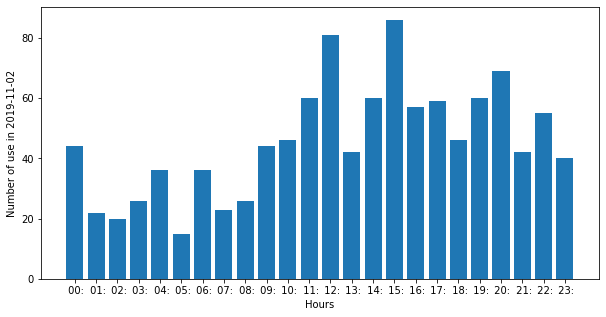

In [18]:
import matplotlib.pyplot as plt

print(result)
result_used = list()
result_distance = list()

for res in result:
    result_used.append(res.get("used"))
    result_distance.append(res.get("distance"))
    

x = hours
y = result_used
plt.figure(figsize=(10,5))
plt.bar(x, y)
plt.ylabel("Number of use in 2019-11-02")
plt.xlabel("Hours")
plt.title("")
#plt.xticks(np.arange(len(days)), [day[5:] for day in days])
plt.show()

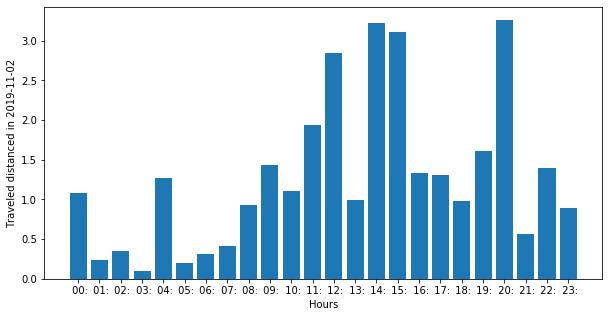

In [19]:
x = hours
y = result_distance
plt.figure(figsize=(10,5))
plt.bar(x, y)
plt.ylabel("Traveled distanced in 2019-11-02")
plt.xlabel("Hours")
plt.title("")
#plt.xticks(np.arange(len(days)), [day[5:] for day in days])
plt.show()